# Installation and Set Up

In [1]:
!java -version

openjdk version "17.0.13" 2024-10-15 LTS
OpenJDK Runtime Environment Microsoft-10376486 (build 17.0.13+11-LTS)
OpenJDK 64-Bit Server VM Microsoft-10376486 (build 17.0.13+11-LTS, mixed mode, sharing)


In [2]:
%pip show h2o

Name: h2o
Version: 3.46.0.6
Summary: H2O, Fast Scalable Machine Learning, for python 
Home-page: https://github.com/h2oai/h2o-3.git
Author: H2O.ai
Author-email: support@h2o.ai
License: Apache v2
Location: d:\OneDrive\Repos\demo-project\.venv\Lib\site-packages
Requires: requests, tabulate
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [8]:
#installing the library
%pip install -r "../requirements.txt"

  Using cached numpy-1.23.4-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.4-cp311-cp311-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.4 which is incompatible.
plotly-resampler 0.10.0 requires numpy>=1.24; python_version >= "3.11", but you have numpy 1.23.4 which is incompatible.


In [3]:
# Importing relevant modules
import h2o
from h2o.automl import H2OAutoML
import time
import datetime

# Load Data

In [4]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("../data/processed/train_set_oversampling.csv")
test = h2o.import_file("../data/processed/test_set.csv")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-10376486 (build 17.0.13+11-LTS, mixed mode, sharing)
  Starting server from D:\OneDrive\Repos\demo-project\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\user\AppData\Local\Temp\tmpn_0ix087
  JVM stdout: C:\Users\user\AppData\Local\Temp\tmpn_0ix087\h2o_user_started_from_python.out
  JVM stderr: C:\Users\user\AppData\Local\Temp\tmpn_0ix087\h2o_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Kuala_Lumpur
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    4 months and 15 days
H2O_cluster_name:           H2O_from_python_user_85fd56
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.971 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.9 final
--------------------------  -----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
# Filter integer columns
int_columns = [col for col, dtype in test.types.items() if dtype == "int"]

# Convert all integer columns to factors in training and testing dataset
for col in int_columns:
    test[col] = test[col].asfactor()
    train[col] = train[col].asfactor()

In [6]:
# Identify predictors and response
x = train.columns
y = "Attrition"
x.remove(y)

# AutoML

In [7]:
# Start timing AutoML training
start = time.time()

print("AutoML started at:"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

# Run AutoML for 20 base models
aml = H2OAutoML(sort_metric="logloss",
                nfolds=5,
                seed=1,
                max_runtime_secs=0,
                max_models=70)
aml.train(x=x, y=y, training_frame=train)
# Documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

print("AutoML completed at:"+datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
# print the time used to train AutoML
print('Time used (seconds): ',time.time()-start)

AutoML started at:2025-03-17_19-17-30
AutoML progress: |
19:17:31.556: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML completed at:2025-03-17_20-51-12
Time used (seconds):  5622.079530477524


# CV performance

In [8]:
# View the AutoML Leaderboard based on CV performance
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id                                                   logloss       auc     aucpr    mean_per_class_error       rmse         mse
-------------------------------------------------------  ---------  --------  --------  ----------------------  ---------  ----------
StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731  0.0265844  0.998927  0.999165              0.00530035  0.0764901  0.00585073
StackedEnsemble_AllModels_1_AutoML_1_20250317_191731     0.0266544  0.999129  0.999291              0.00471143  0.0779864  0.00608188
GBM_grid_1_AutoML_1_20250317_191731_model_21             0.0394027  0.998844  0.999072              0.00471143  0.104499   0.0109201
GBM_grid_1_AutoML_1_20250317_191731_model_15             0.041511   0.998998  0.999156              0.00471143  0.107614   0.0115808
GBM_grid_1_AutoML_1_20250317_191731_model_18             0.0462879  0.999155  0.999264              0.00588928  0.115735   0.0133946
GBM_grid_1_AutoML_1_20250317_191731_model_8              0.0503458  0.999043  0.999158              0.00530035  0.117306   0.0137606
GBM_grid_1_AutoML_1_20250317_191731_model_10             0.0542394  0.999067  0.999222              0.00647821  0.12374    0.0153116
GBM_grid_1_AutoML_1_20250317_191731_model_1              0.0607736  0.998726  0.999005              0.00588928  0.1348     0.0181711
GBM_grid_1_AutoML_1_20250317_191731_model_23             0.0699477  0.998639  0.998901              0.00530035  0.143135   0.0204877
GBM_4_AutoML_1_20250317_191731                           0.071947   0.998705  0.998899              0.00706714  0.143022   0.0204553
GBM_grid_1_AutoML_1_20250317_191731_model_13             0.0721165  0.998203  0.998479              0.0111896   0.144027   0.0207438
GBM_3_AutoML_1_20250317_191731                           0.0728656  0.998581  0.998898              0.00706714  0.144006   0.0207378
GBM_grid_1_AutoML_1_20250317_191731_model_22             0.0742169  0.998082  0.998552              0.00588928  0.14558    0.0211937
GBM_grid_1_AutoML_1_20250317_191731_model_12             0.075446   0.998614  0.998839              0.00647821  0.149244   0.0222737
GBM_5_AutoML_1_20250317_191731                           0.0772625  0.997927  0.998328              0.00647821  0.149741   0.0224223
GBM_grid_1_AutoML_1_20250317_191731_model_5              0.0775945  0.998747  0.998876              0.00647821  0.150408   0.0226224
GBM_2_AutoML_1_20250317_191731                           0.0811949  0.997941  0.998097              0.00706714  0.151658   0.0230002
GBM_grid_1_AutoML_1_20250317_191731_model_9              0.0862147  0.998027  0.998085              0.00942285  0.154648   0.023916
GBM_grid_1_AutoML_1_20250317_191731_model_3              0.0963049  0.997234  0.997402              0.0135453   0.161966   0.026233
GBM_grid_1_AutoML_1_20250317_191731_model_4              0.099033   0.997959  0.998231              0.00883392  0.168781   0.0284871
GBM_grid_1_AutoML_1_20250317_191731_model_25             0.10387    0.997522  0.99759               0.0117786   0.171491   0.0294093
GBM_grid_1_AutoML_1_20250317_191731_model_2              0.108119   0.996713  0.996728              0.0141343   0.170964   0.0292288
GBM_grid_1_AutoML_1_20250317_191731_model_17             0.111209   0.99629   0.995916              0.0117786   0.172107   0.0296208
GBM_grid_1_AutoML_1_20250317_191731_model_24             0.115848   0.996681  0.996899              0.0170789   0.175796   0.0309041
GBM_grid_1_AutoML_1_20250317_191731_model_20             0.126673   0.993711  0.991741              0.0182568   0.181002   0.0327619
DeepLearning_grid_1_AutoML_1_20250317_191731_model_8     0.129023   0.989181  0.985959              0.03298     0.173411   0.0300713
GBM_grid_1_AutoML_1_20250317_191731_model_11             0.131818   0.994766  0.994381              0.0217903   0.184874   0.0341785
DeepLearning_grid_1_AutoML_1_20250317_191731_model_12    0.13495    0.988398  0.984894              0.0365135   0.179461   0.0322063
DeepLear

In [9]:
# Get the best model based on CV performance
cv_best_model = aml.leader
# Display training and CV performance
cv_best_model

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/5
# GBM base models (used / total)           1/1
# DeepLearning base models (used / total)  0/1
# DRF base models (used / total)           2/2
# GLM base models (used / total)           1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 8.26938024252443e-07
RMSE: 0.0009093613276648854
LogLoss: 0.00012860507271225774
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 1697
Residual degrees of freedom: 1693
Null deviance: 2353.927825181572
Residual deviance: 0.43674282693083594
AIC: 10.436742826930836

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.972241078317809
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      849  0    0        (0.0/849.0)
1      0    849  0        (0.0/849.0)
Total  849  849  0        (0.0/1698.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.972241     1         120
max f2                       0.972241     1         120
max f0point5                 0.972241     1         120
max accuracy                 0.972241     1         120
max precision                1            1         0
max recall                   0.972241     1         120
max specificity              1            1         0
max absolute_mcc             0.972241     1         120
max min_per_class_accuracy   0.972241     1         120
max mean_per_class_accuracy  0.972241     1         120
max tns                      1            849       0
max fns                      1            753       0
max fps                      6.04864e-09  849       399
max tps                      0.972241     849       120
max tnr                      1            1         0
max fnr                      1            0.886926  0
max fpr                      6.04864e-09  1         399
max tpr                      0.972241     1         120

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.99 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0129564                   1                  2       2                  1                1            1                           1                   0.0259128       0.0259128                  100     100                0.0259128
2        0.0206125                   1                  2       2                  1                1            1                           1                   0.0153121       0.041225                   100     100                0.041225
3        0.0300353                   1                  2       2                  1                1            1                           1                   0.0188457       0.0600707                  100     100                0.0600707
4        0.0447585                   1                  2       2                  1                1            1                

# Test Performance of Best Model from CV

In [10]:
# Get threshold at max f1 in CV
max_f1_threshold = cv_best_model.find_threshold_by_max_metric(xval=True, metric="f1")

# Check model performance on test data at threshold
perf = cv_best_model.model_performance(test_data=test)

# Print confusion matrix
perf.confusion_matrix(thresholds=max_f1_threshold)

Could not find exact threshold 0.8050883119836987; using closest threshold found 0.8270224989439995.


Confusion Matrix (Act/Pred) @ threshold = 0.8270224989439995
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      384  0    0        (0.0/384.0)
1      50   7    0.8772   (50.0/57.0)
Total  434  7    0.1134   (50.0/441.0)

In [11]:
predictions = cv_best_model.predict(test)

# Apply your desired threshold
threshold = max_f1_threshold
predictions["custom_pred"] = (predictions["p1"] >= threshold).ifelse(1, 0)

predictions

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


predict        p0           p1    custom_pred
---------  --------  -----------  -------------
        1  0.172978  0.827022                 1
        0  0.999844  0.000156202              0
        0  0.999896  0.00010384               0
        0  0.998365  0.00163544               0
        0  0.999937  6.29474e-05              0
        0  0.999974  2.60134e-05              0
        0  0.997886  0.00211399               0
        0  0.999996  3.92113e-06              0
        0  0.999981  1.93165e-05              0
        0  0.985608  0.014392                 0
[441 rows x 4 columns]

In [12]:
# Print performance on test data
perf

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.10396956943608822
RMSE: 0.322443125893681
LogLoss: 0.6069010524141891
AUC: 0.8447551169590644
AUCPR: 0.5775007382007294
Gini: 0.6895102339181287
Null degrees of freedom: 440
Residual degrees of freedom: 436
Null deviance: 611.3558132538718
Residual deviance: 535.2867282293203
AIC: 545.2867282293203

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004770391628635588
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      353  31   0.0807   (31.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  374  67   0.1179   (52.0/441.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00477039   0.580645  66
max f2                       0.00175439   0.642202  98
max f0point5                 0.0377261    0.597015  35
max accuracy                 0.129428     0.897959  17
max precision                0.997501     1         0
max recall                   8.75874e-06  1         365
max specificity              0.997501     1         0
max absolute_mcc             0.0113515    0.515885  50
max min_per_class_accuracy   0.000700444  0.77193   127
max mean_per_class_accuracy  0.00175439   0.794202  98
max tns                      0.997501     384       0
max fns                      0.997501     56        0
max fps                      8.07012e-09  384       399
max tps                      8.75874e-06  57        365
max tnr                      0.997501     1         0
max fnr                      0.997501     0.982456  0
max fpr                      8.07012e-09  1         399
max tpr                      8.75874e-06  1         365

Gains/Lift Table: Avg response rate: 12.93 %, avg score:  2.65 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0113379                   0.905646           7.73684   7.73684            1                0.97588      1                           0.97588             0.0877193       0.0877193                  673.684   673.684            0.0877193
2        0.0204082                   0.423334           5.80263   6.87719            0.75             0.758571     0.888889                    0.879298            0.0526316       0.140351                   480.263   587.719            0.137747
3        0.031746                    0.180919           4.64211   6.07895            0.6              0.278465     0.785714                    0.664715            0.0526316       0.192982                   364.211   507.895            0.18517
4        0.0408163                   0.122348           7.73684   6.44737            1                0.152414     0.833333                    0.55087             0.0701754       0.263158                   673.684   544.737            0.255345
5        0.0521542                   0.0721936          3.09474   5.71854            0.4              0.0974286    0.73913                     0.452296            0.0350877       0.298246                   209.474   471.854            0.282621
6        0.102041                    0.0200412          3.16507   4.47018            0.409091         0.0424038    0.577778                    0.251904            0.157895        0.45614                    216.507   347.018            0.406661
7        0.151927                    0.00477039         3.51675   4.15711            0.454545         0.00880709   0.537313                    0.172081 

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004770391628635588
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      353  31   0.0807   (31.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  374  67   0.1179   (52.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

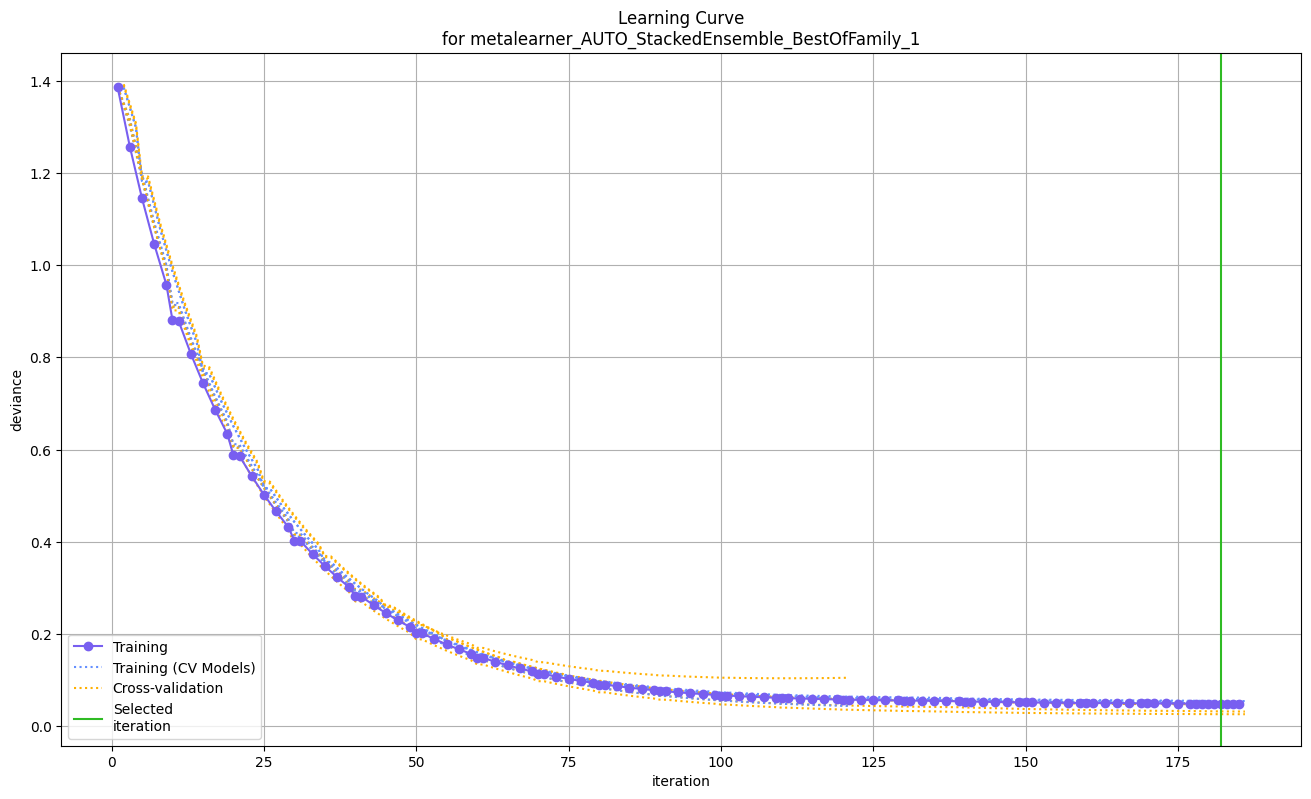

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

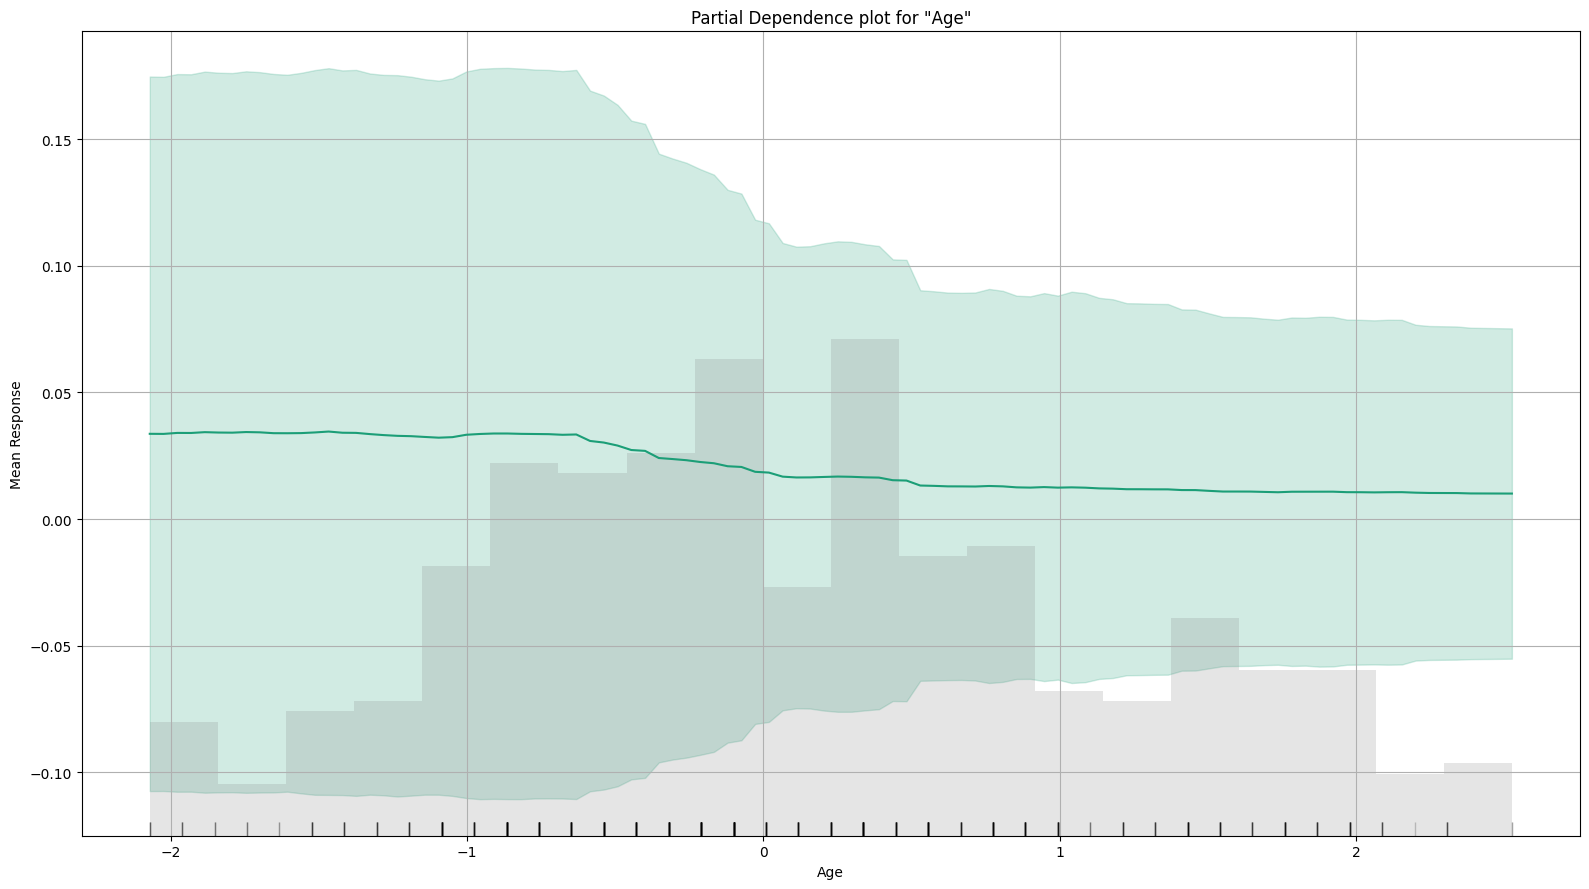

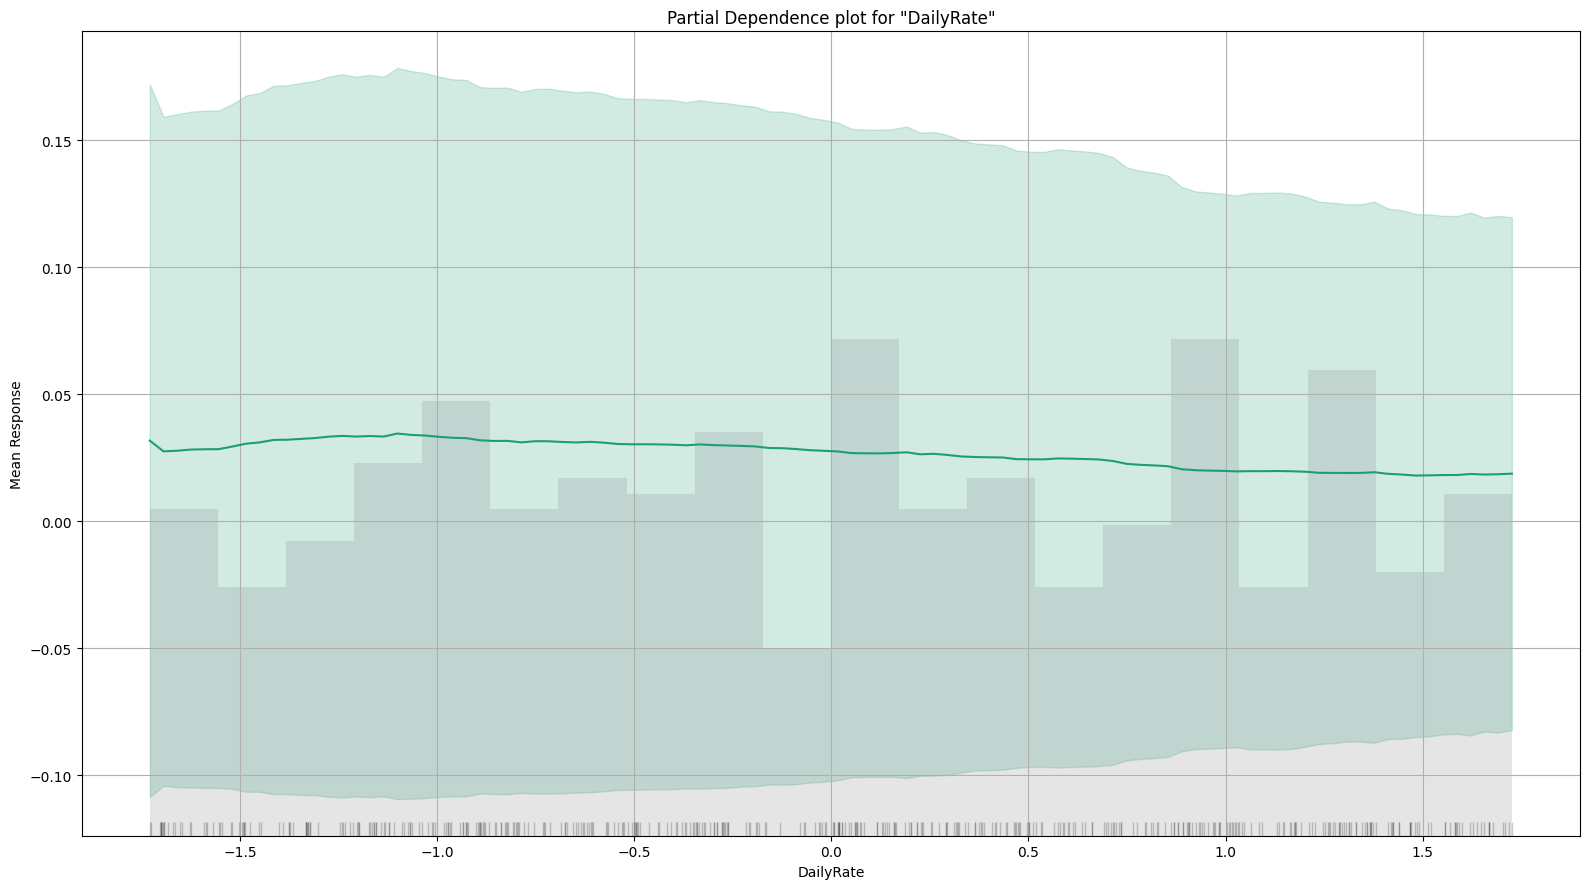

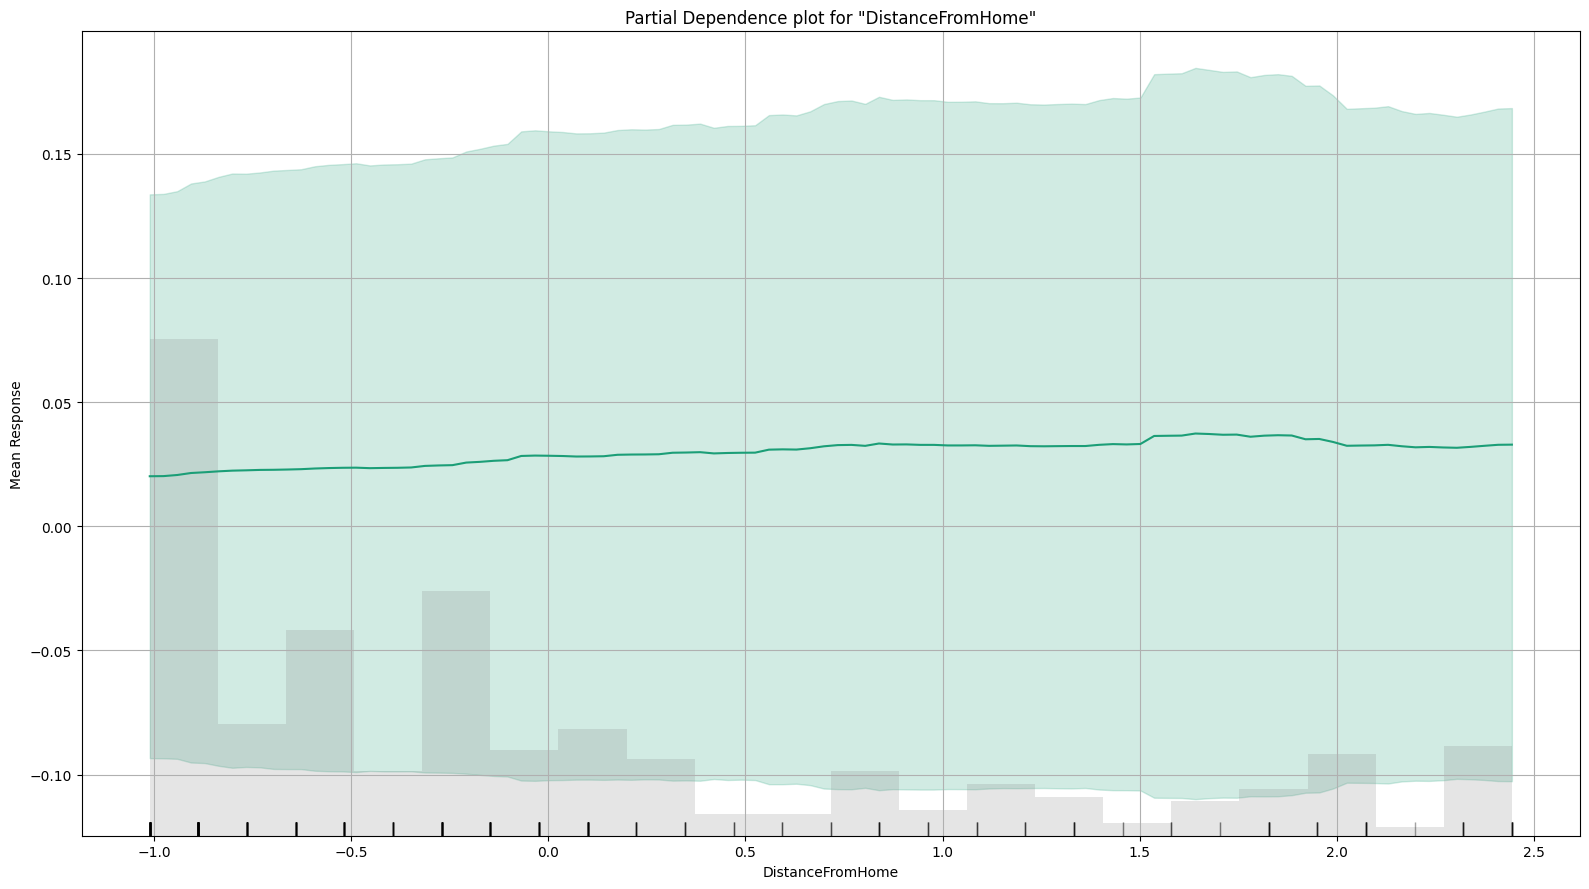

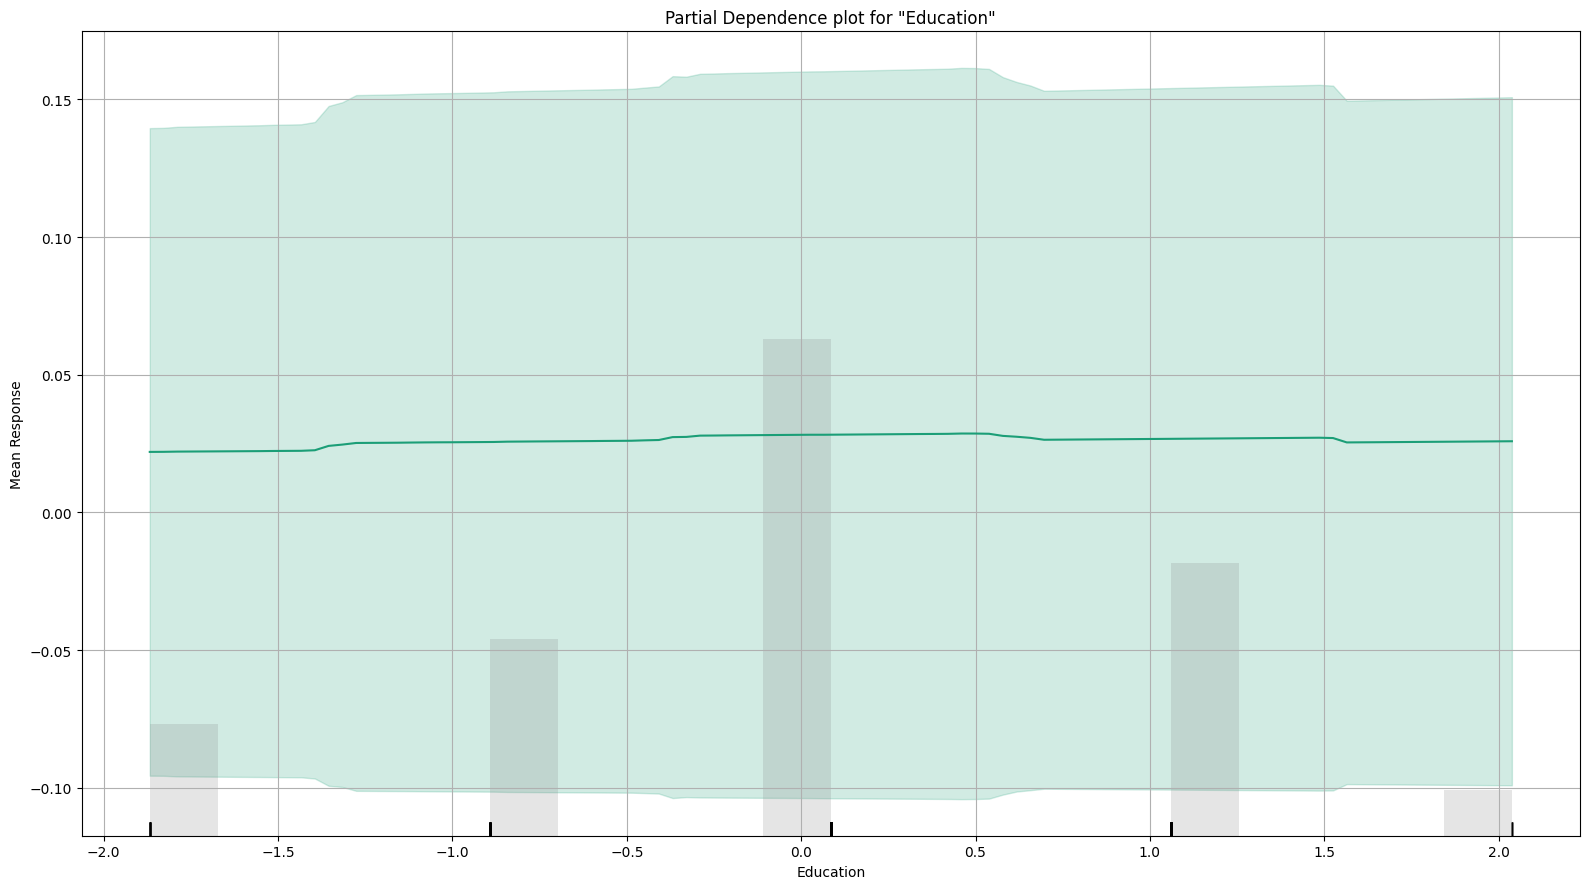

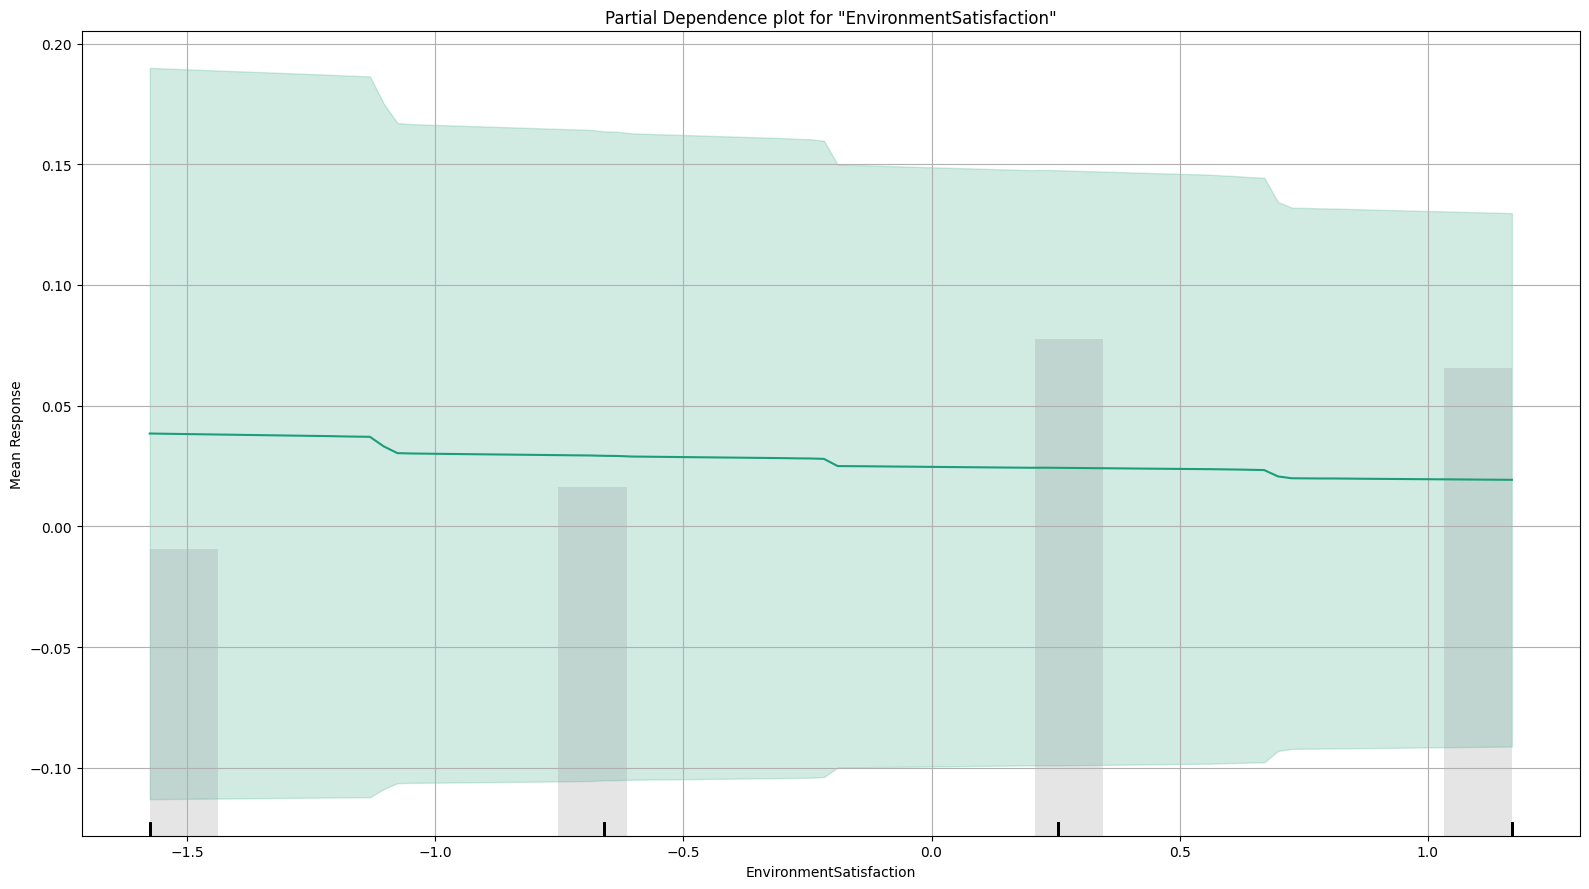

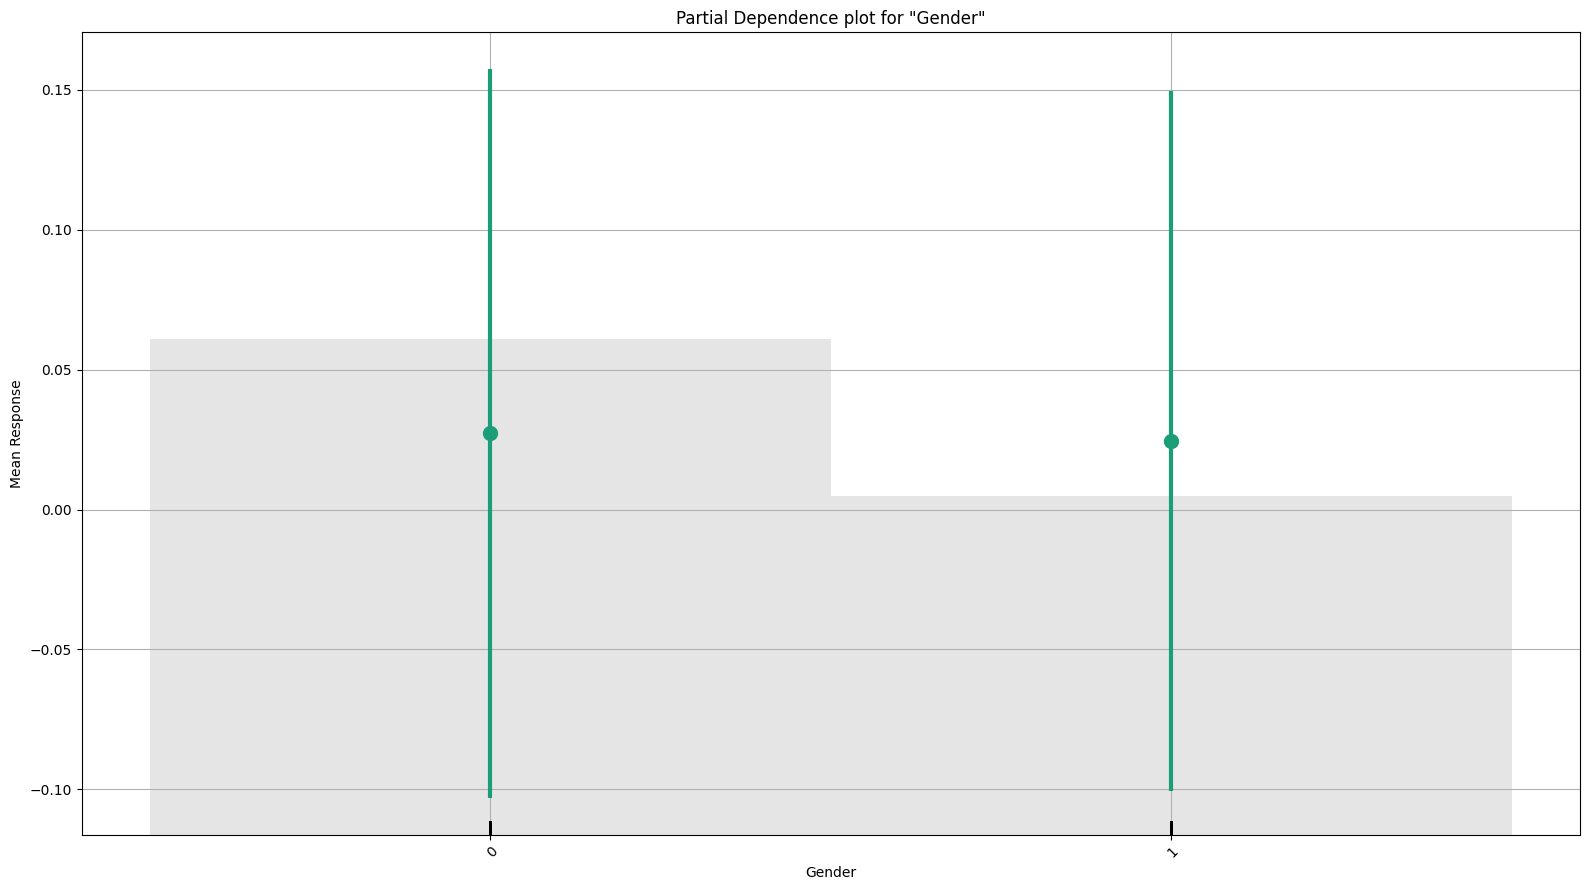

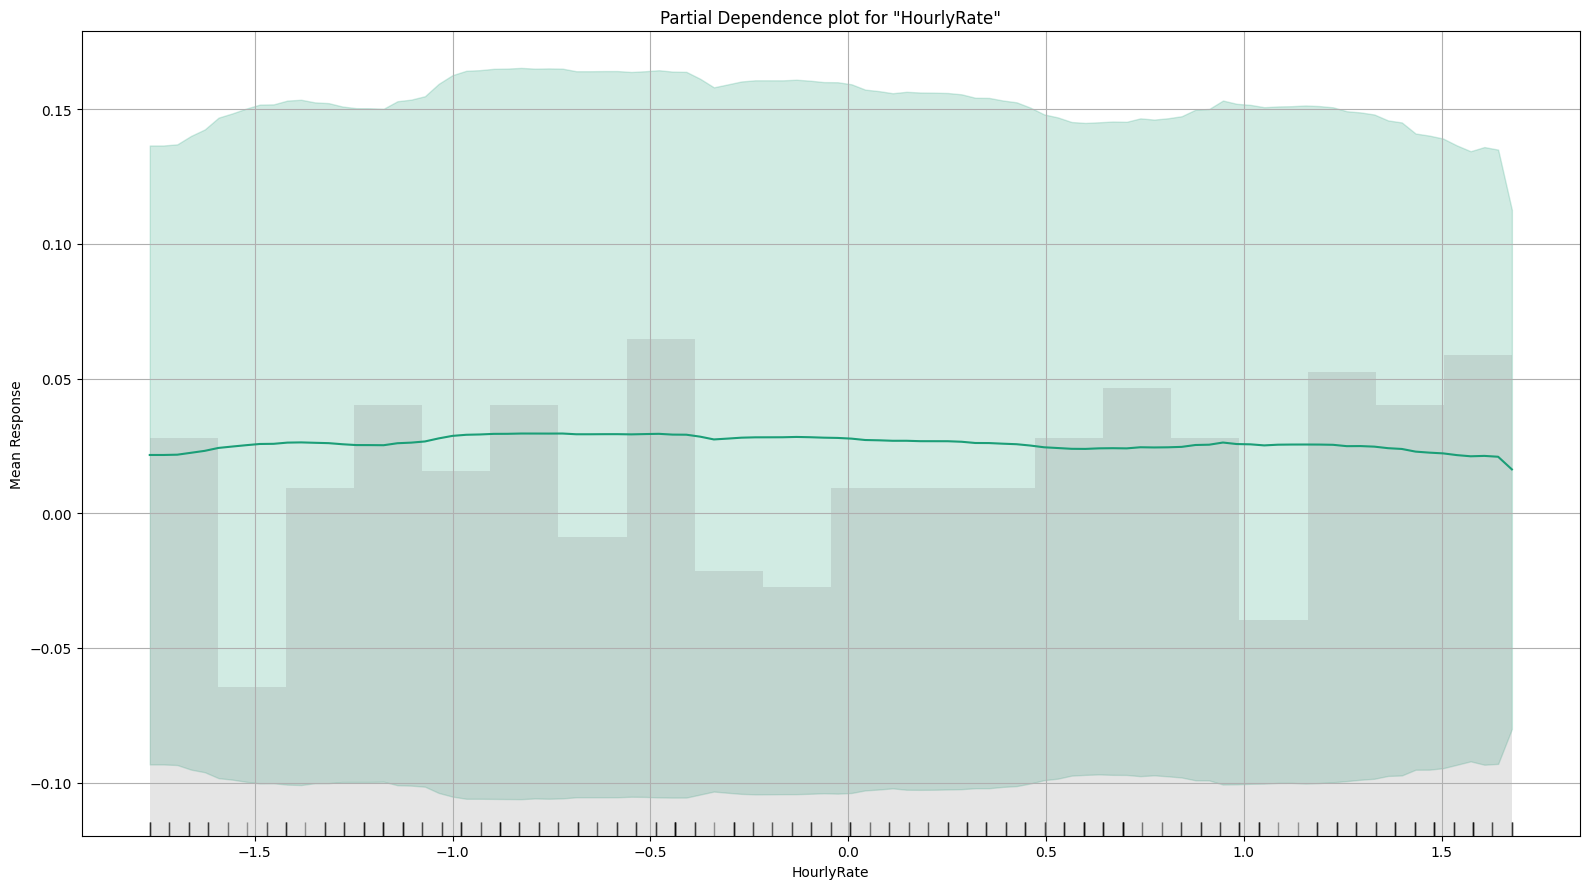

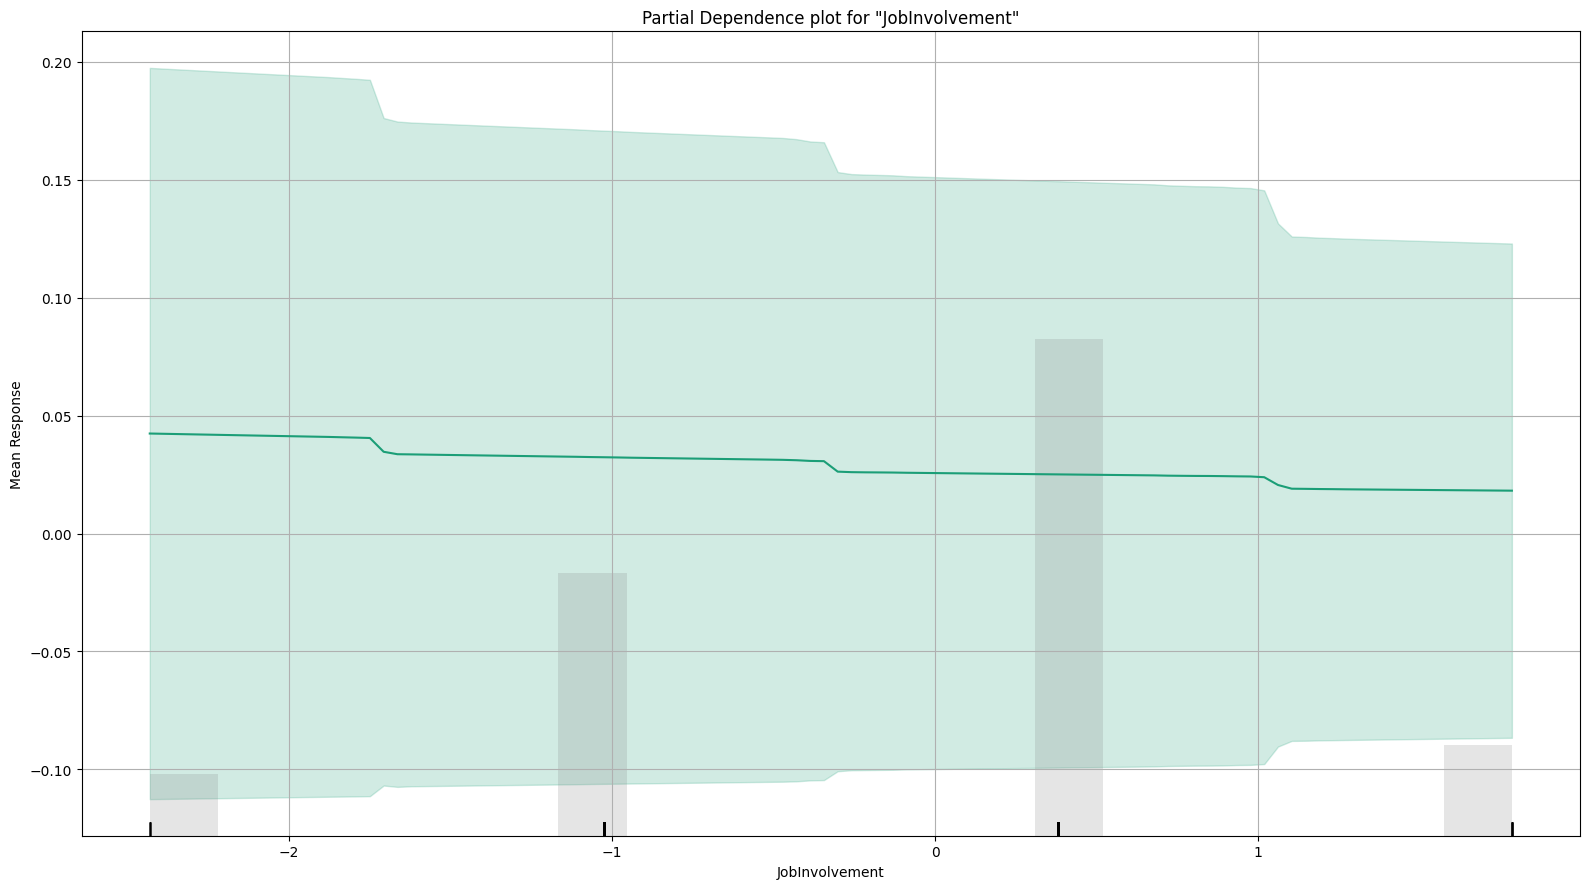

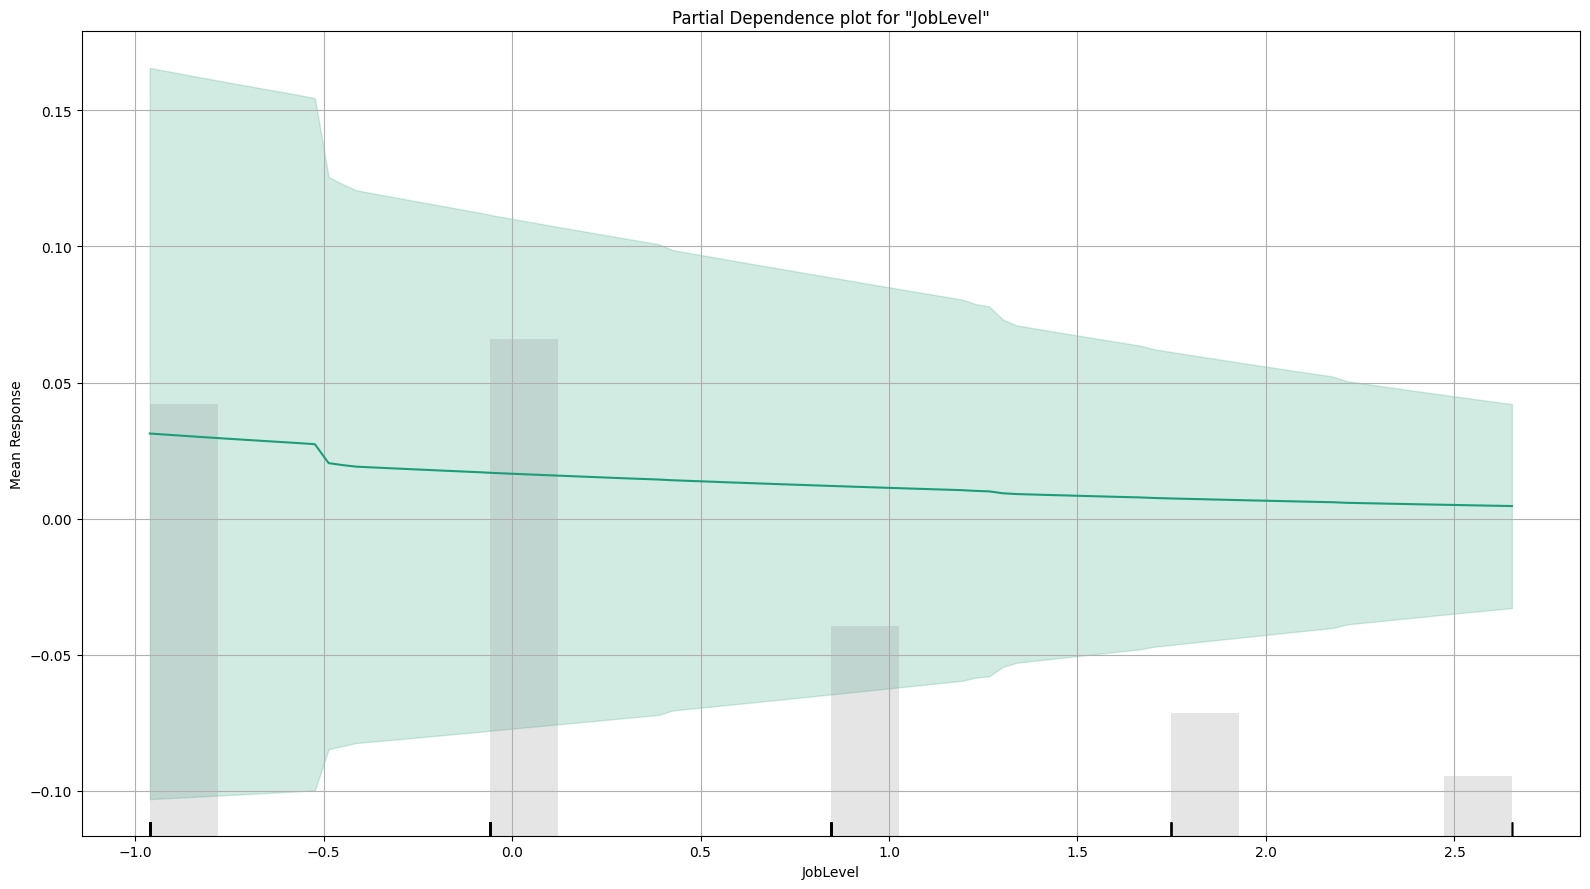

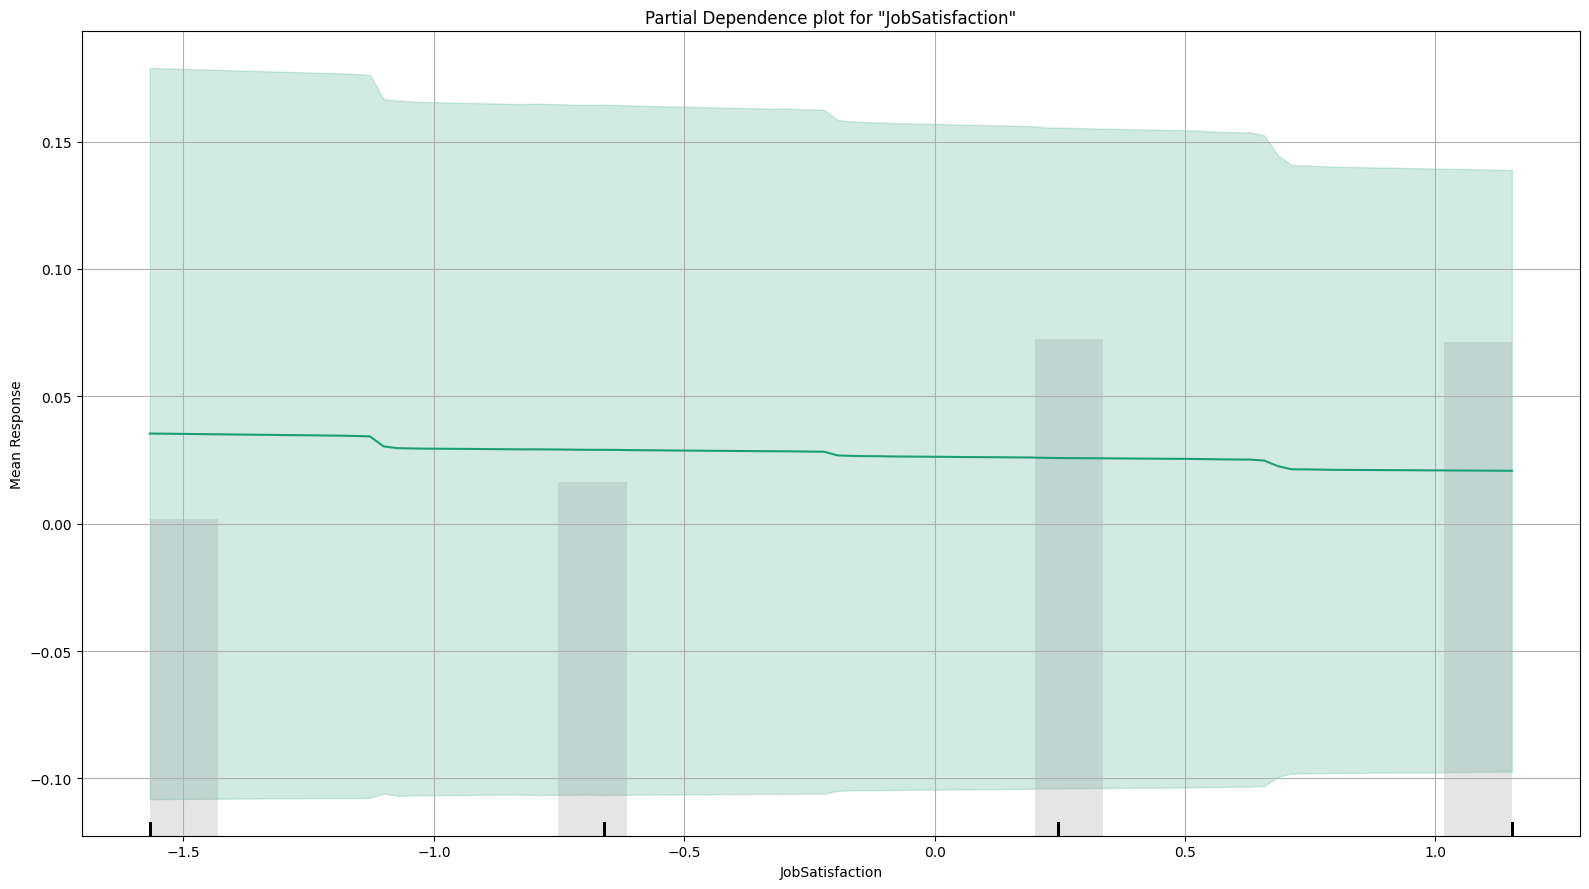

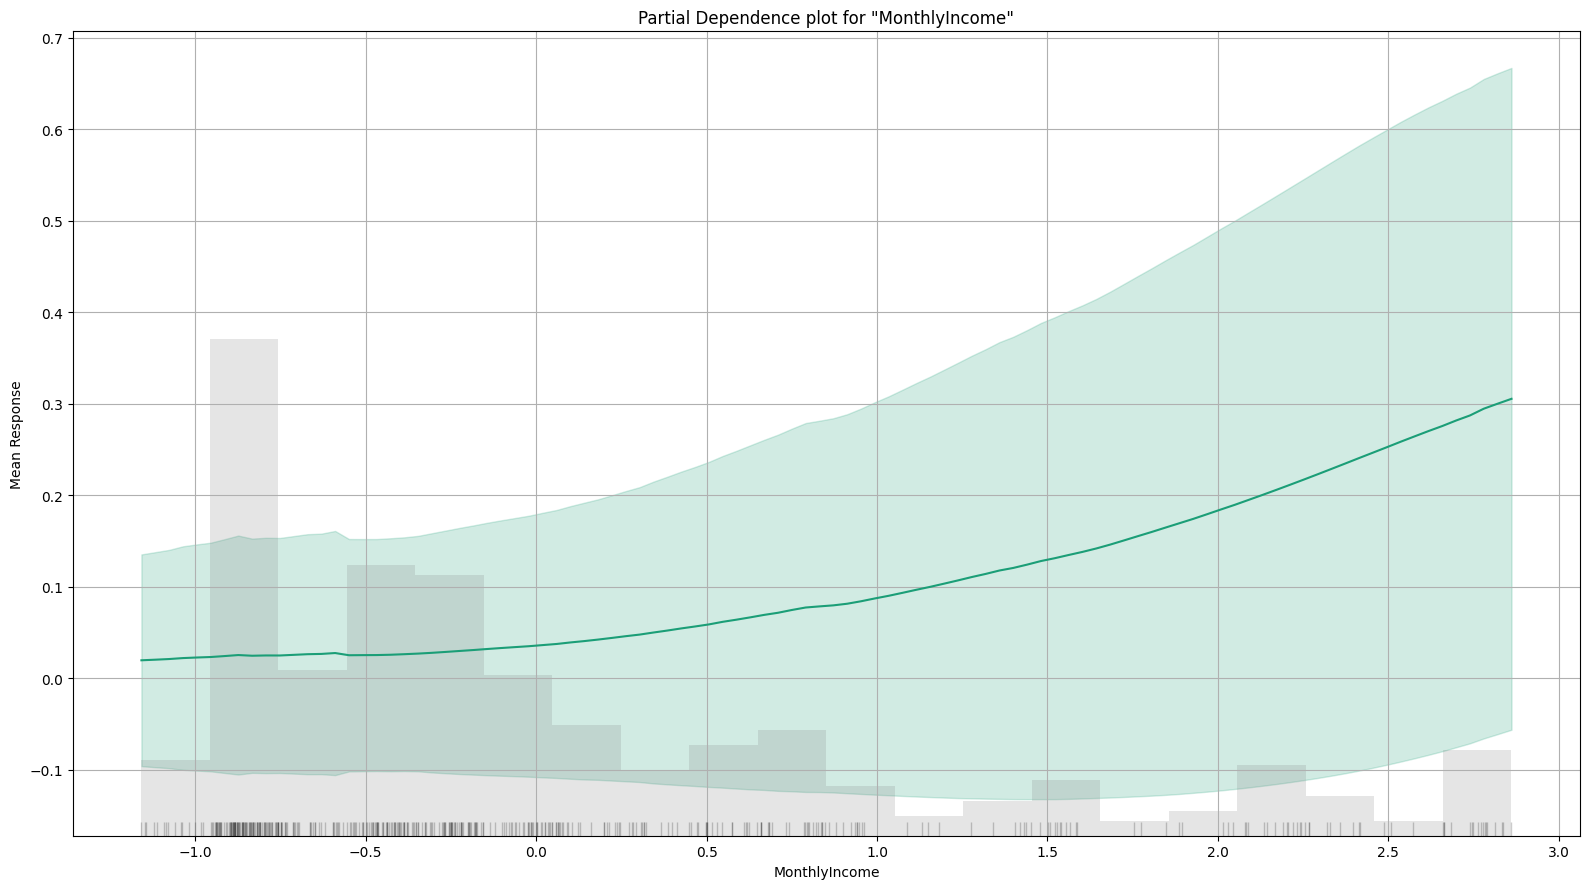

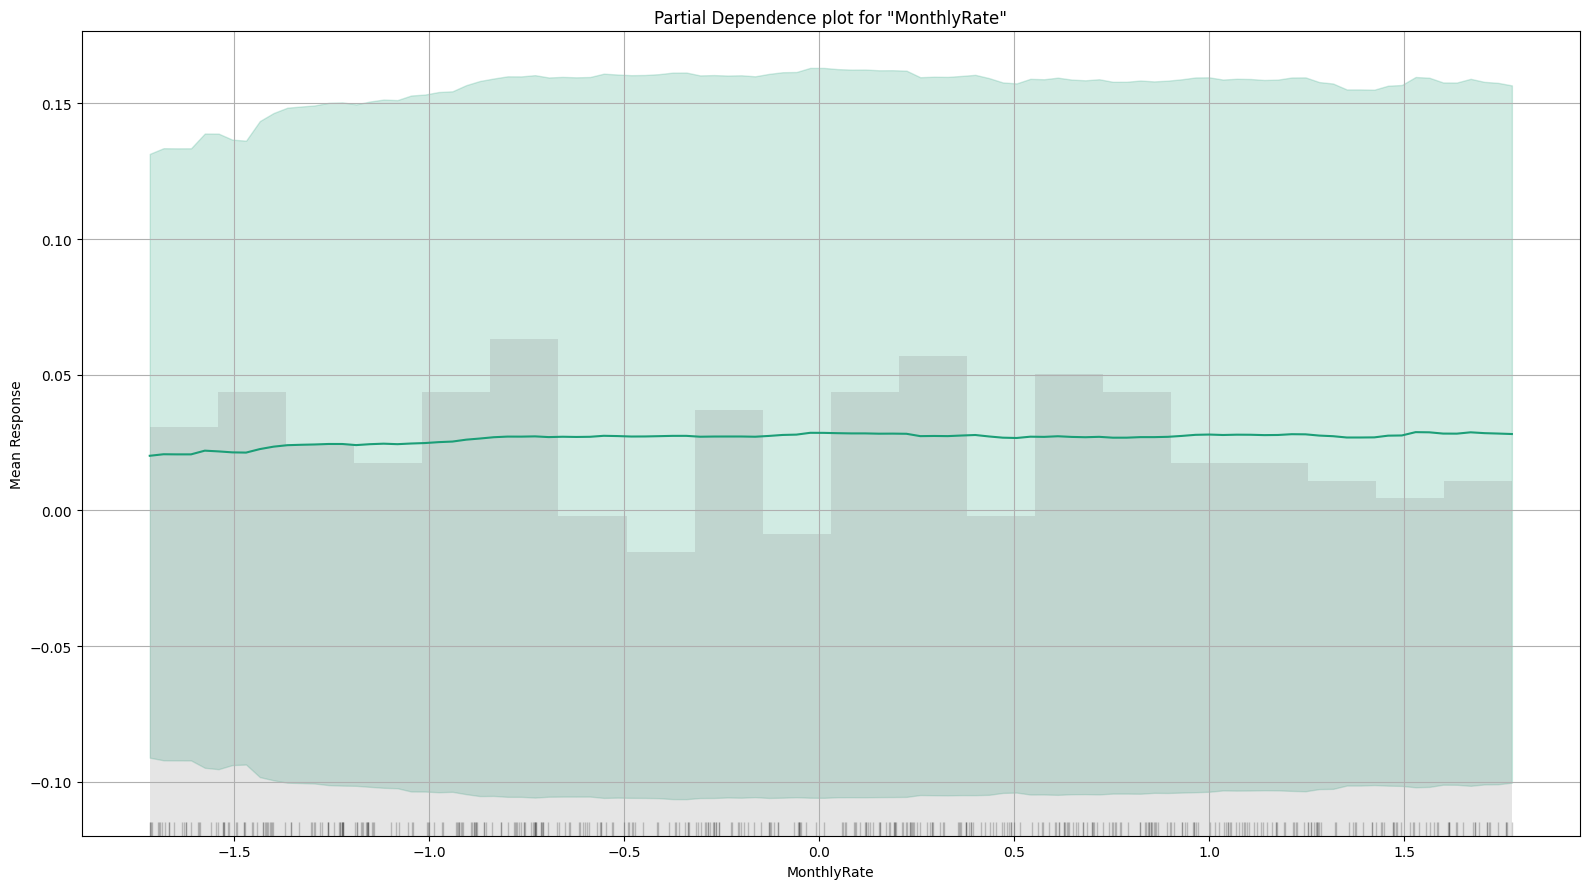

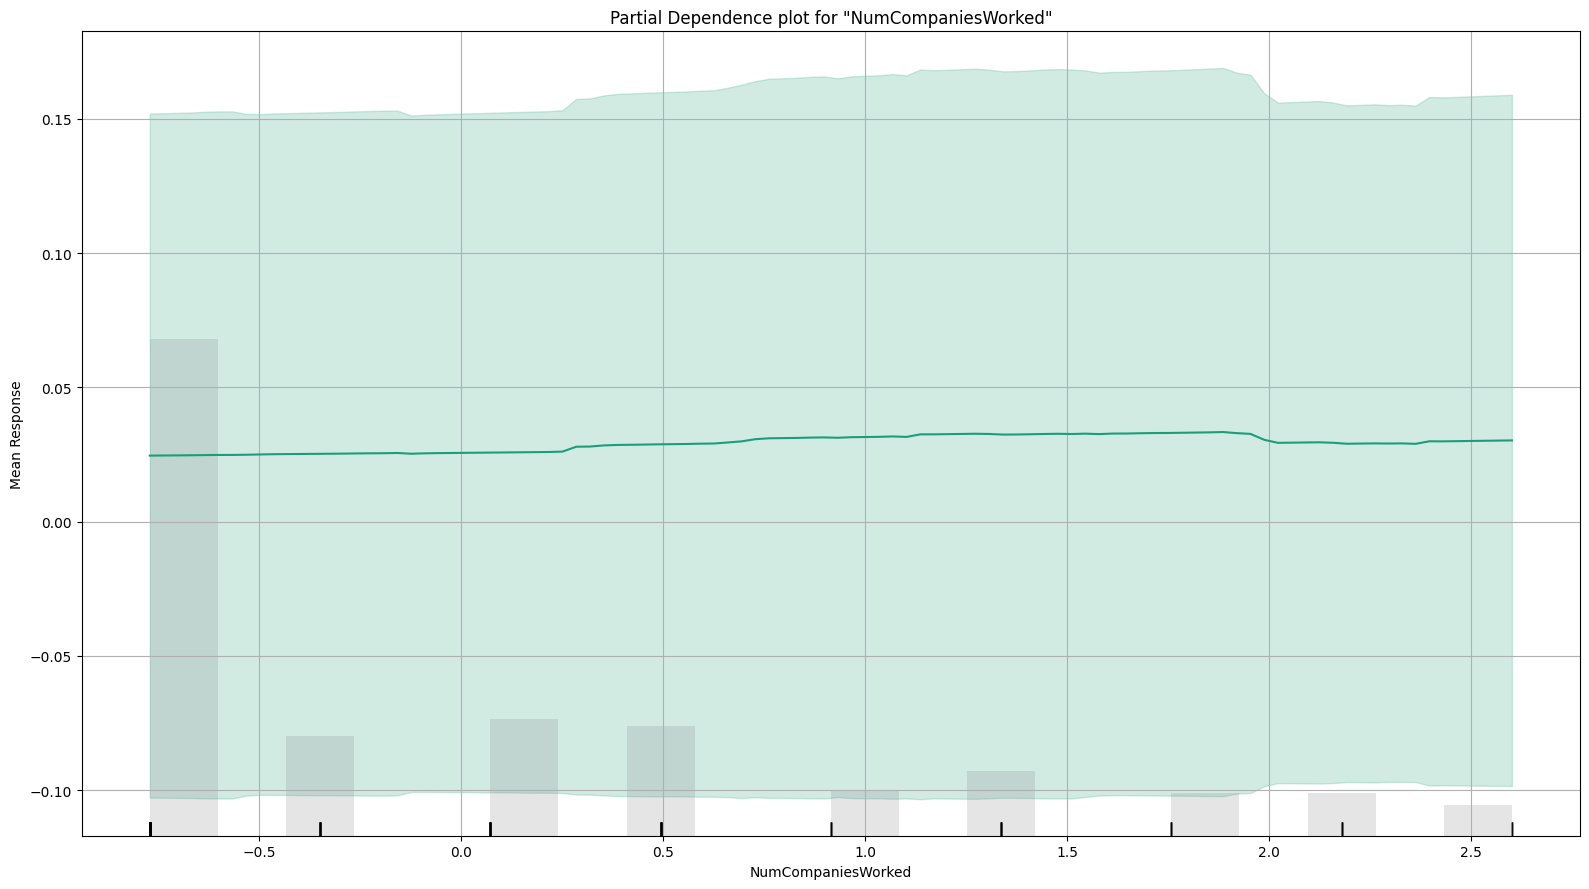

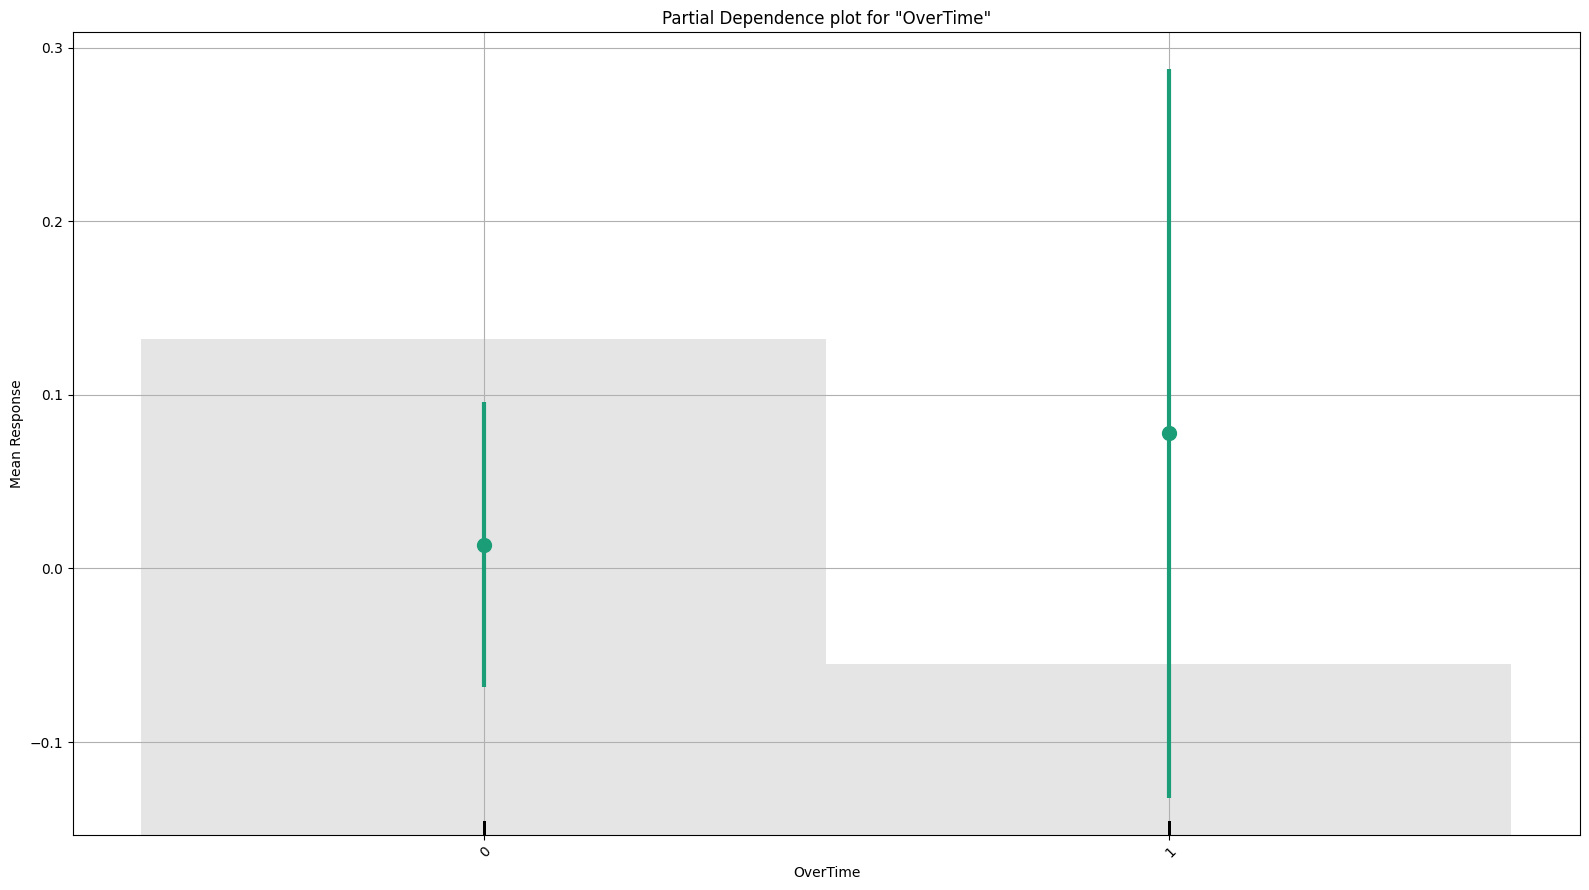

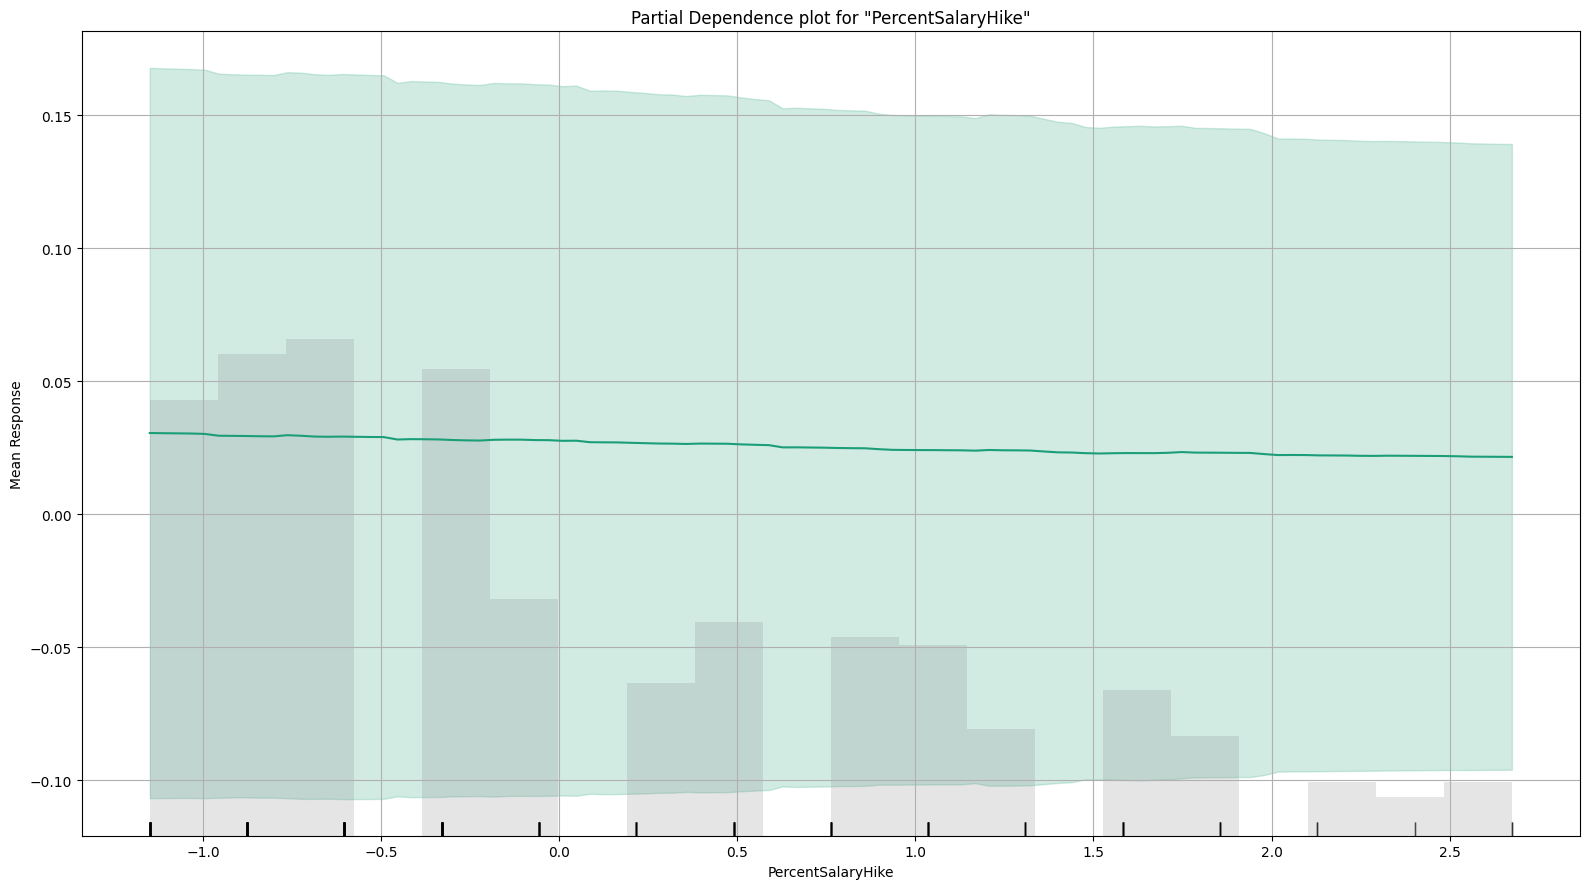

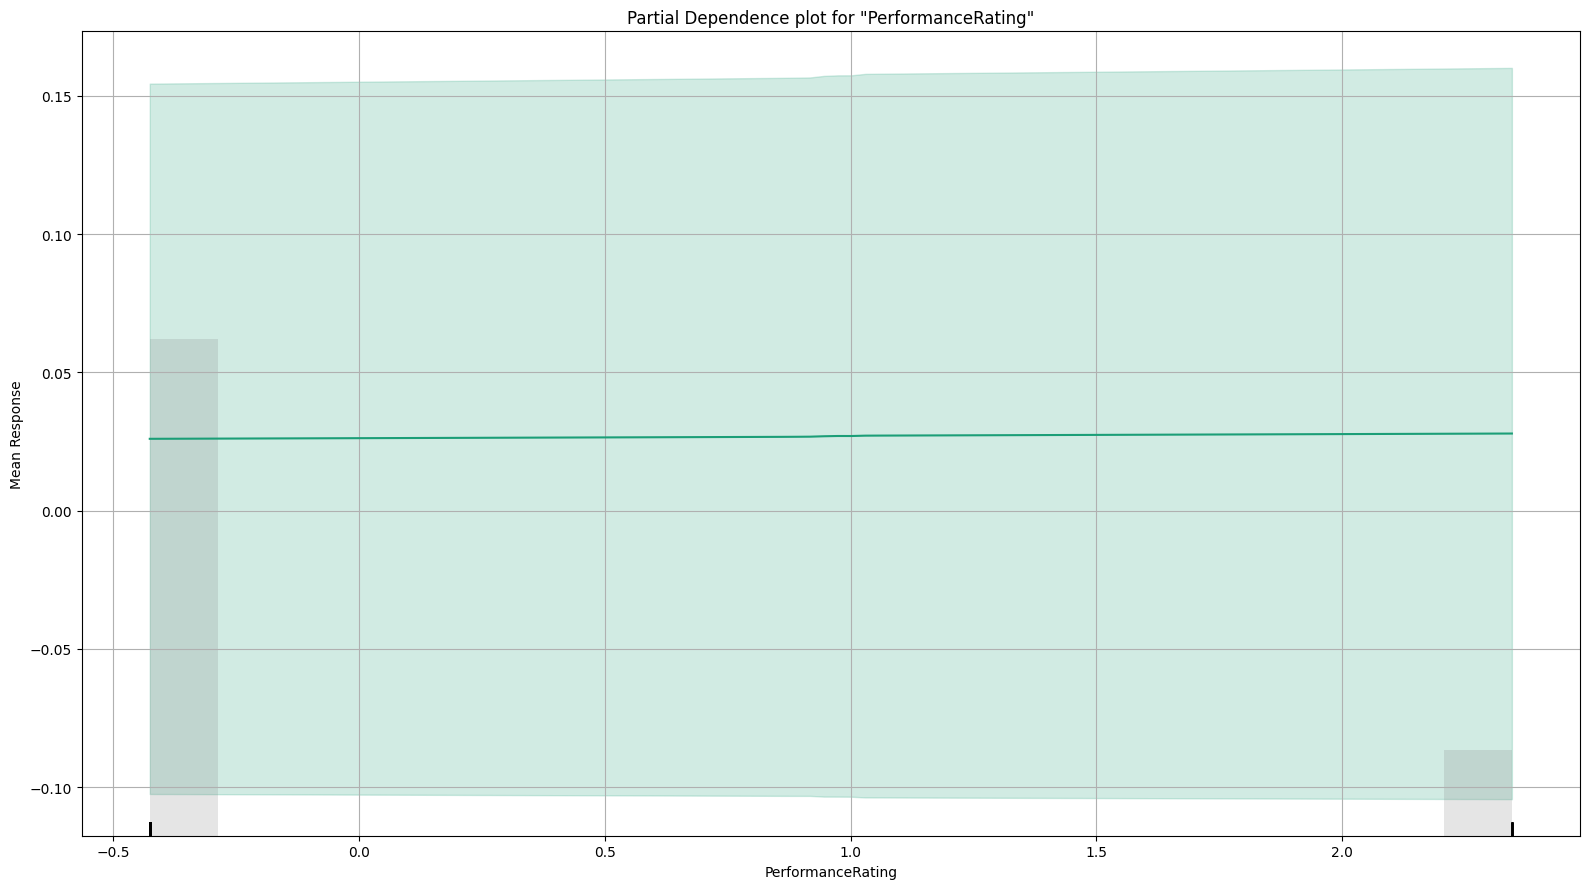

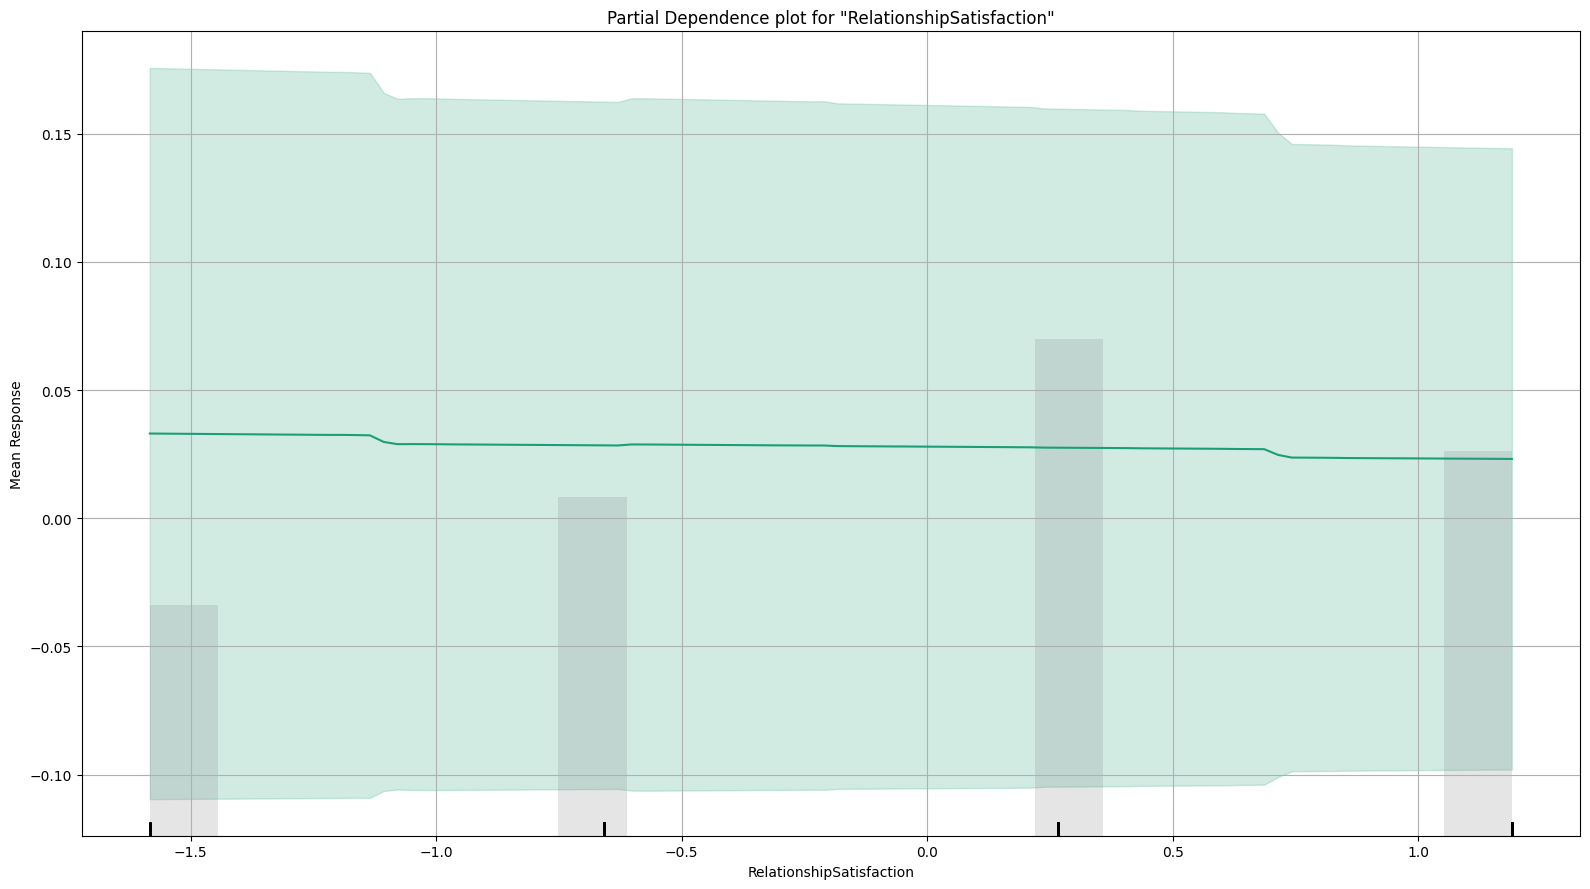

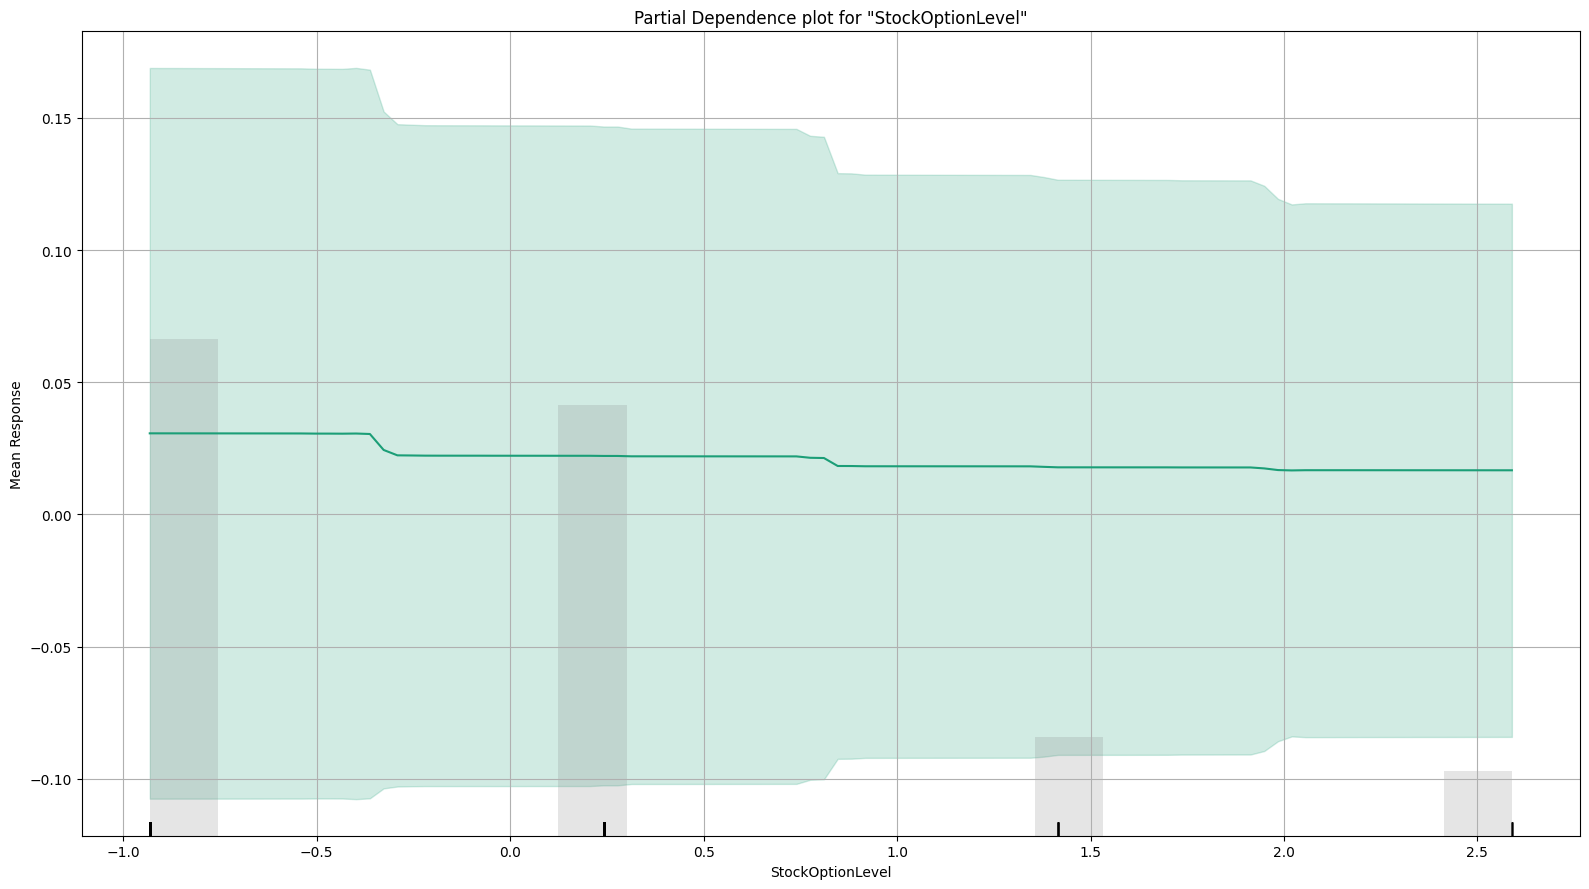

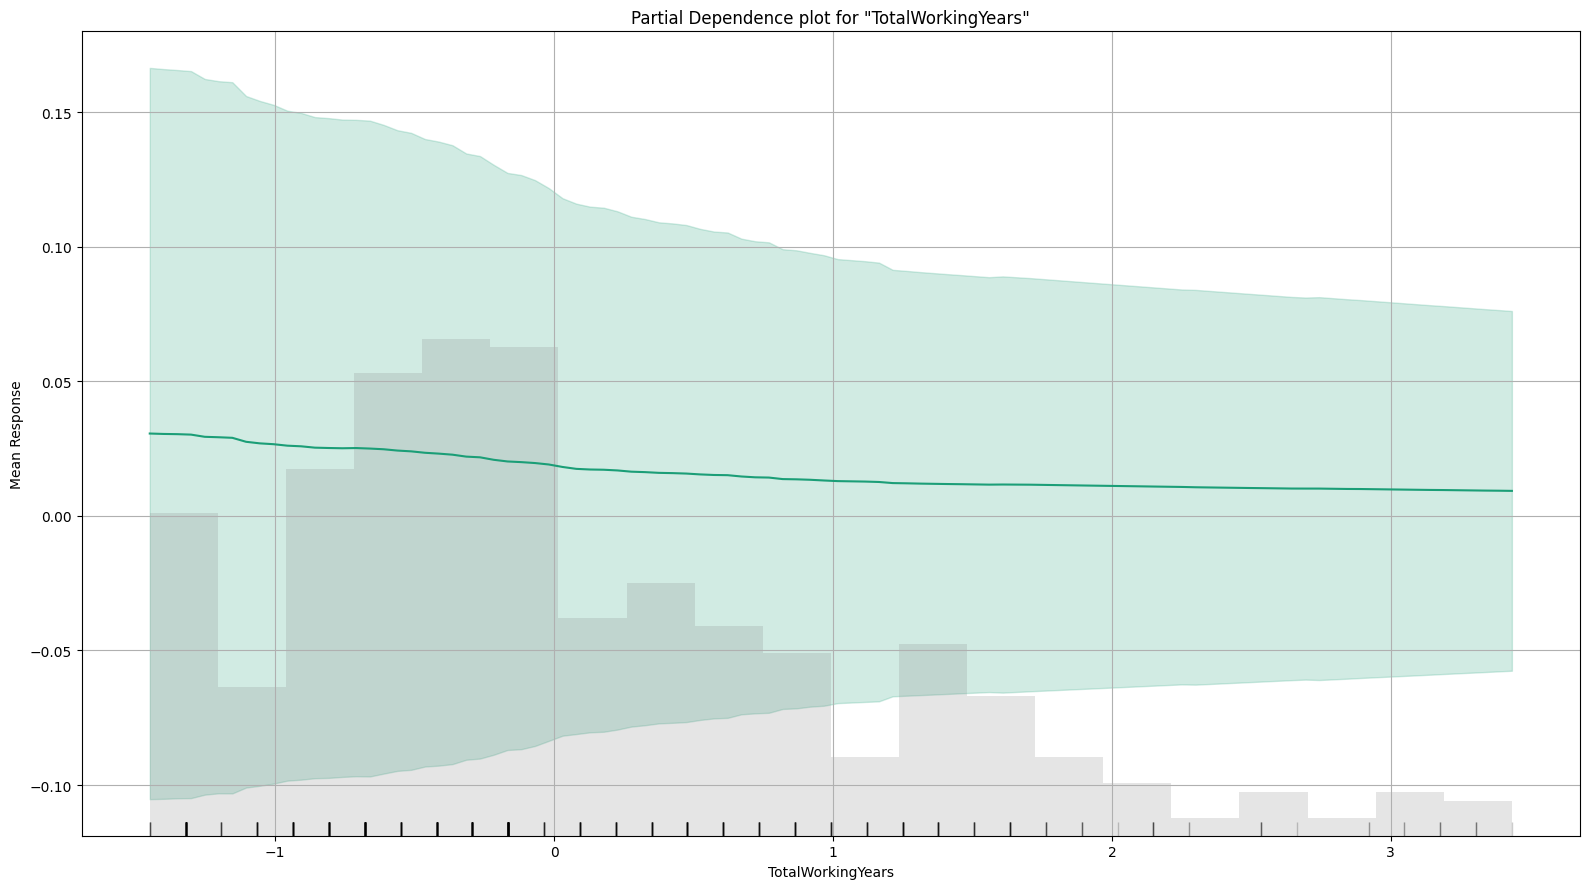

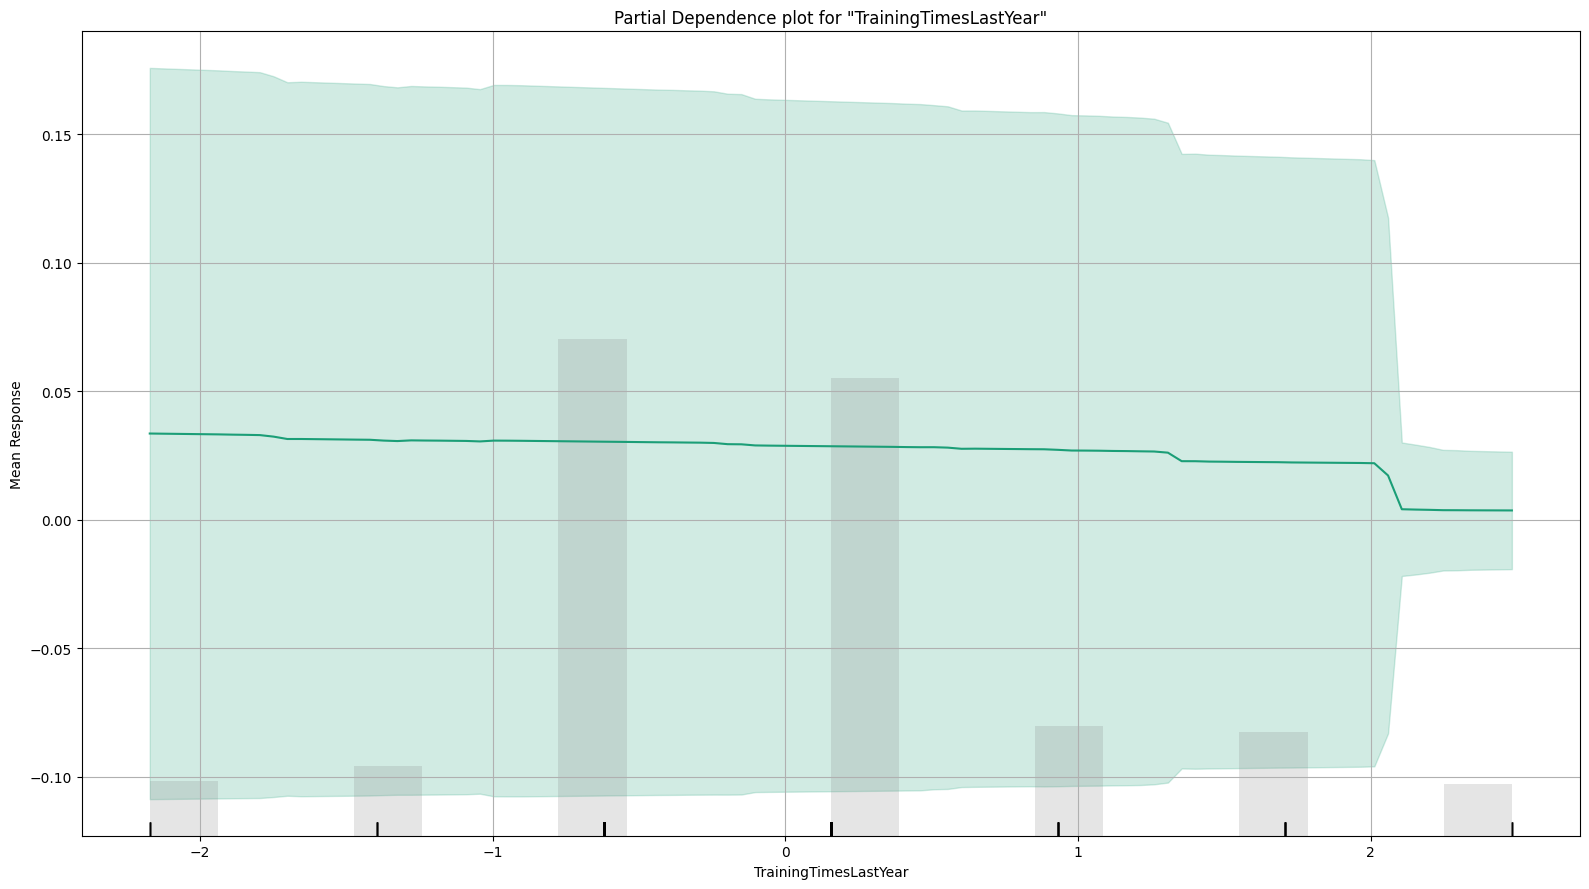

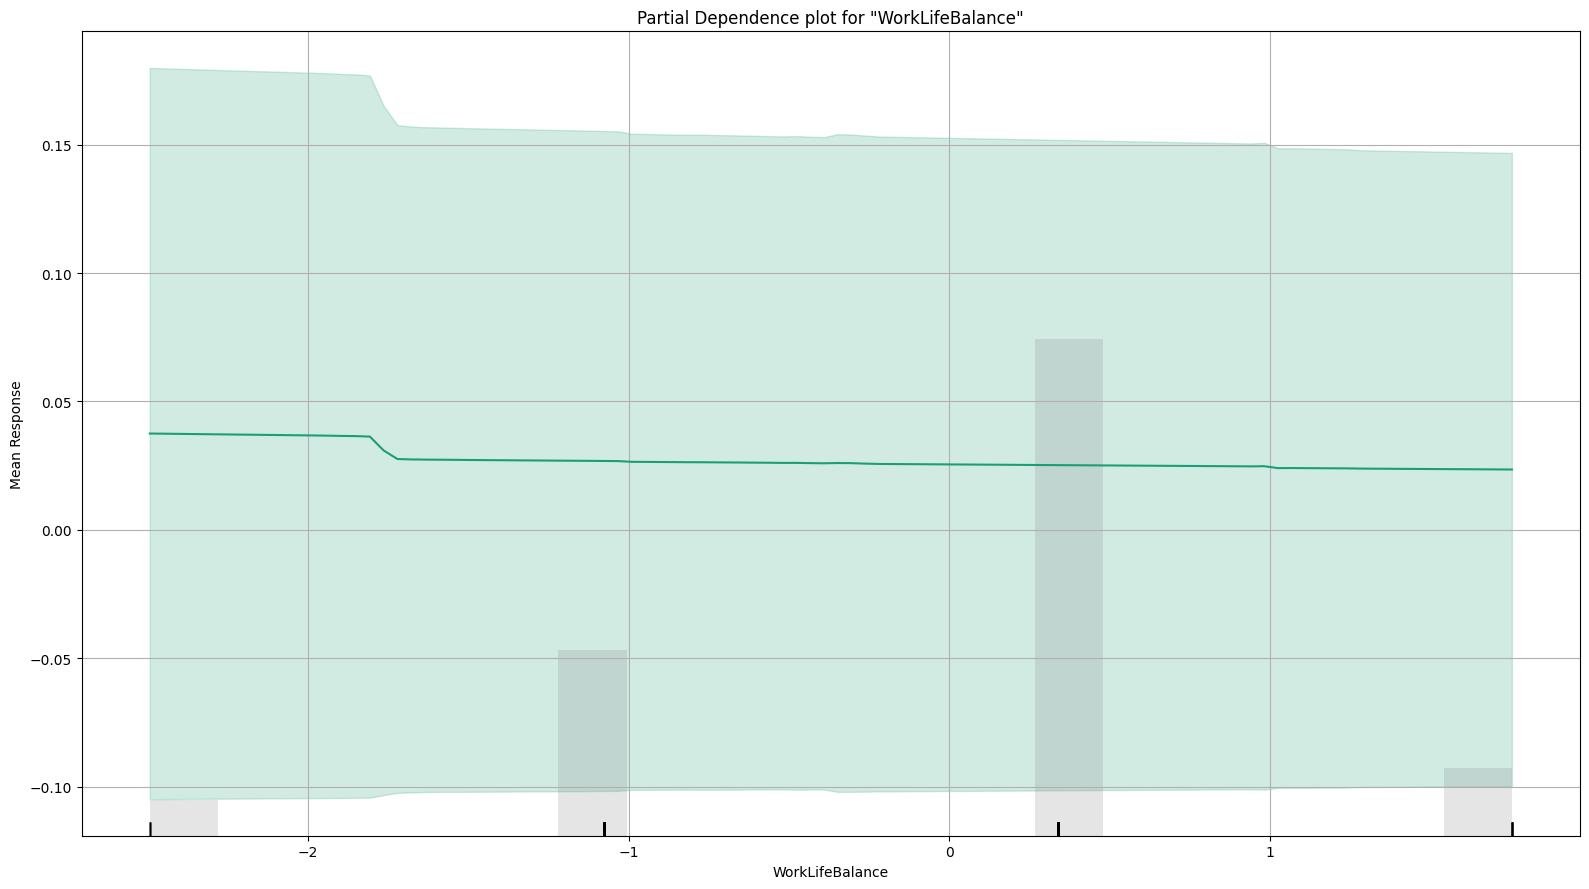

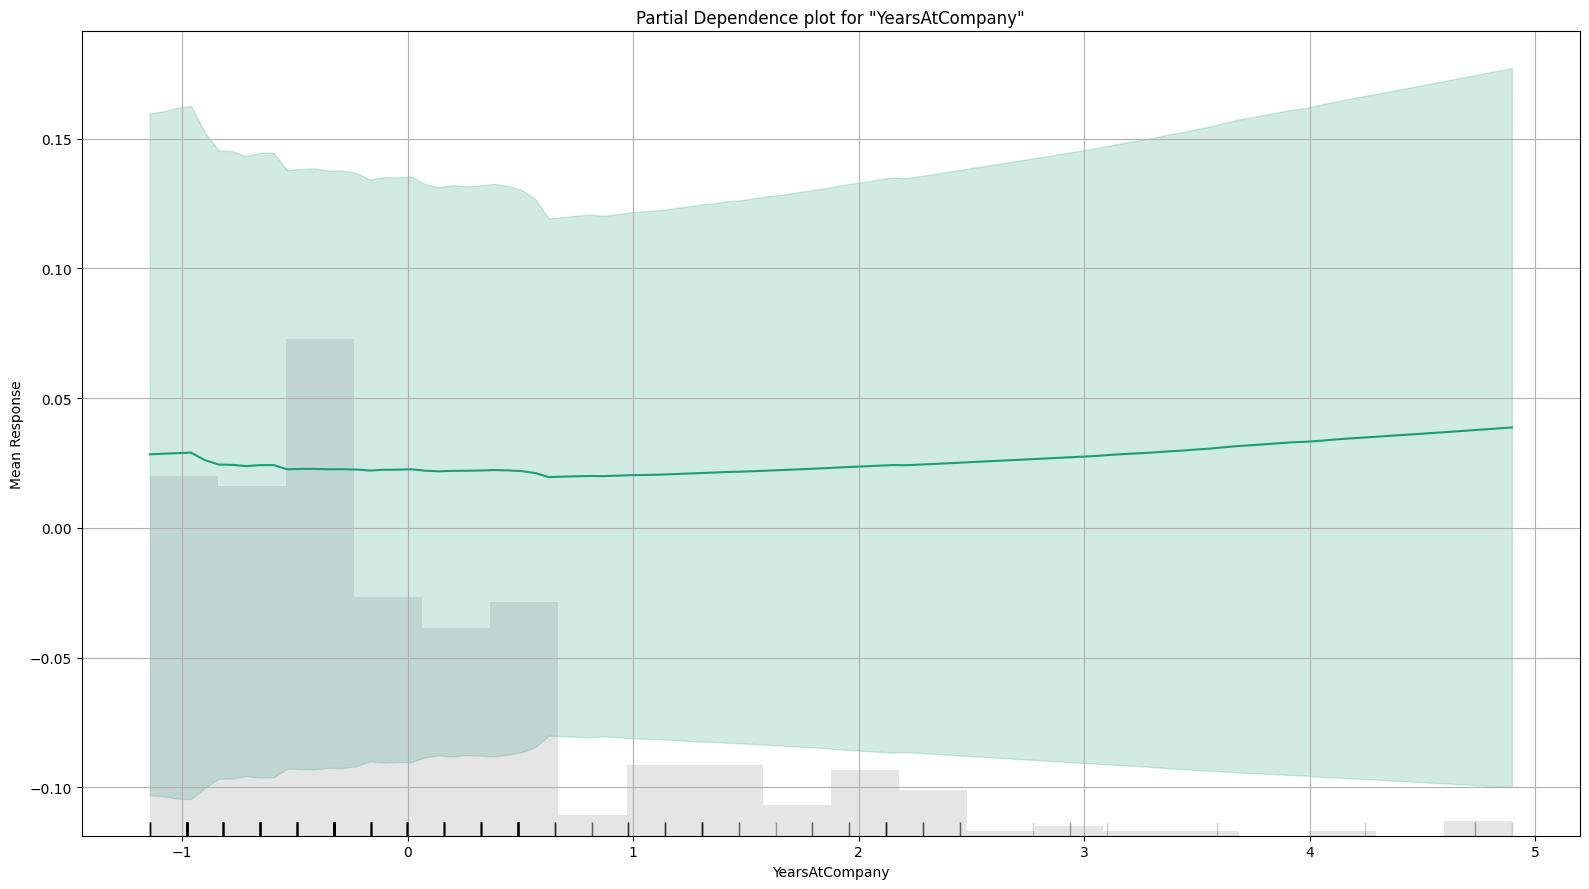

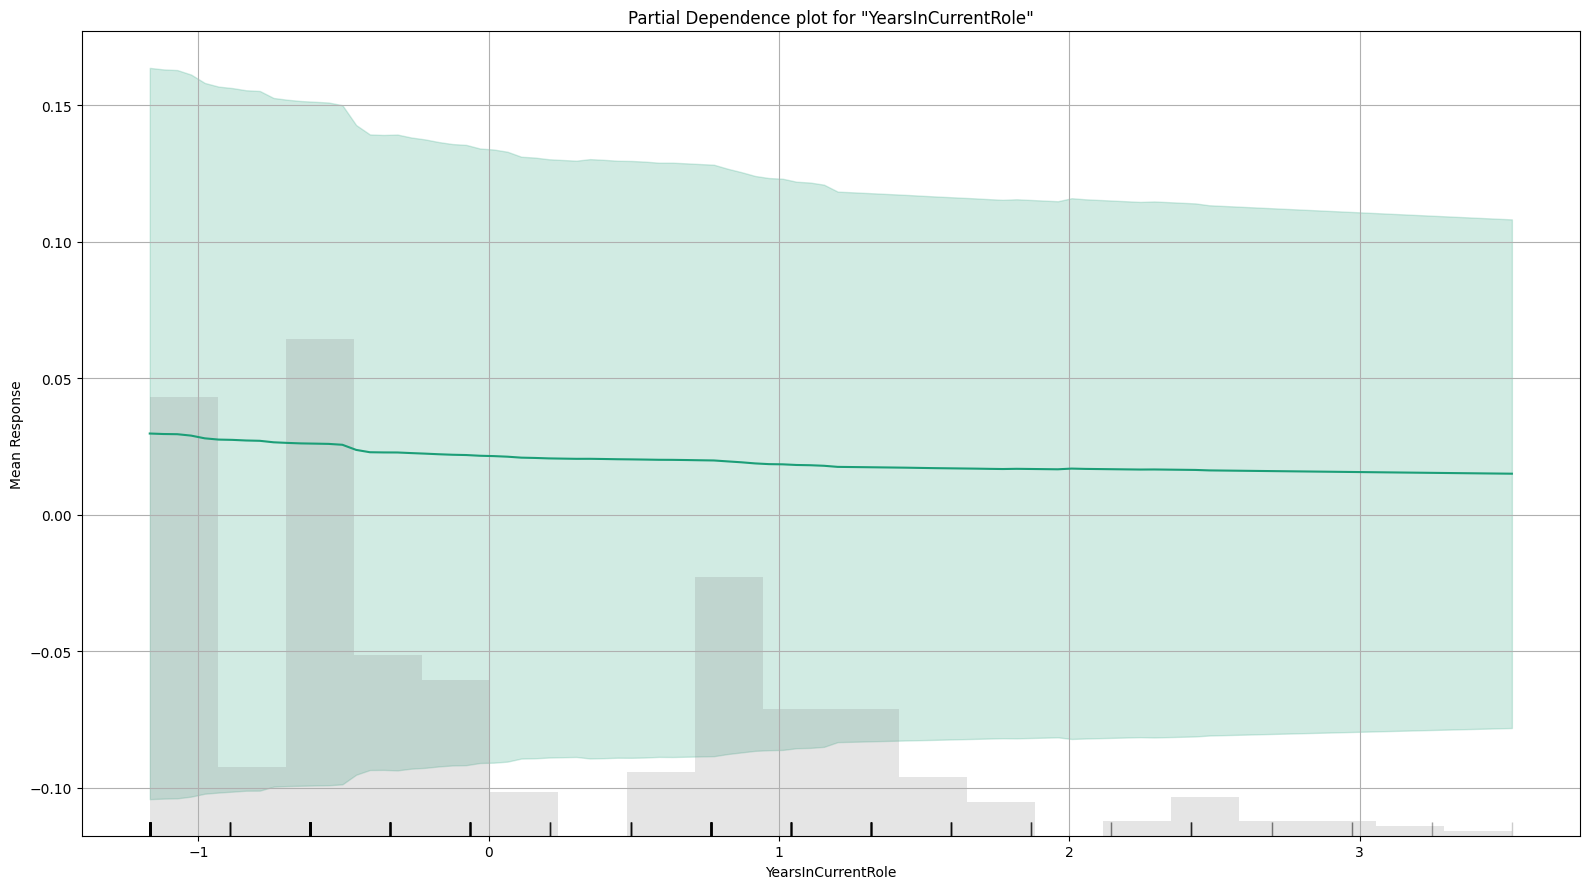

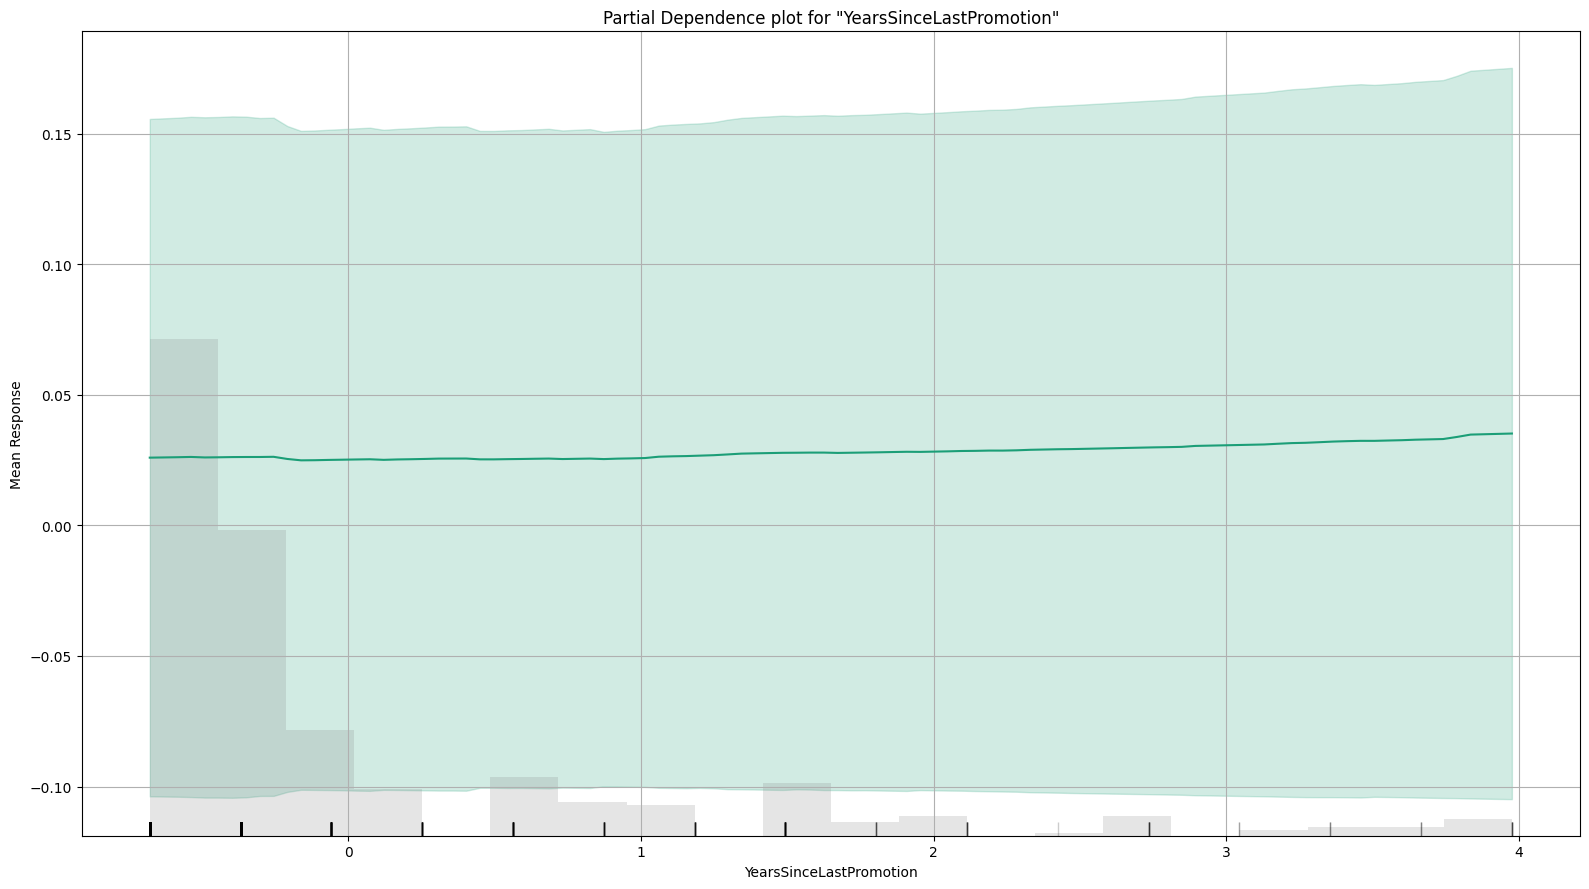

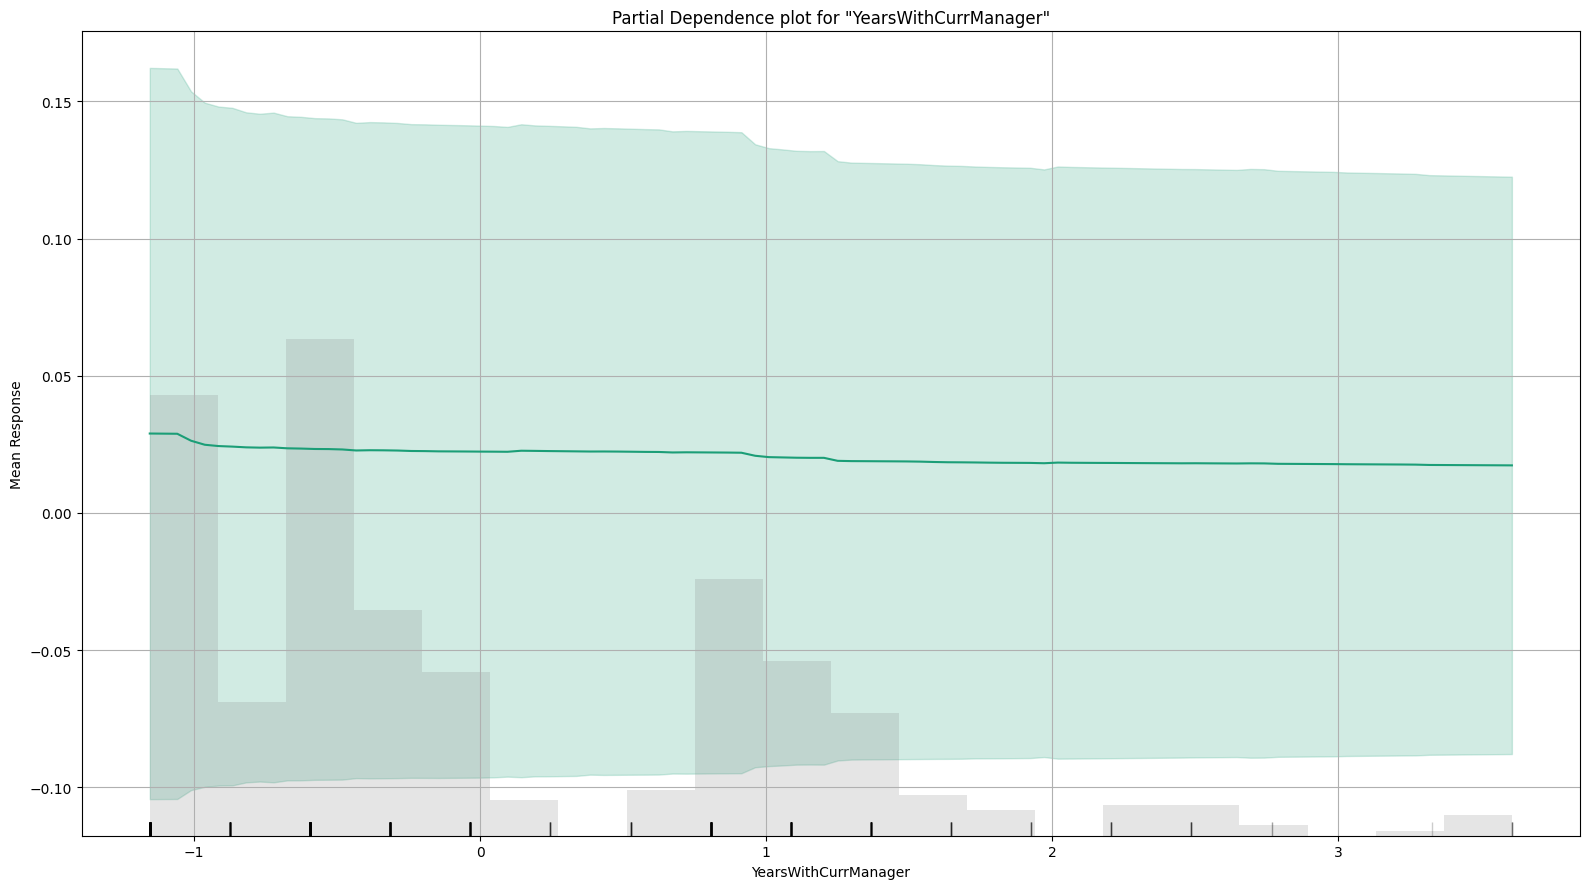

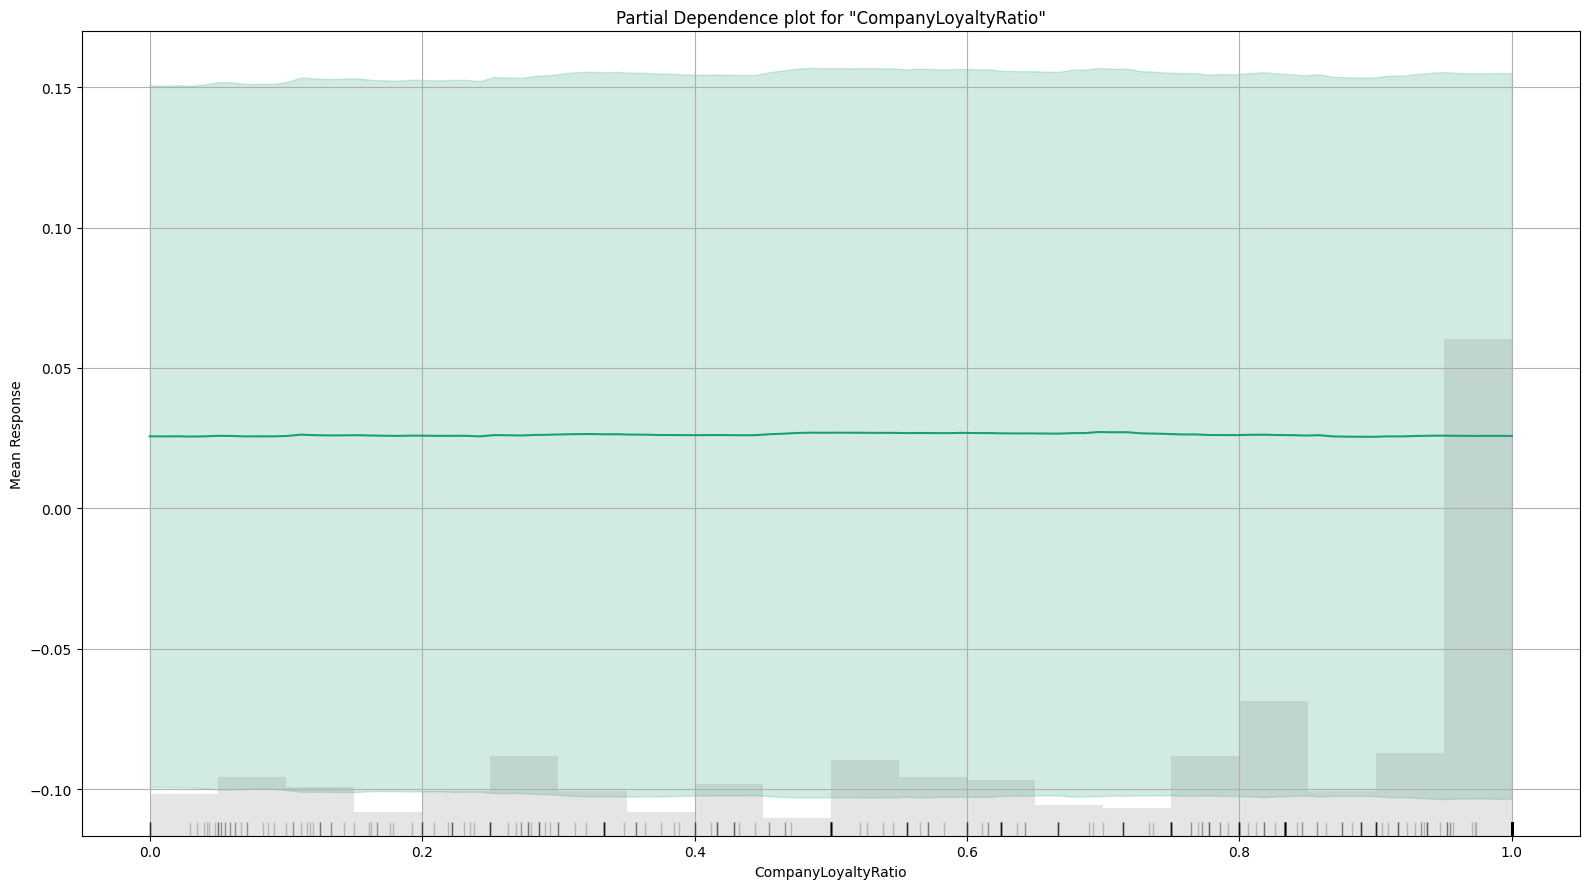

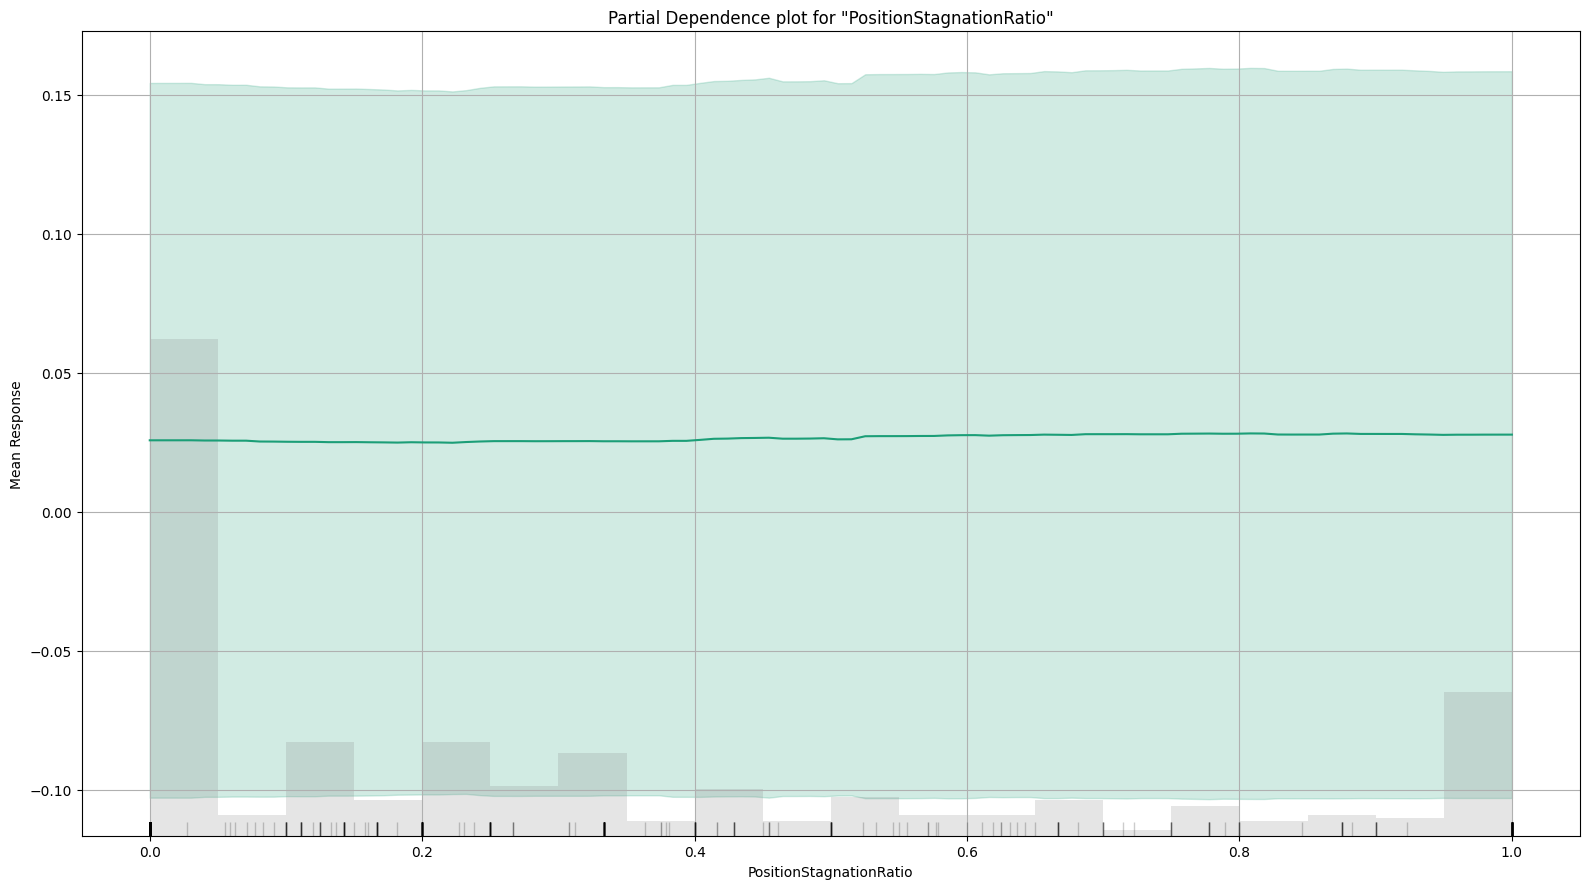

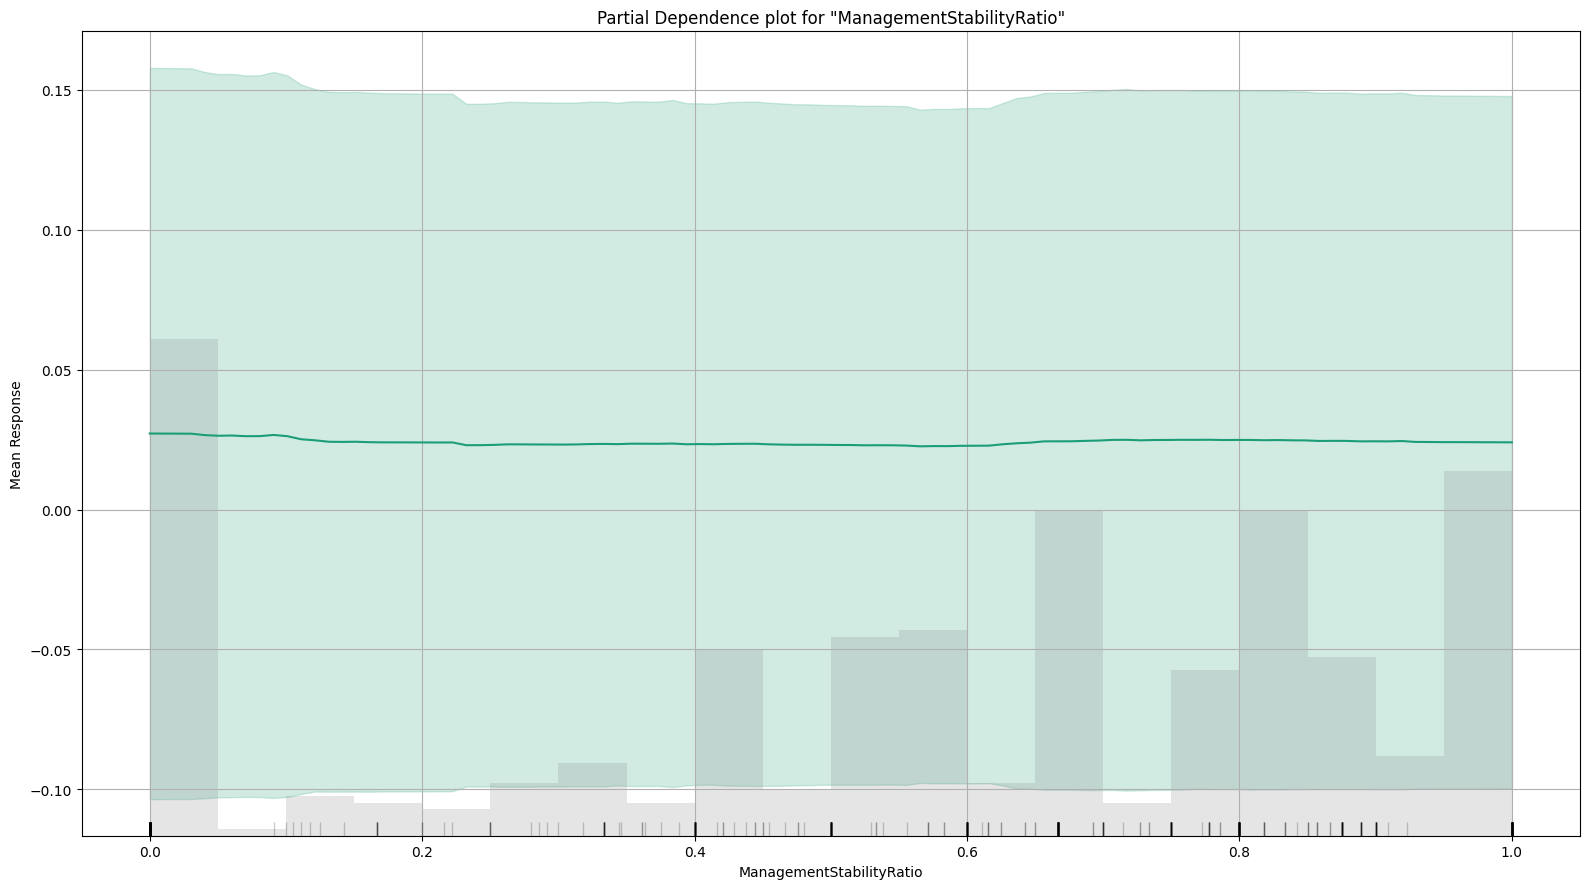

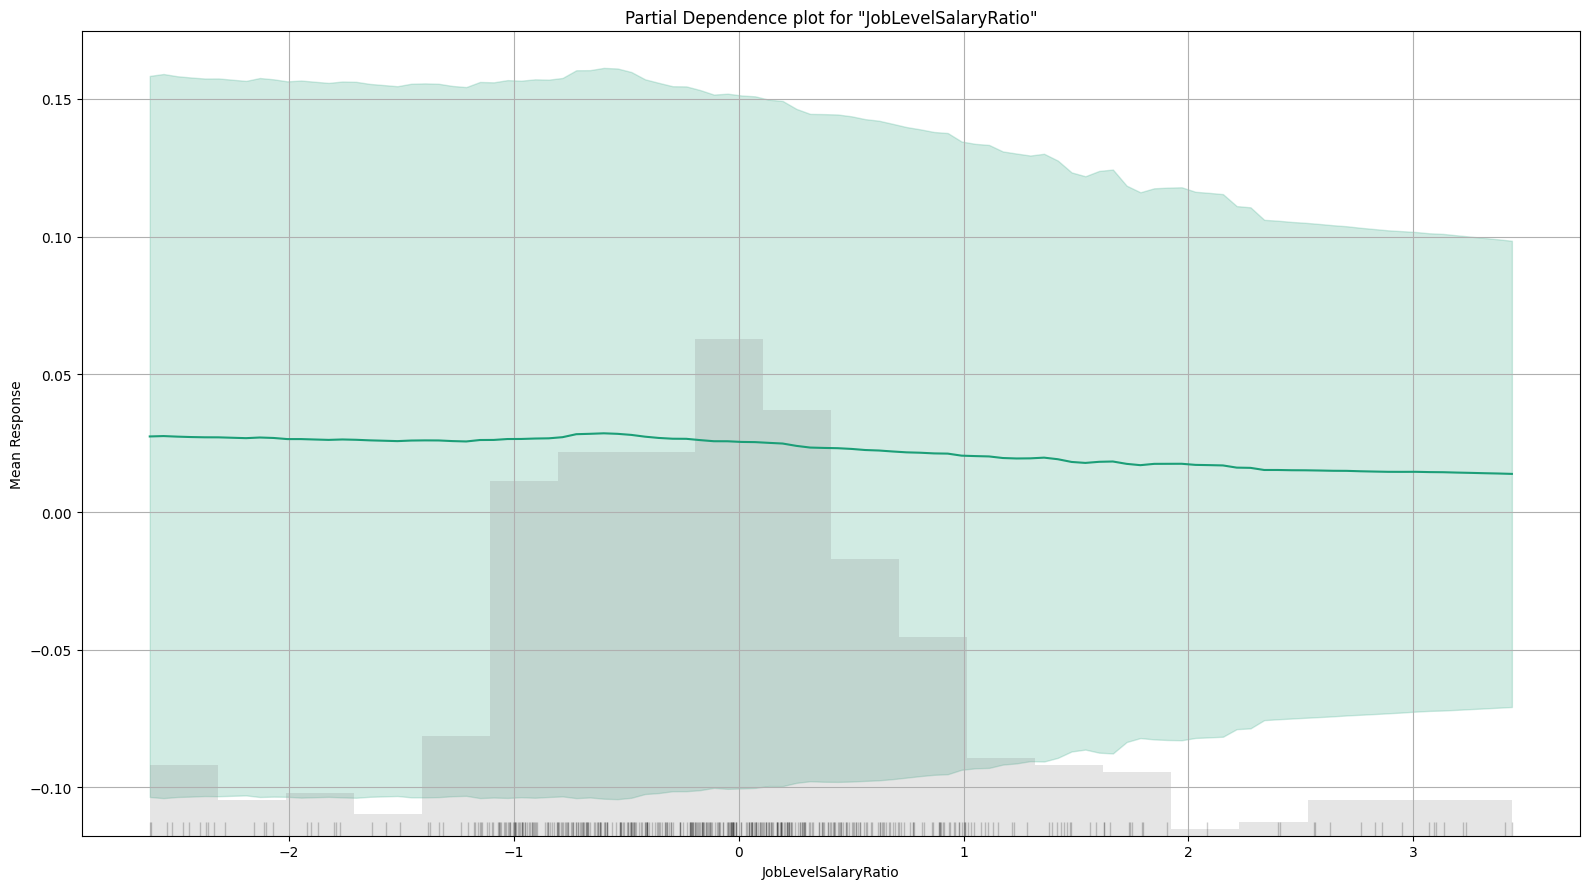

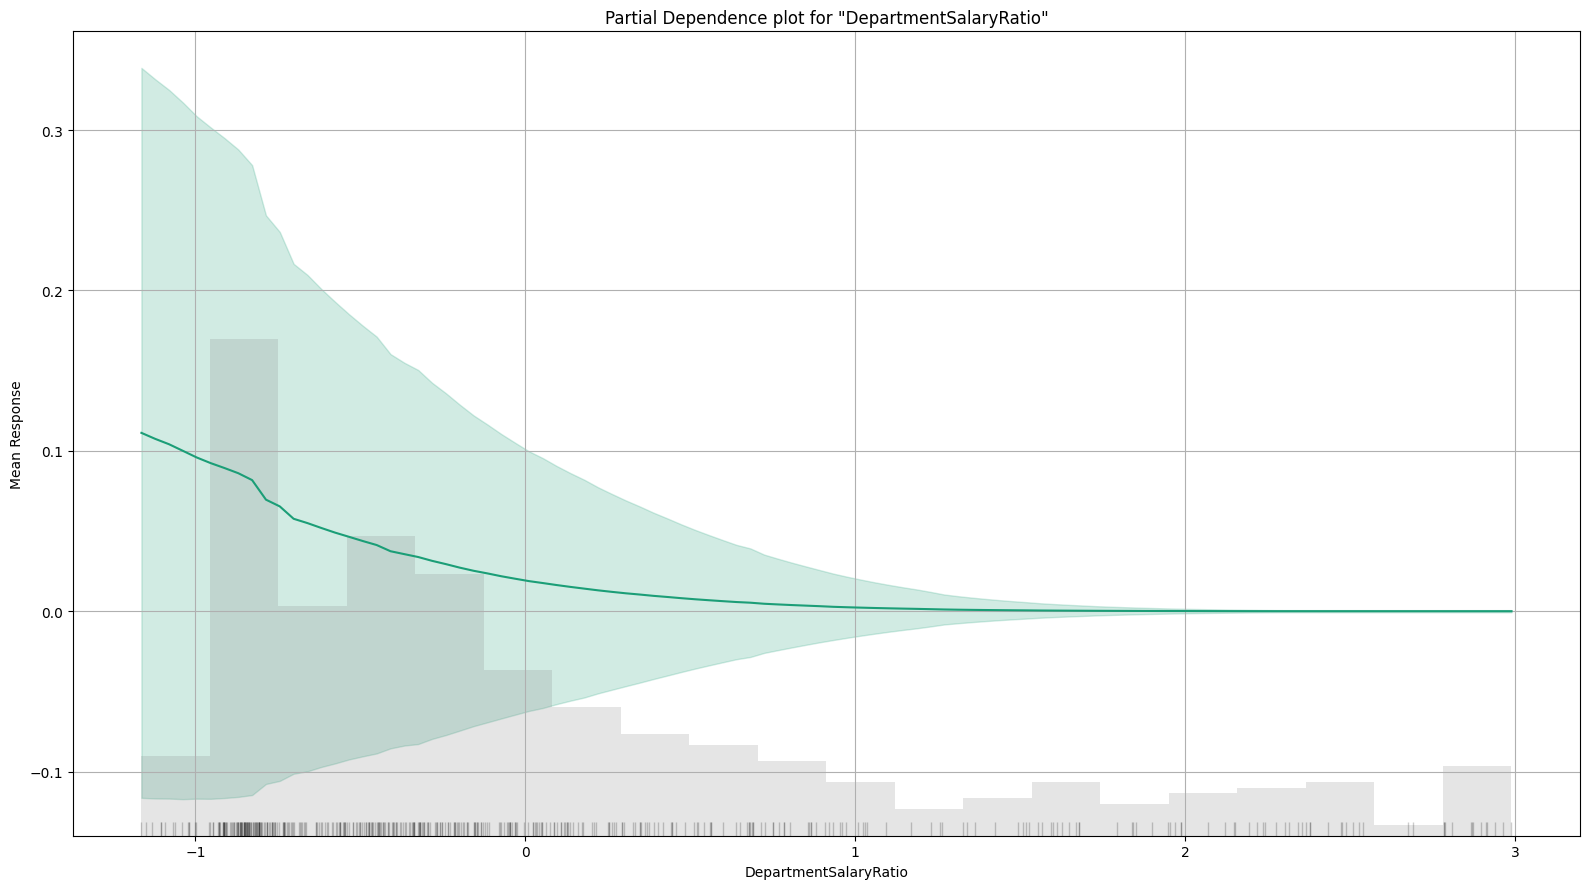

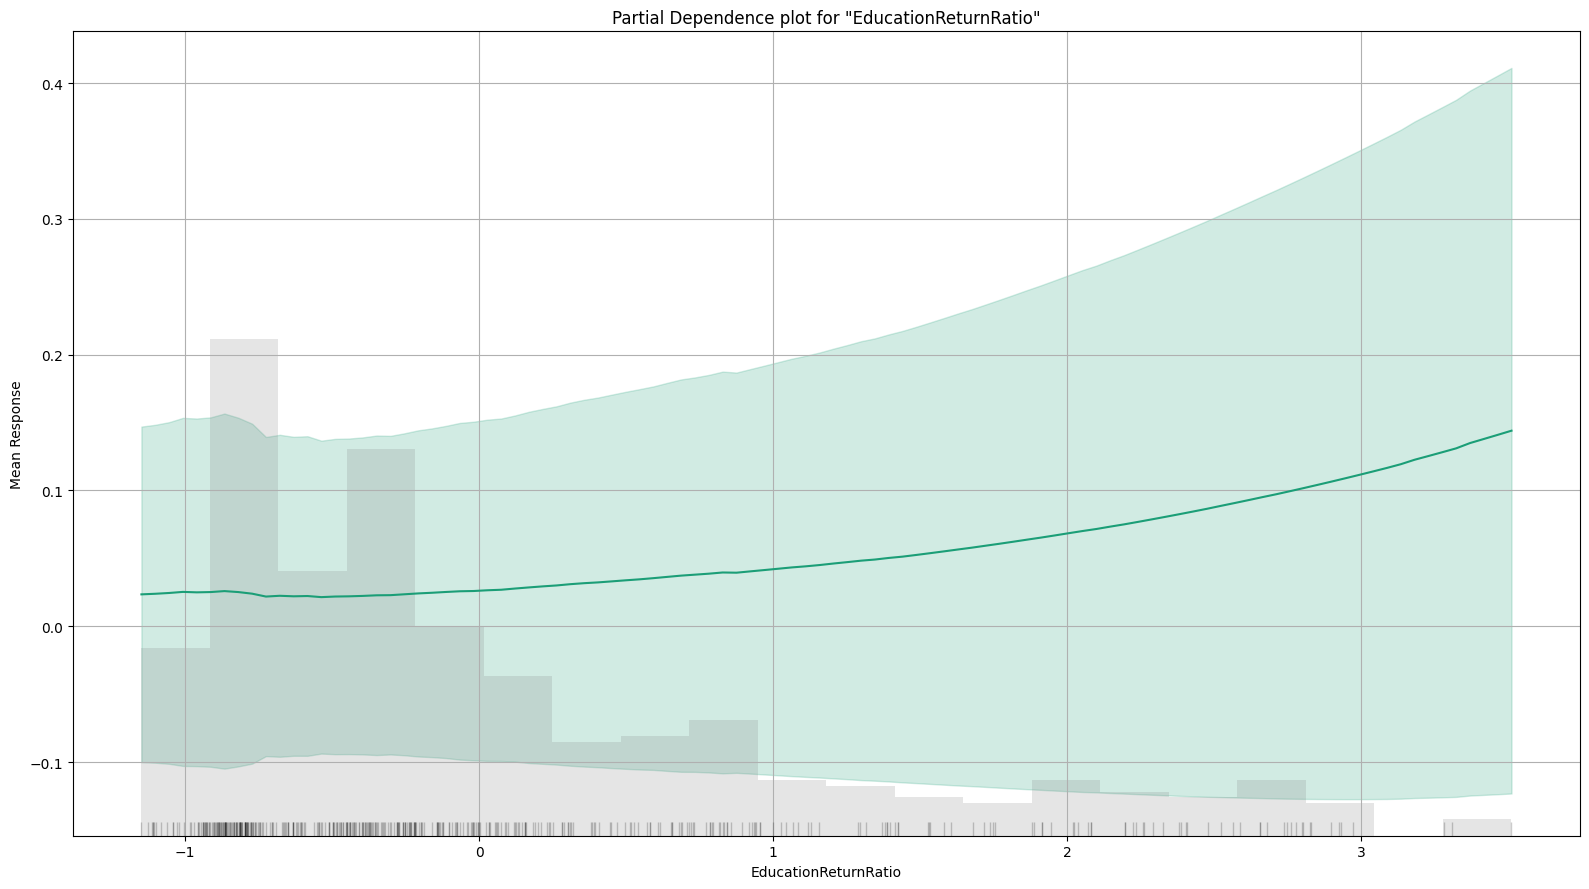

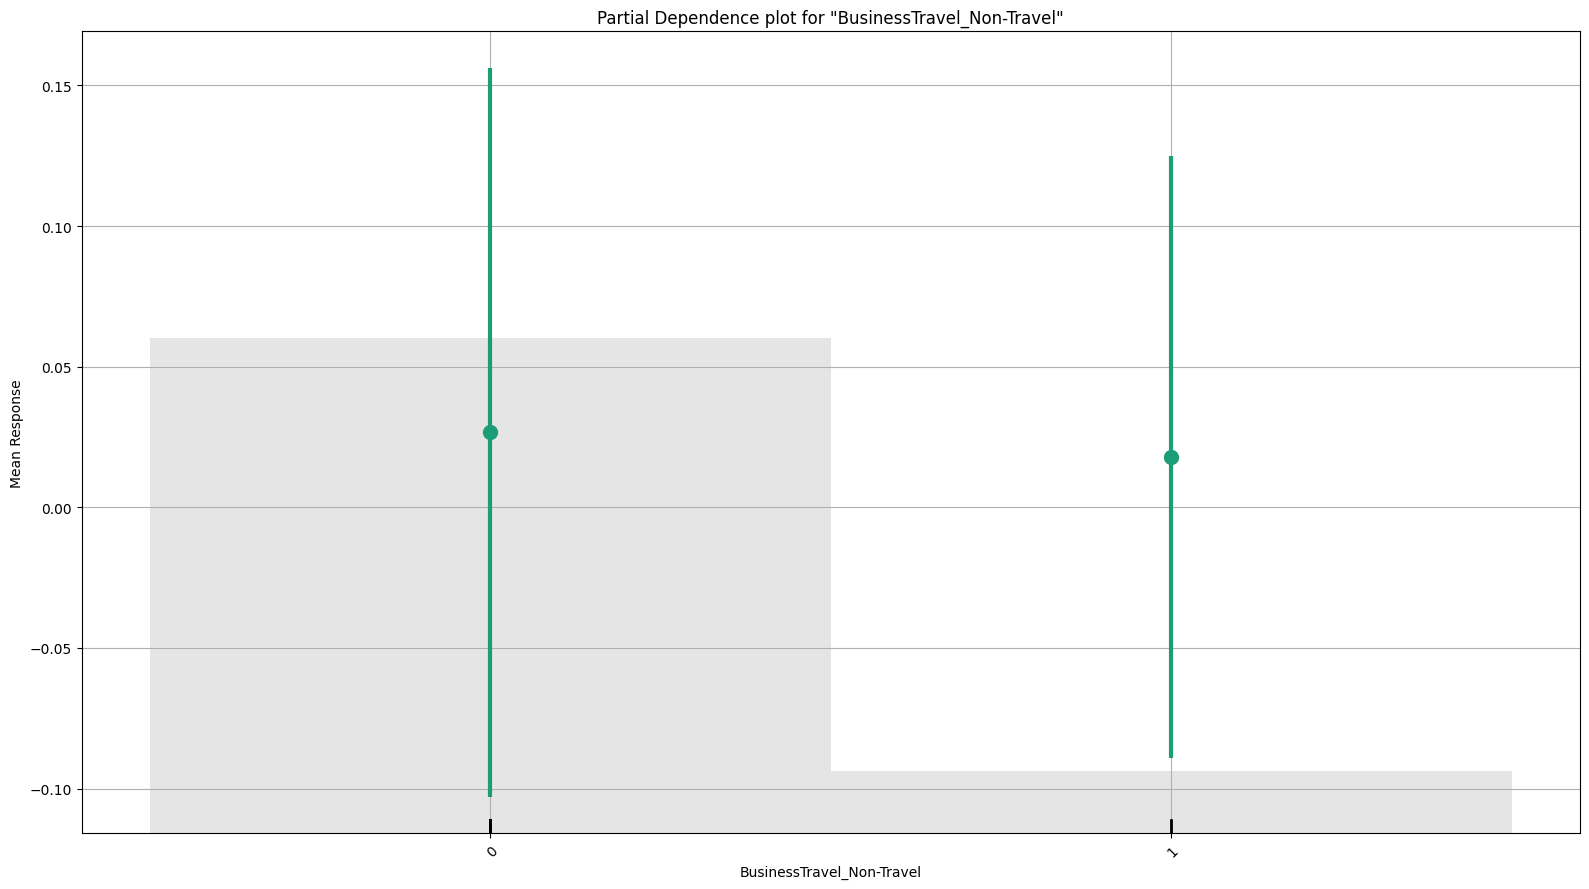

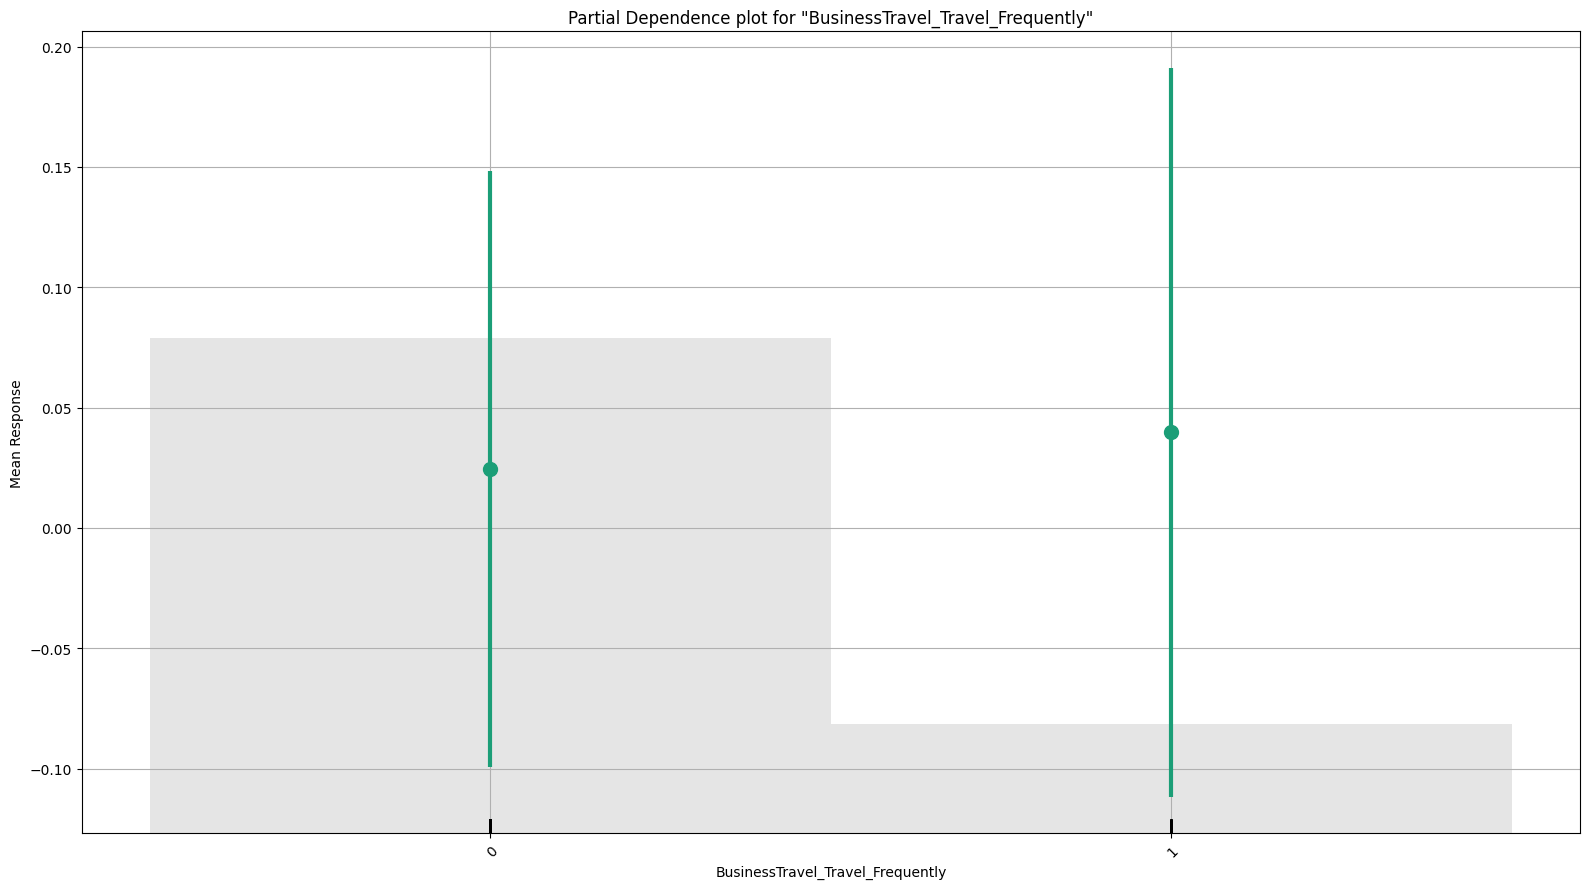

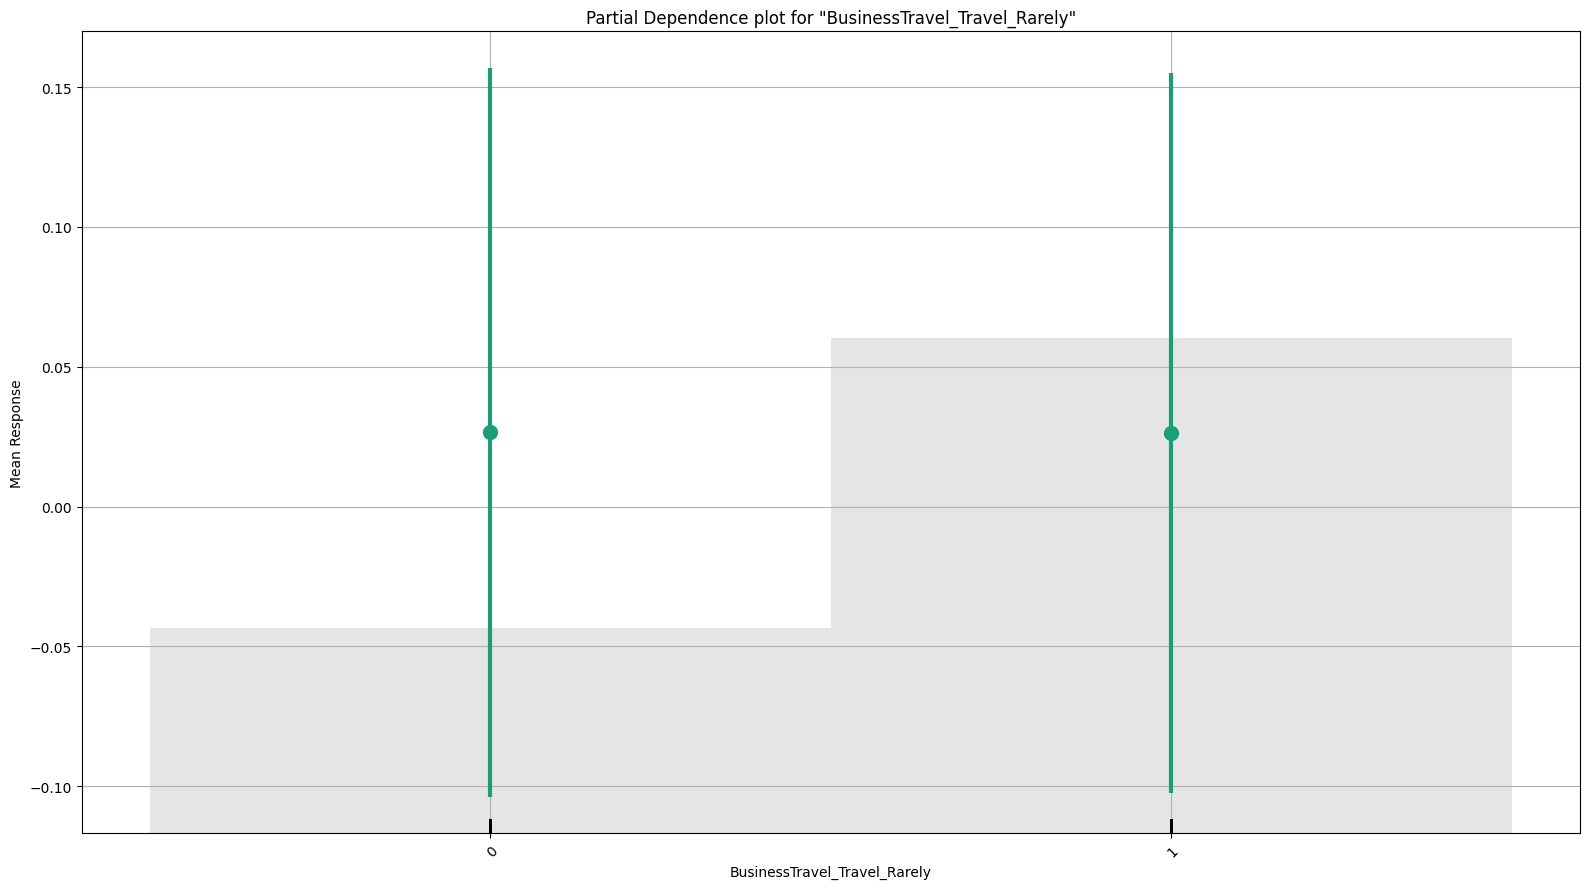

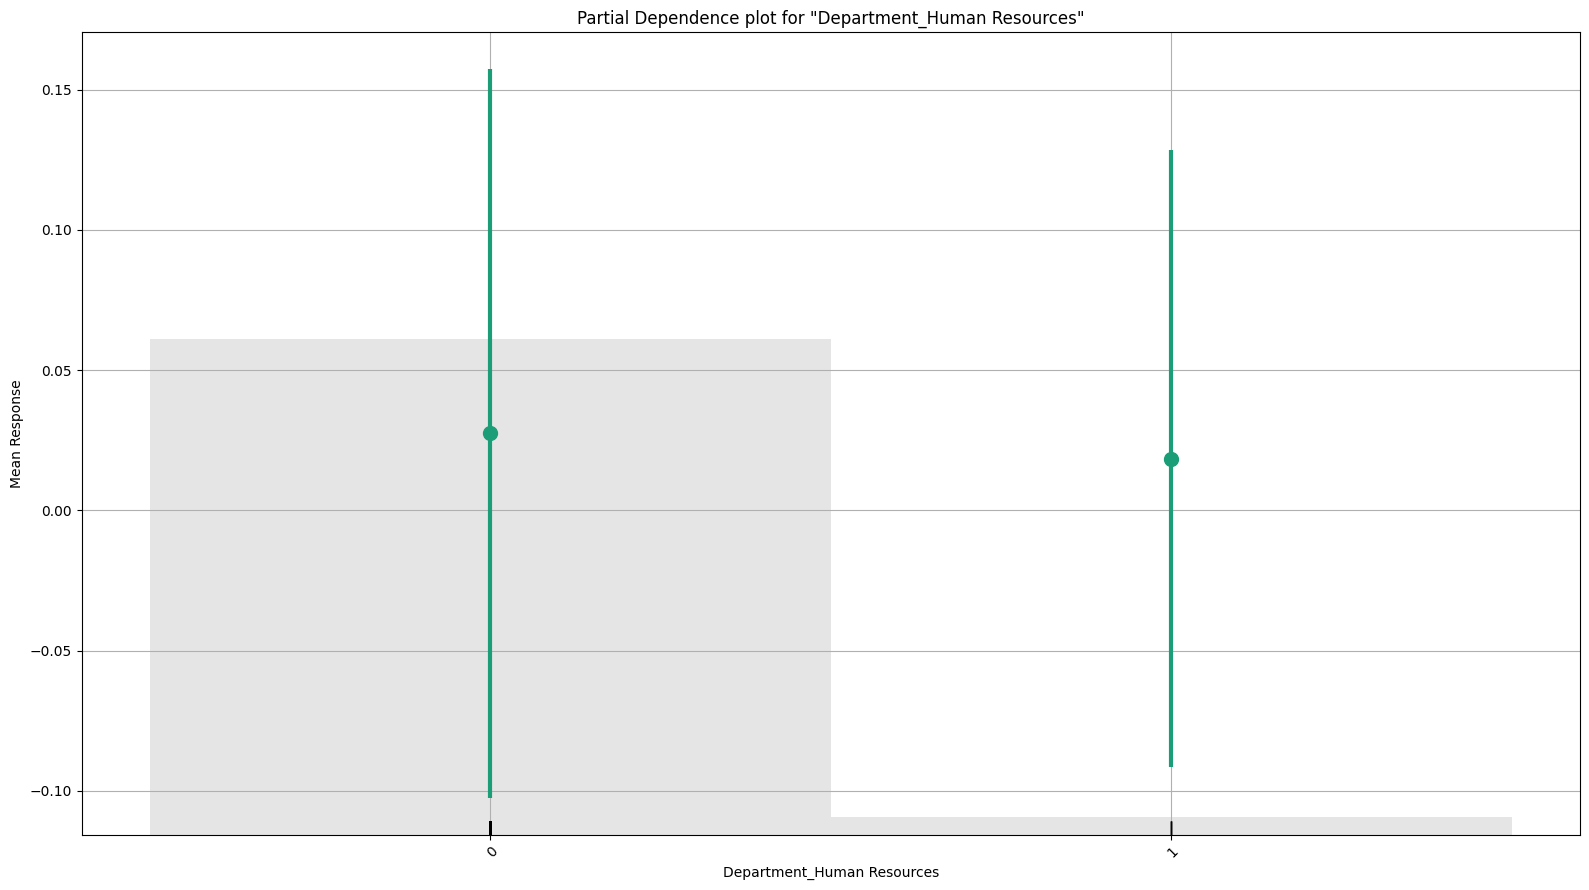

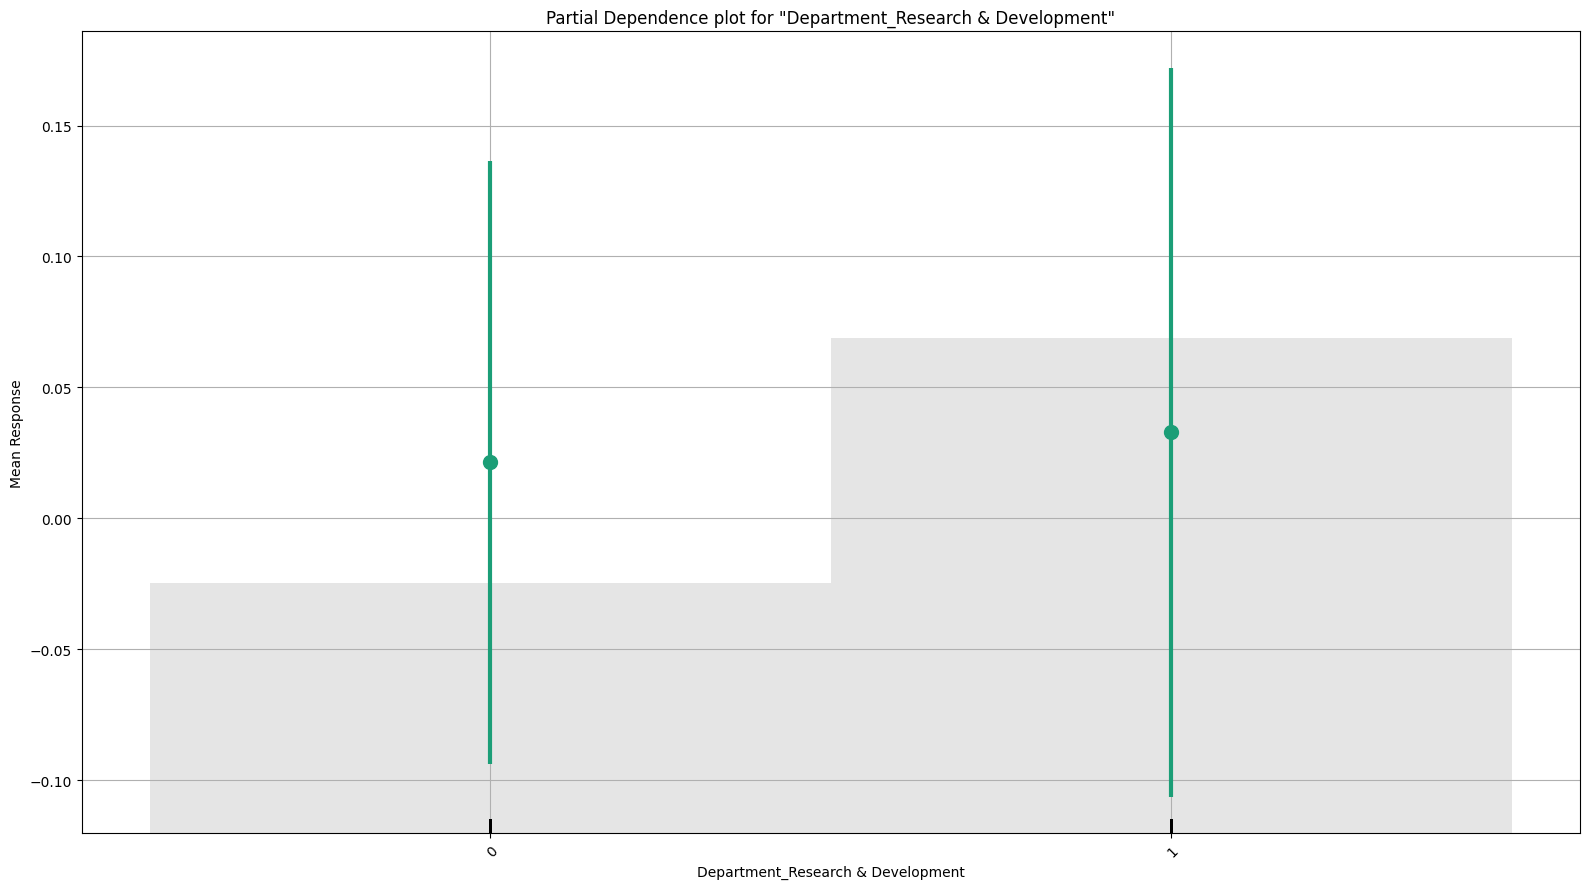

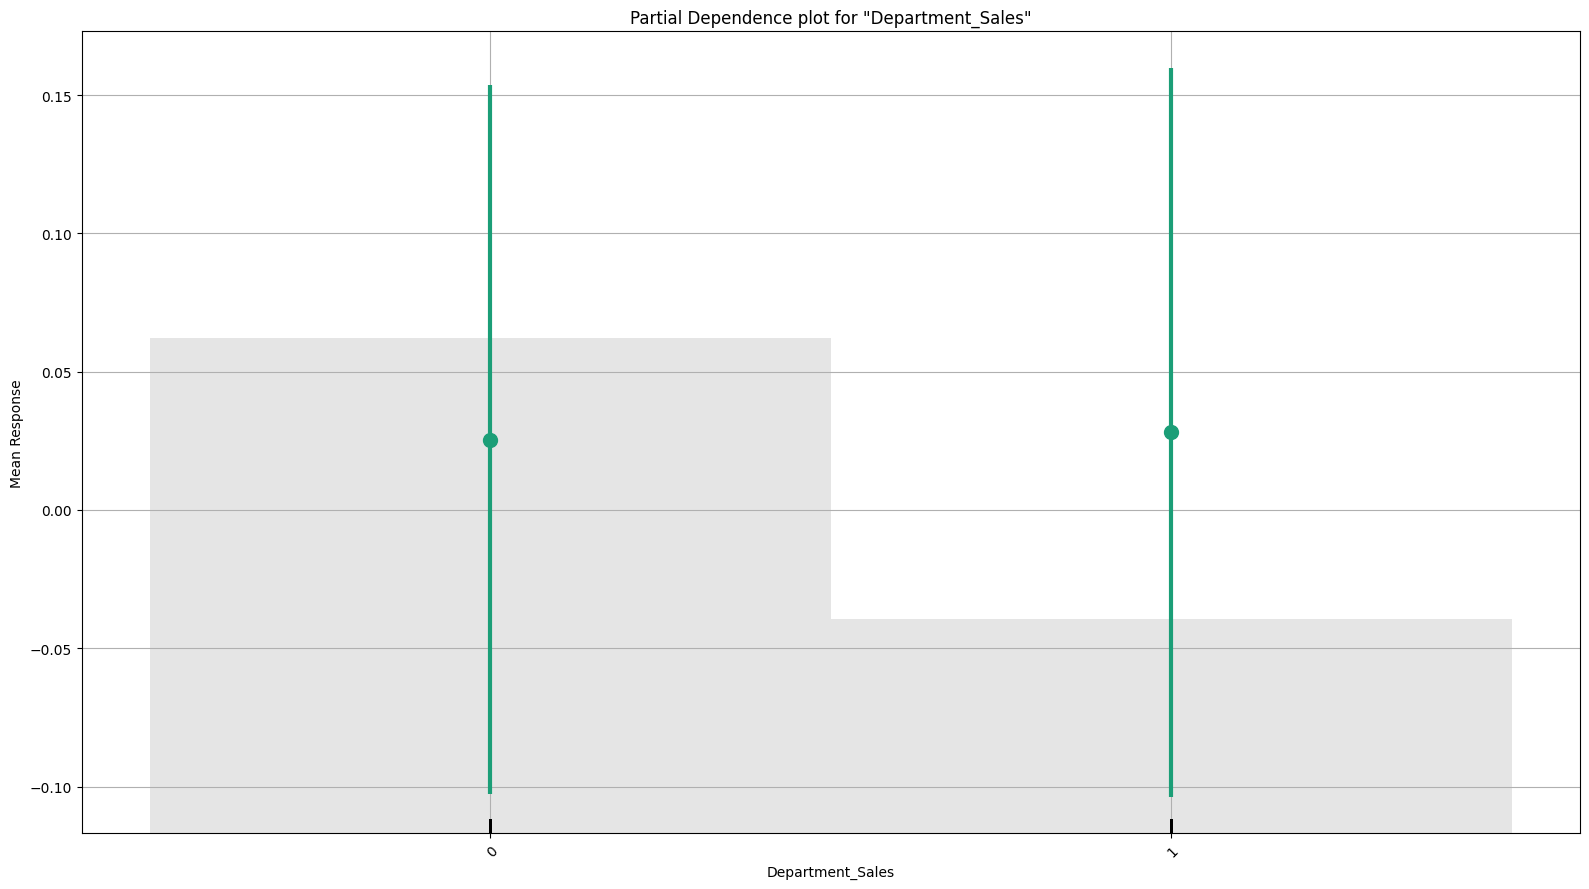

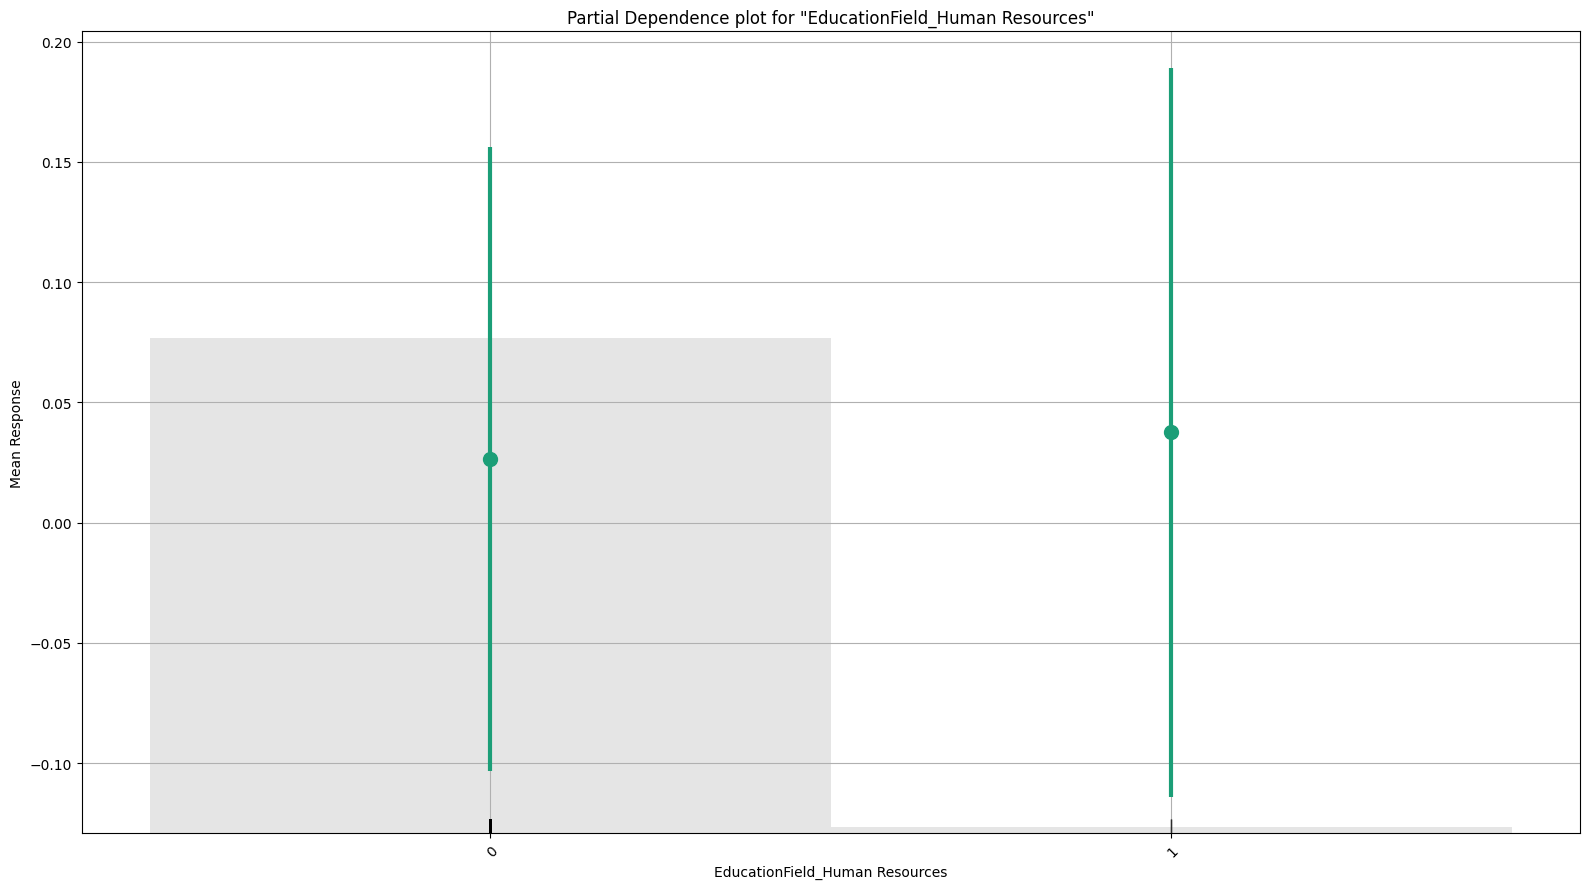

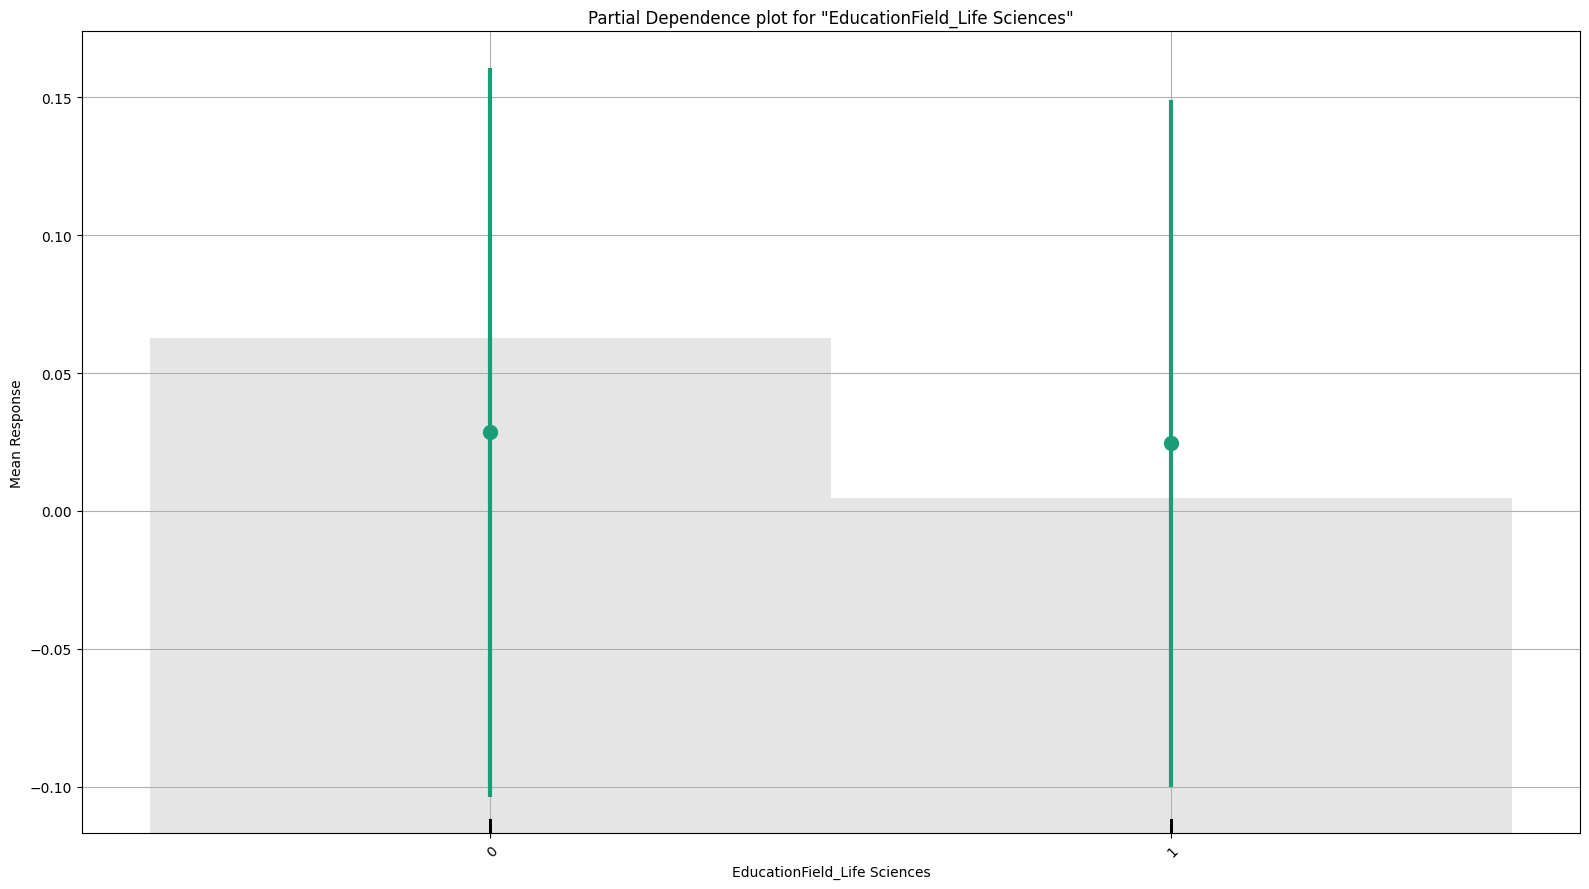

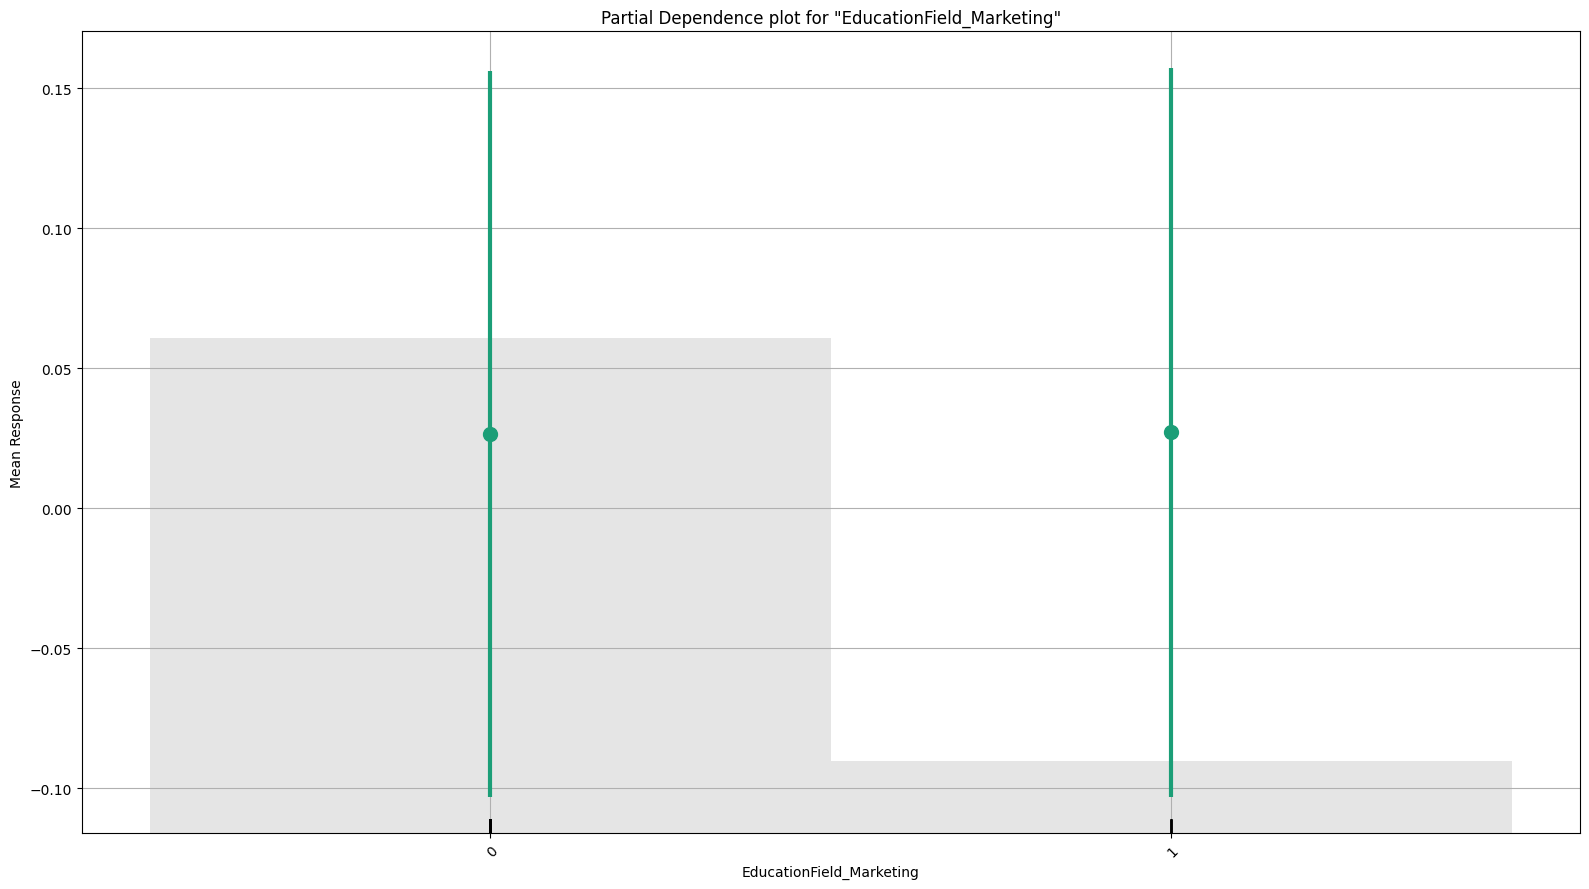

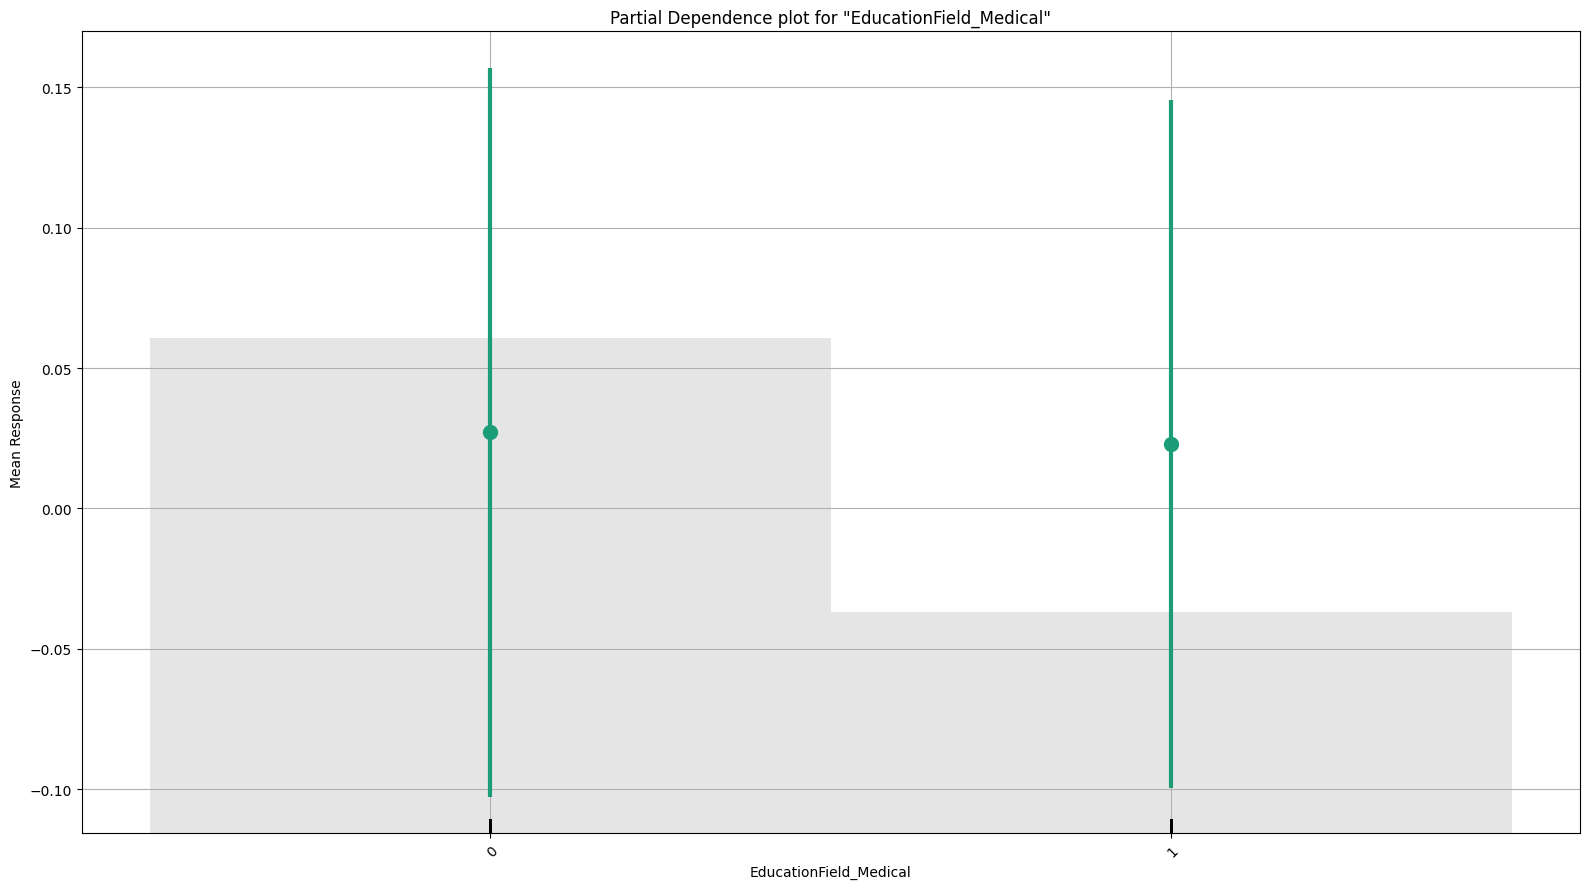

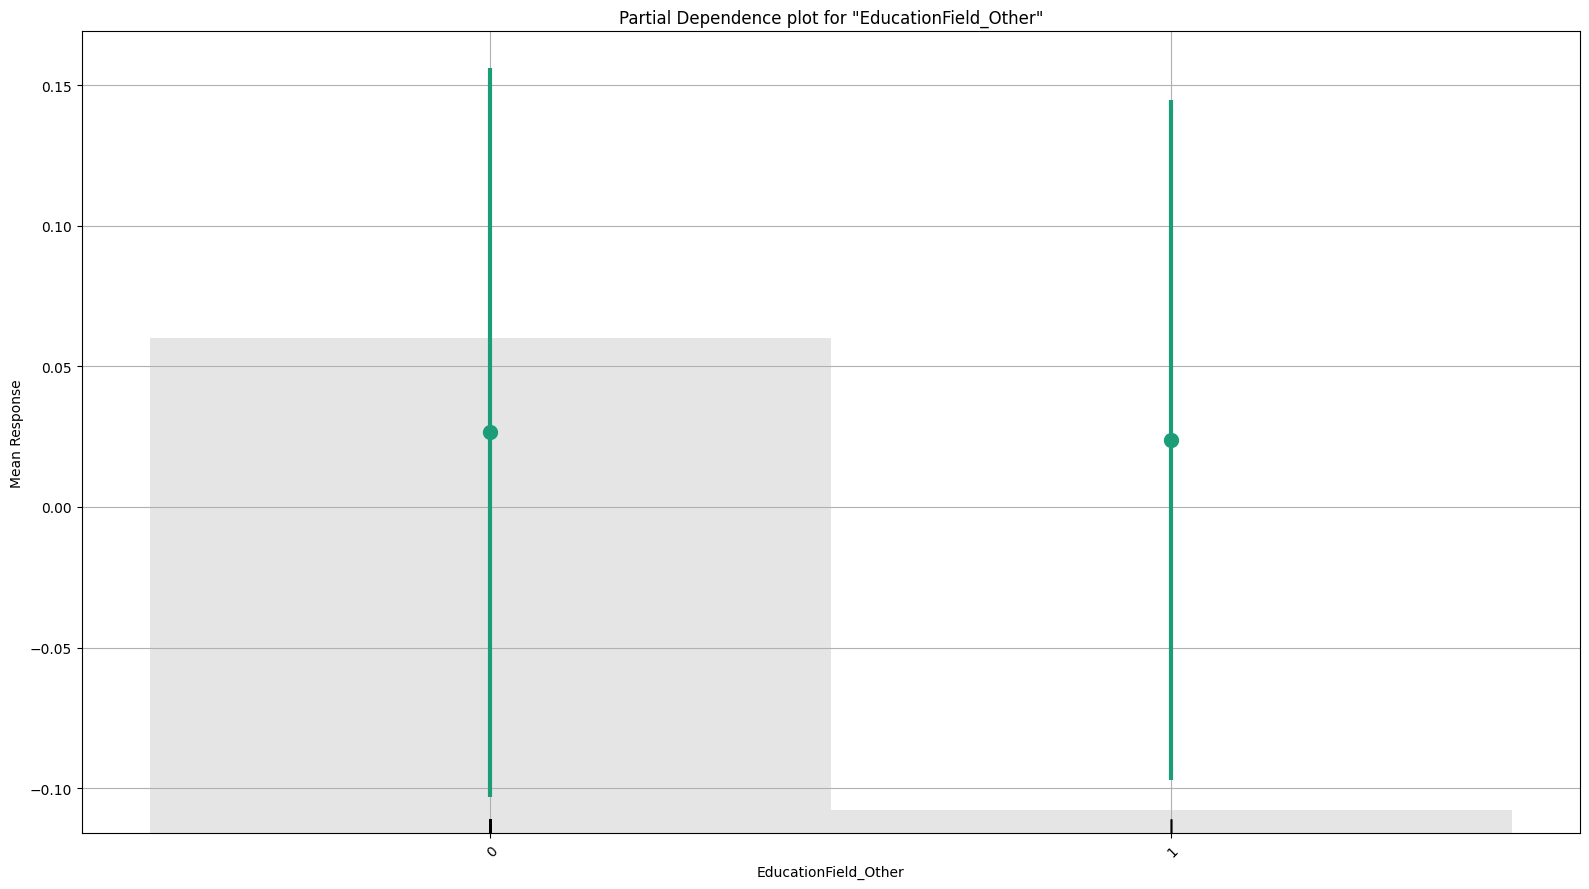

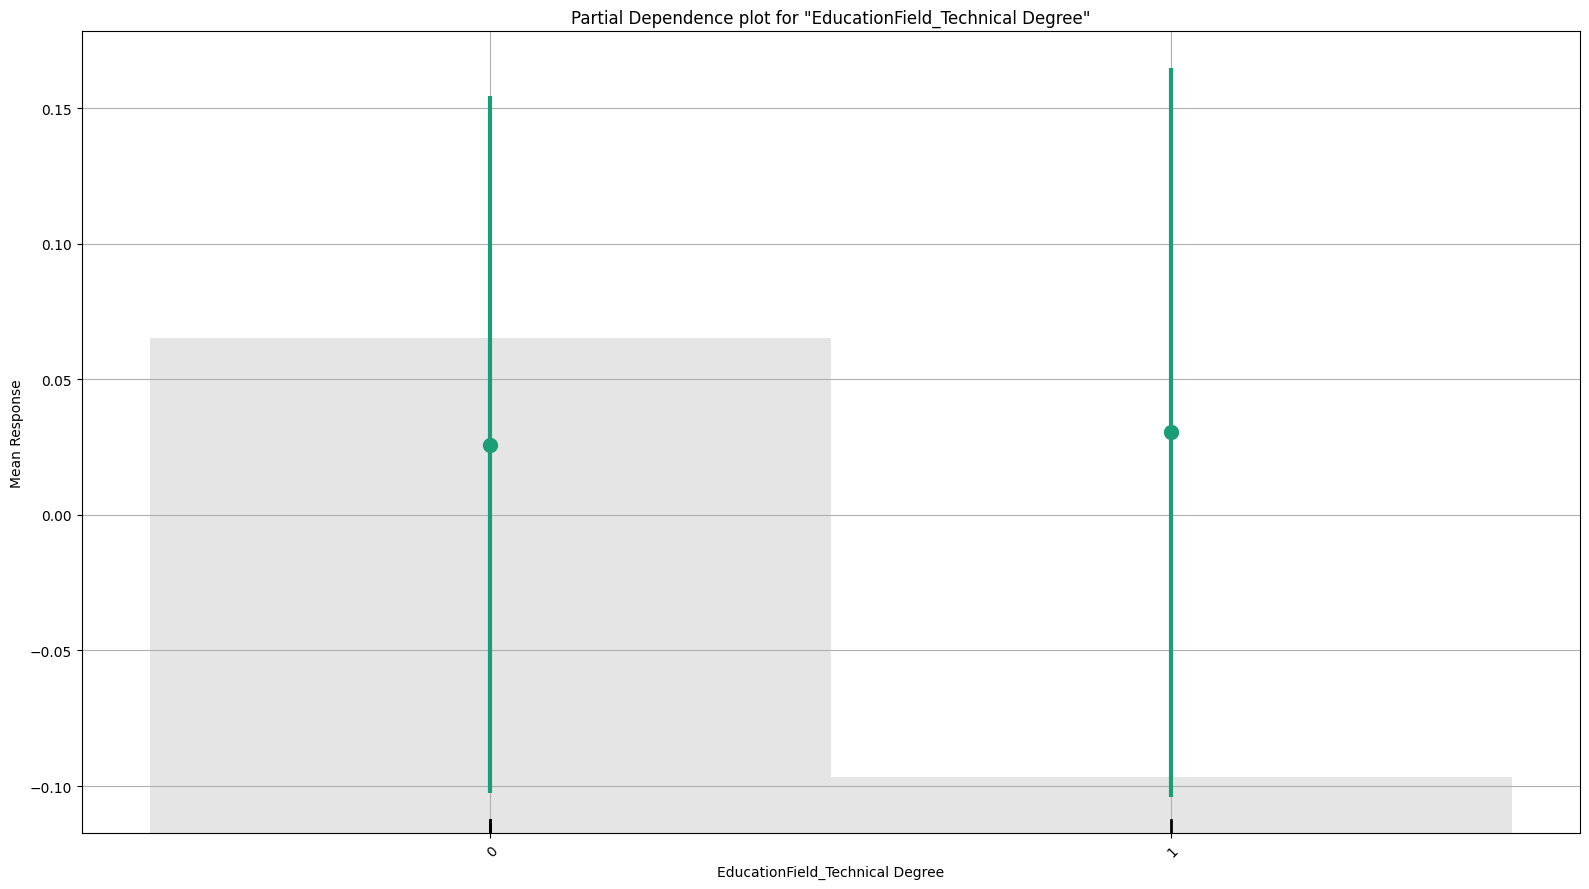

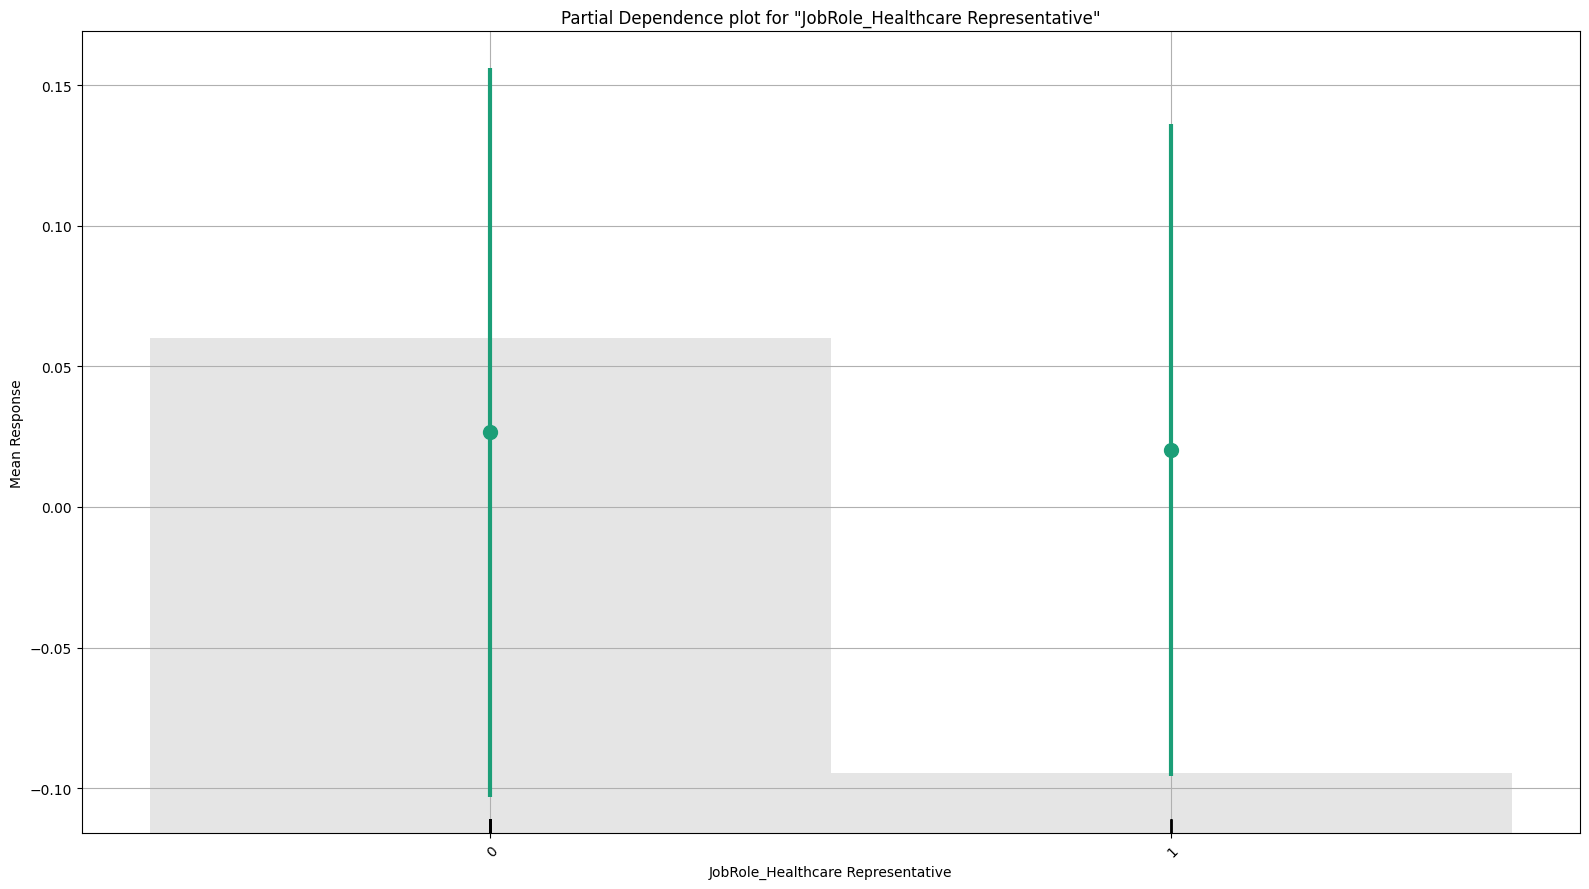

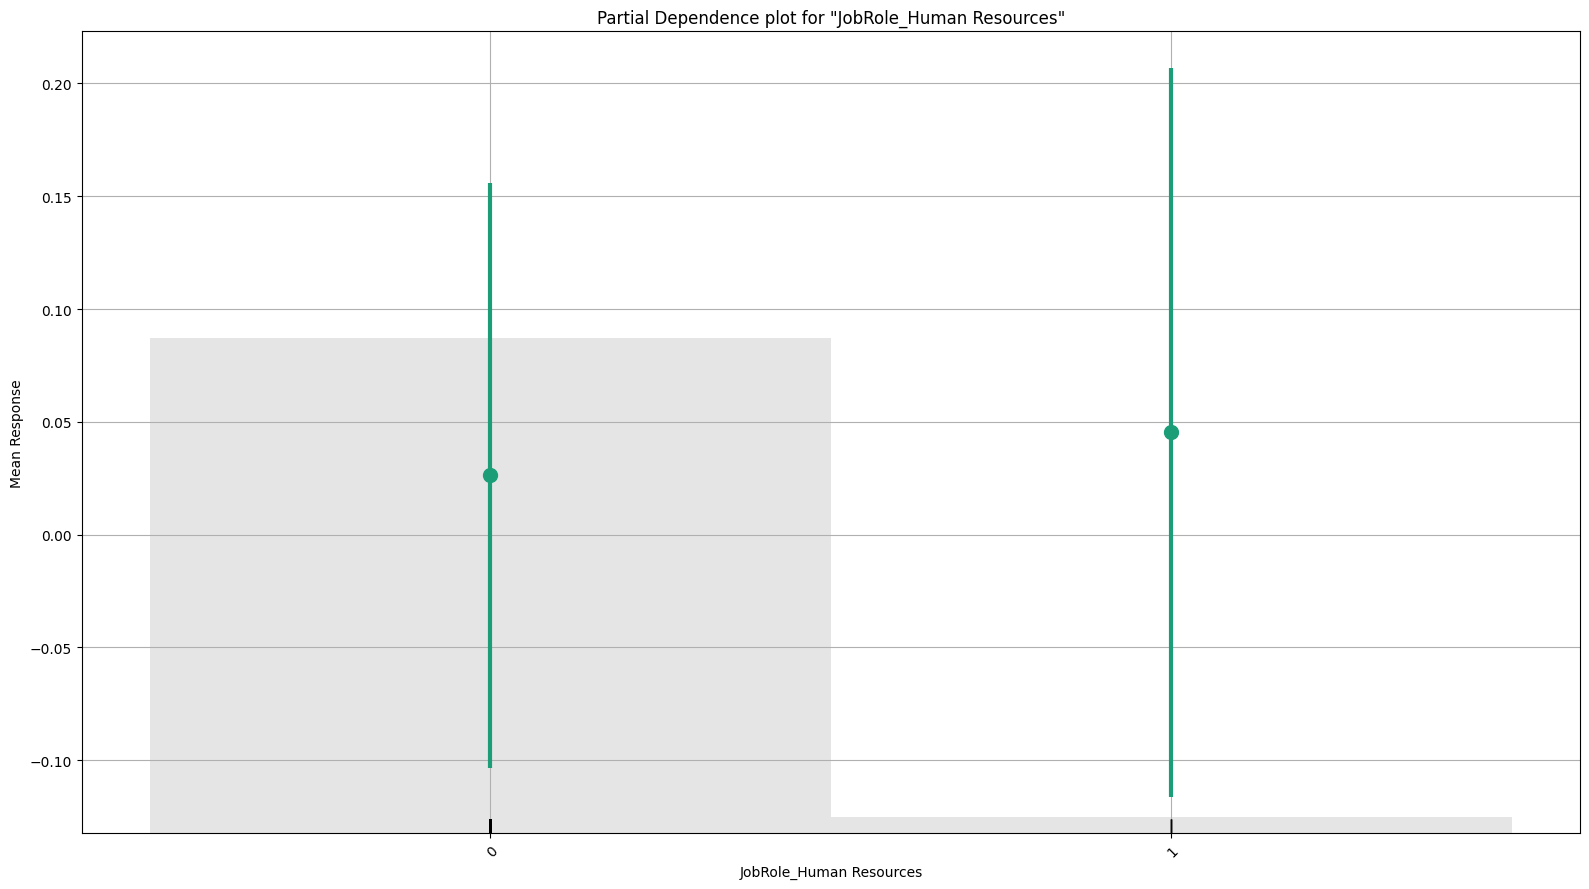

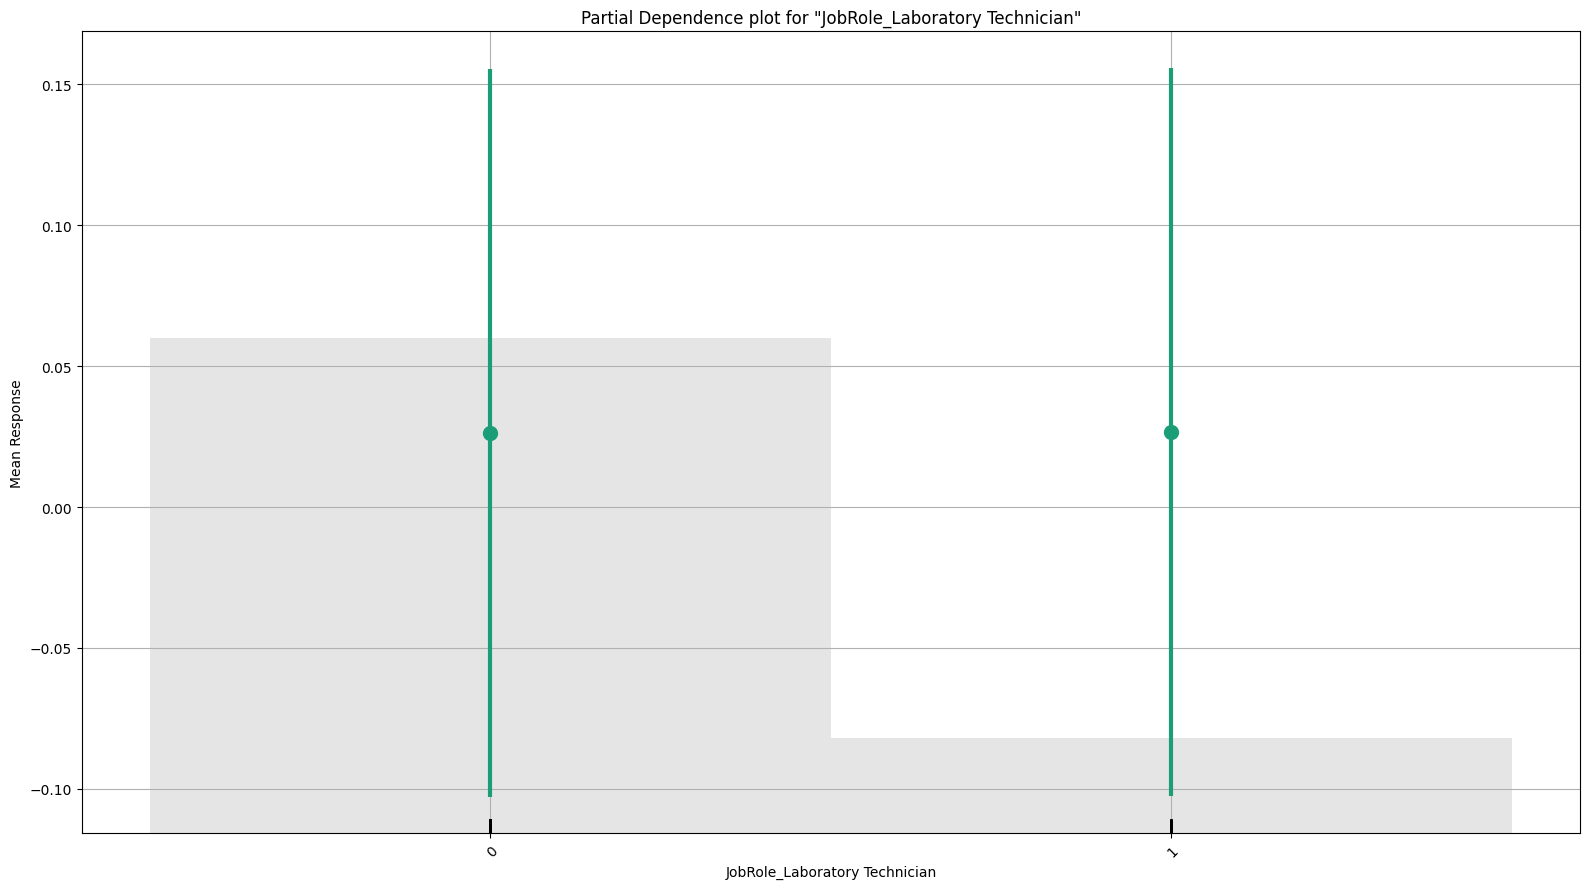

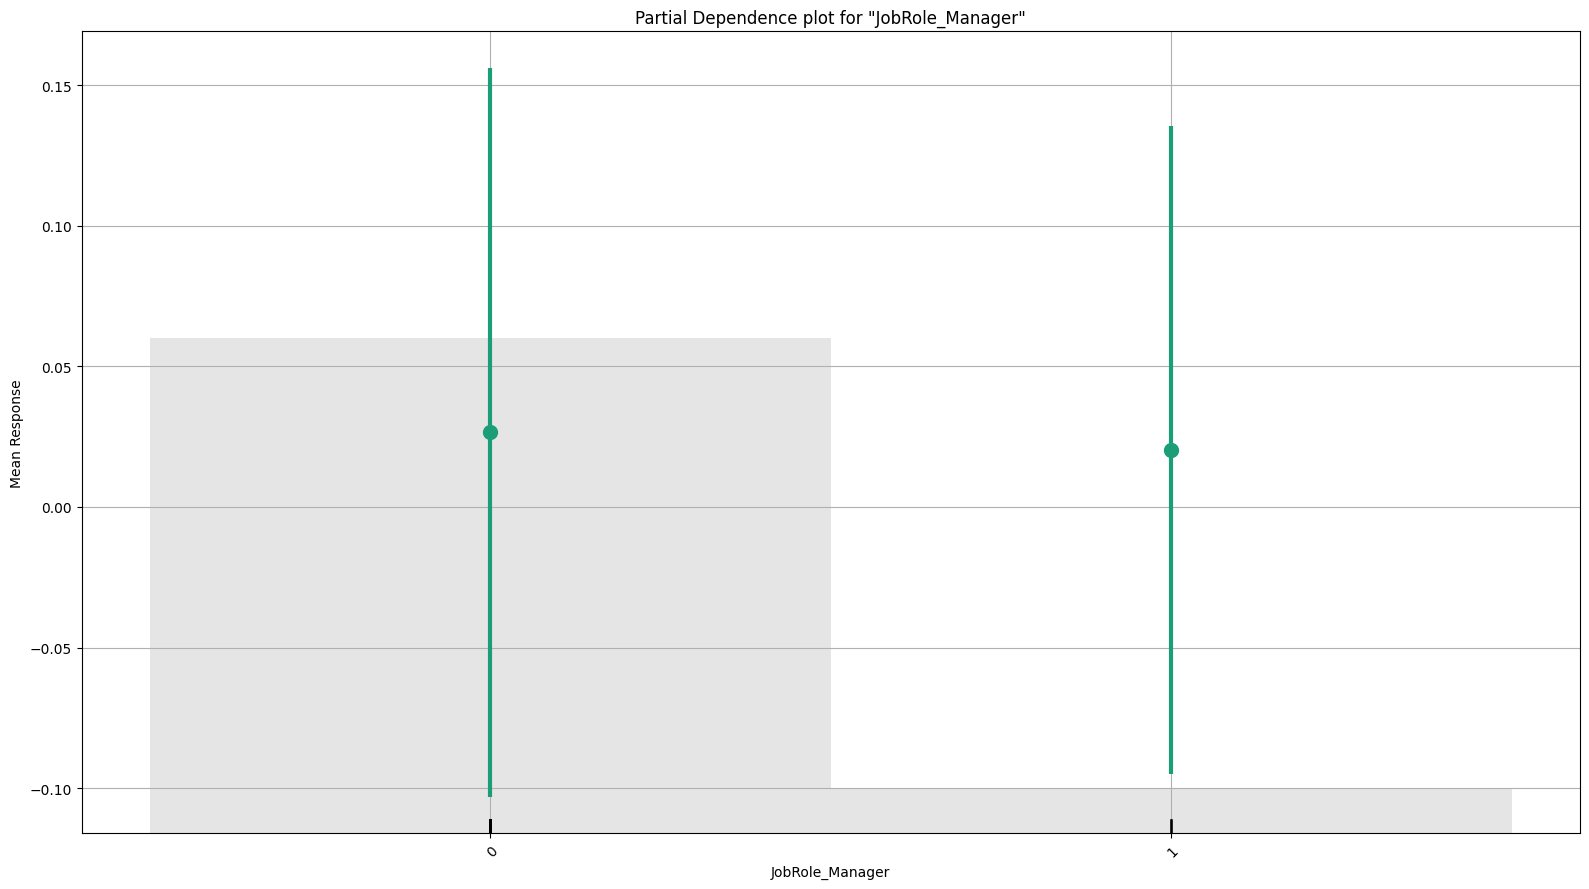

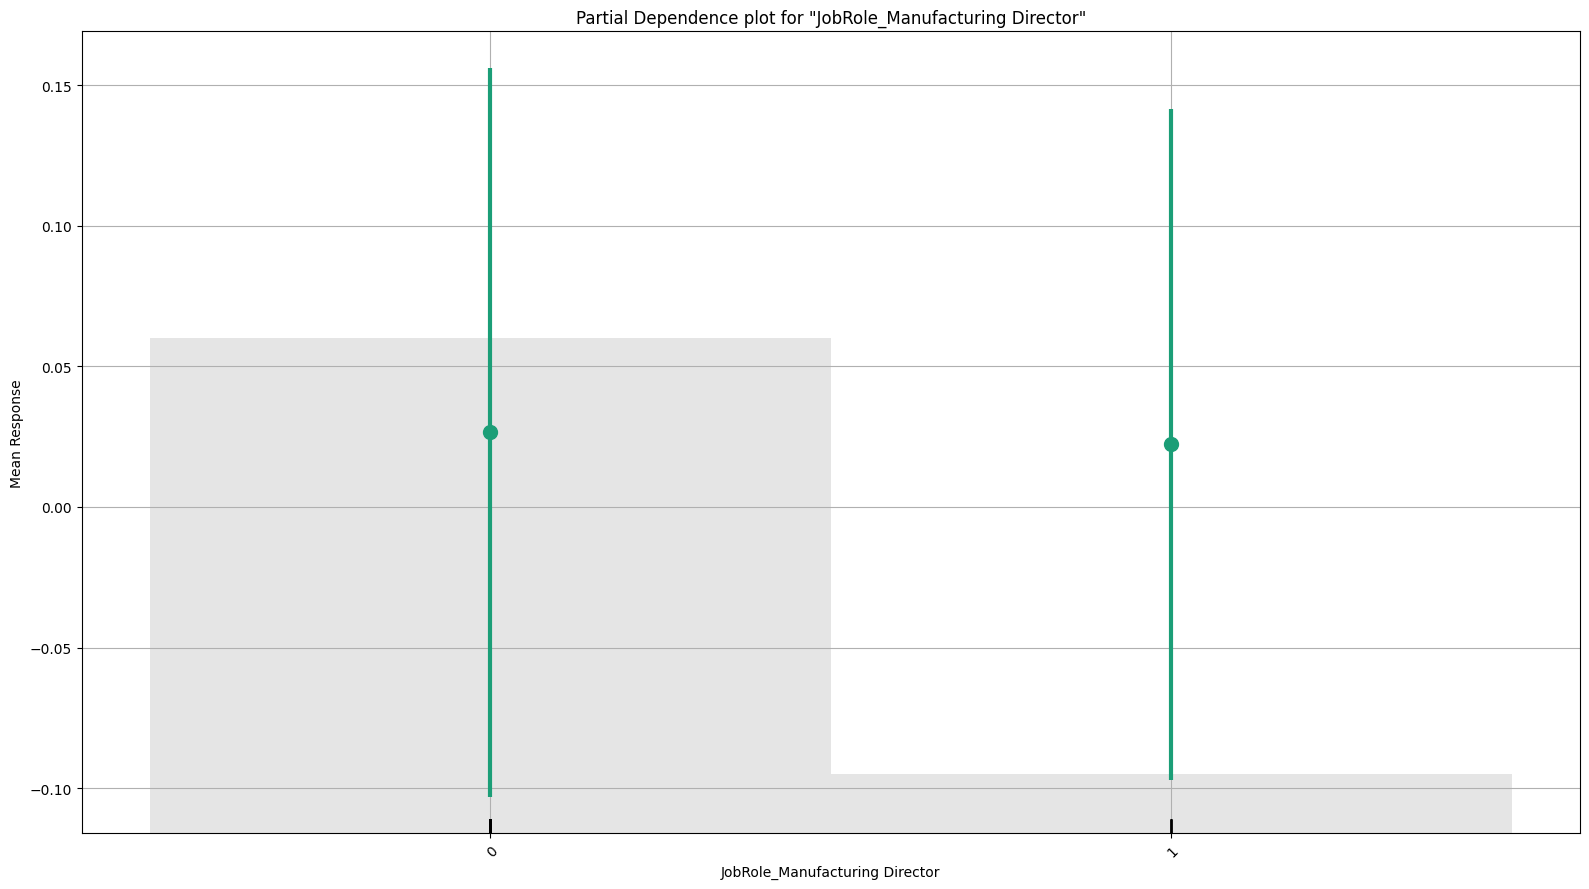

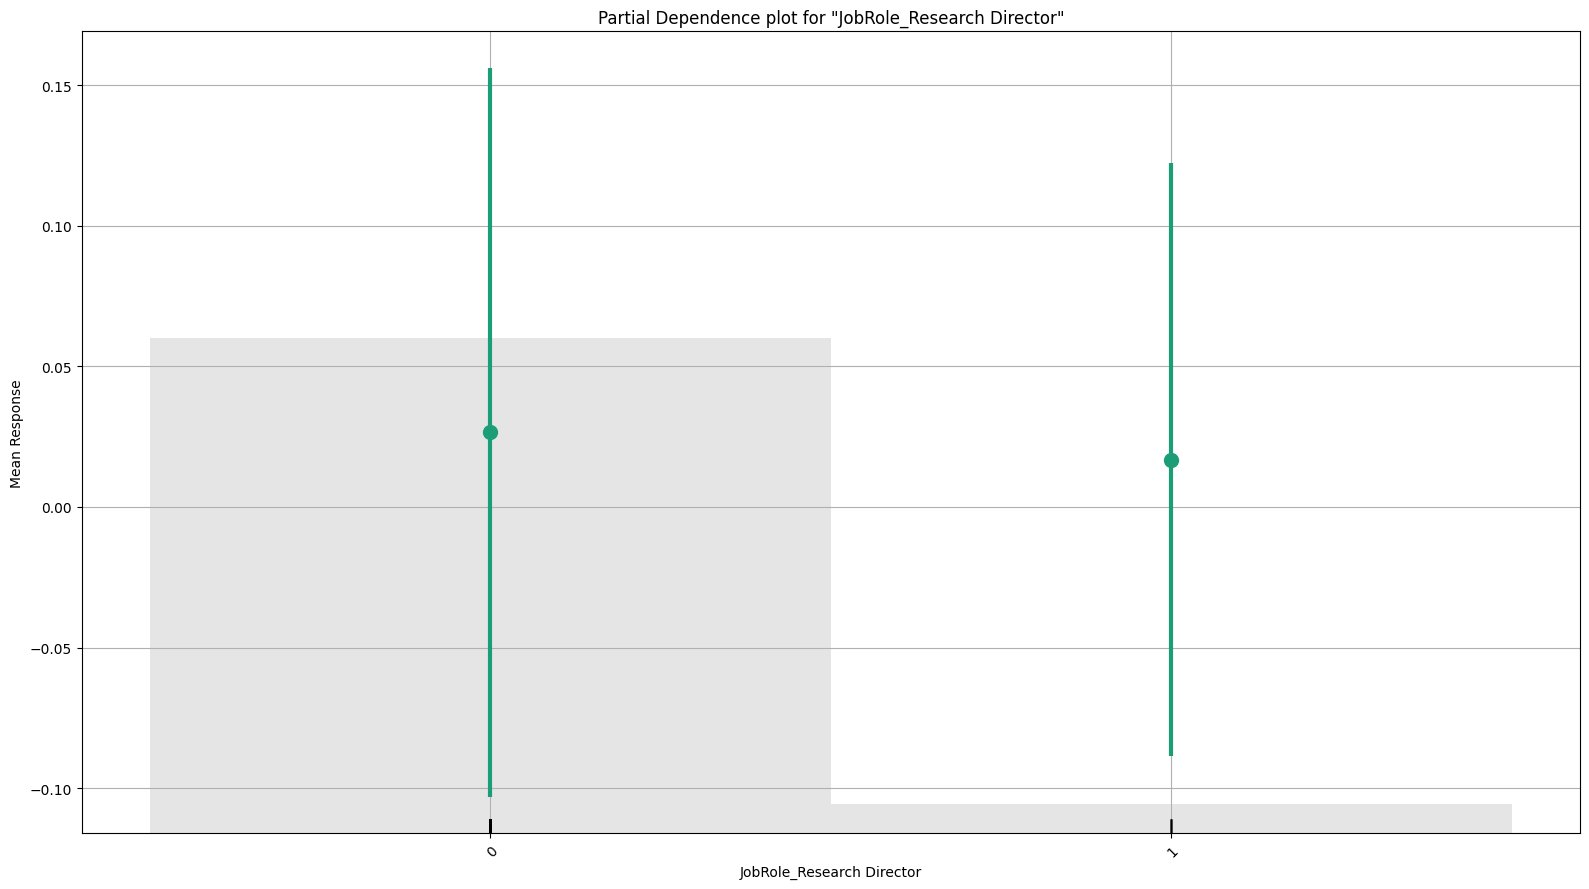

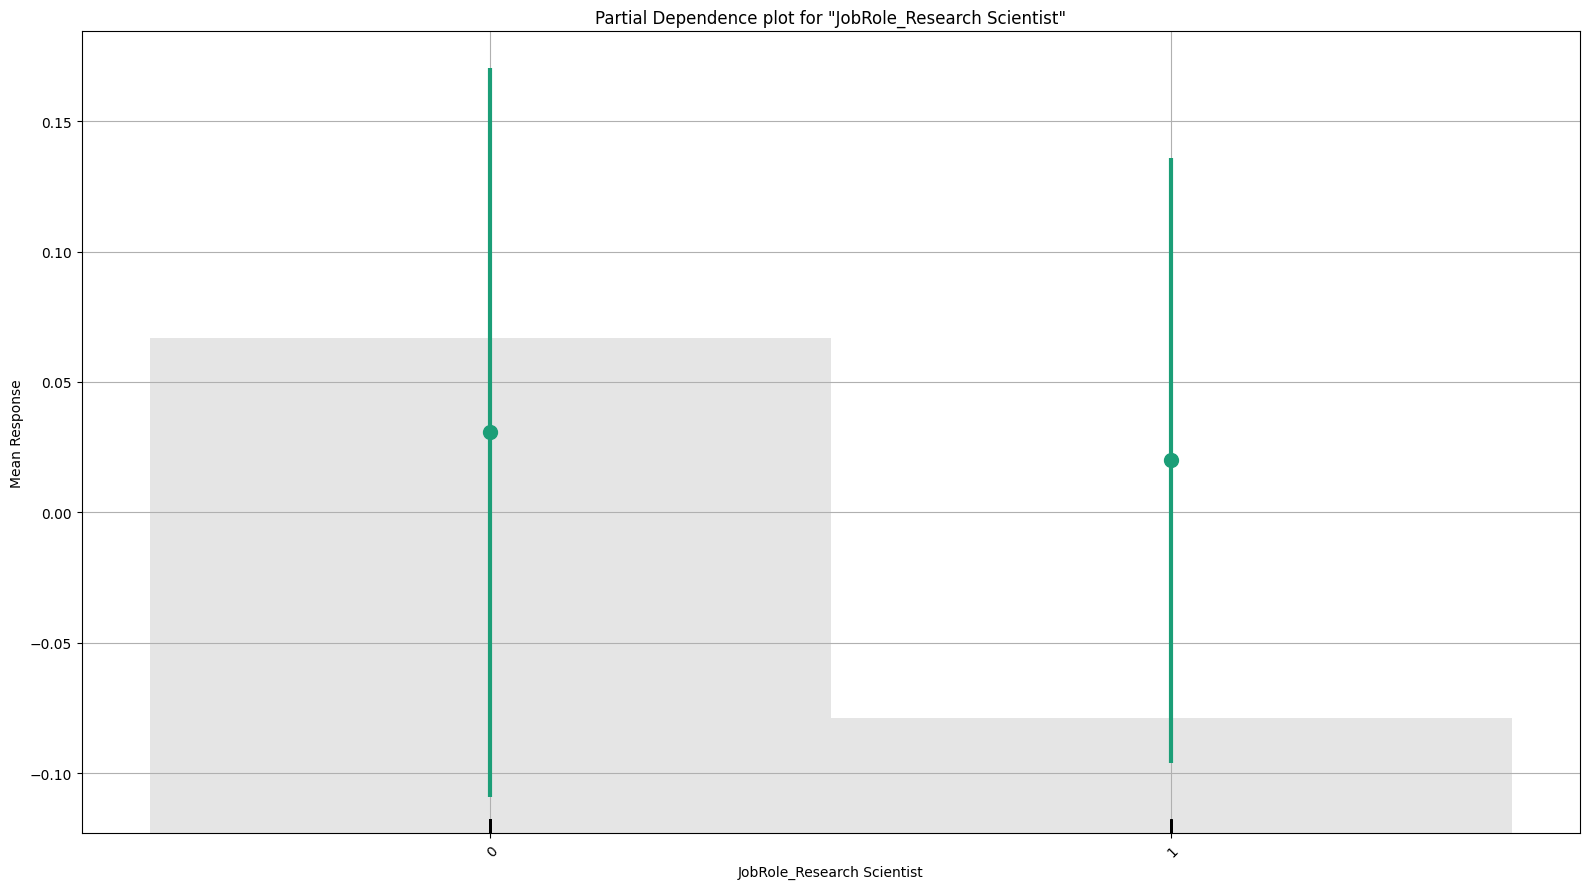

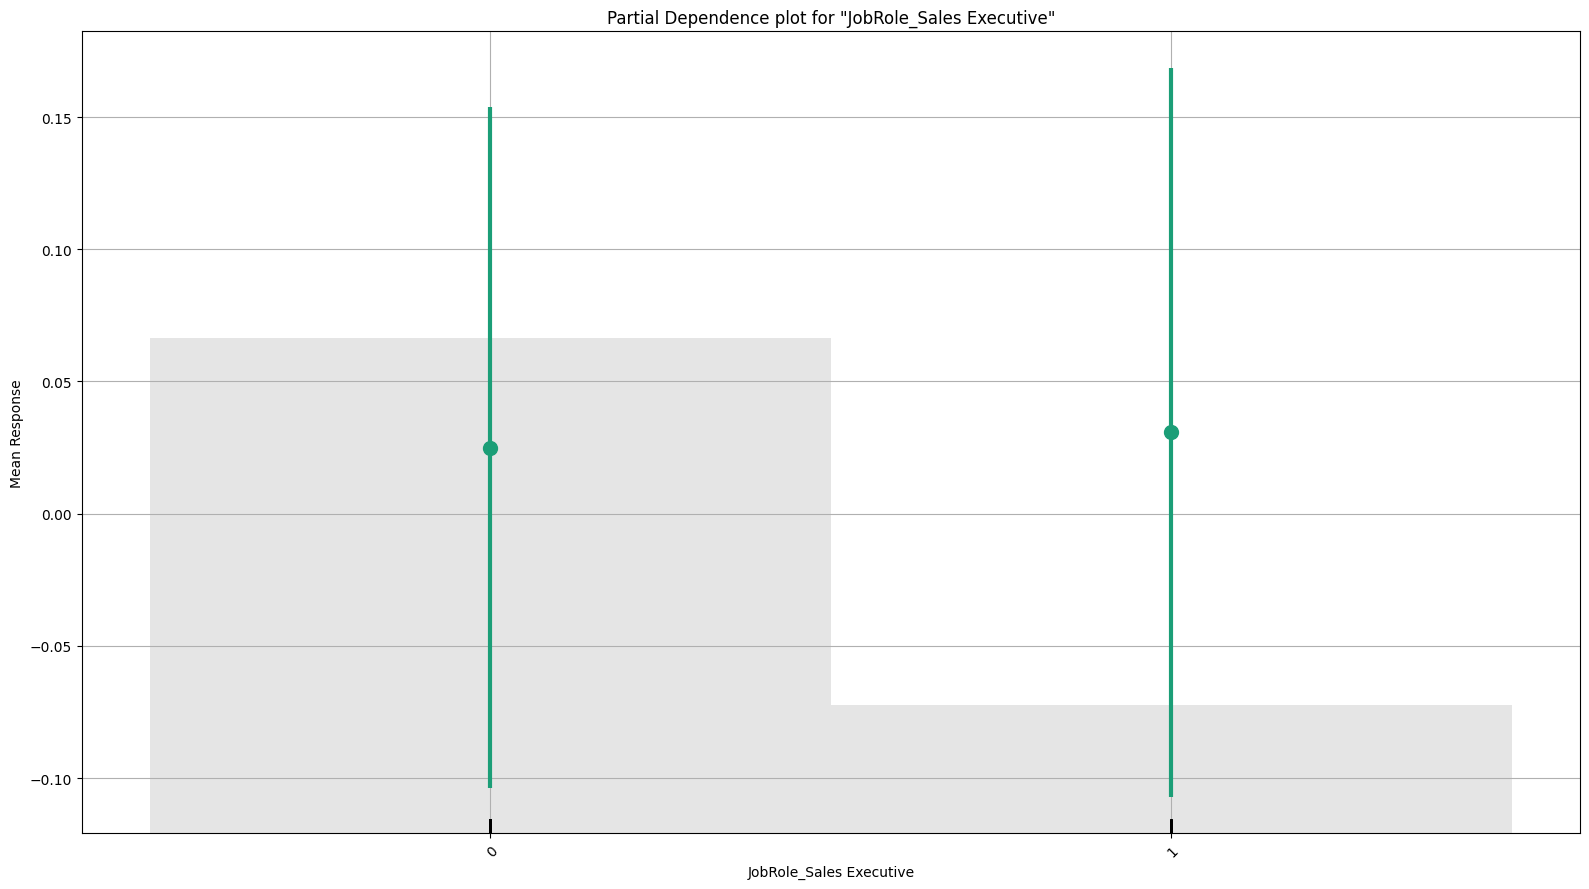

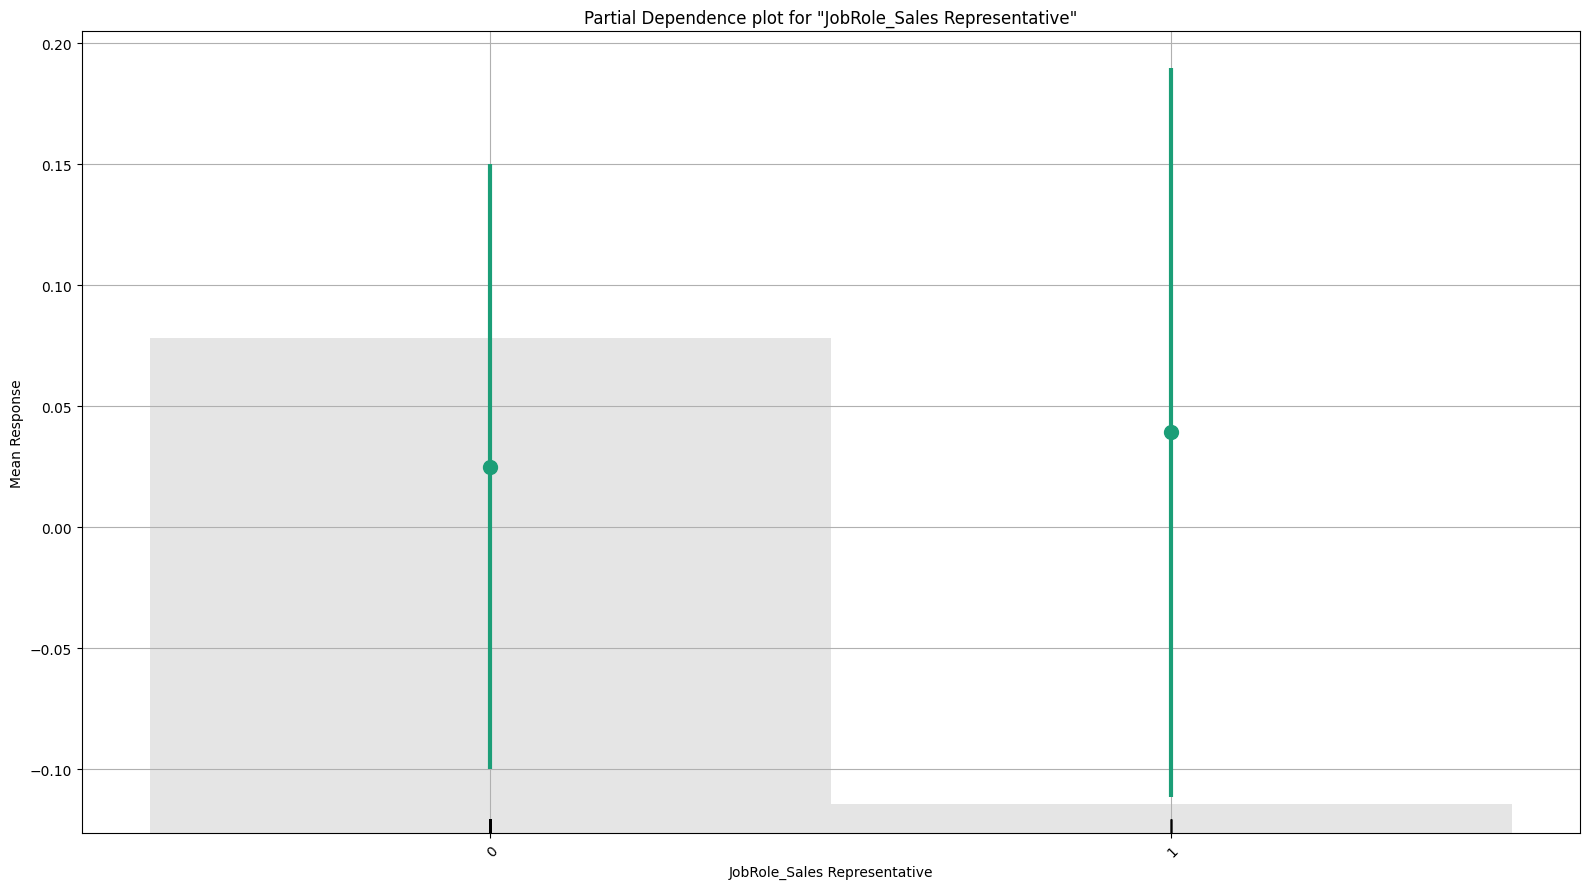

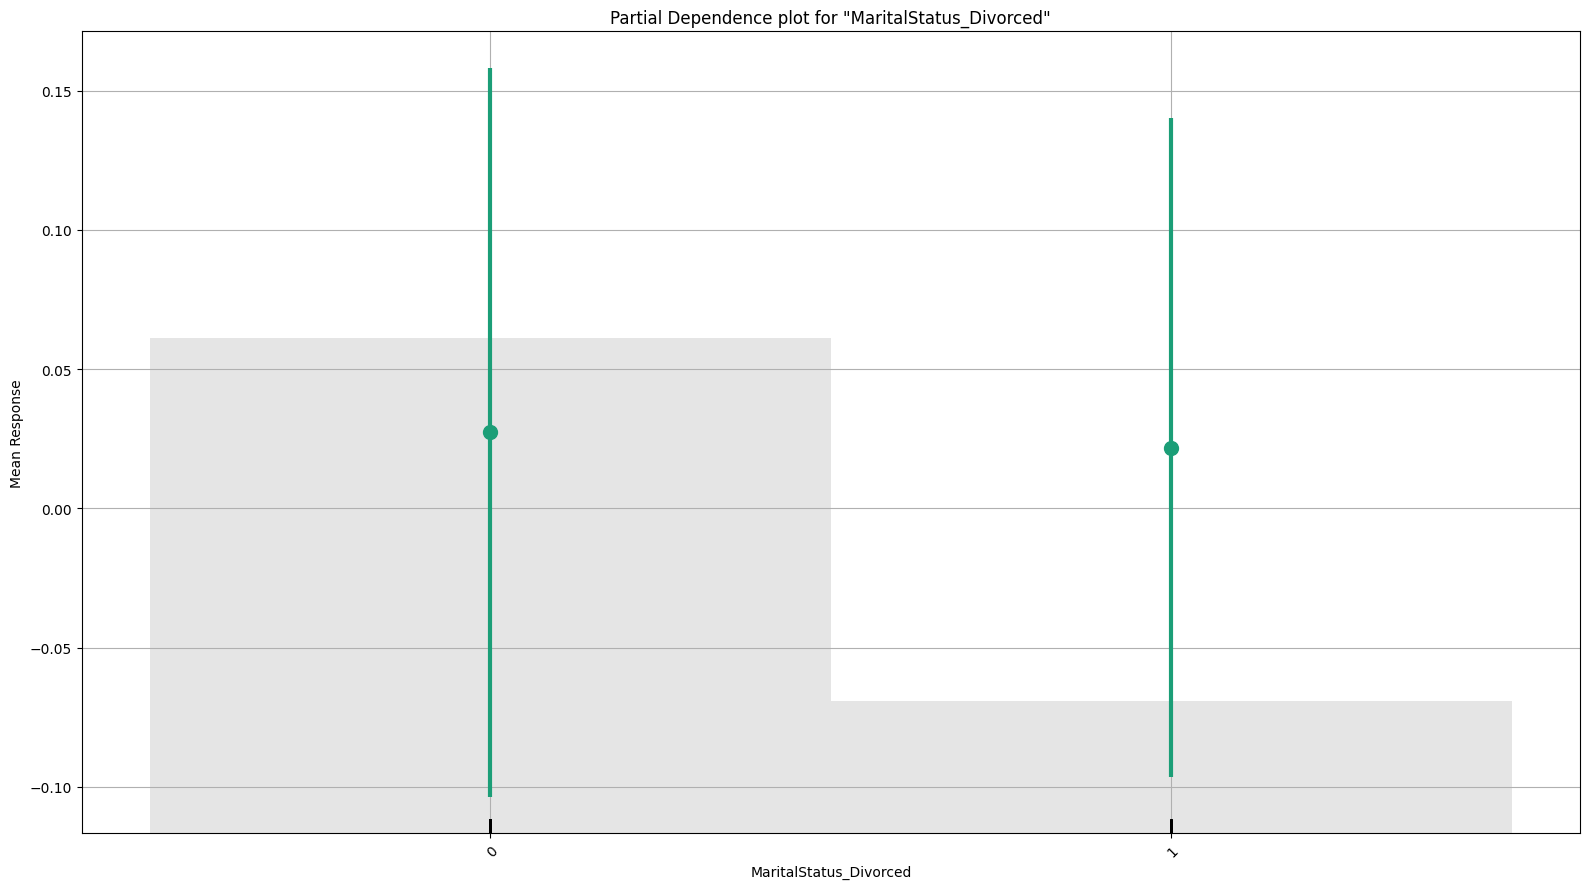

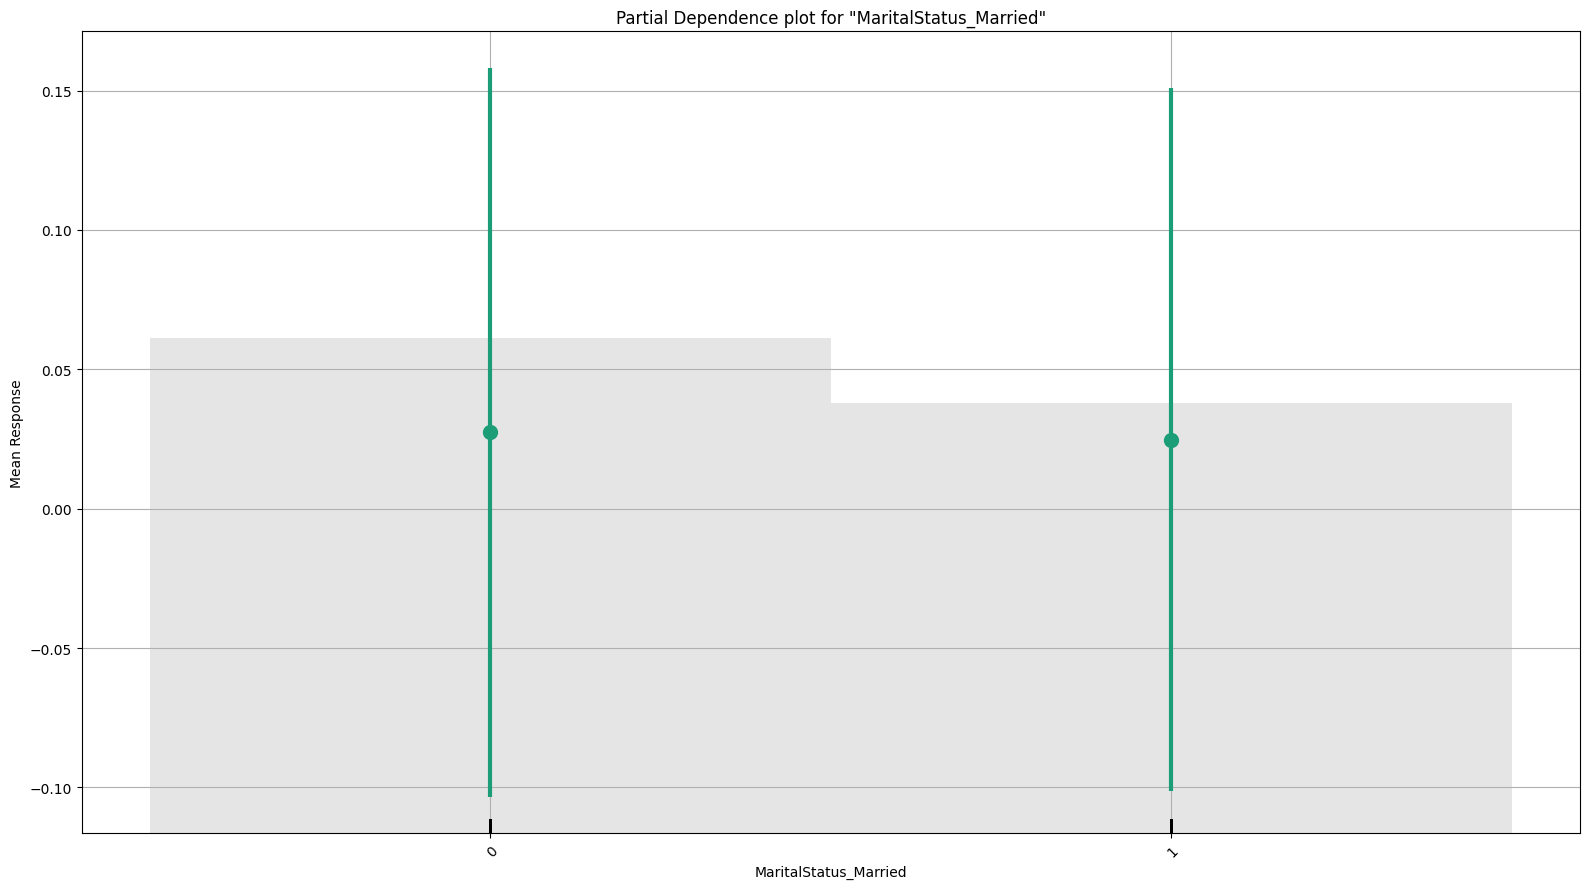

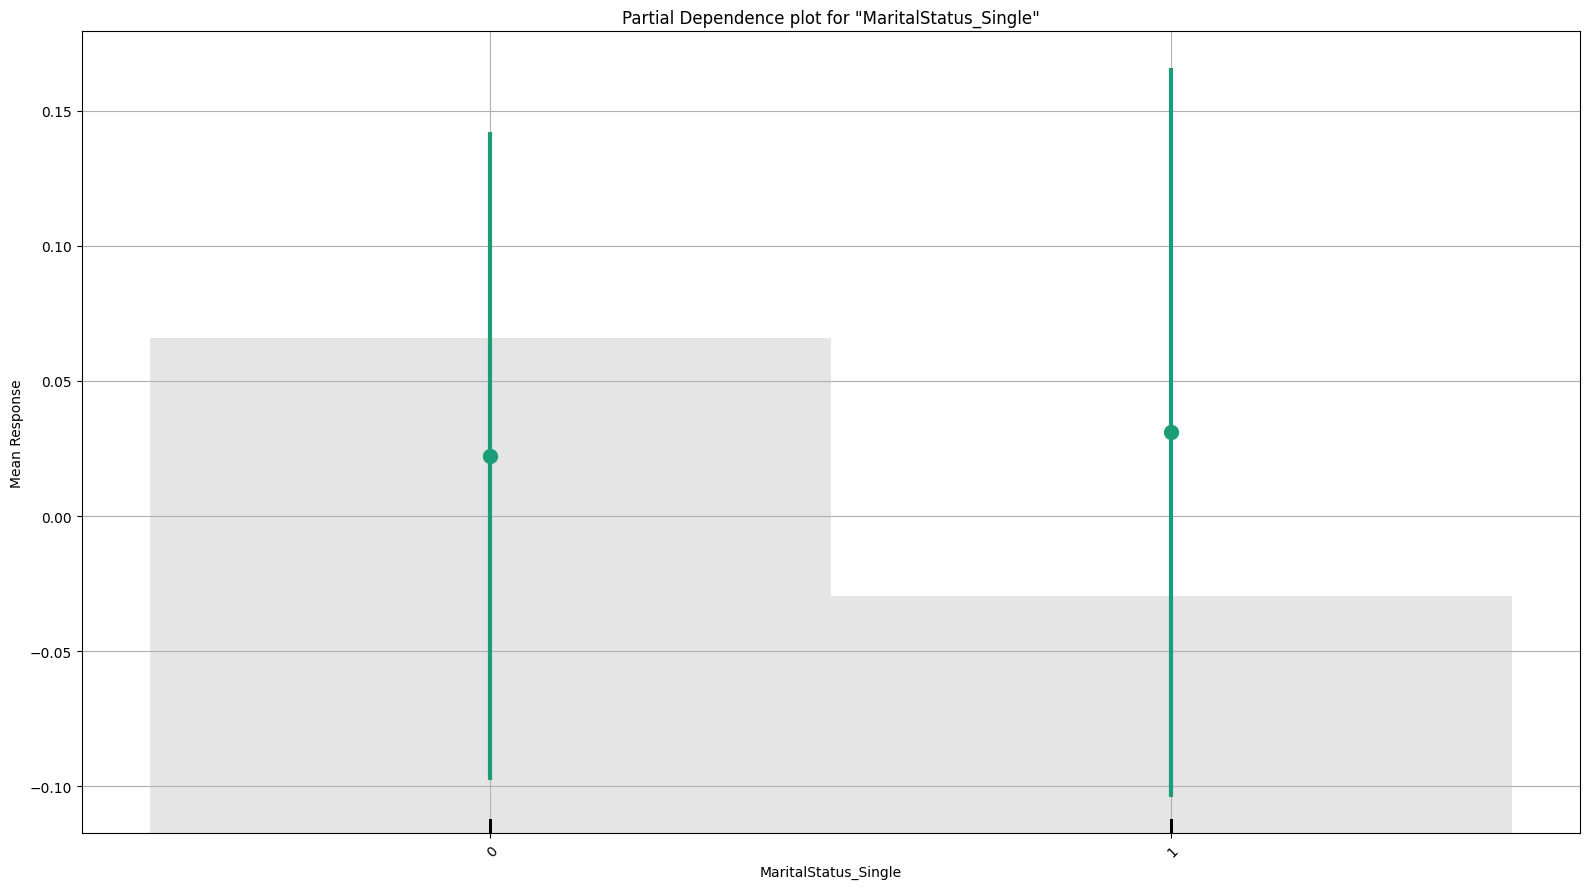

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004770391628635588
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      353  31   0.0807   (31.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  374  67   0.1179   (52.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

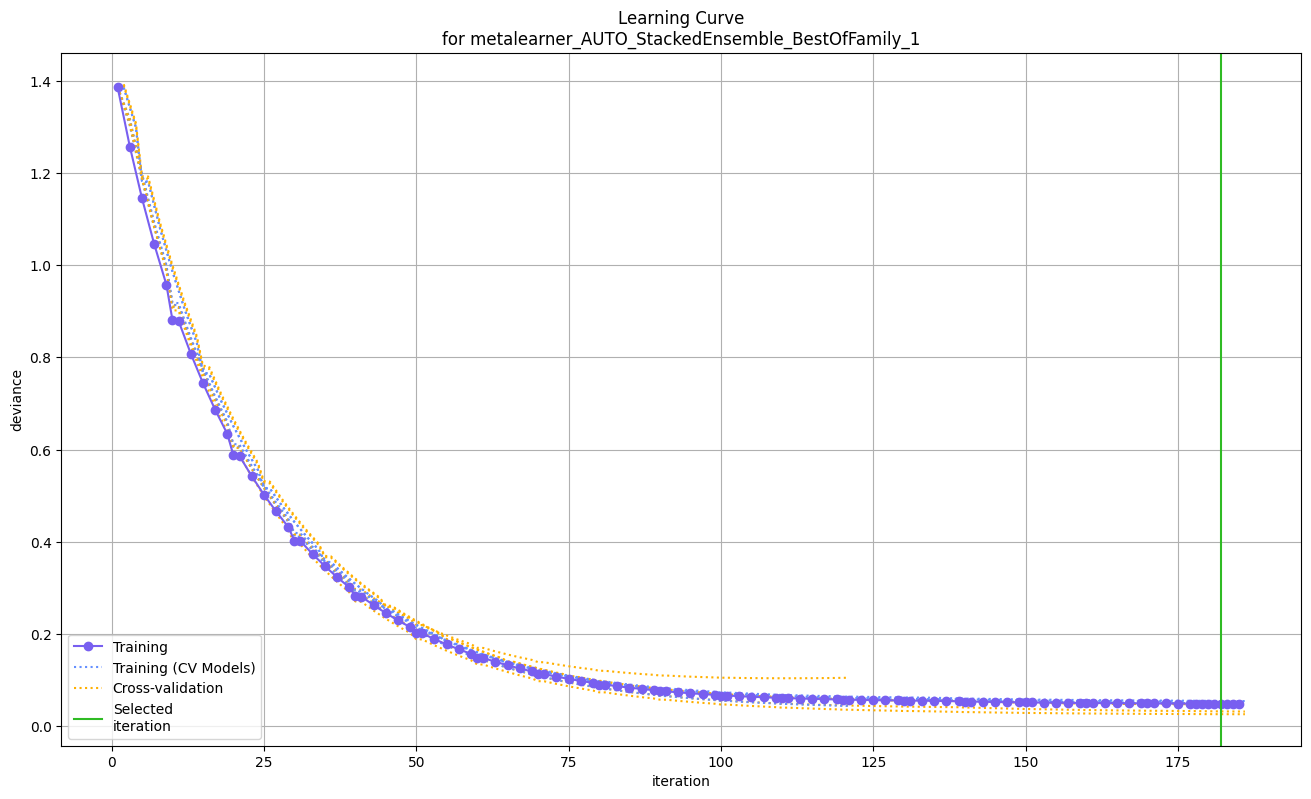

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

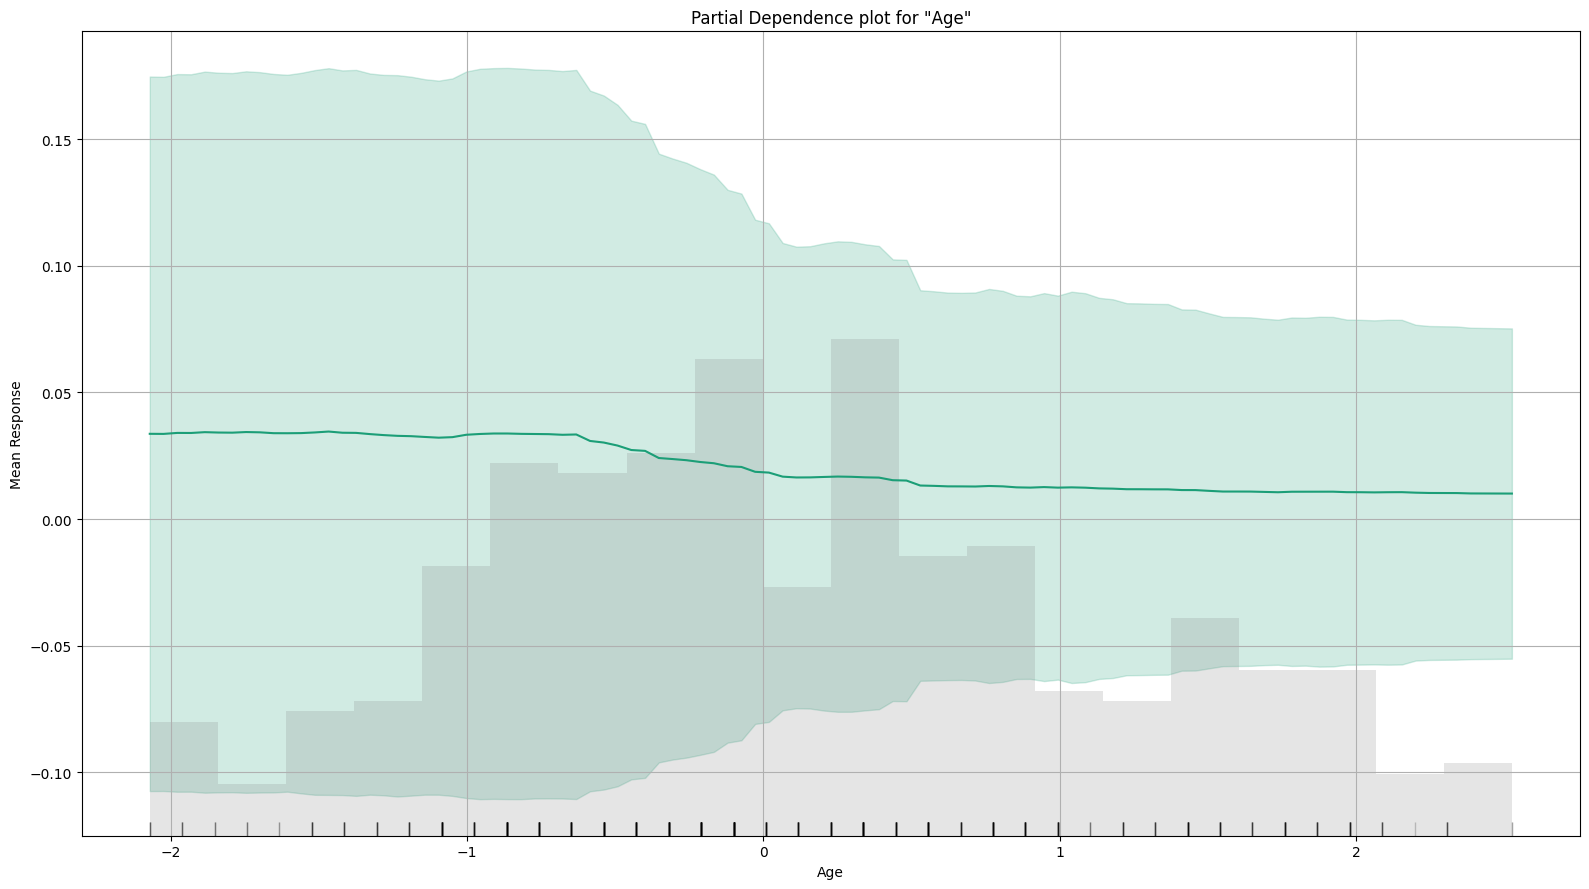

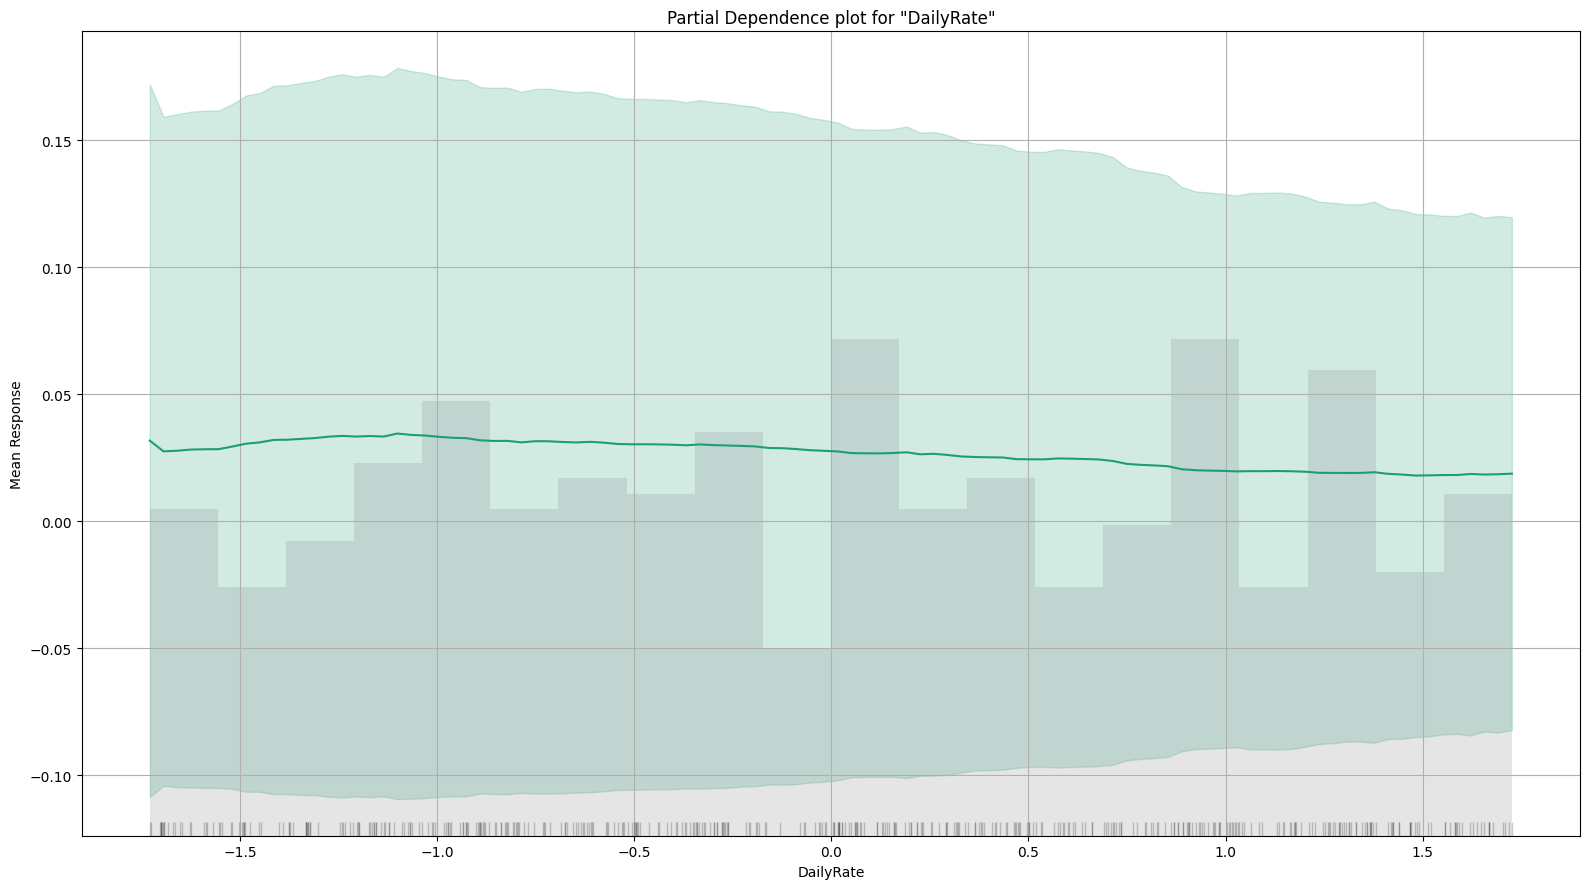

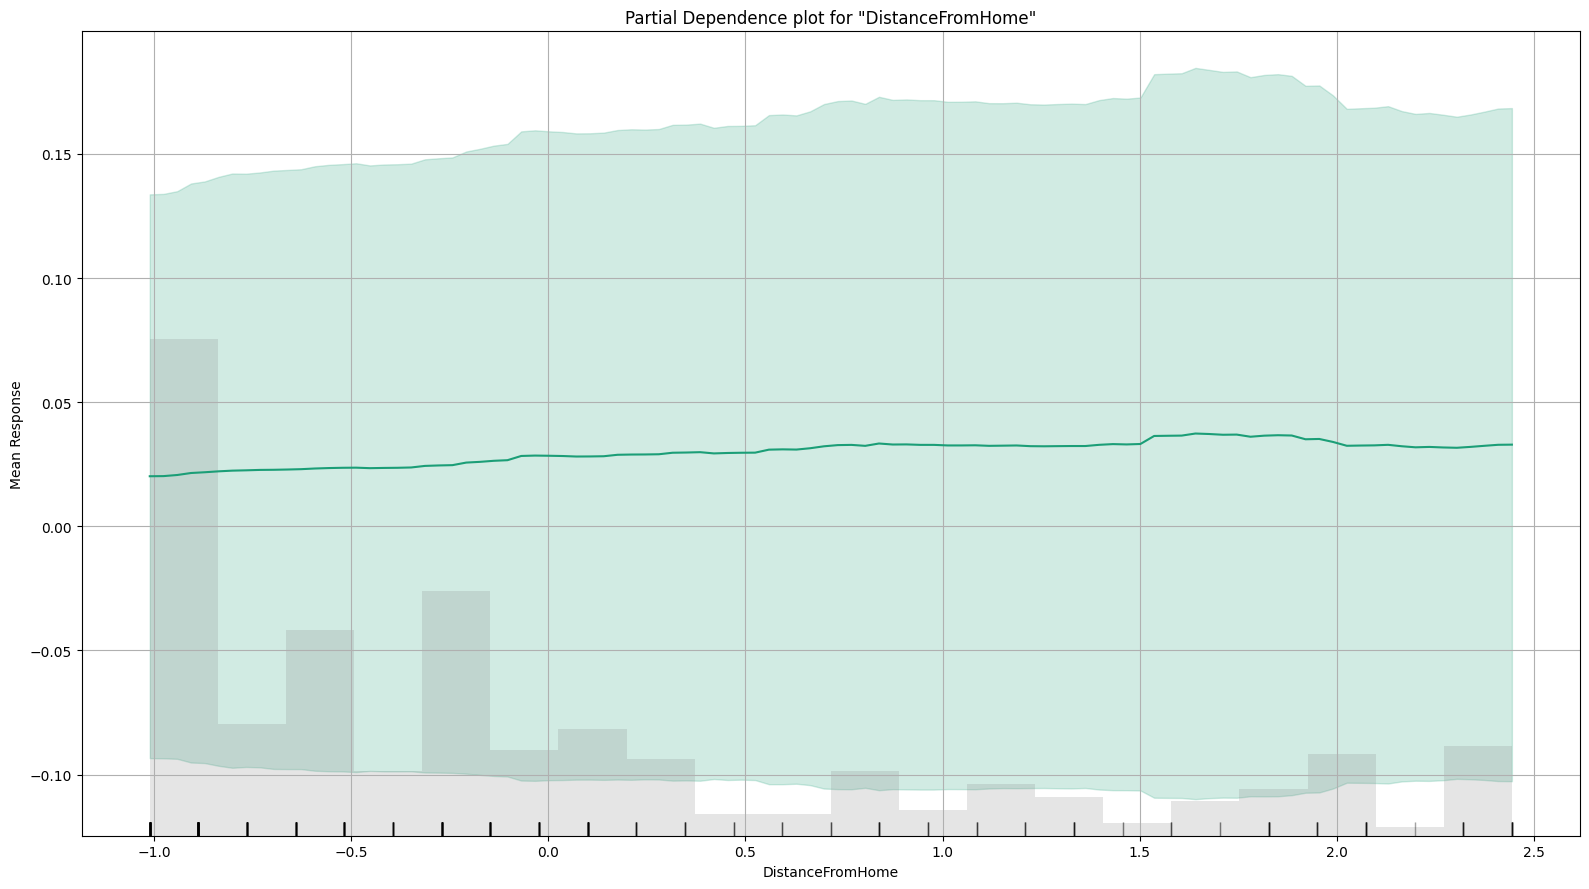

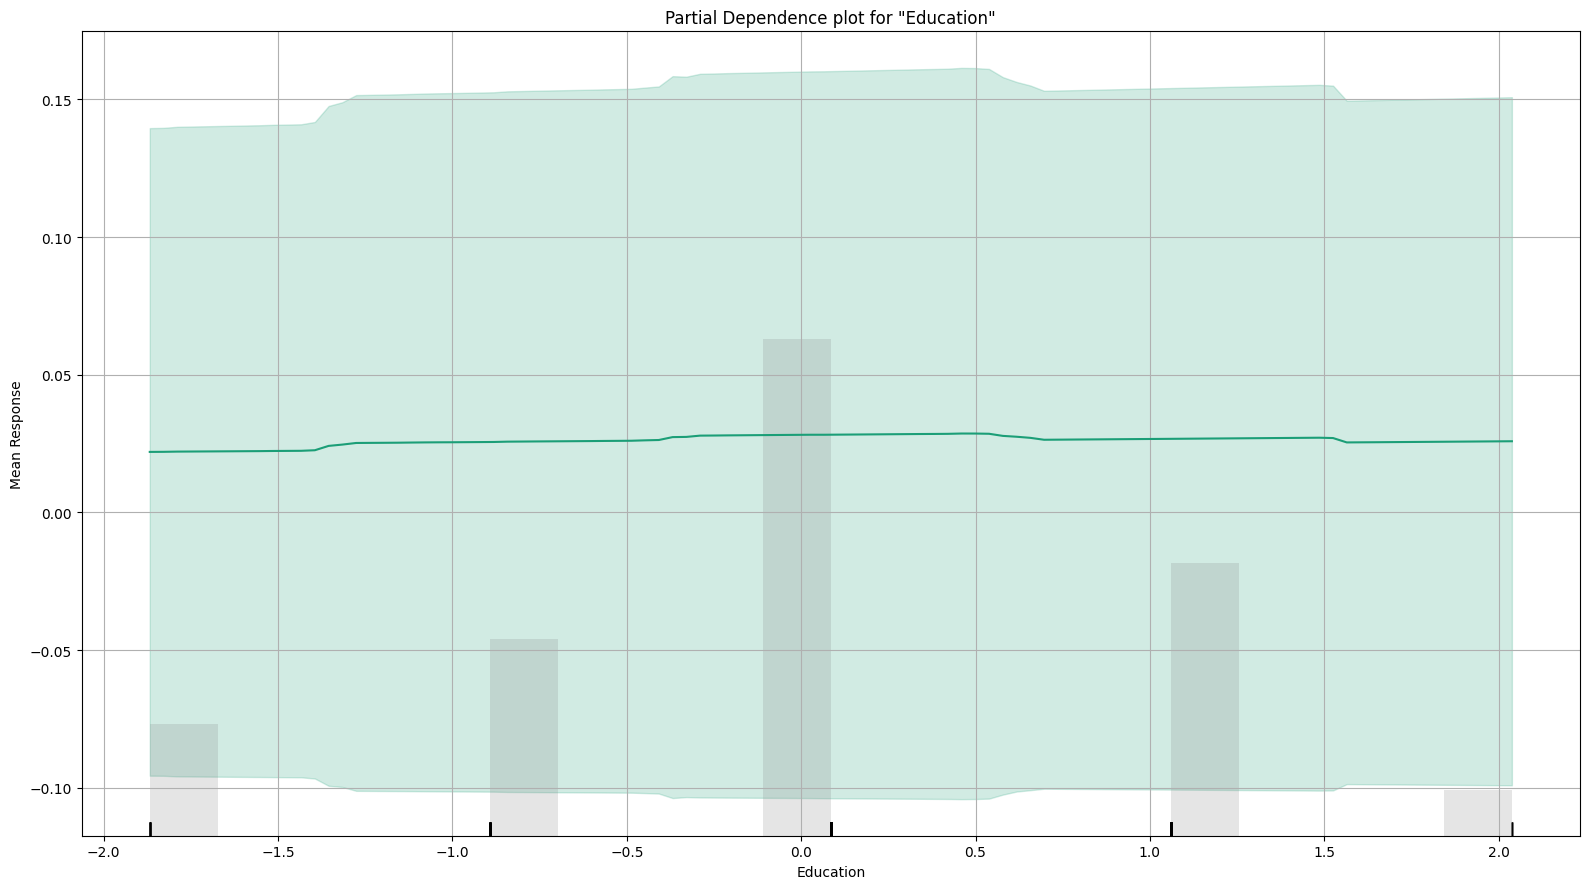

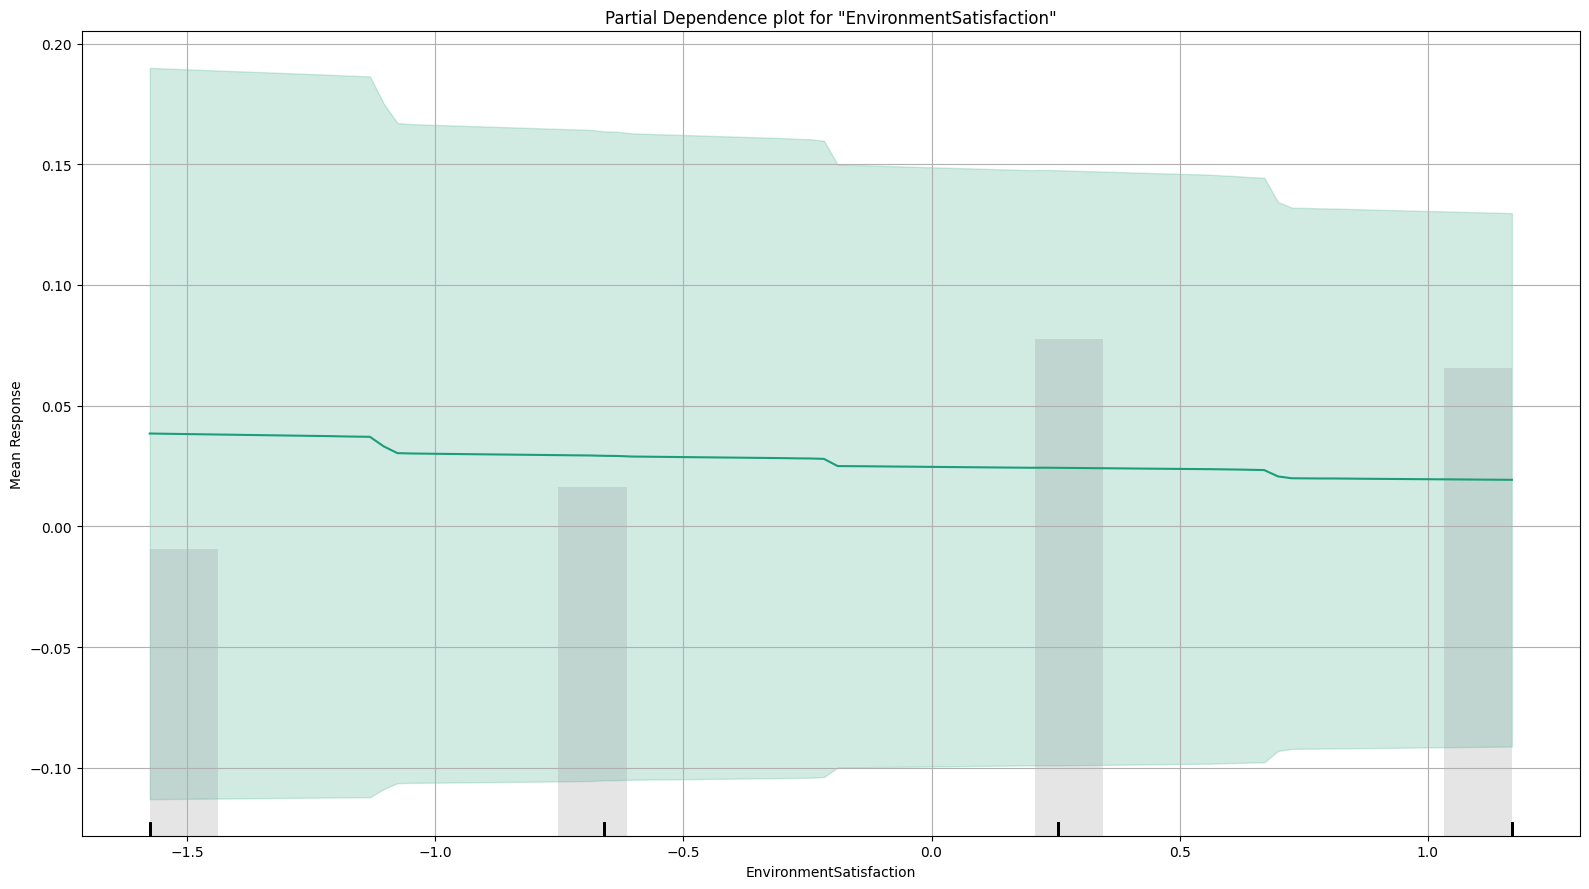

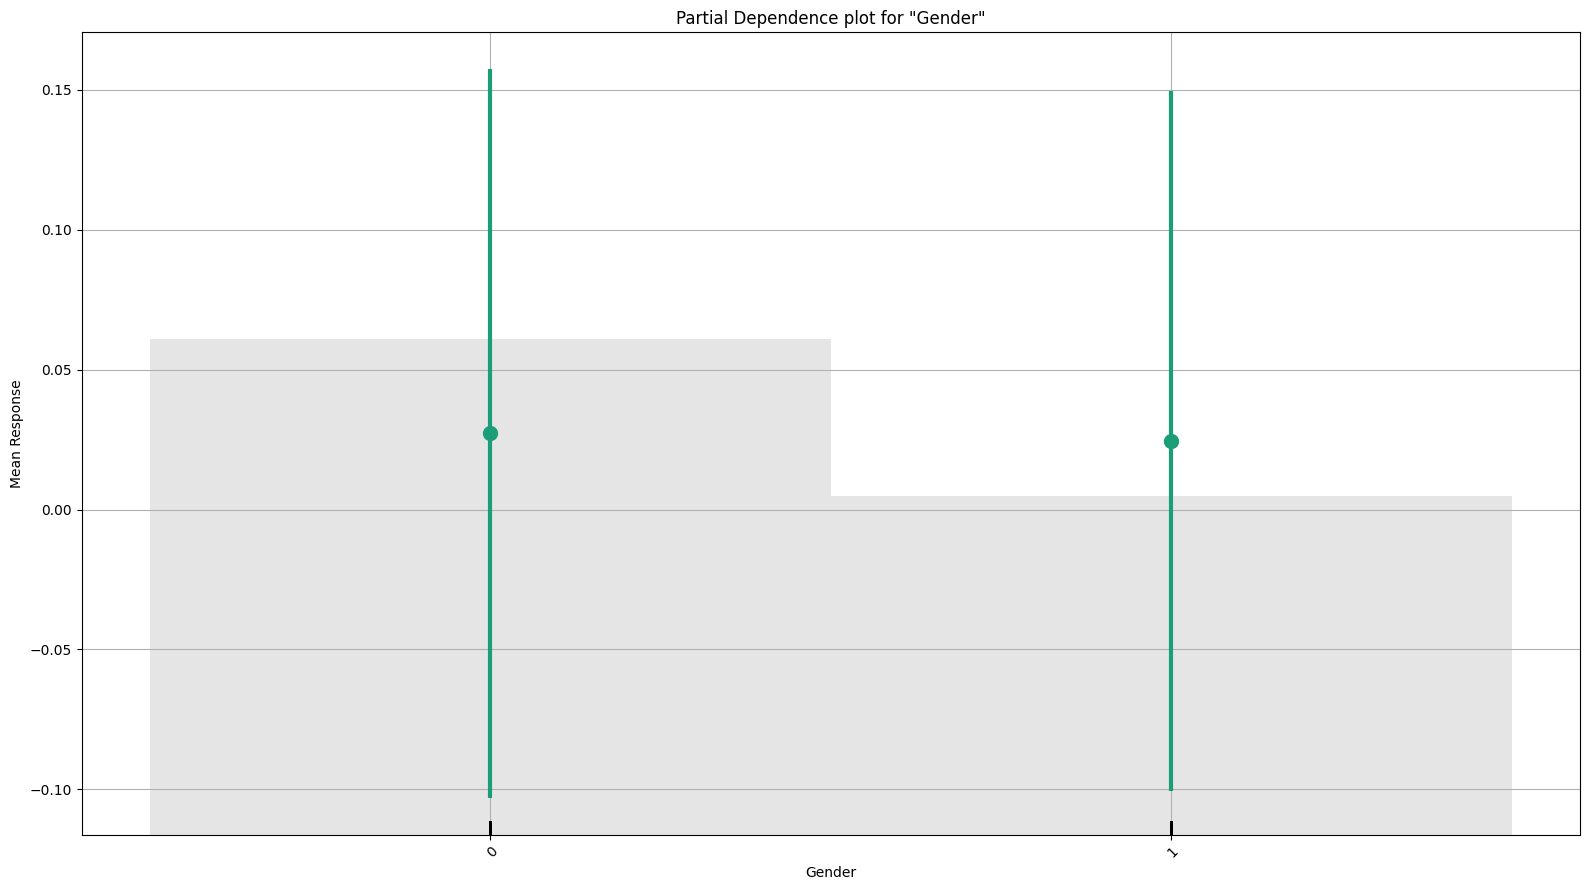

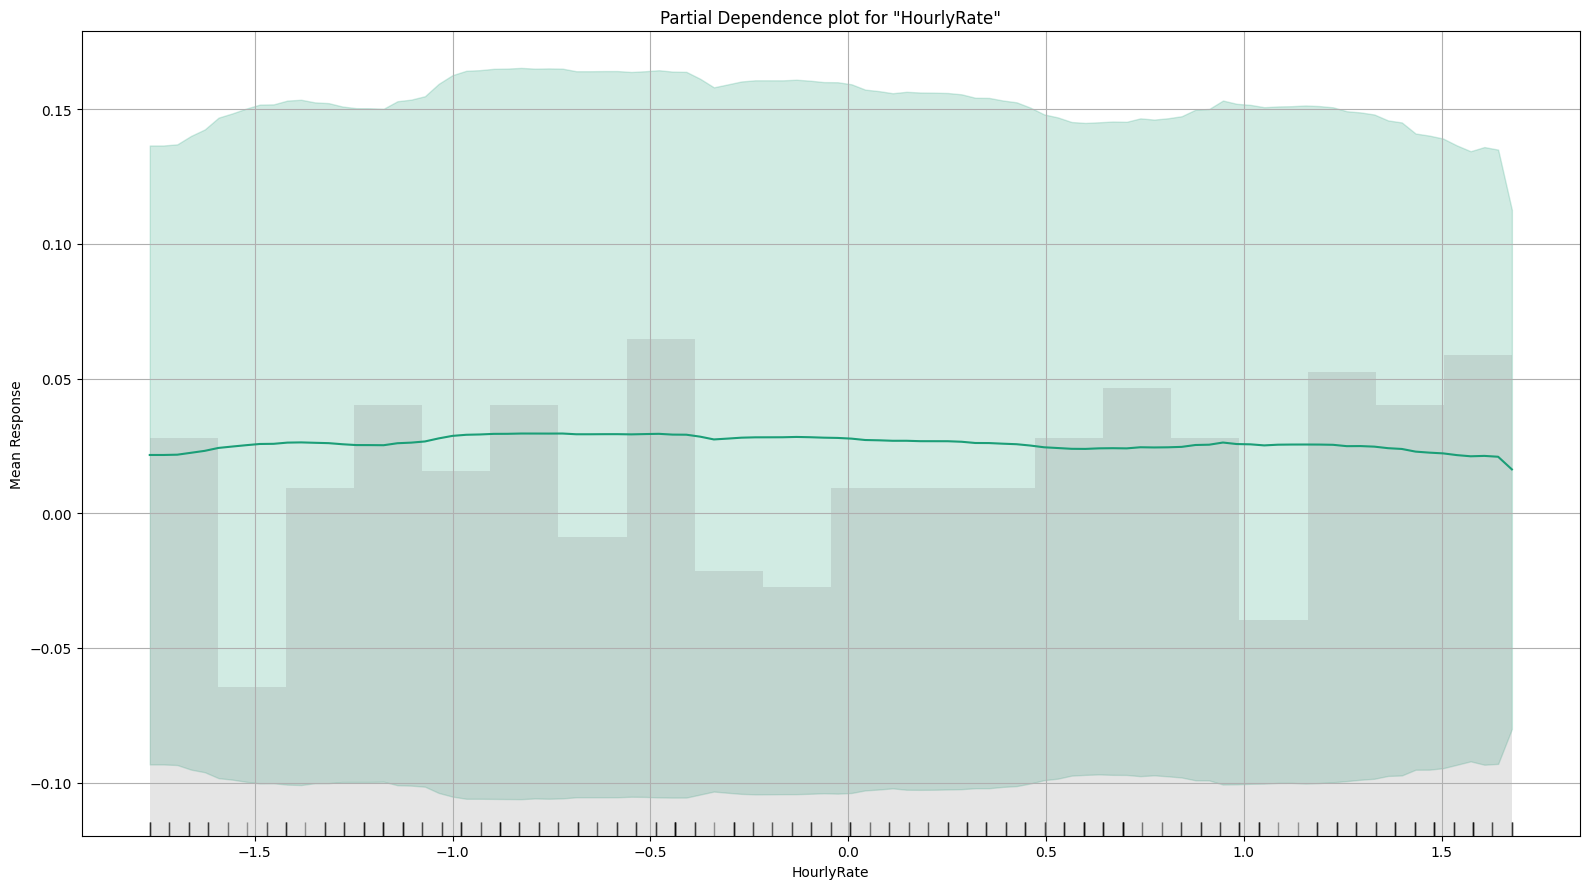

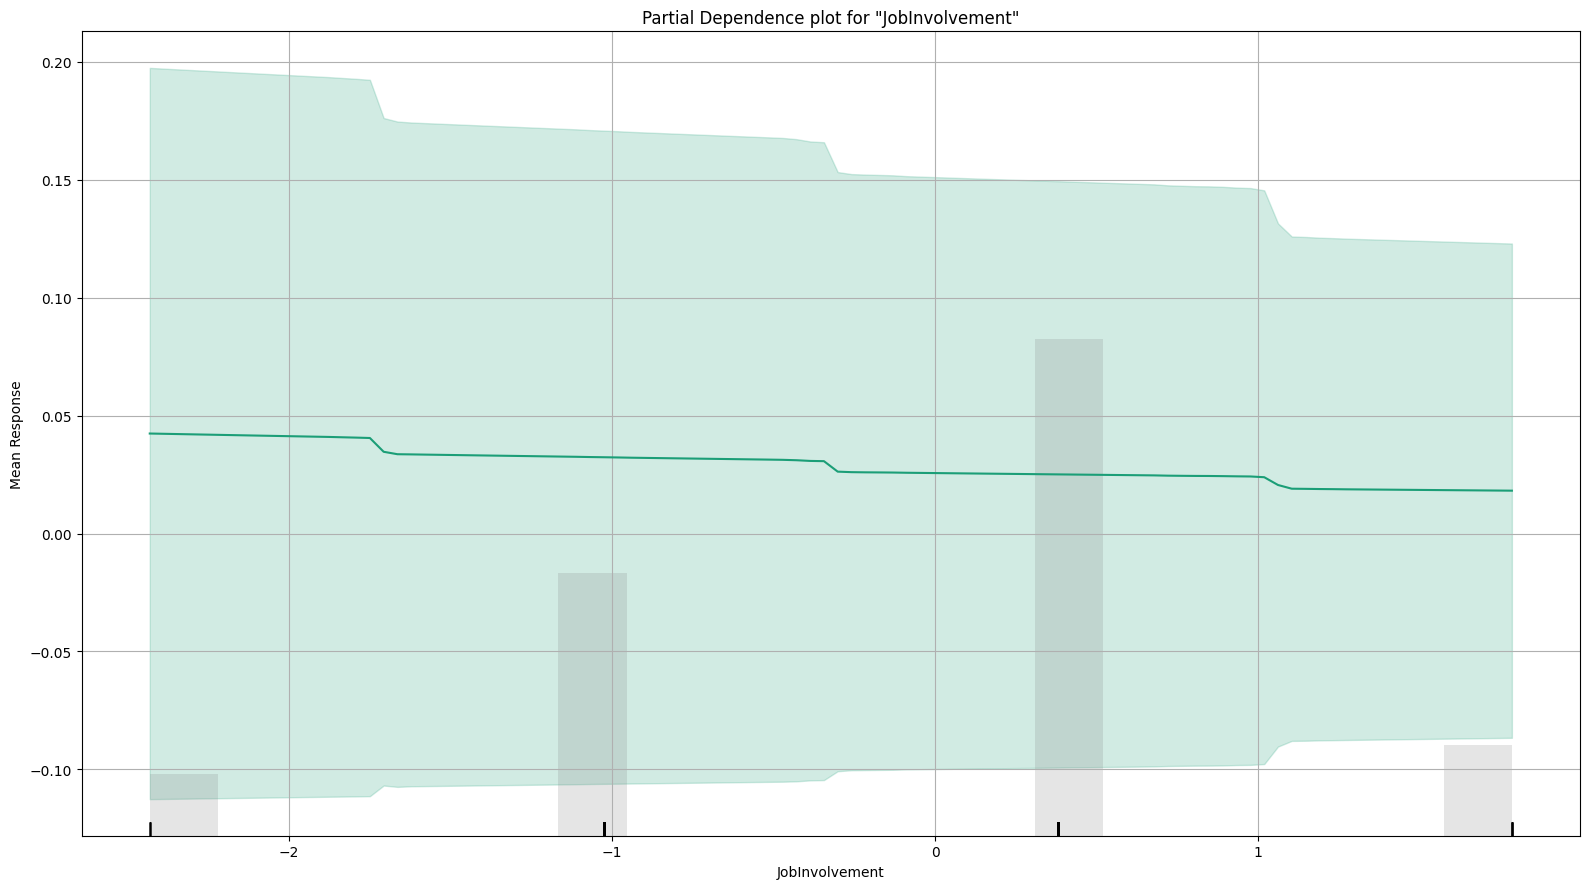

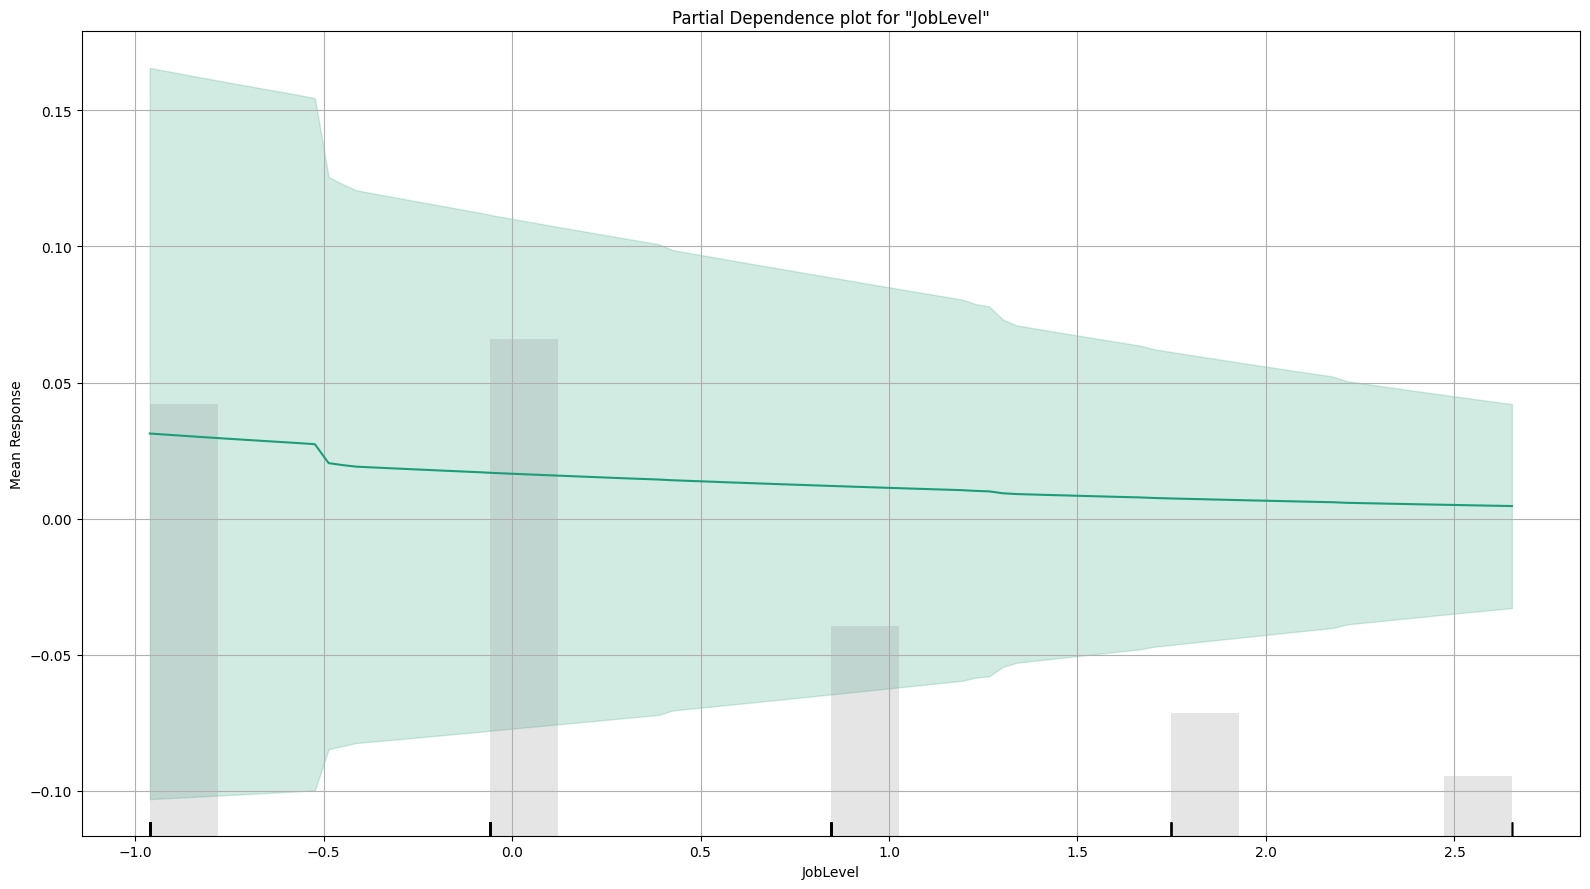

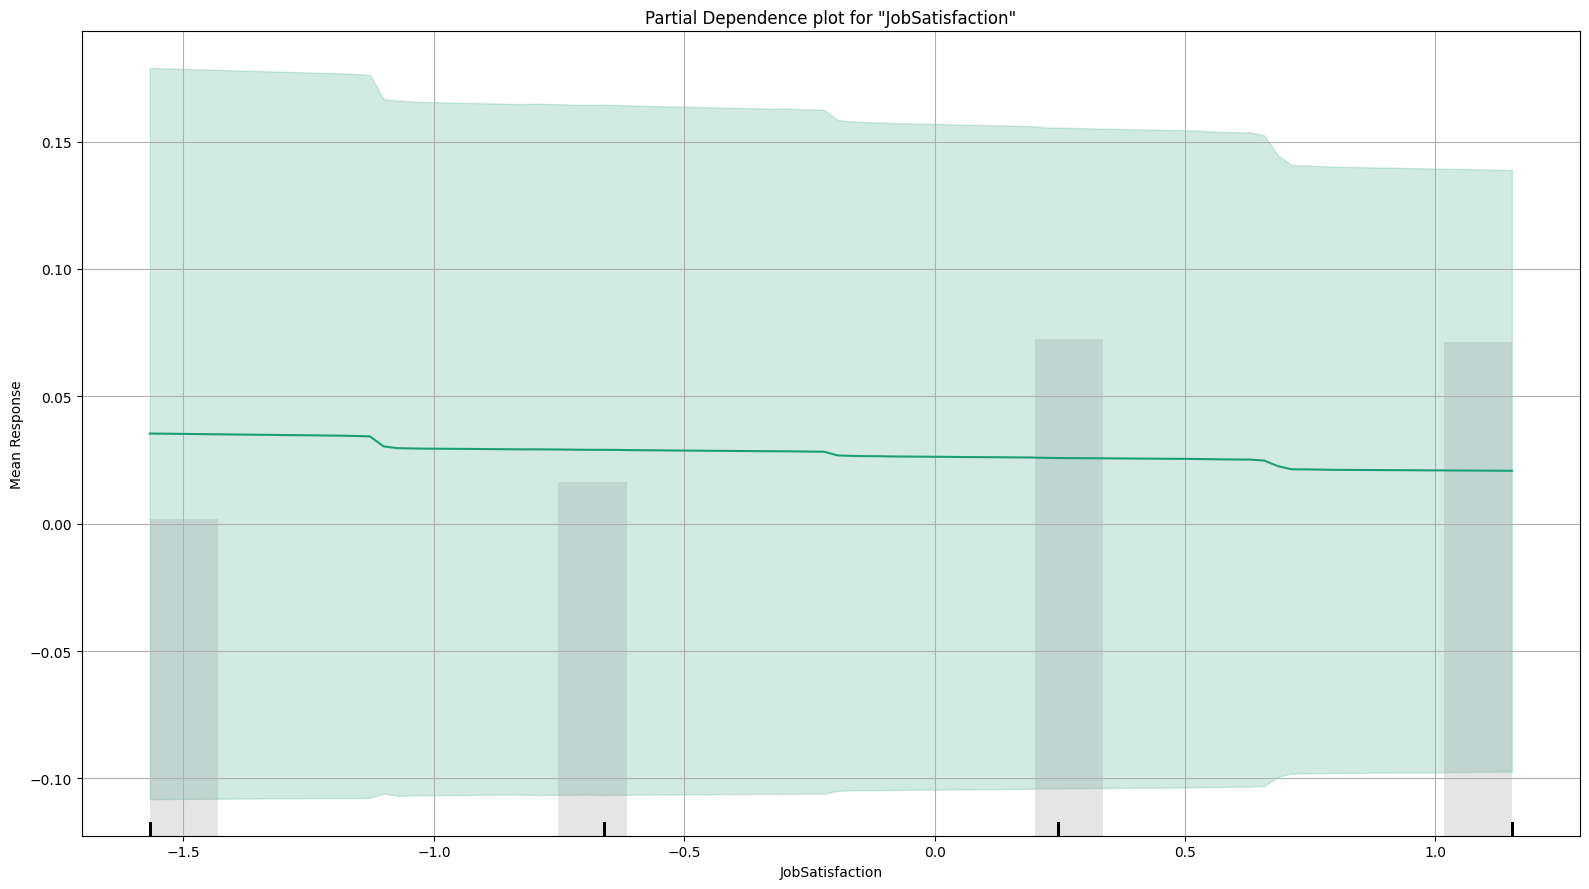

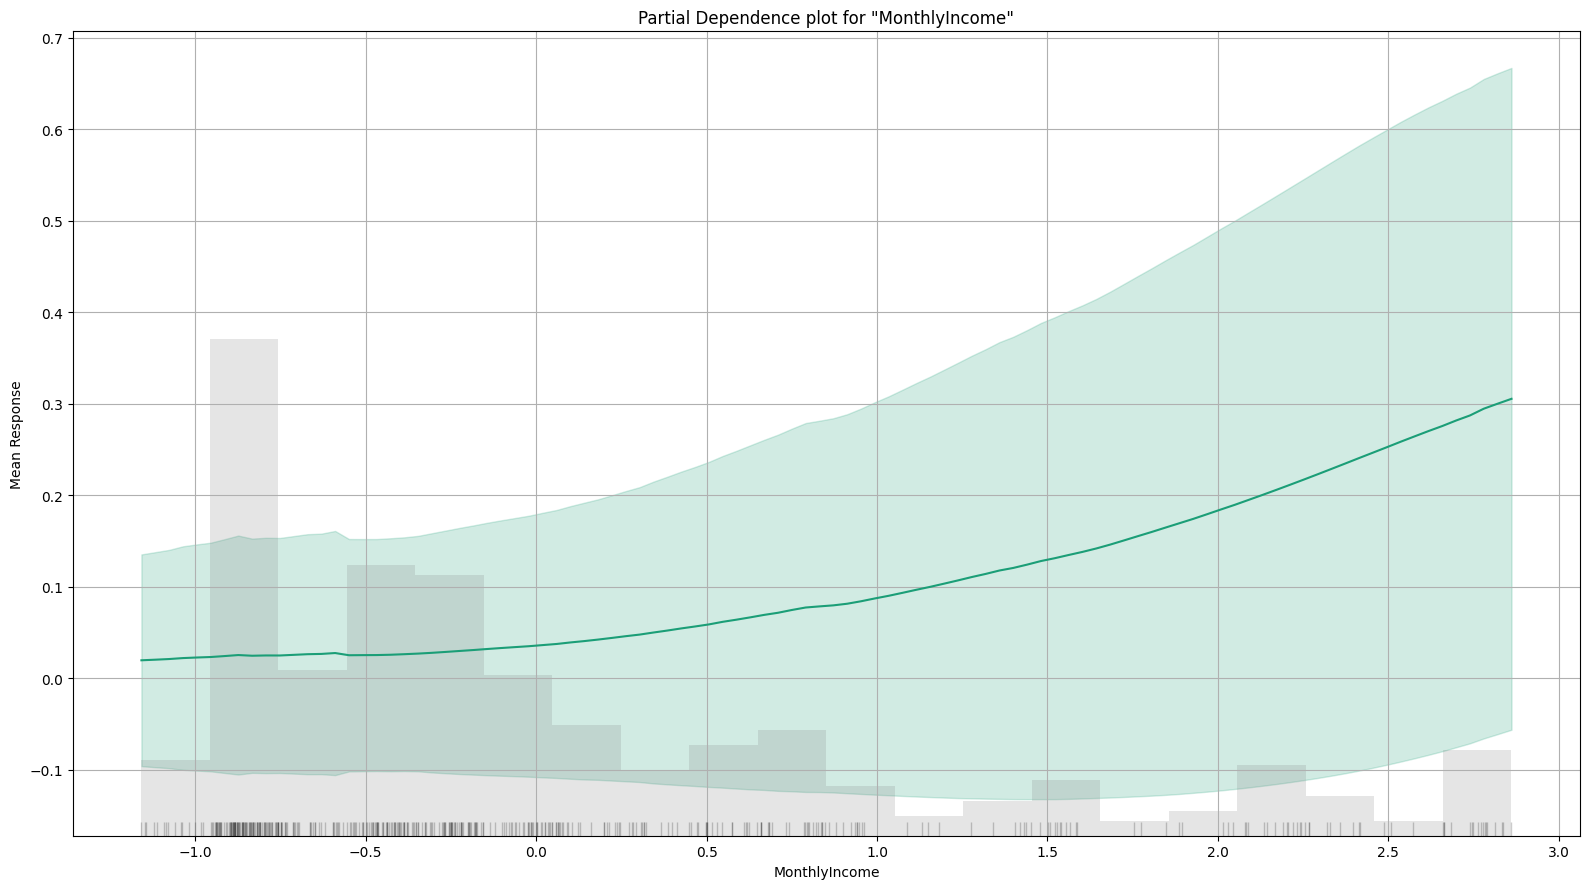

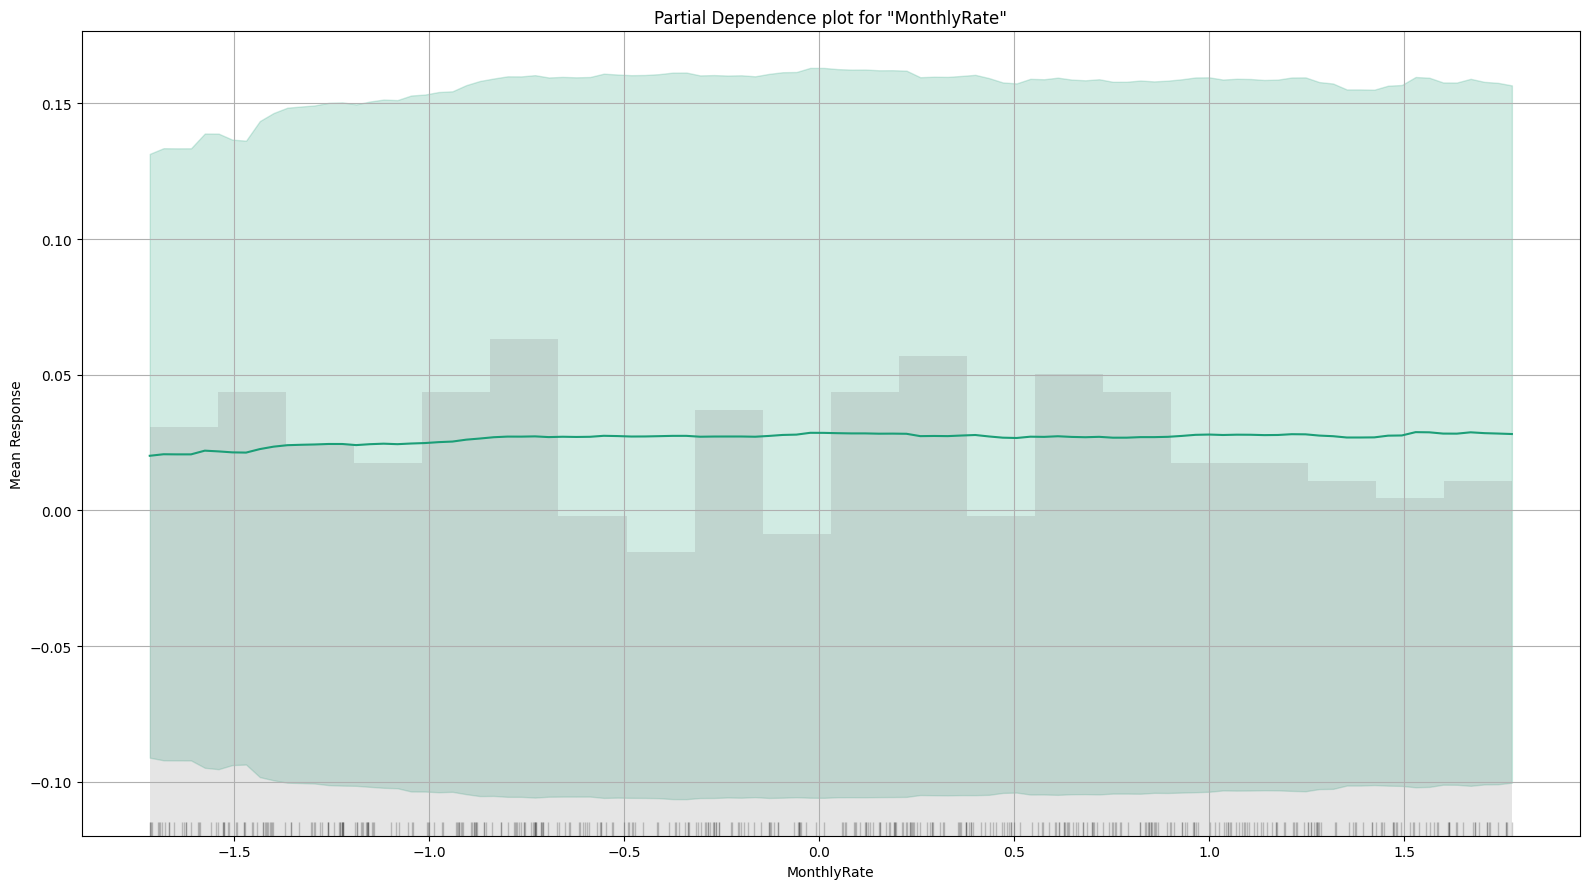

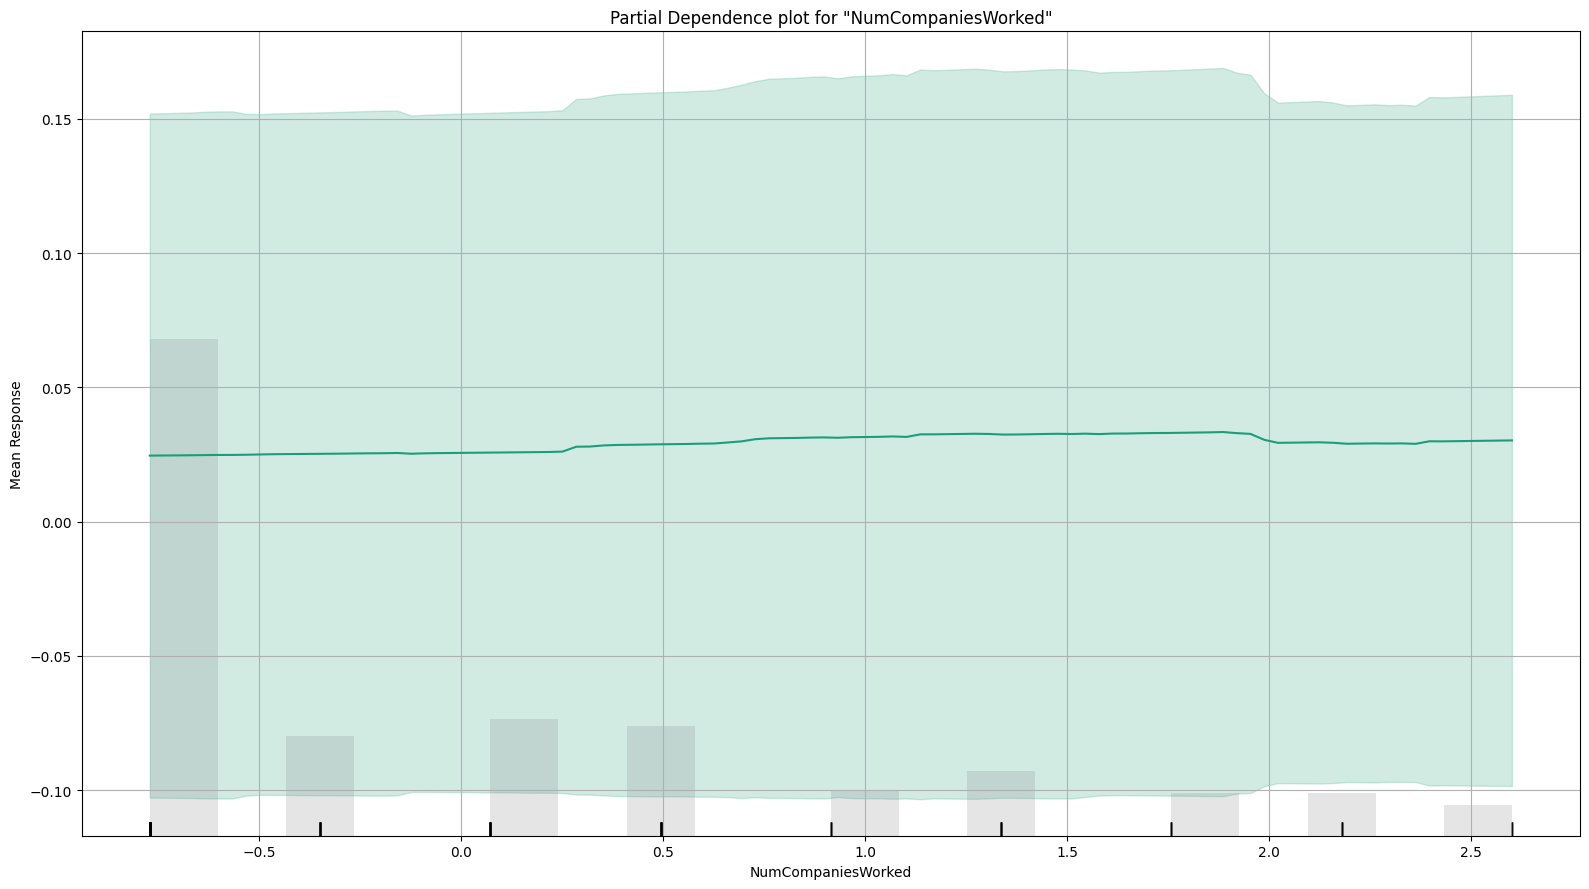

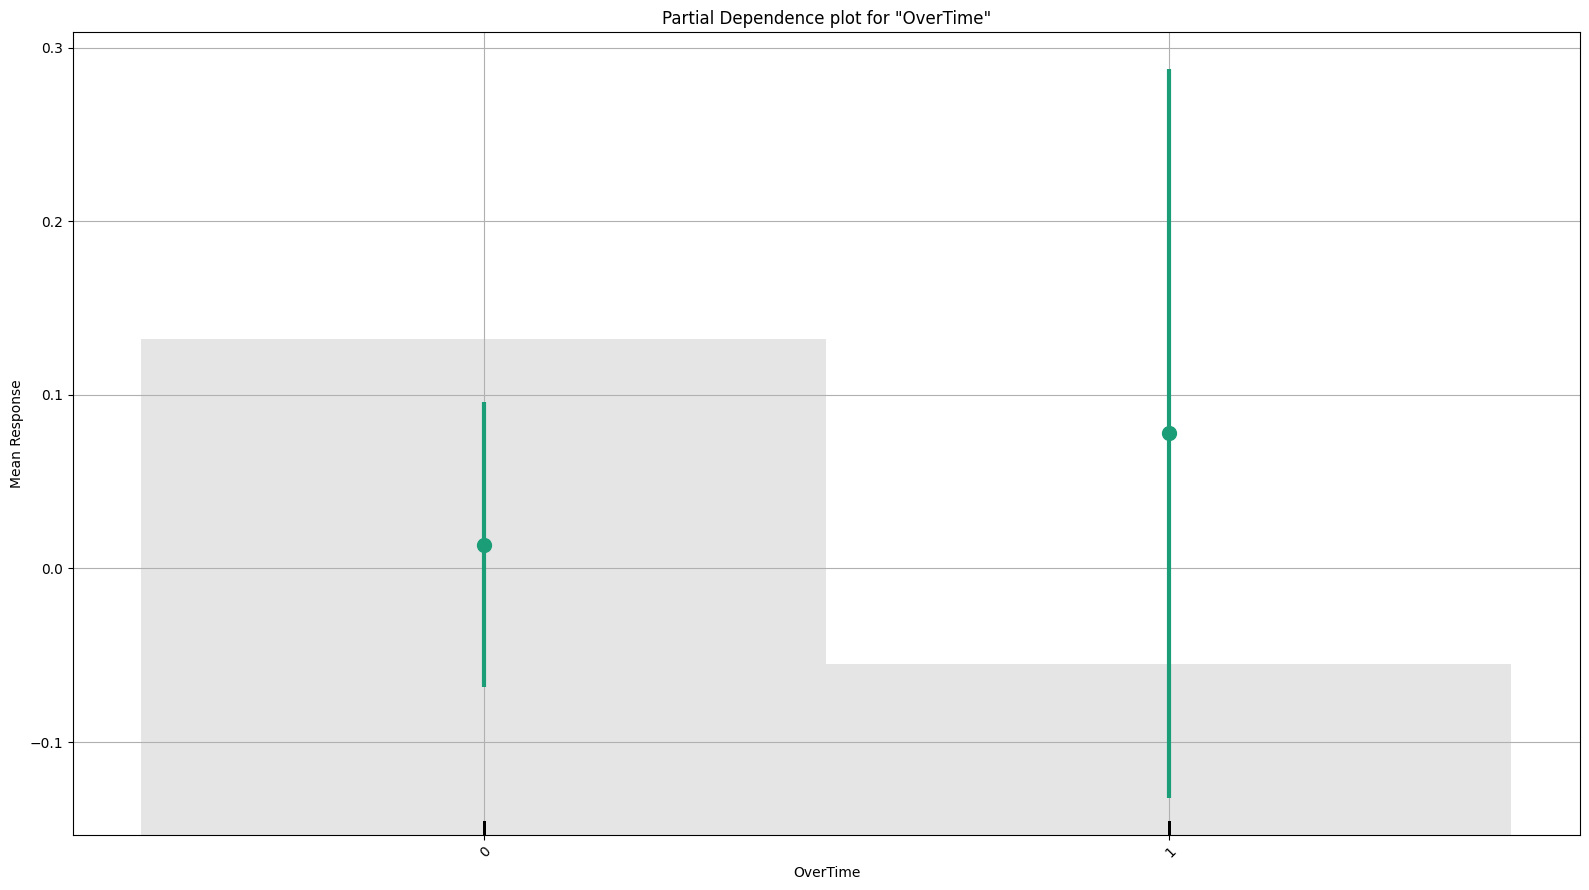

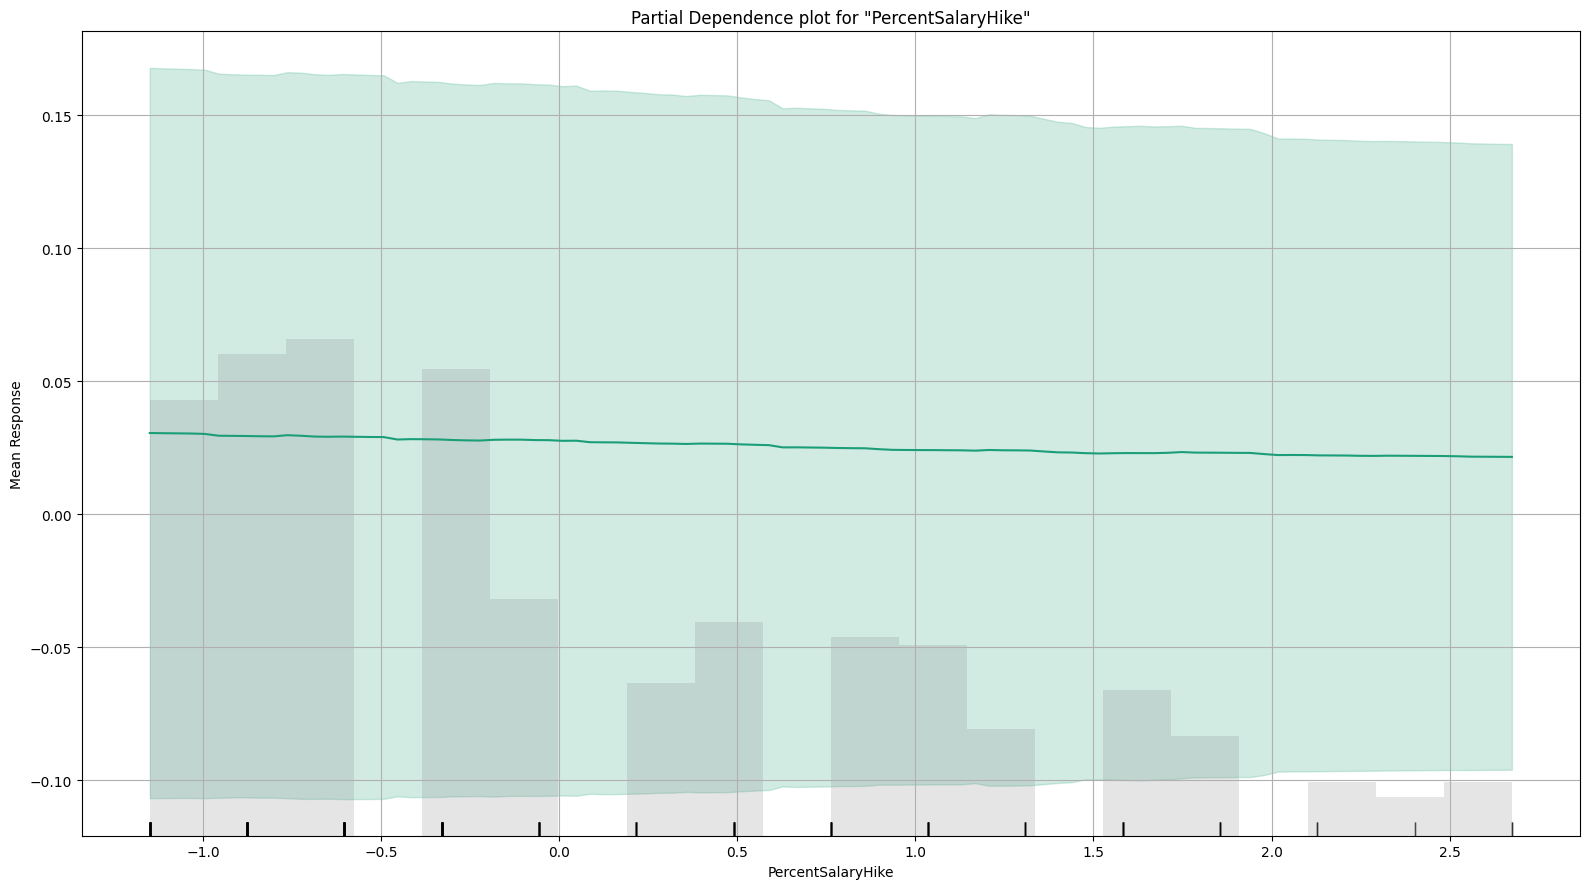

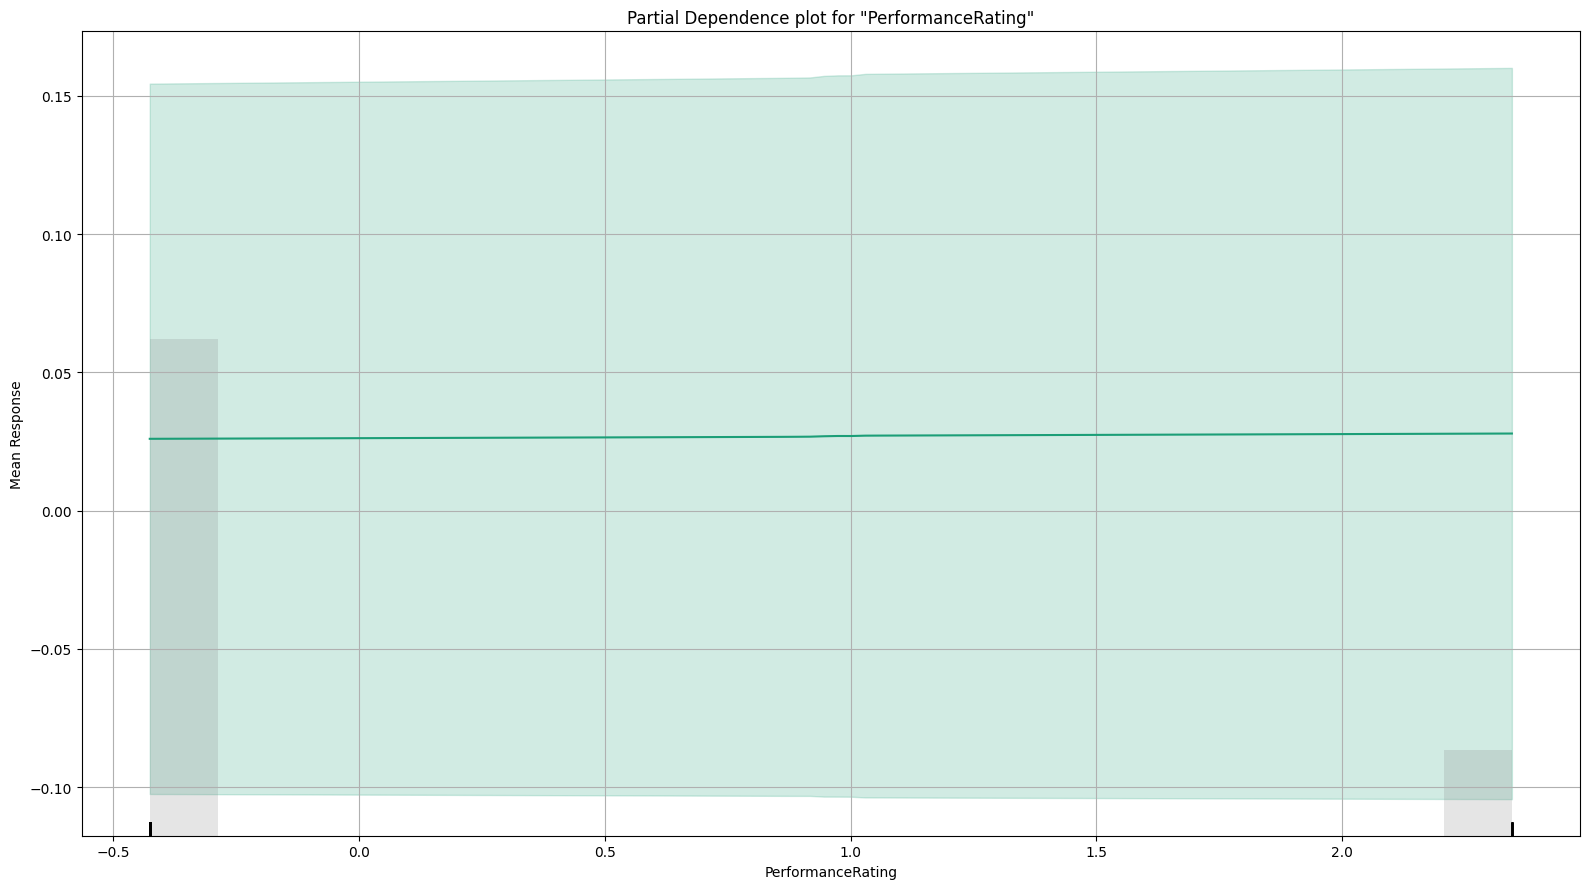

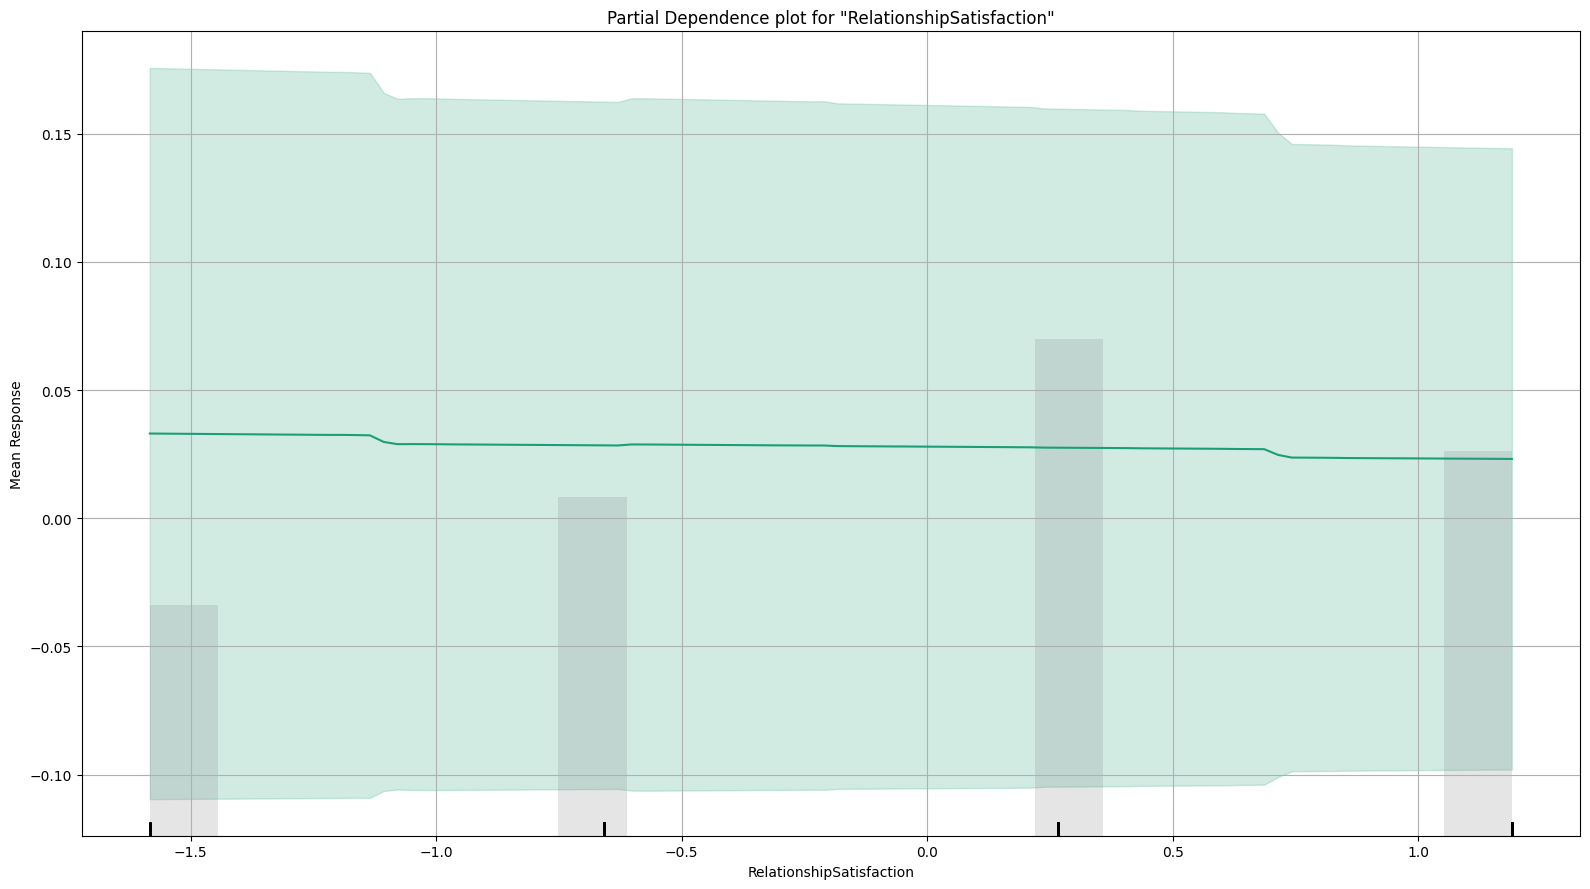

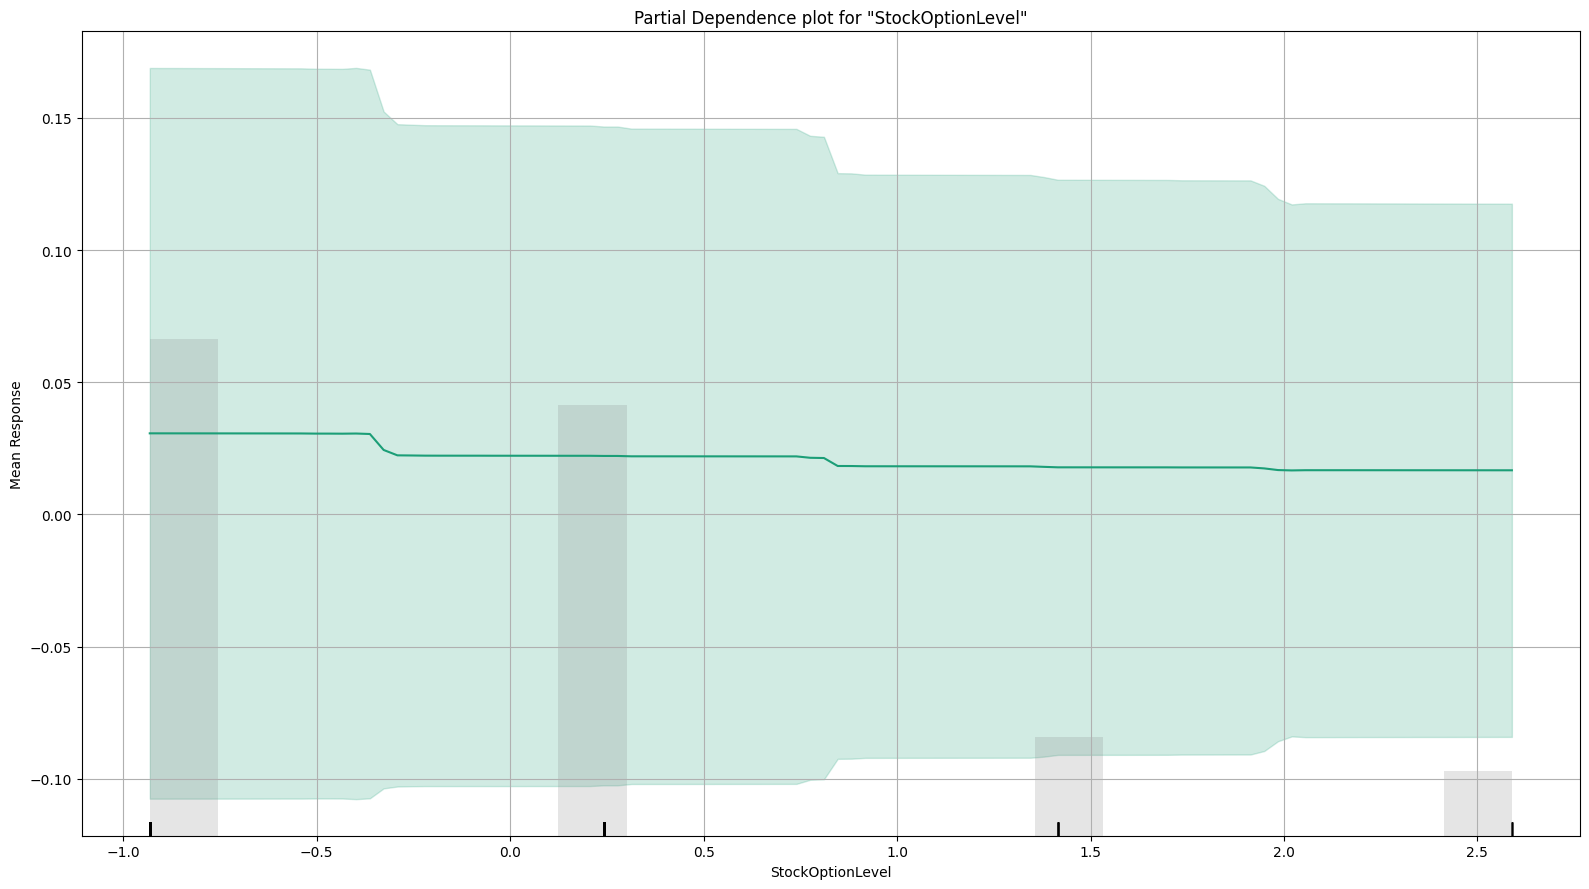

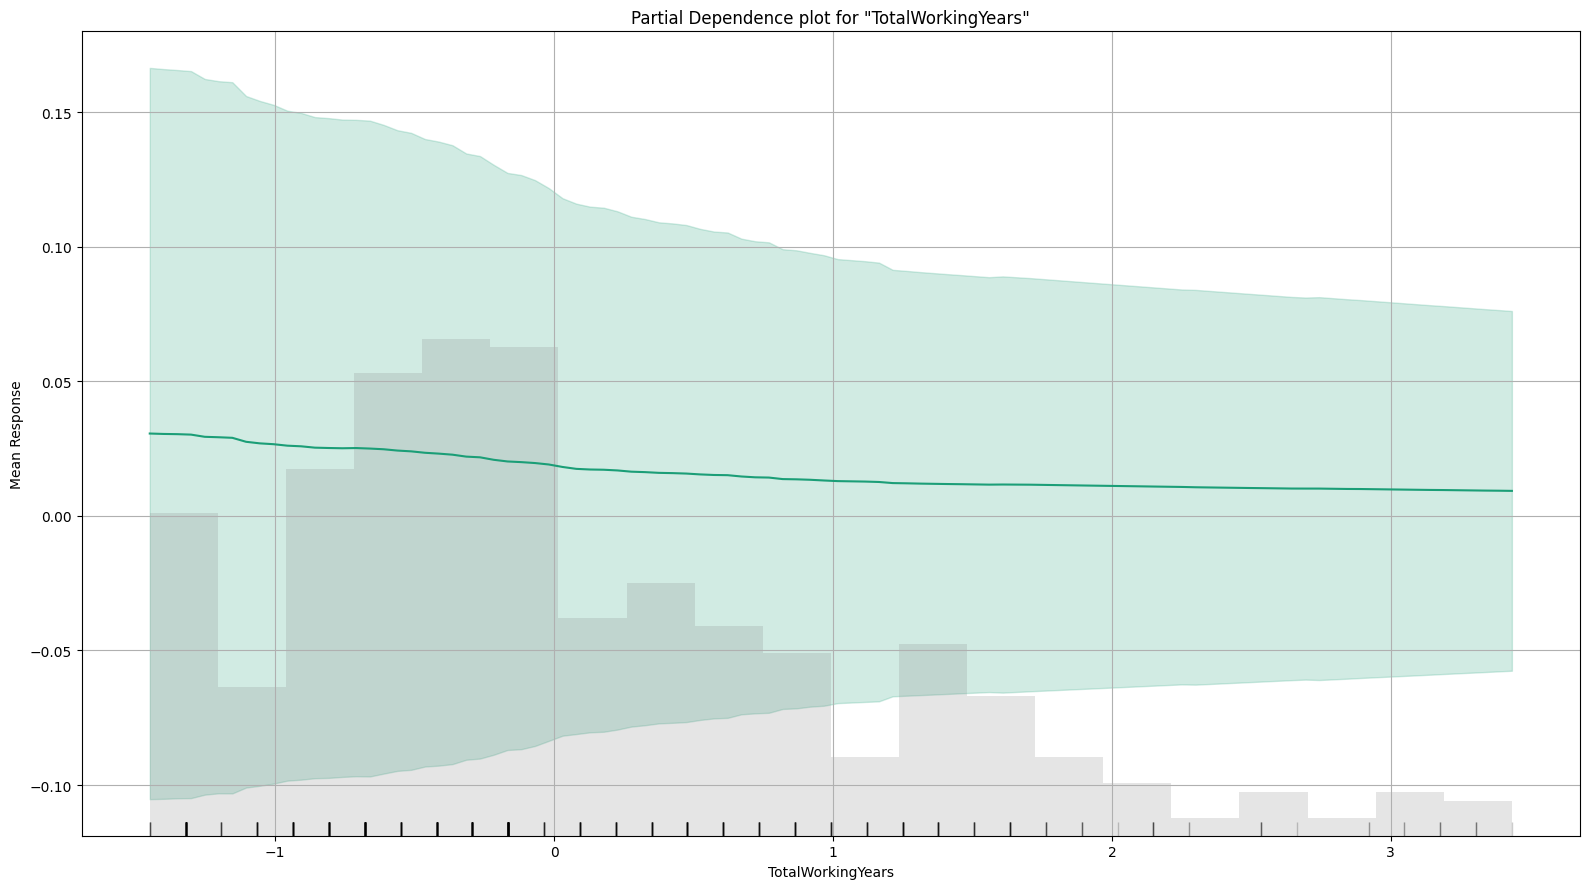

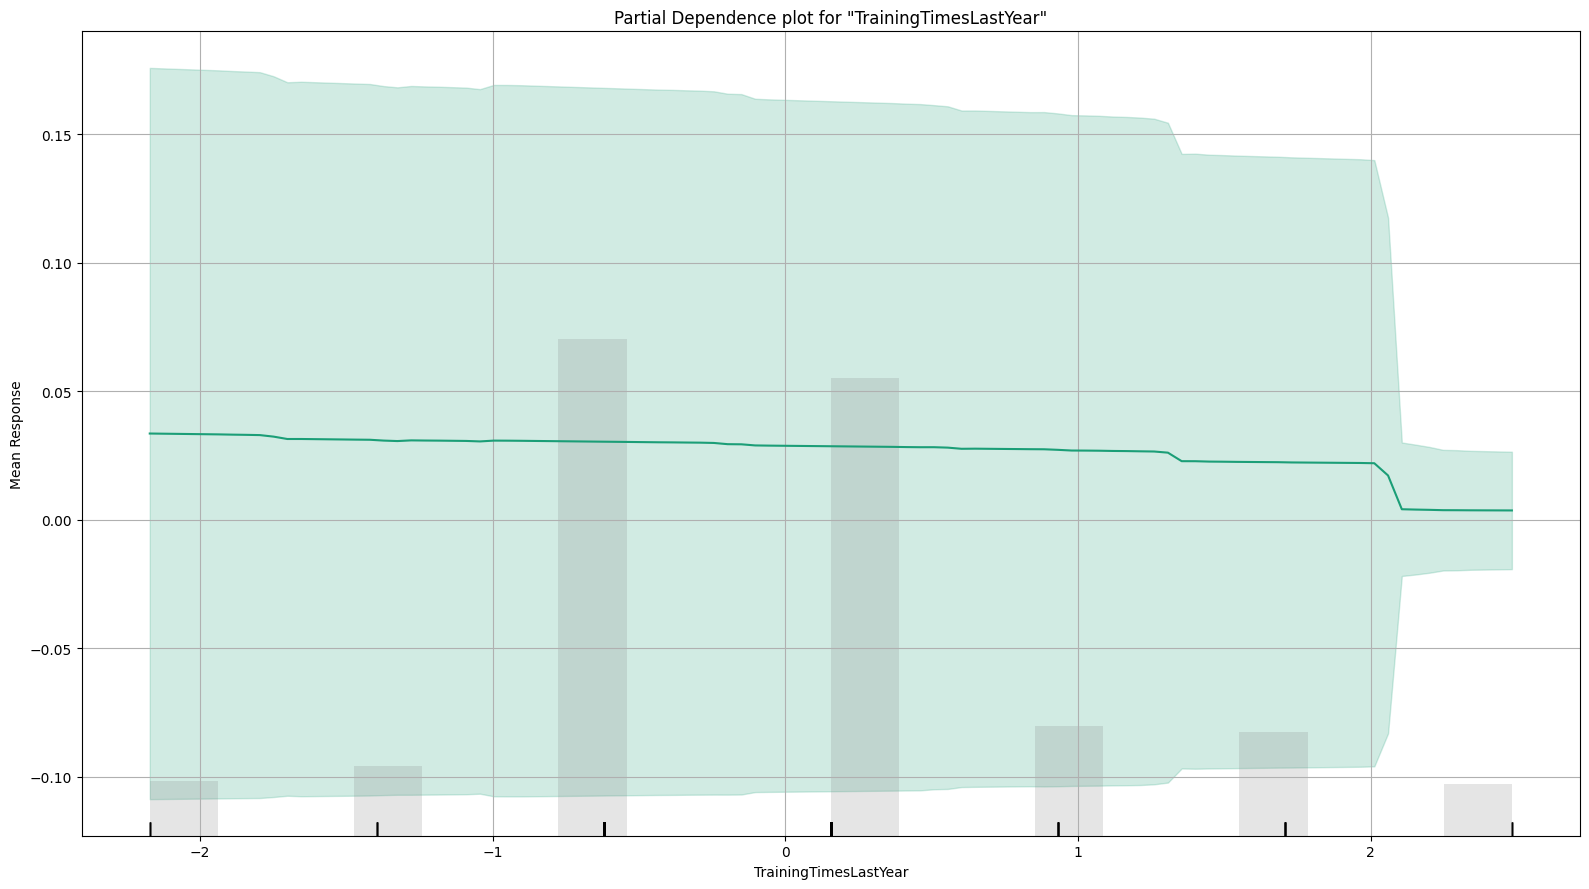

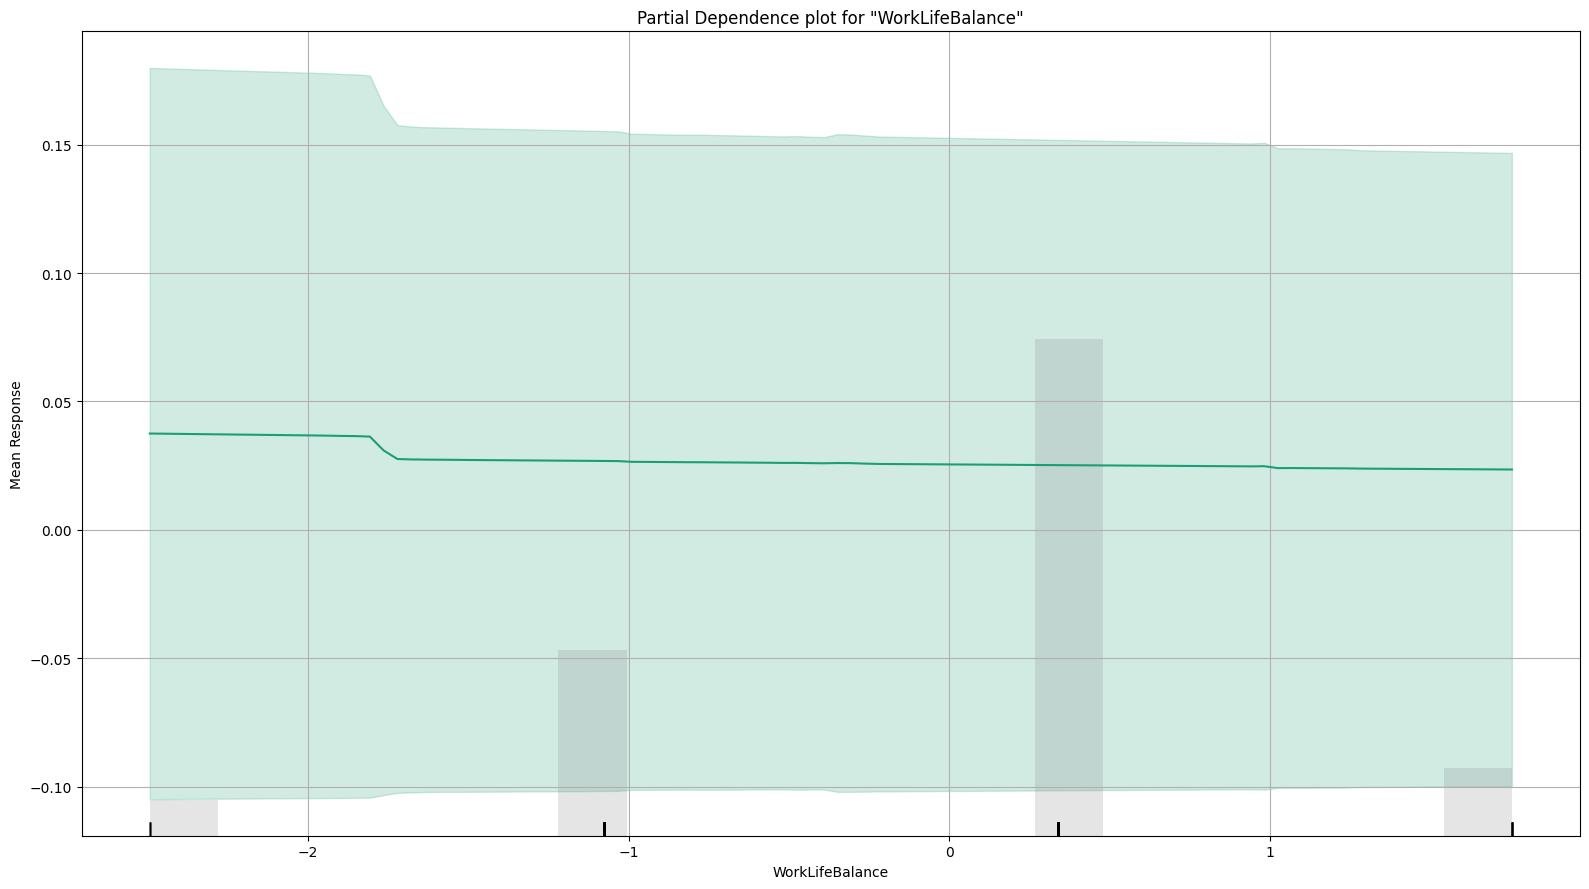

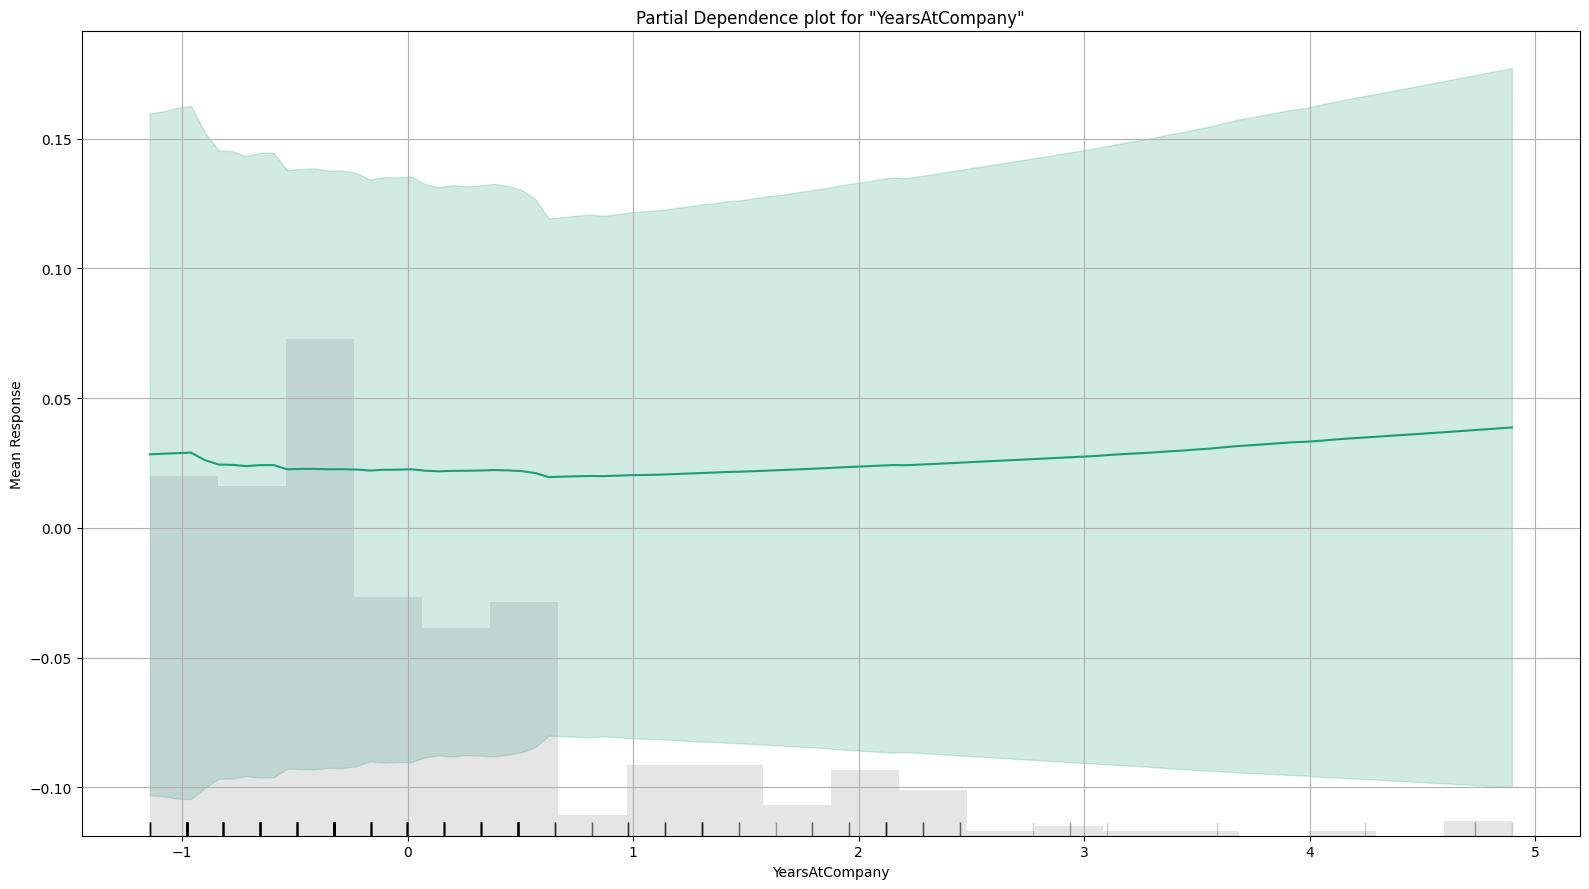

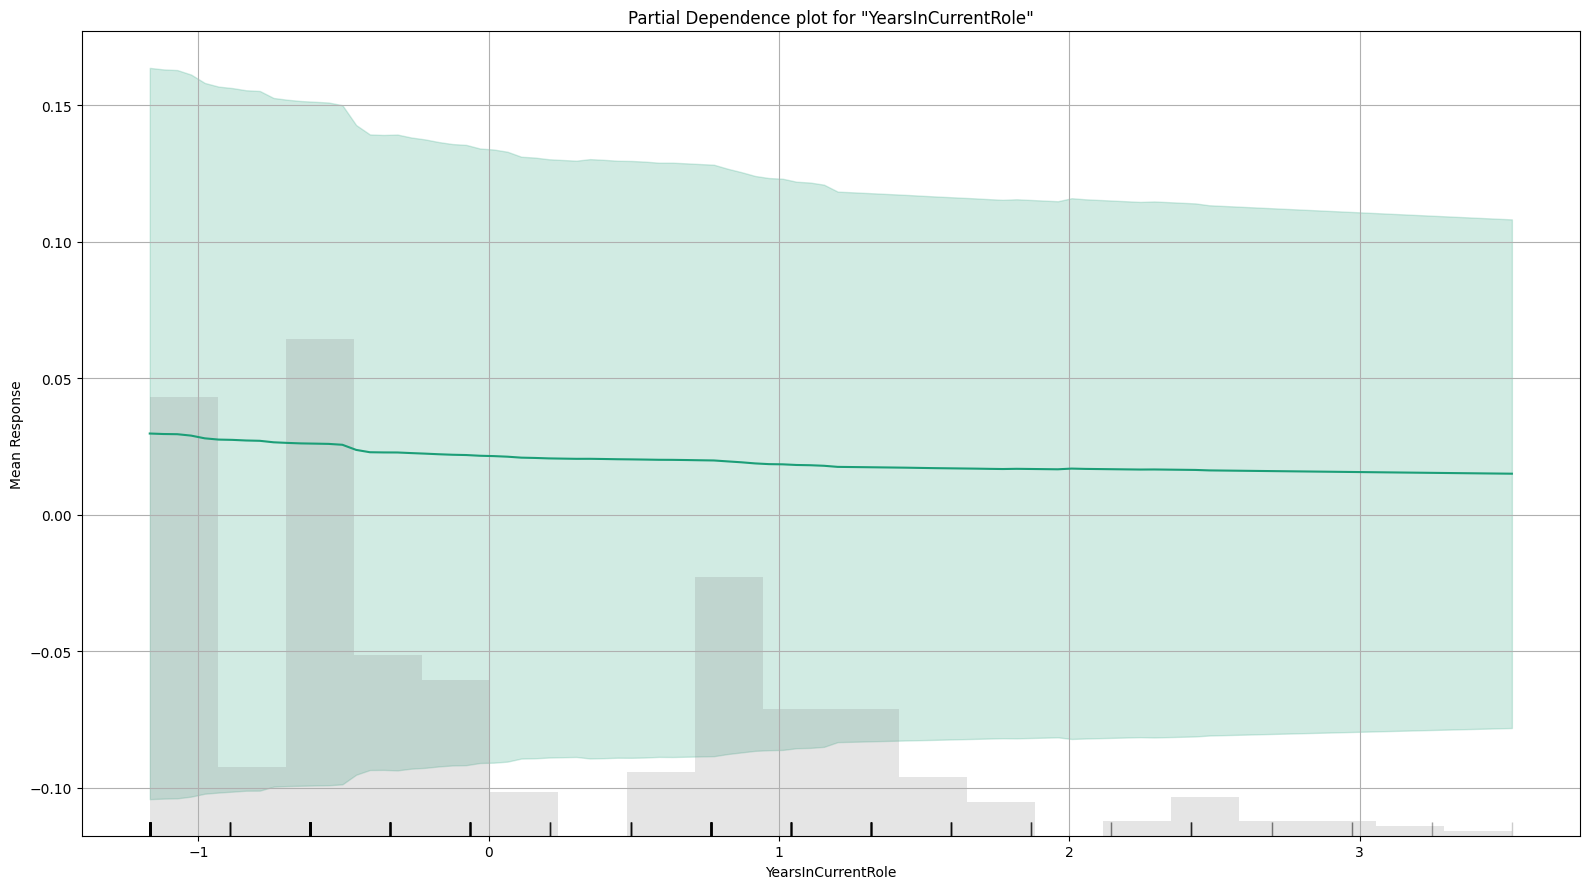

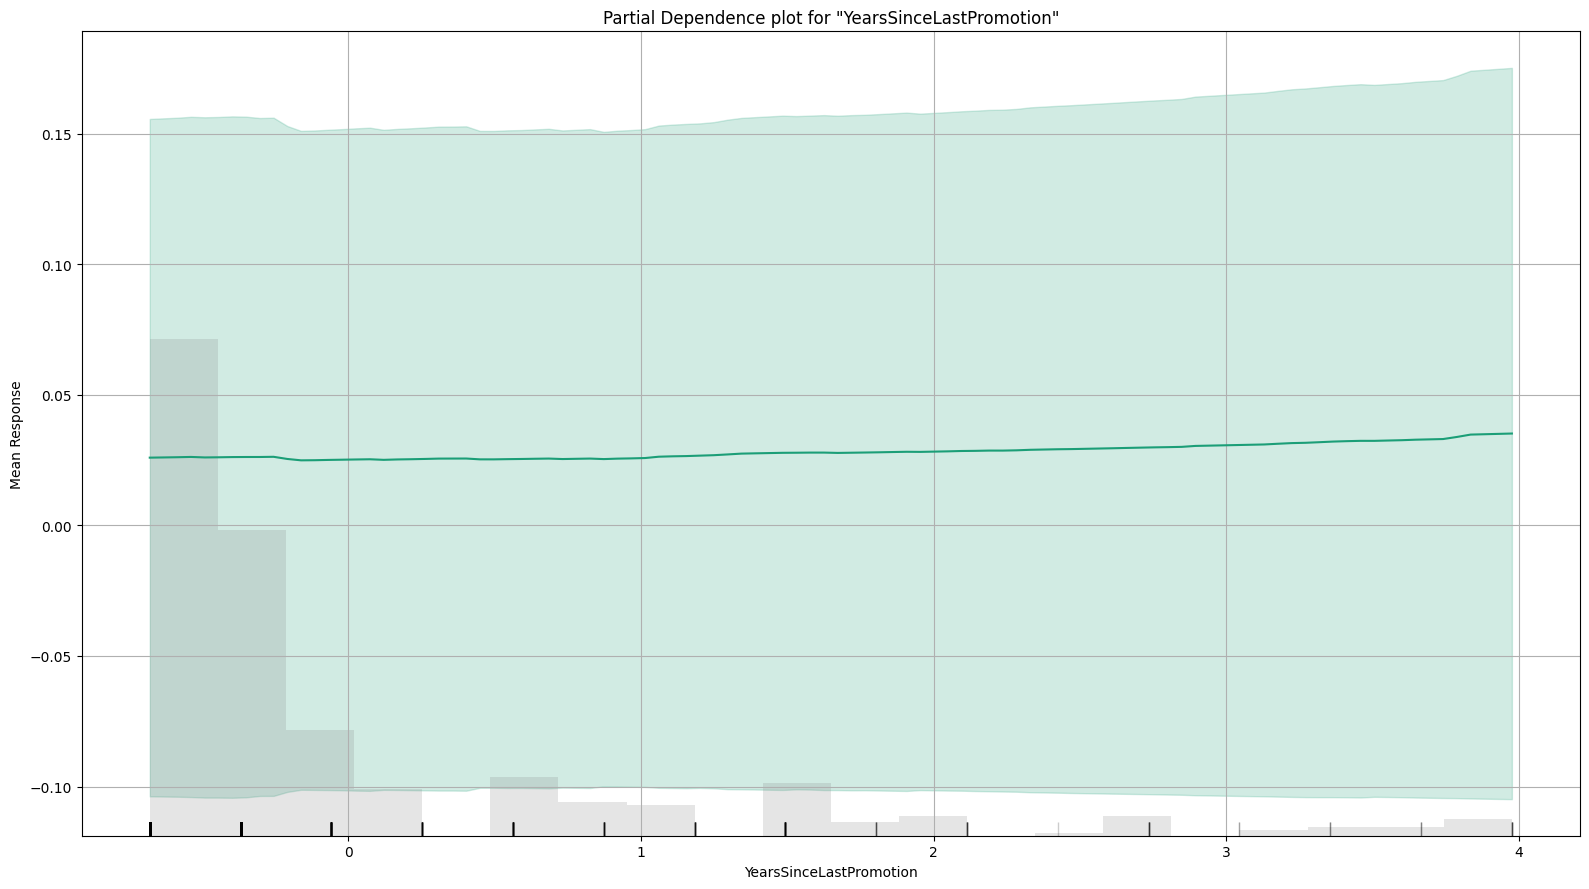

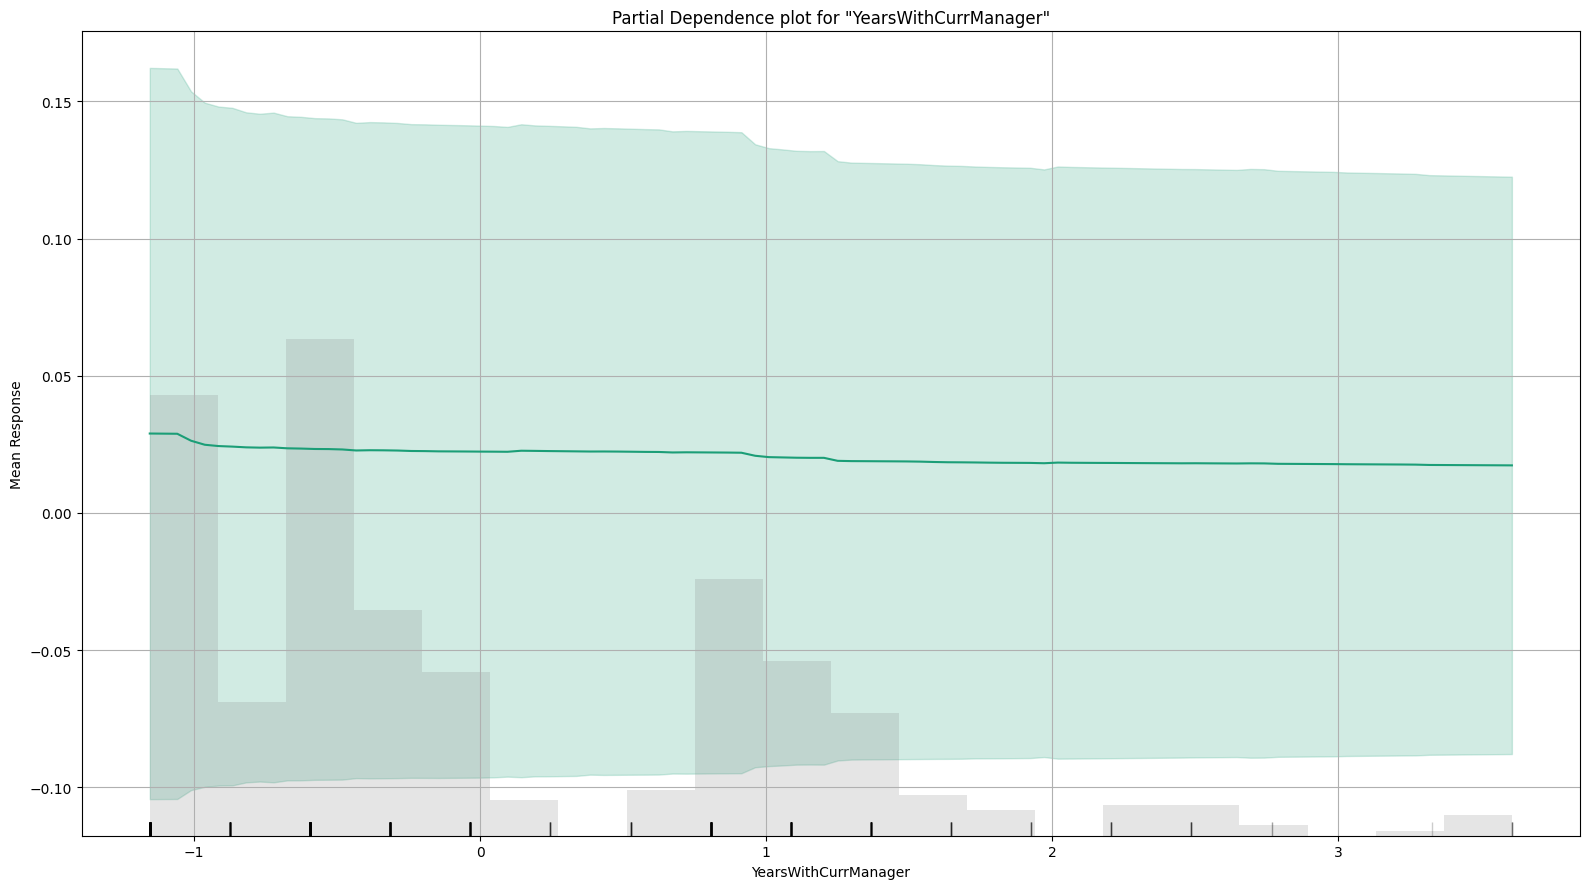

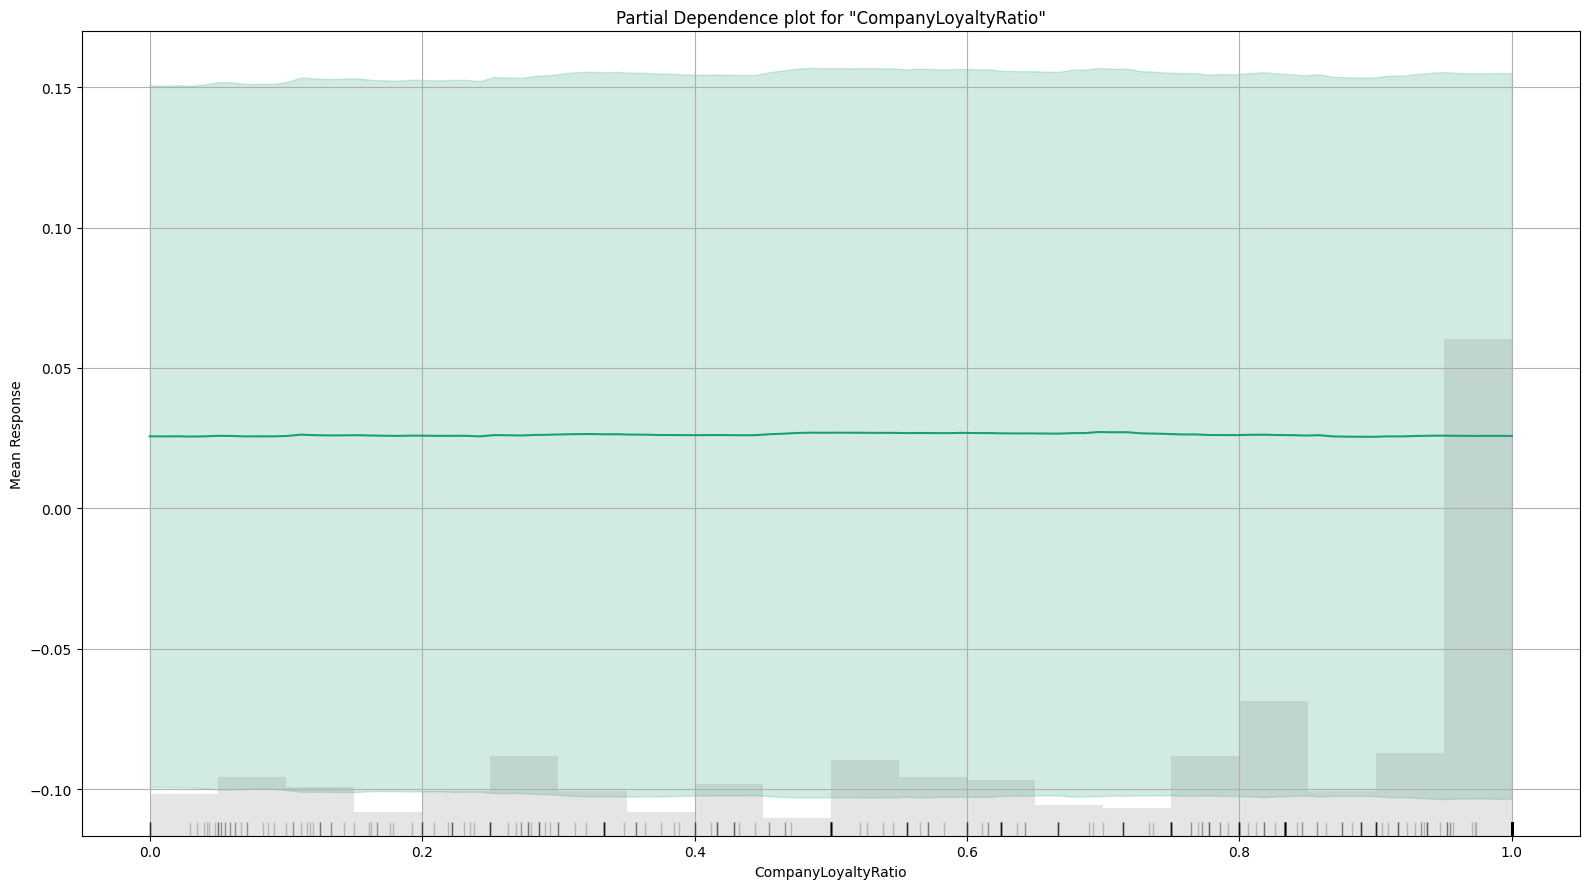

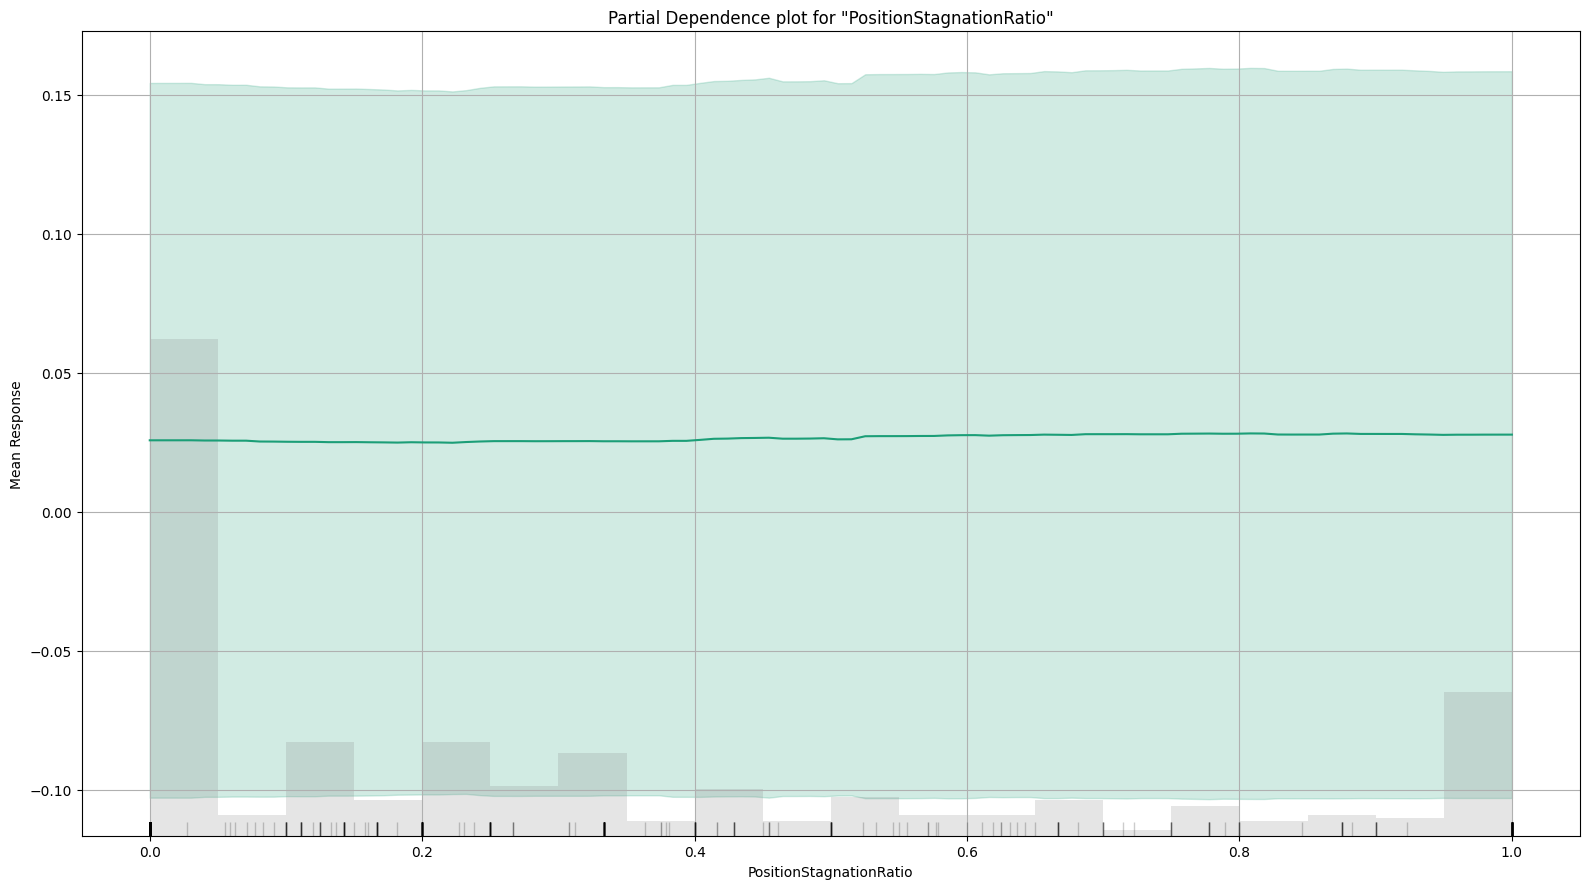

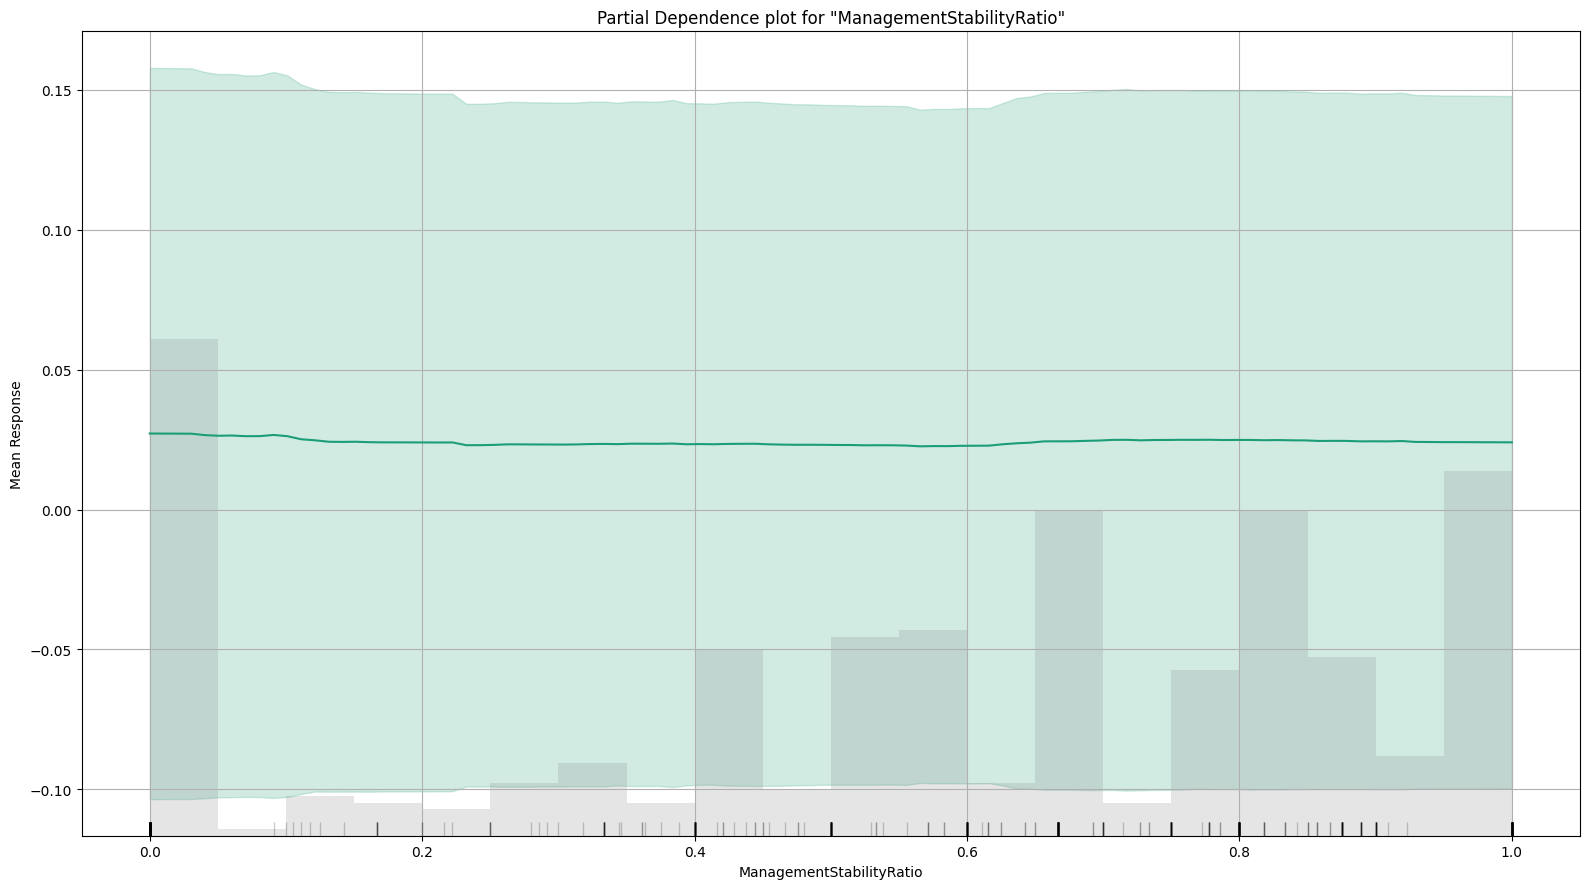

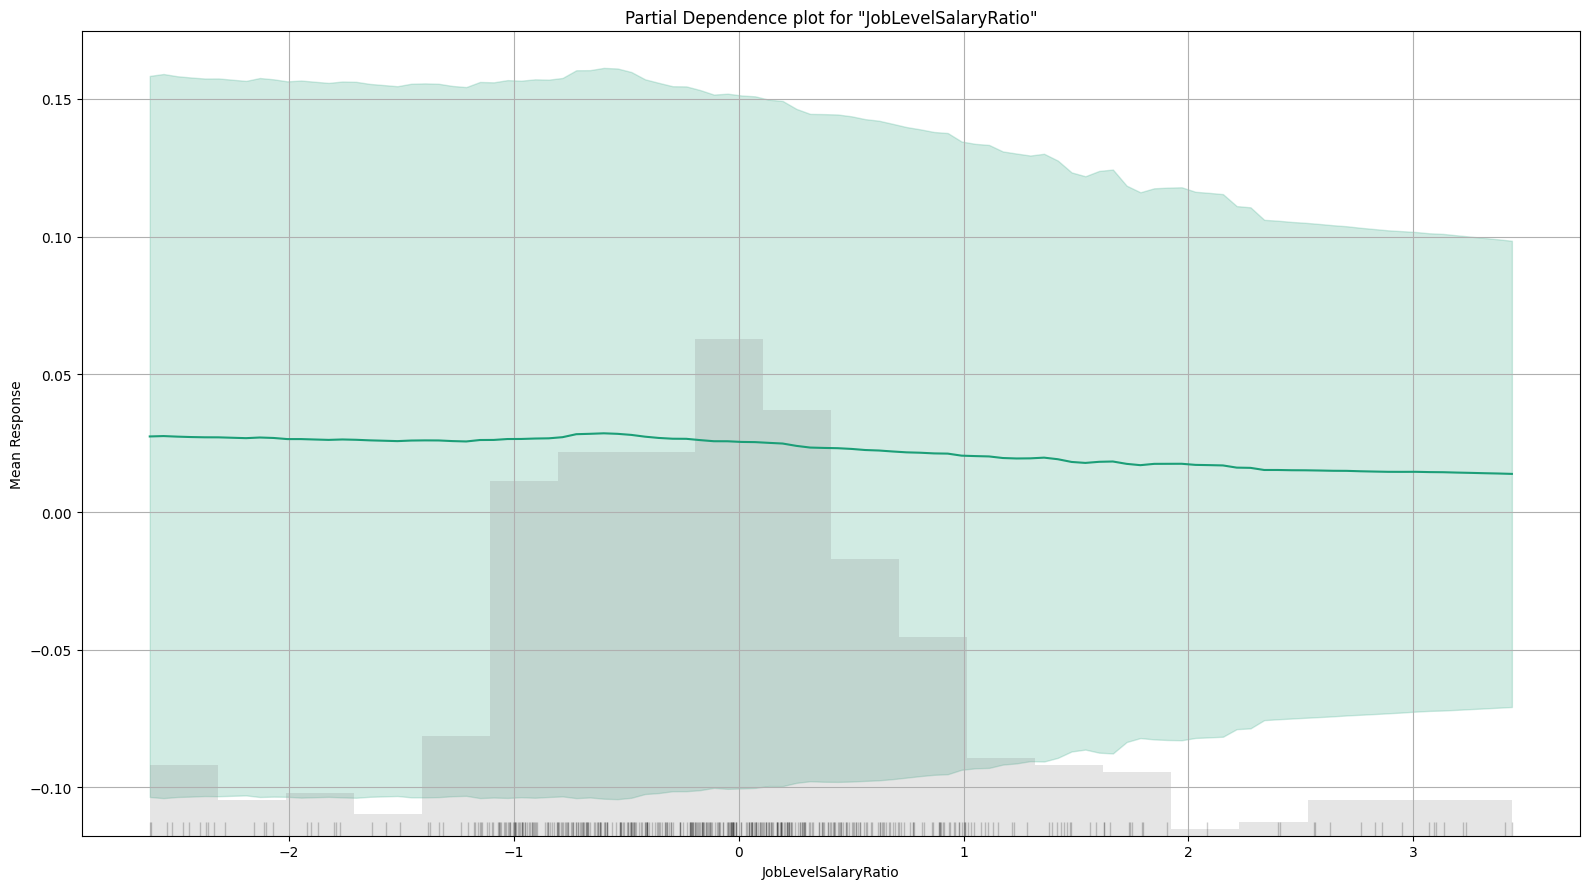

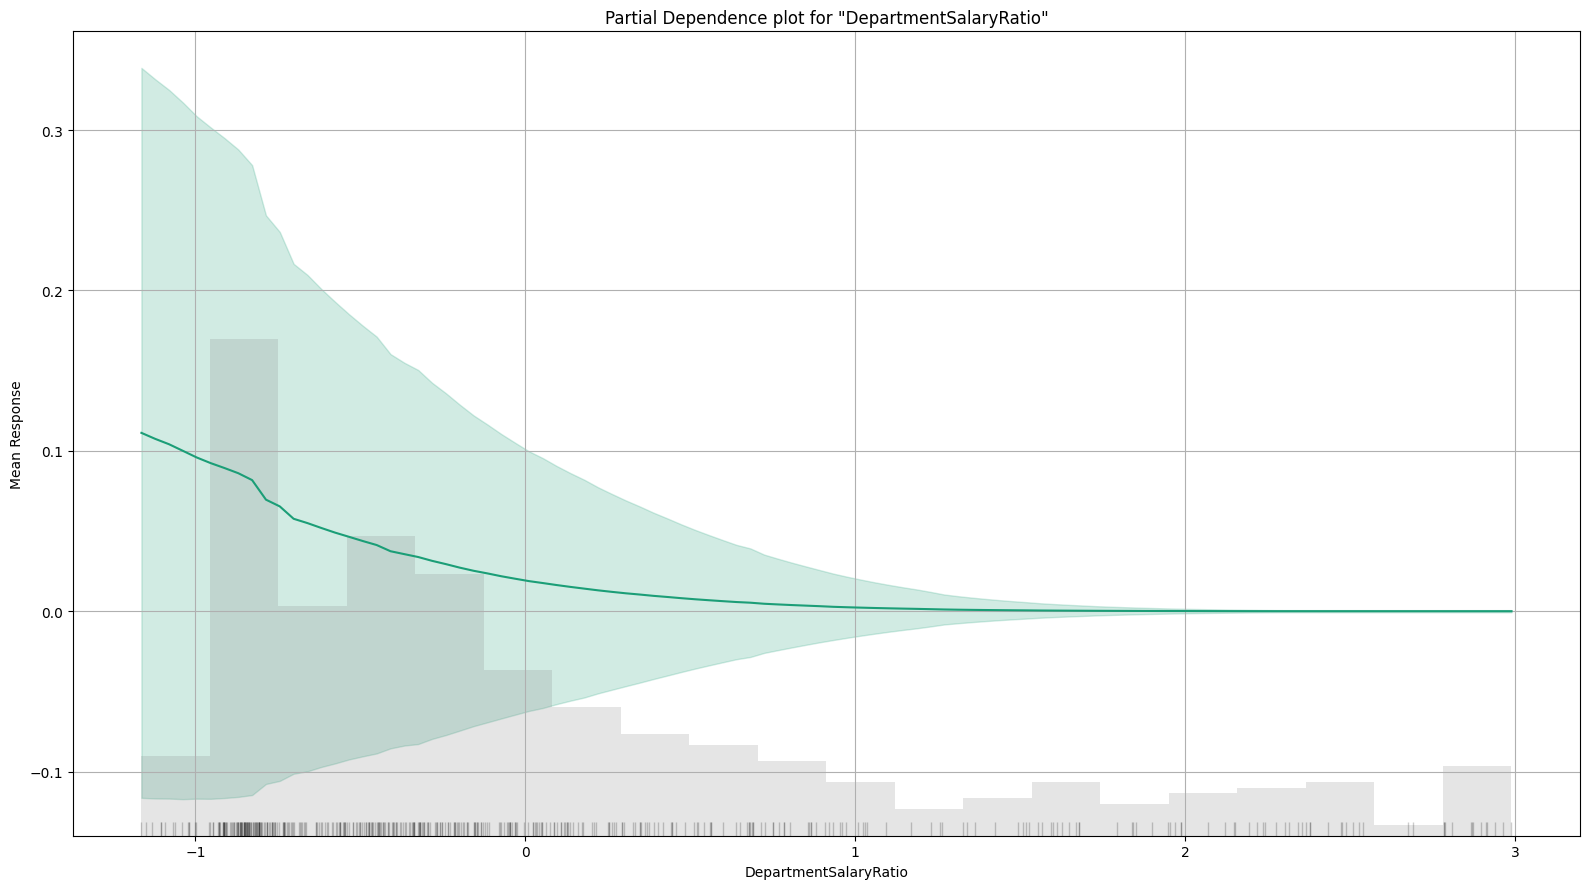

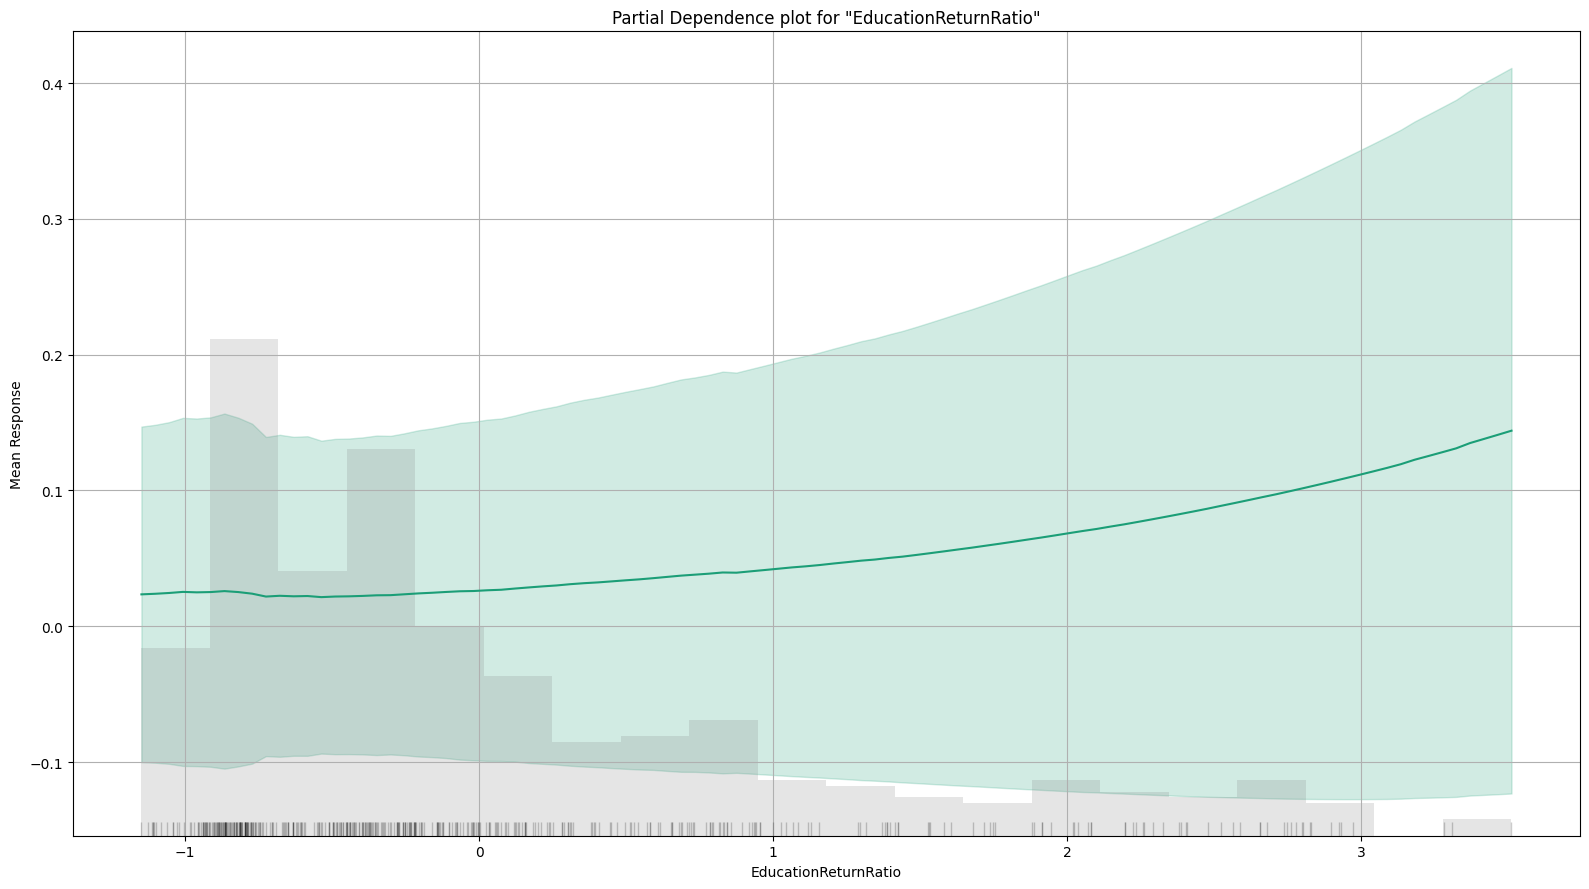

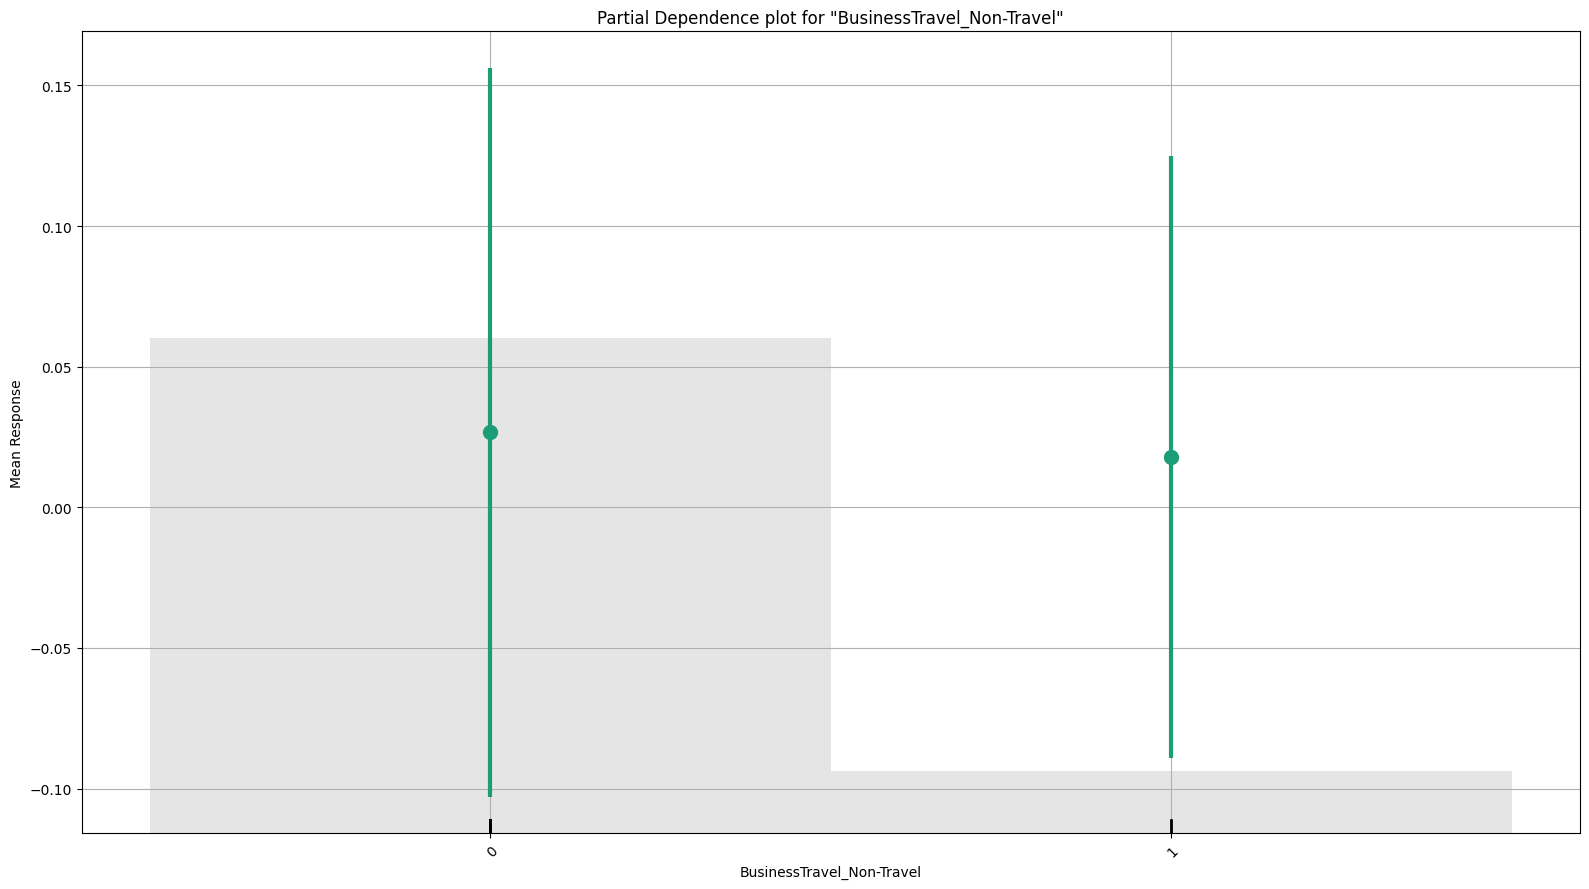

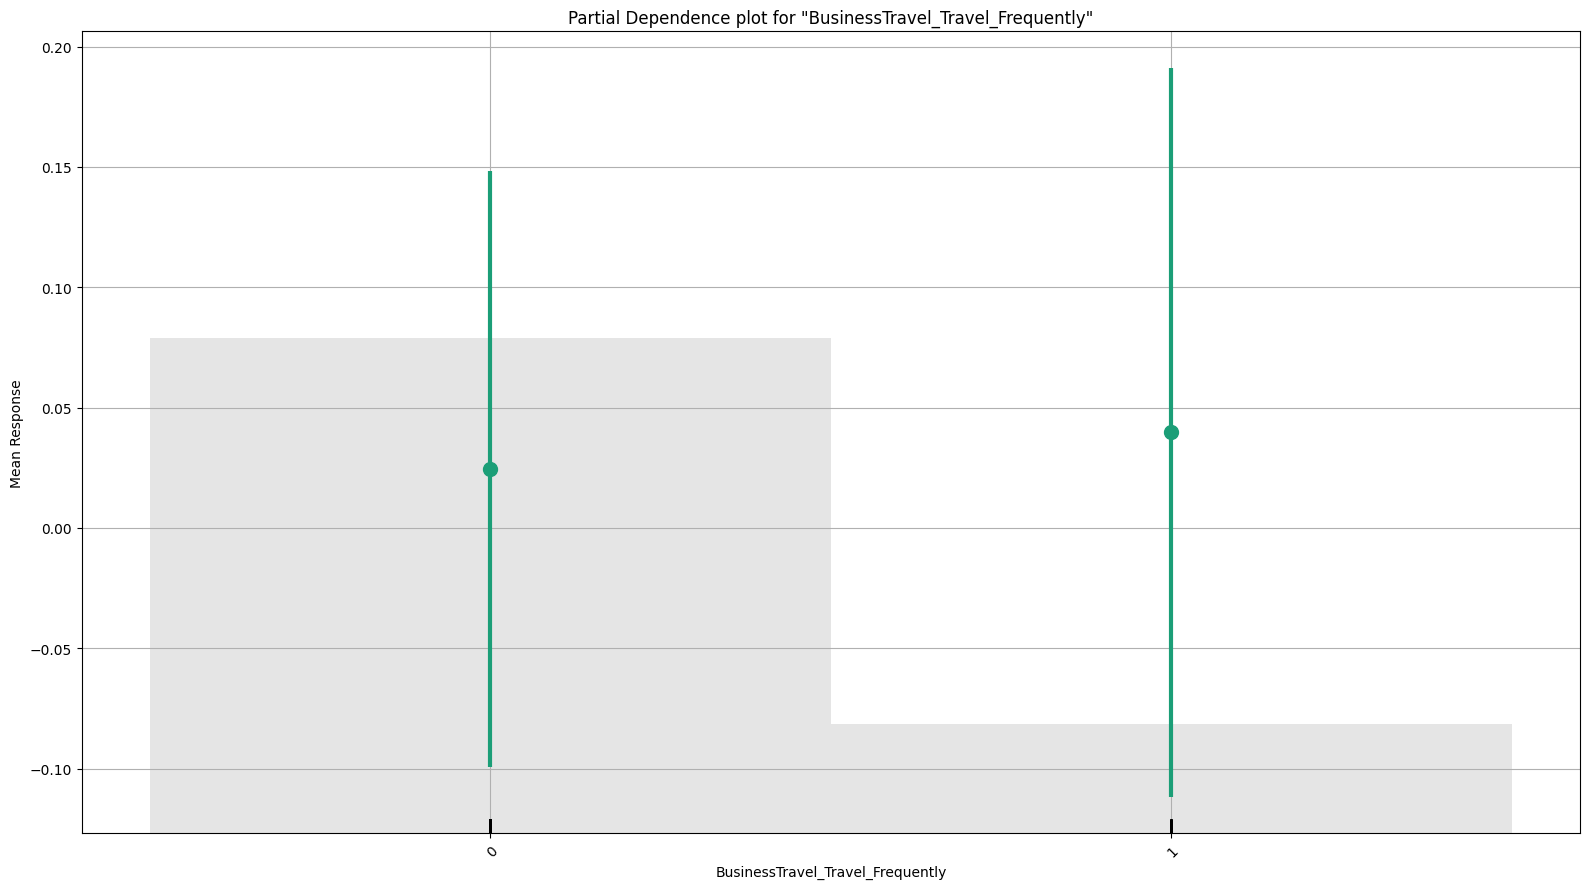

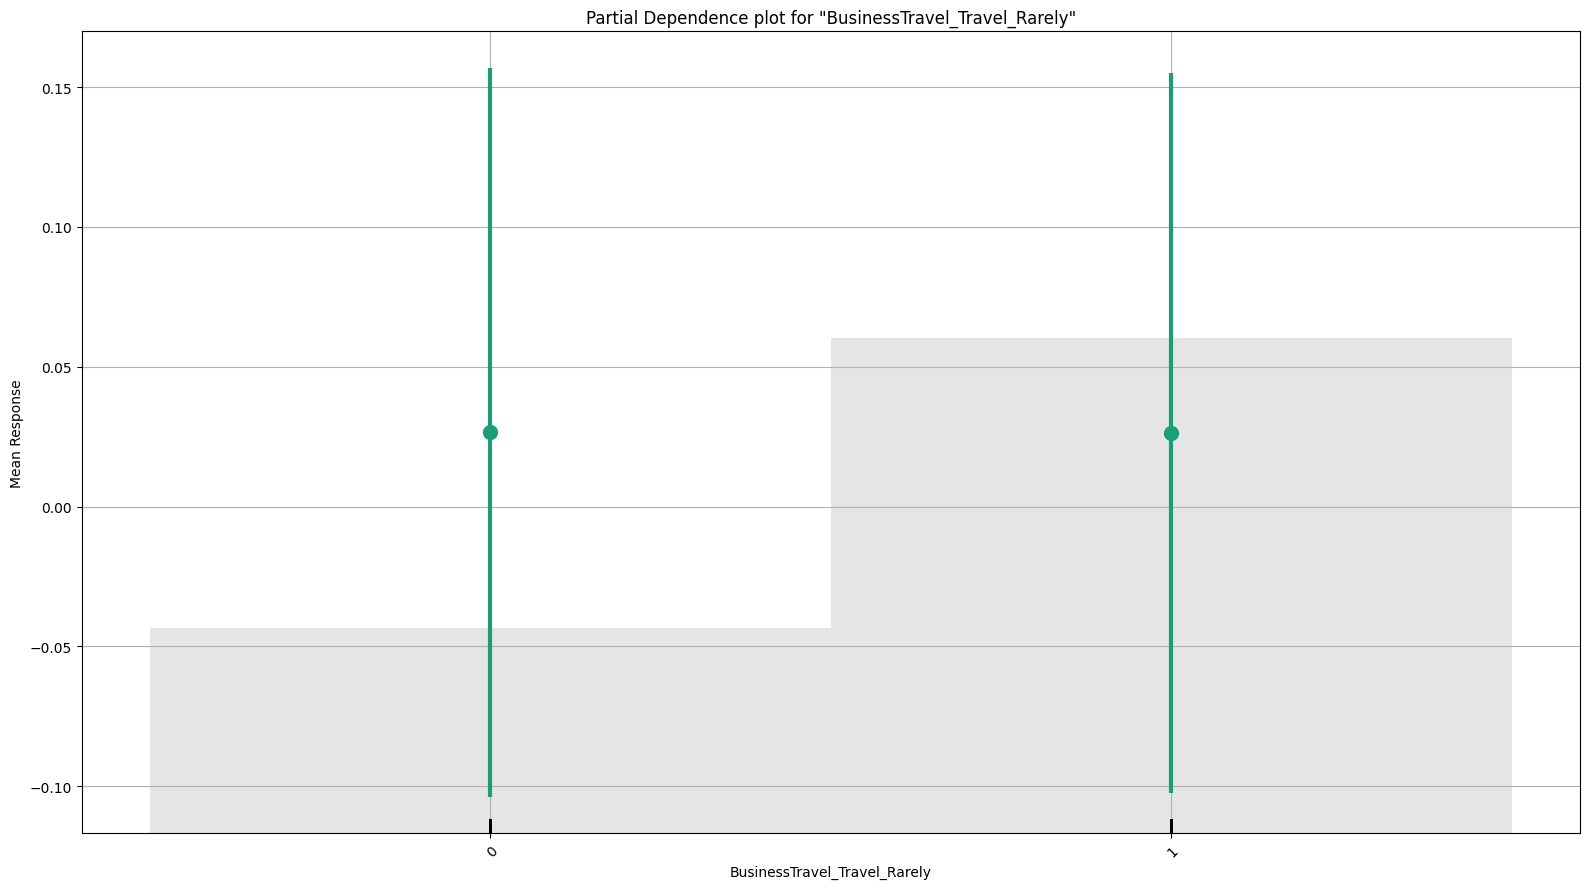

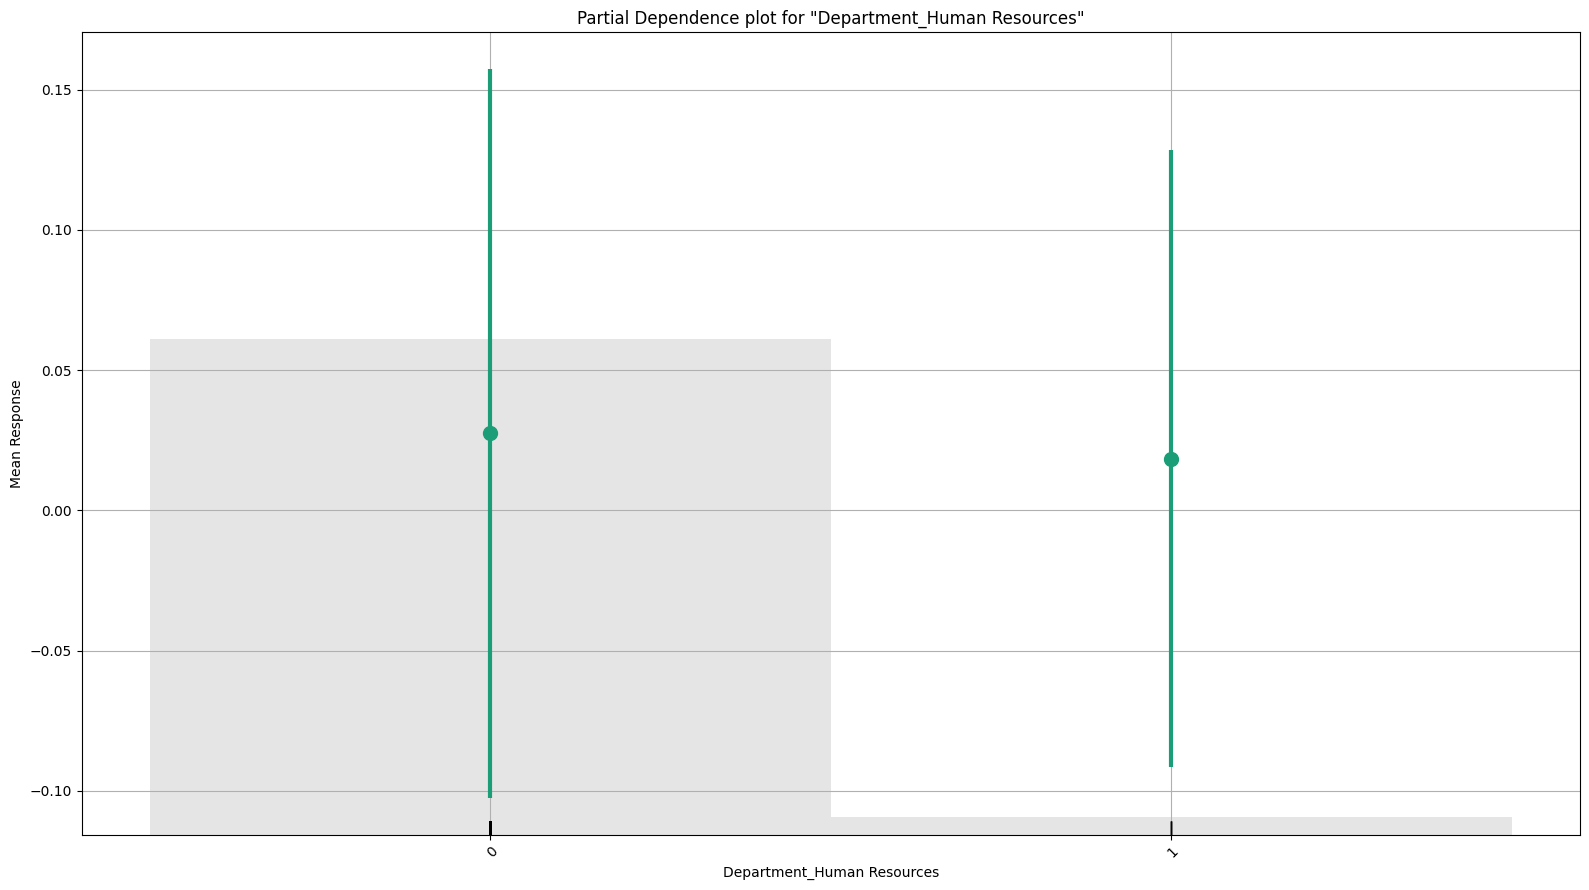

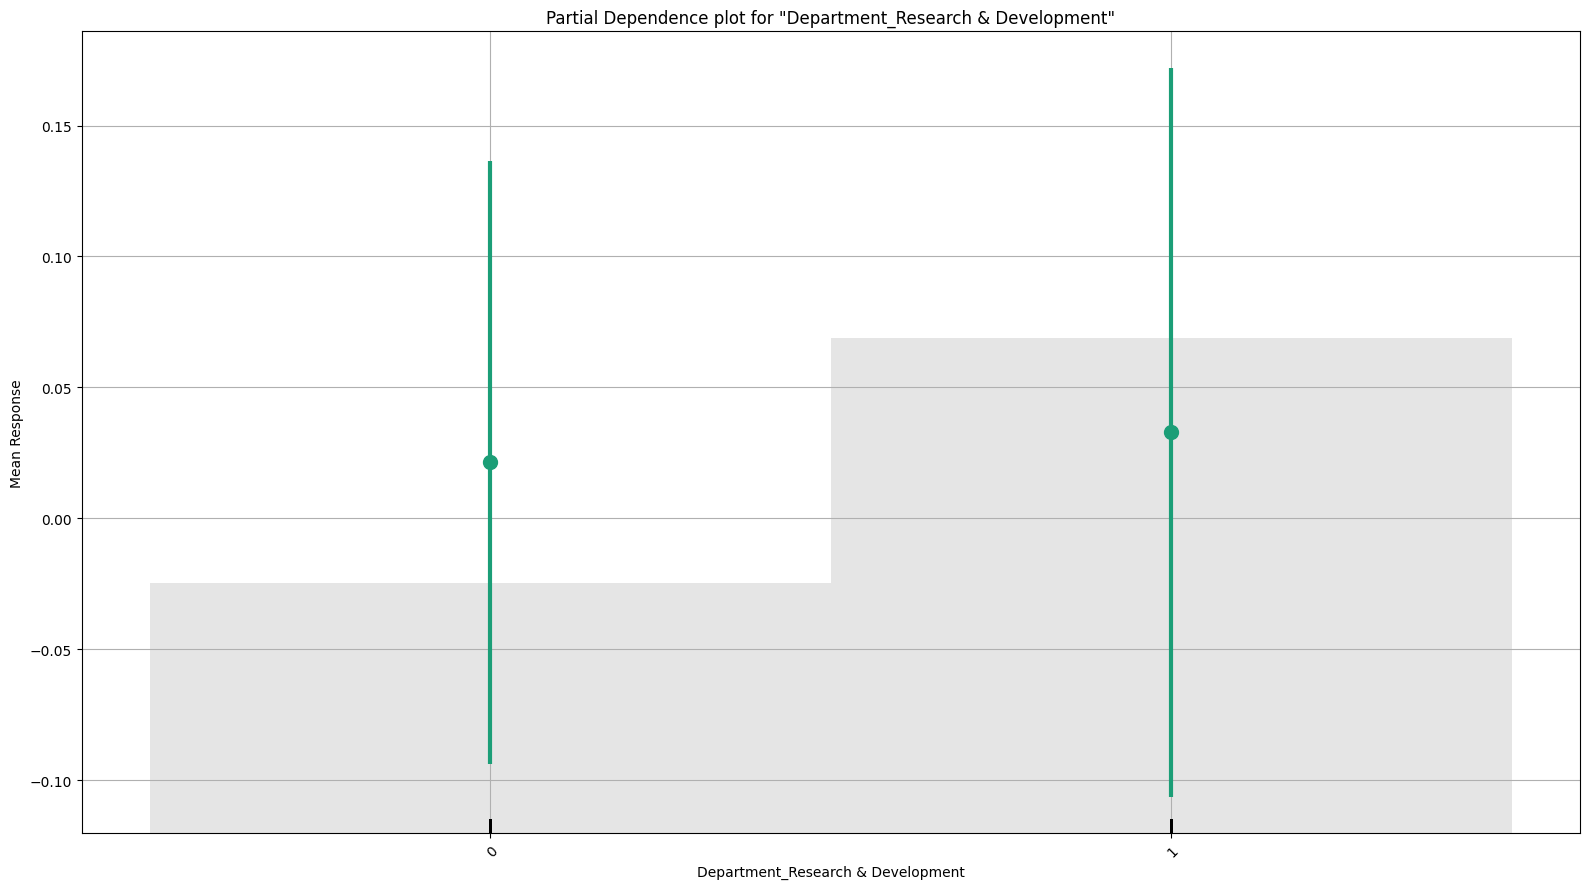

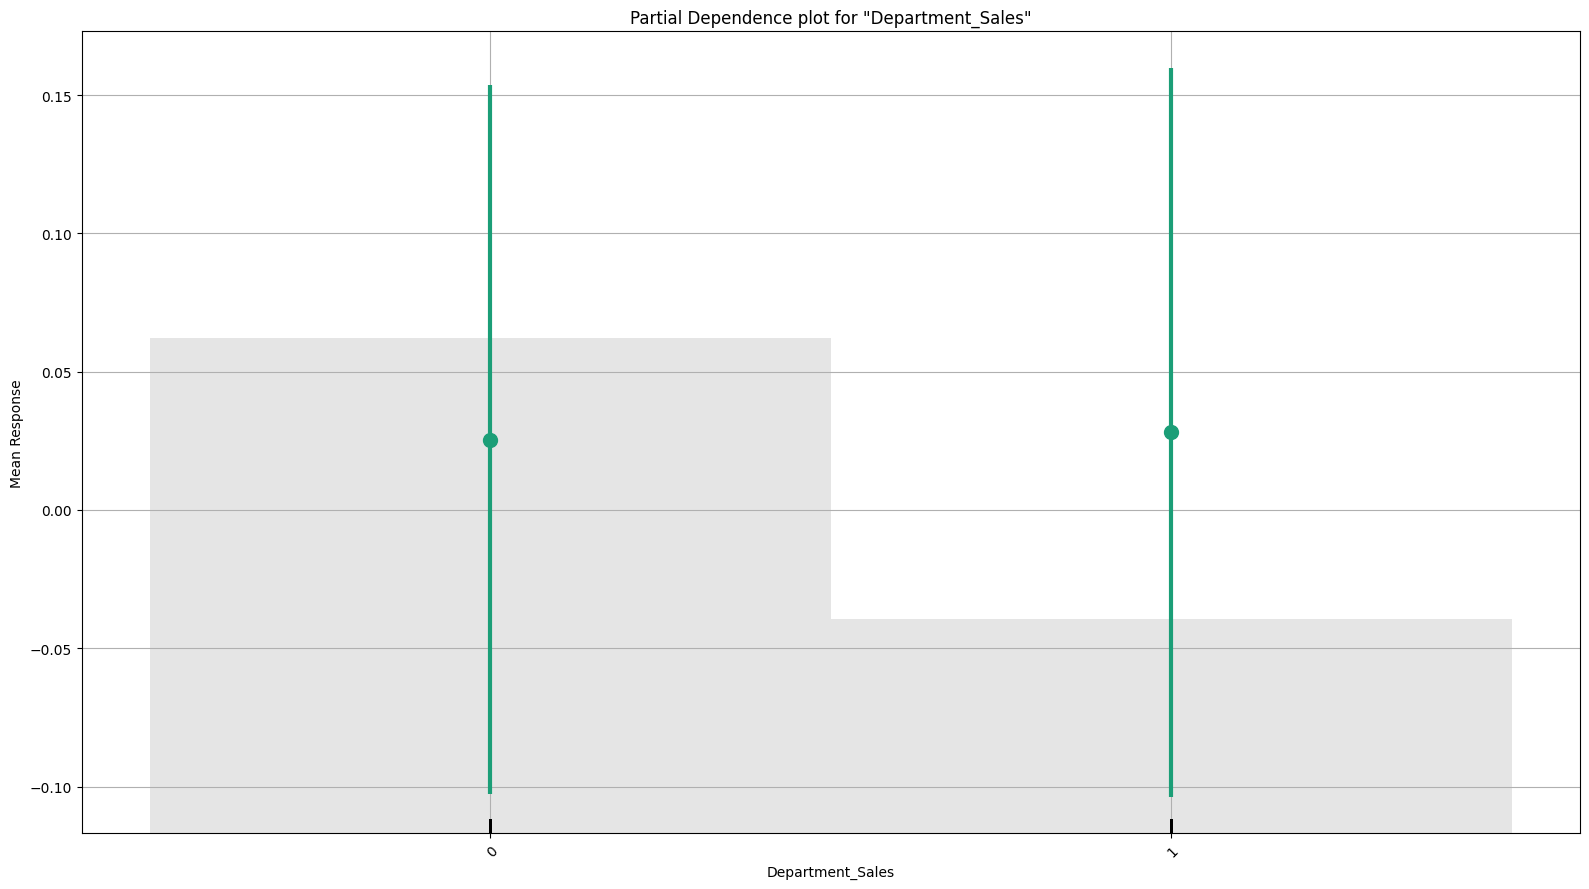

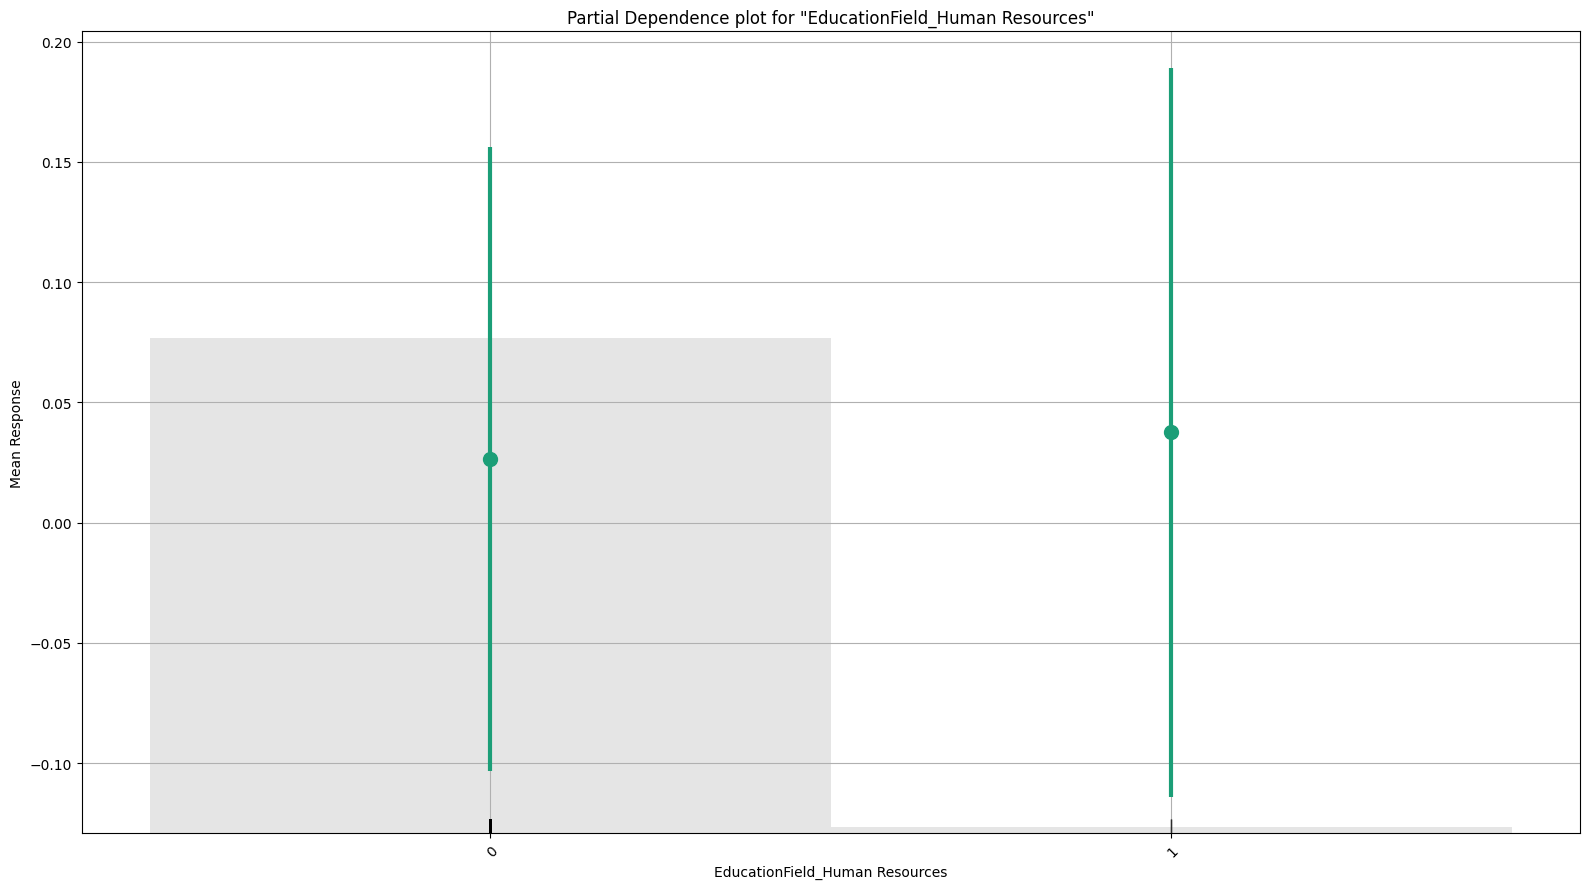

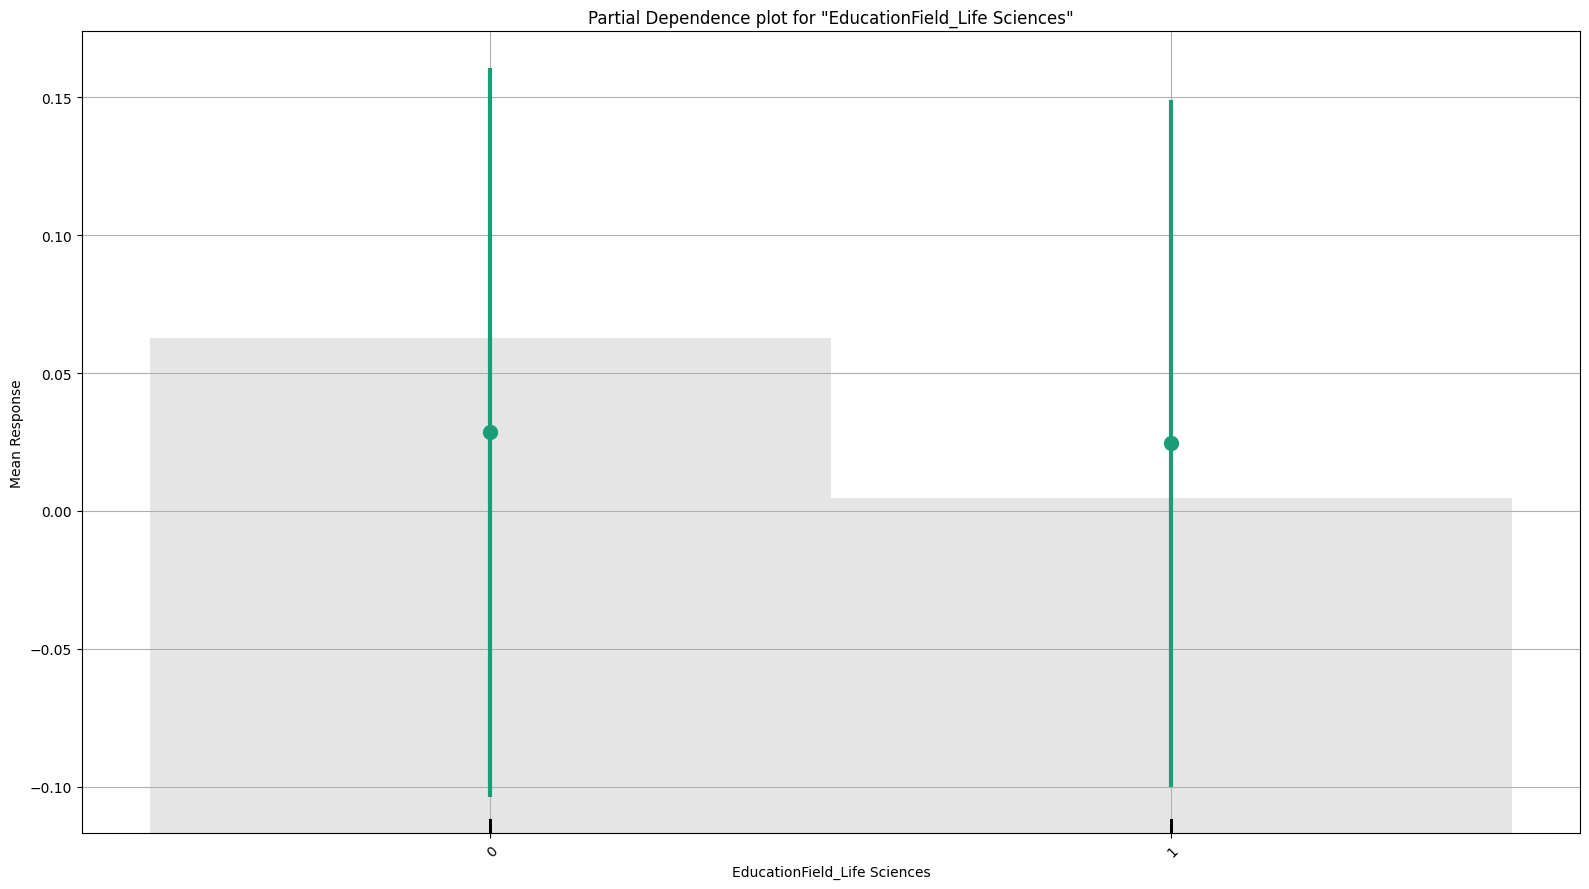

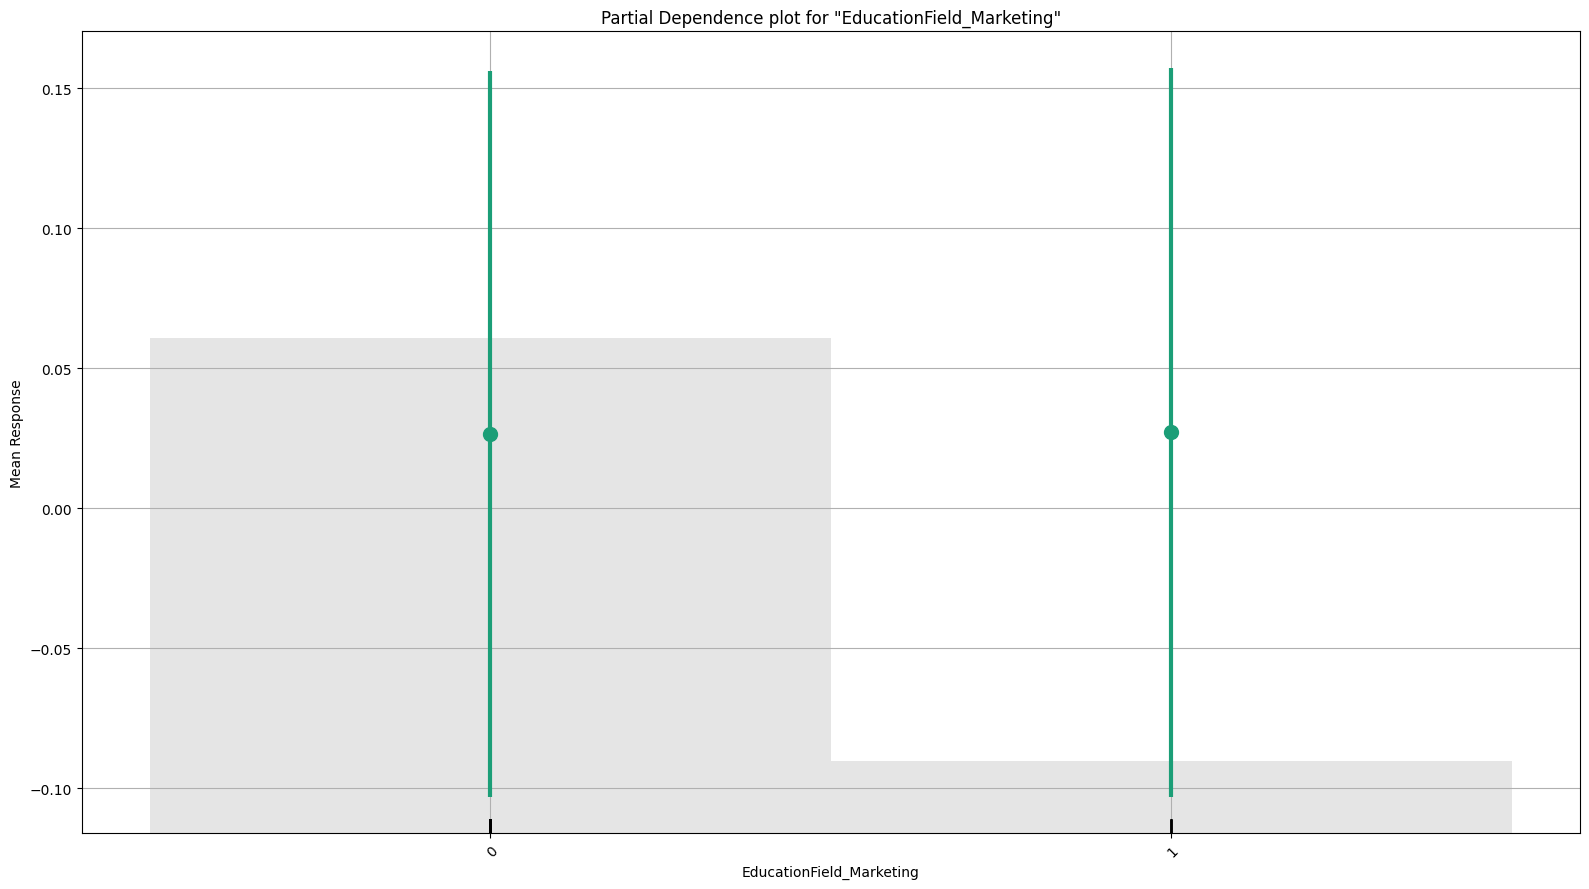

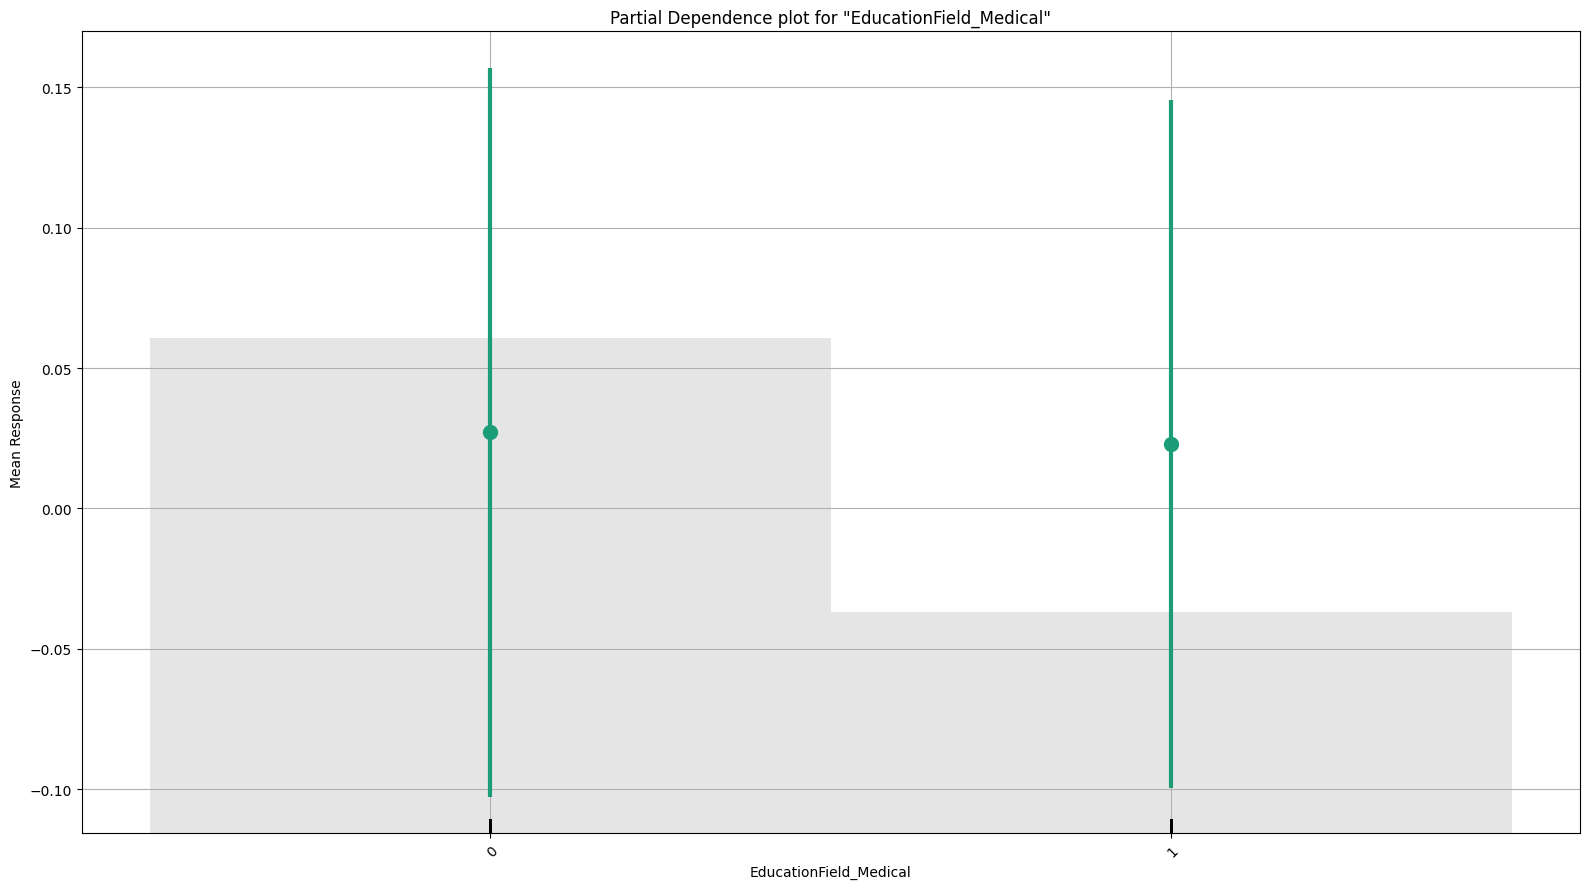

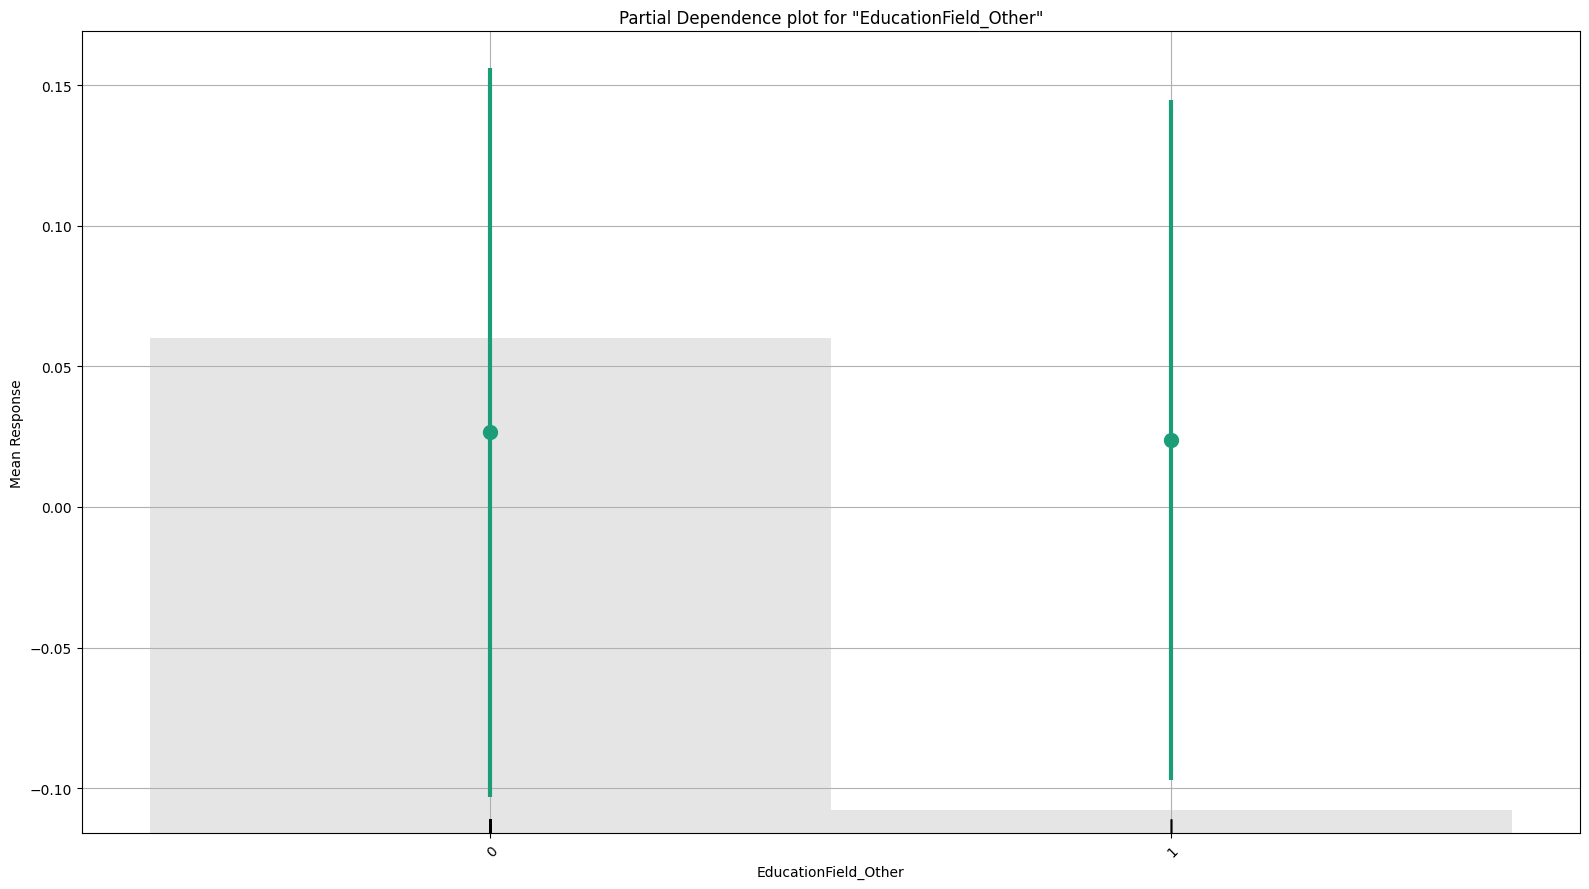

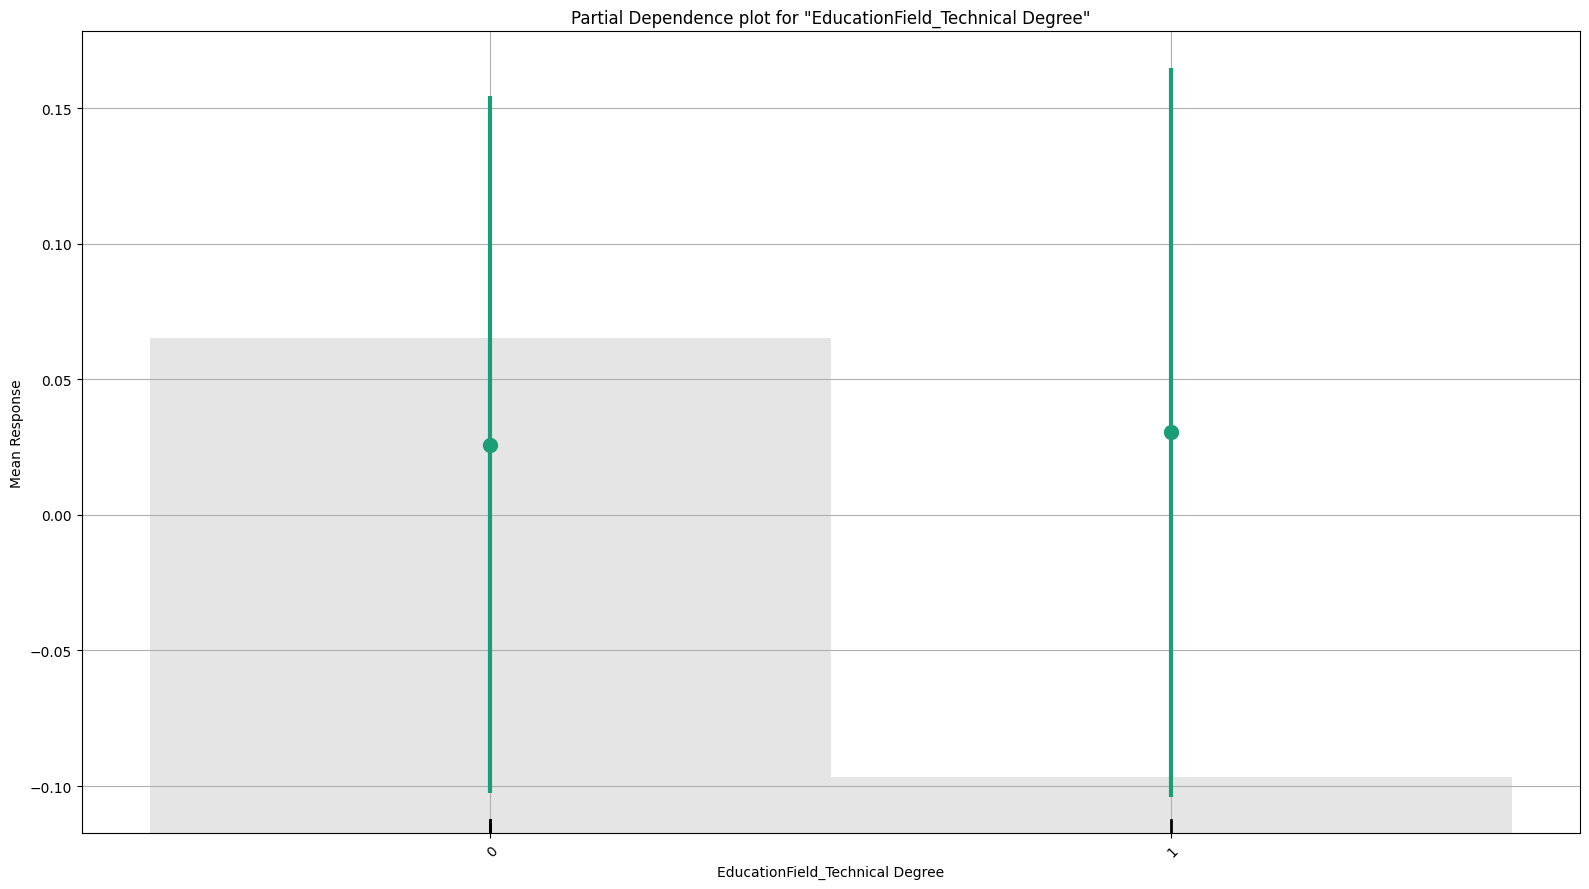

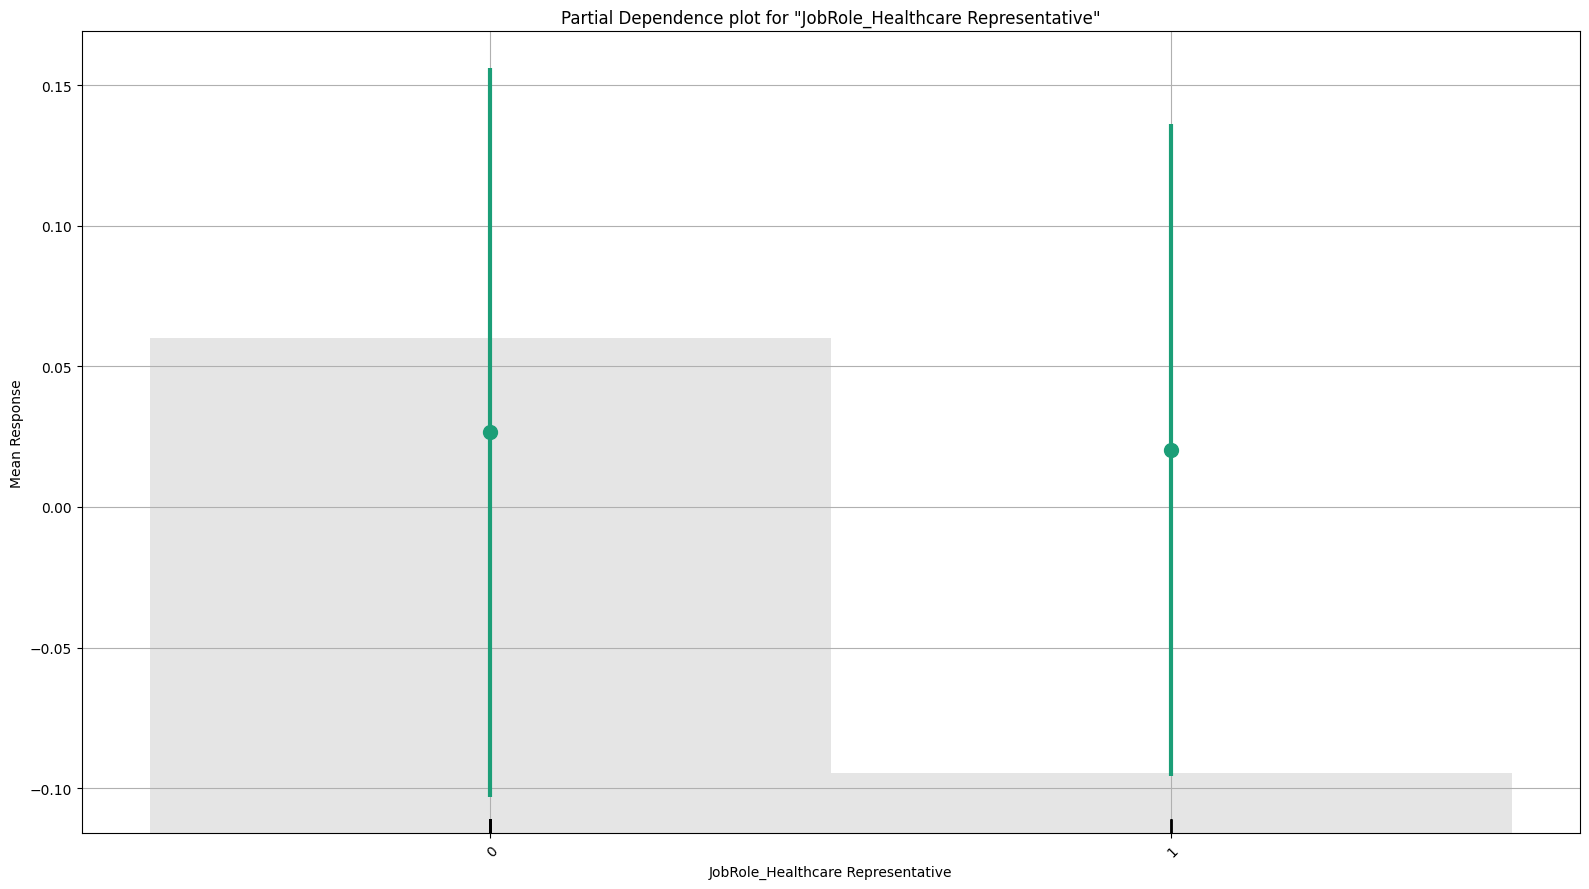

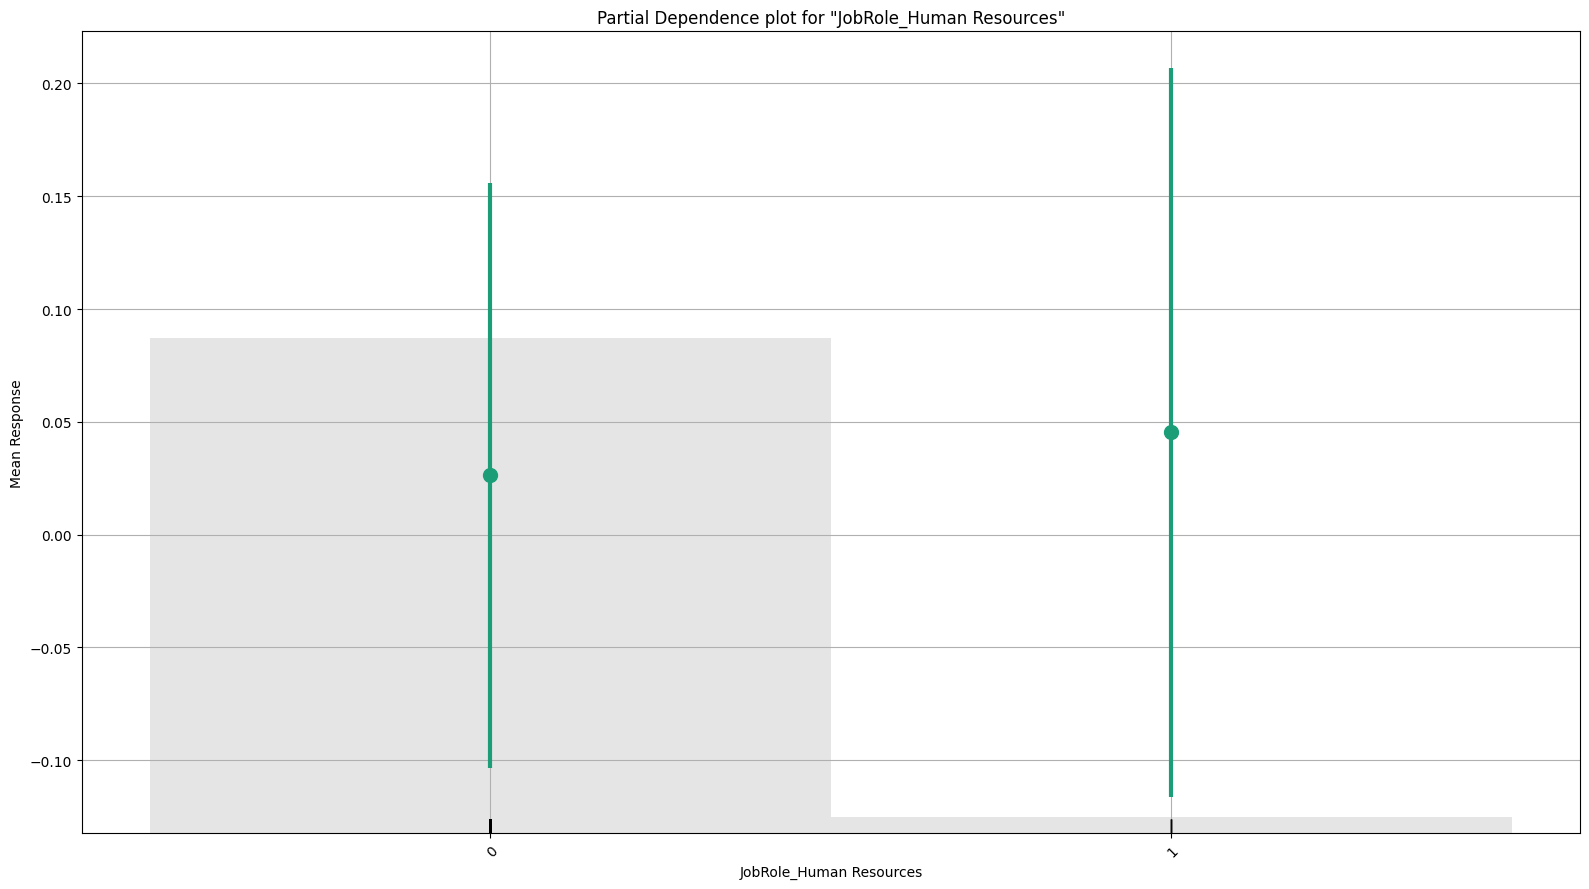

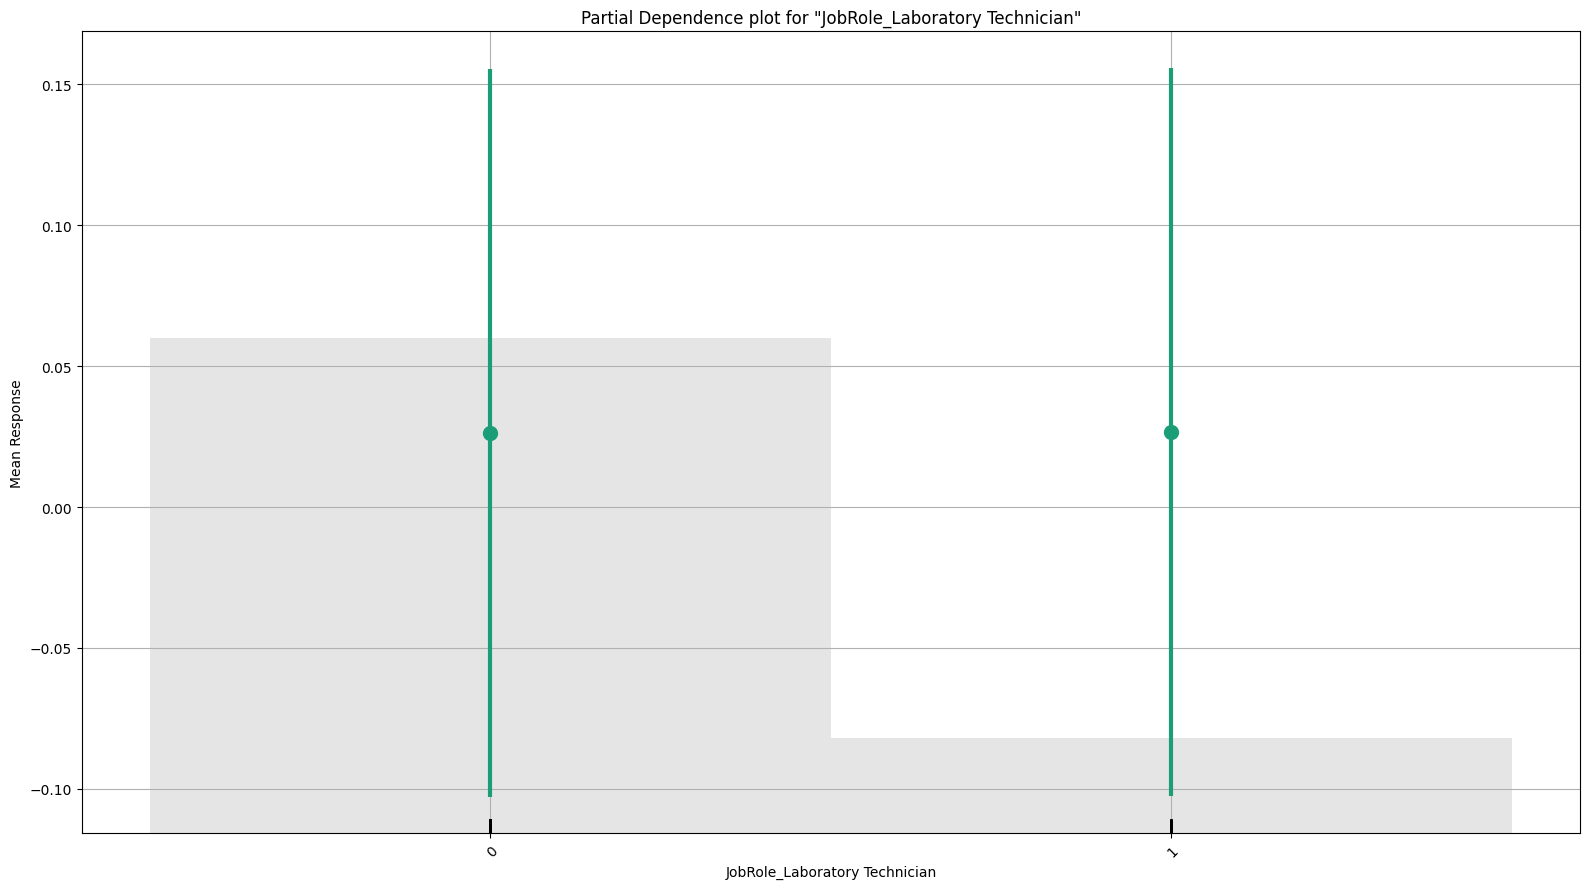

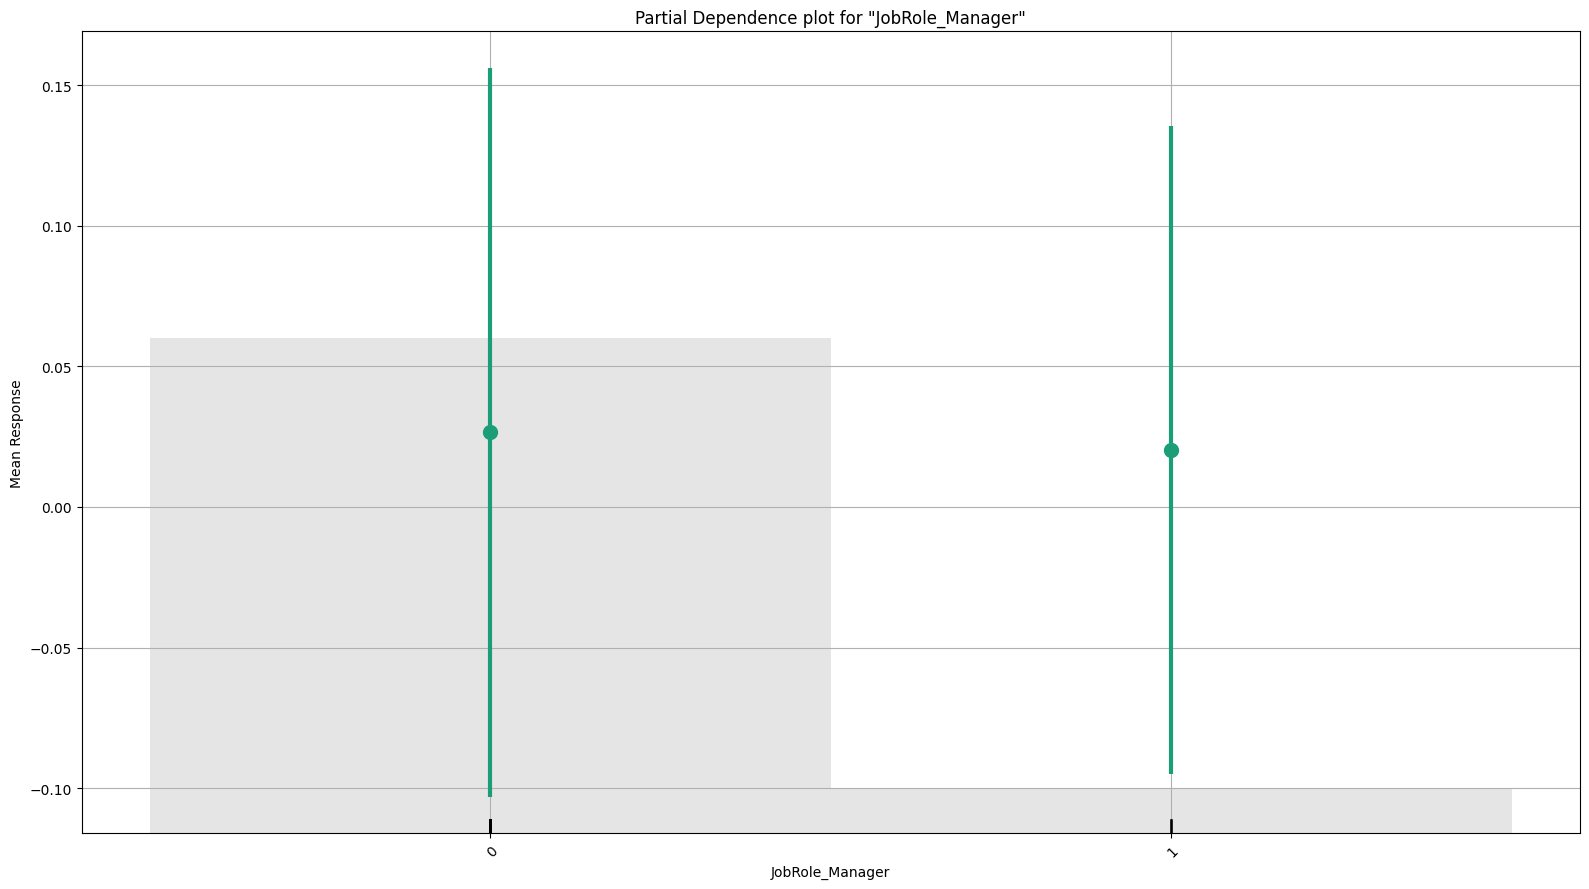

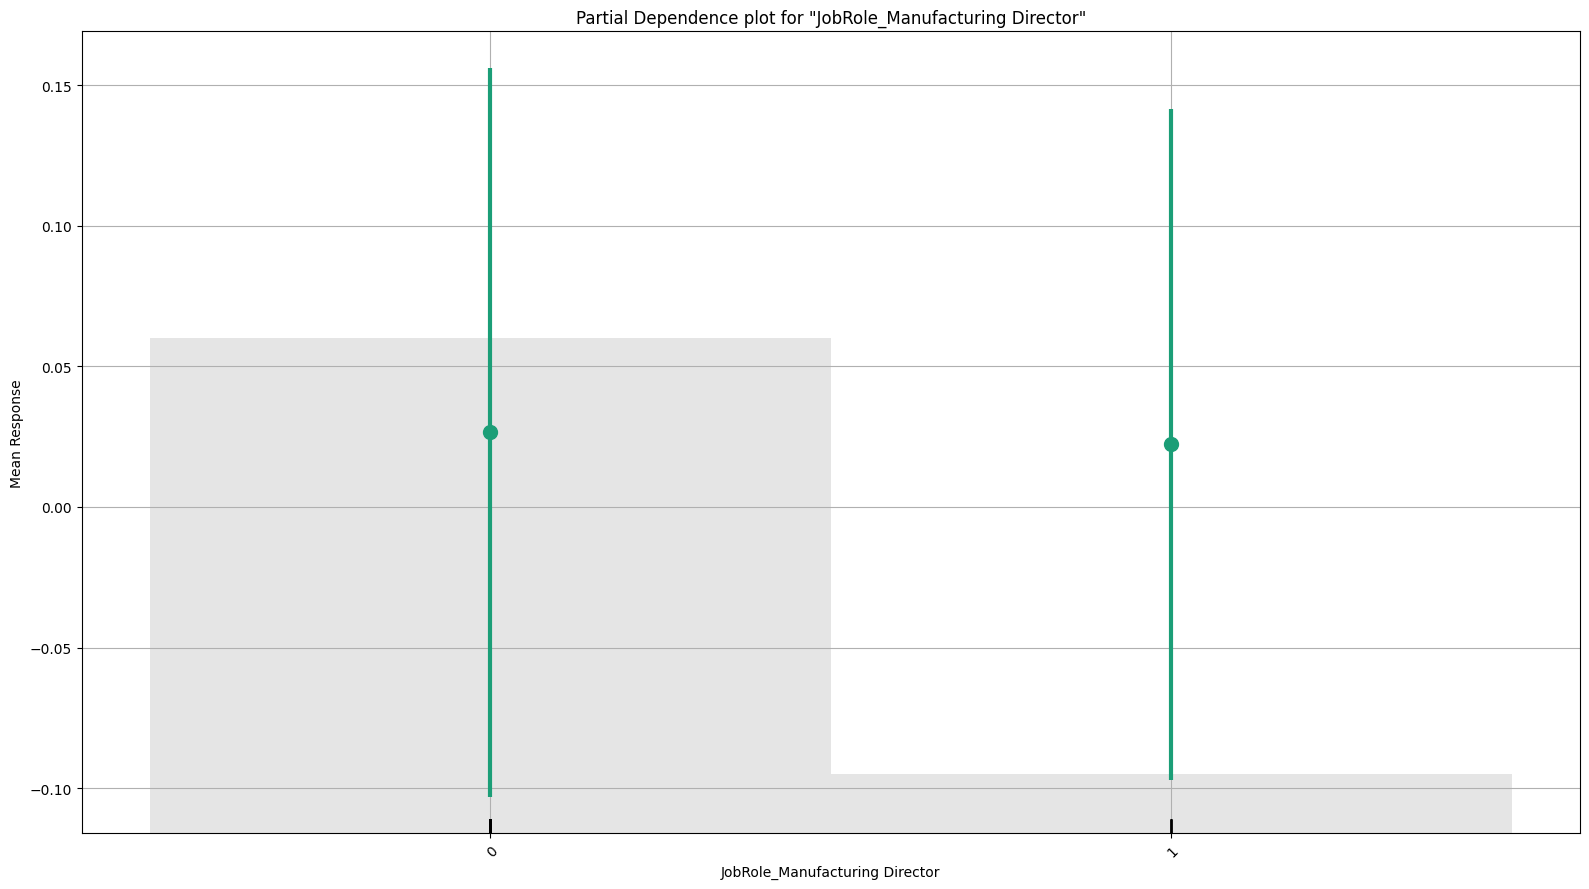

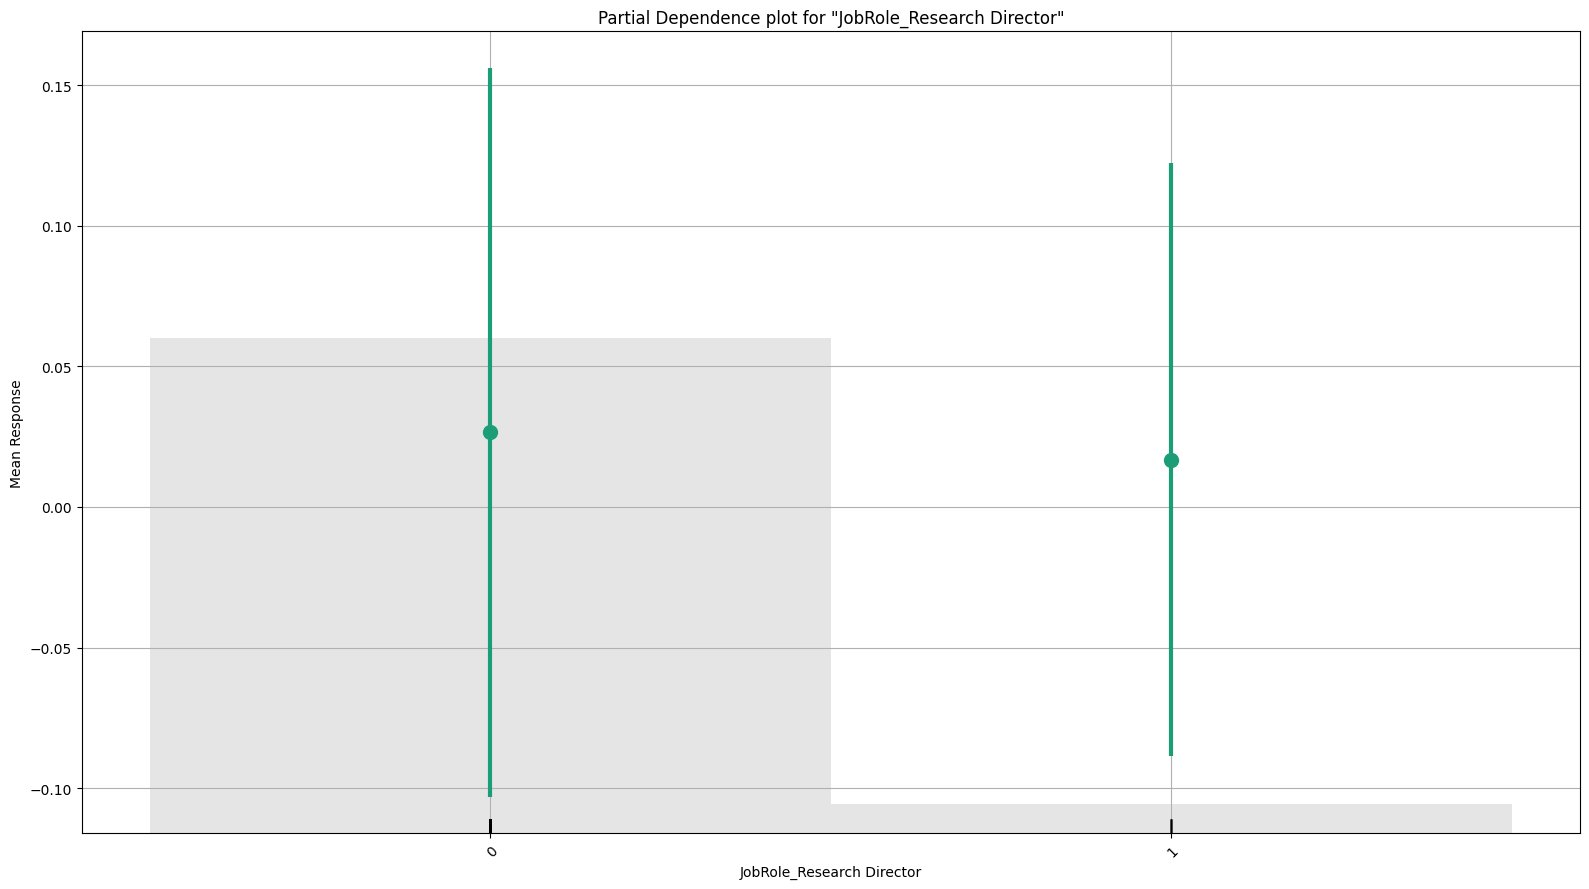

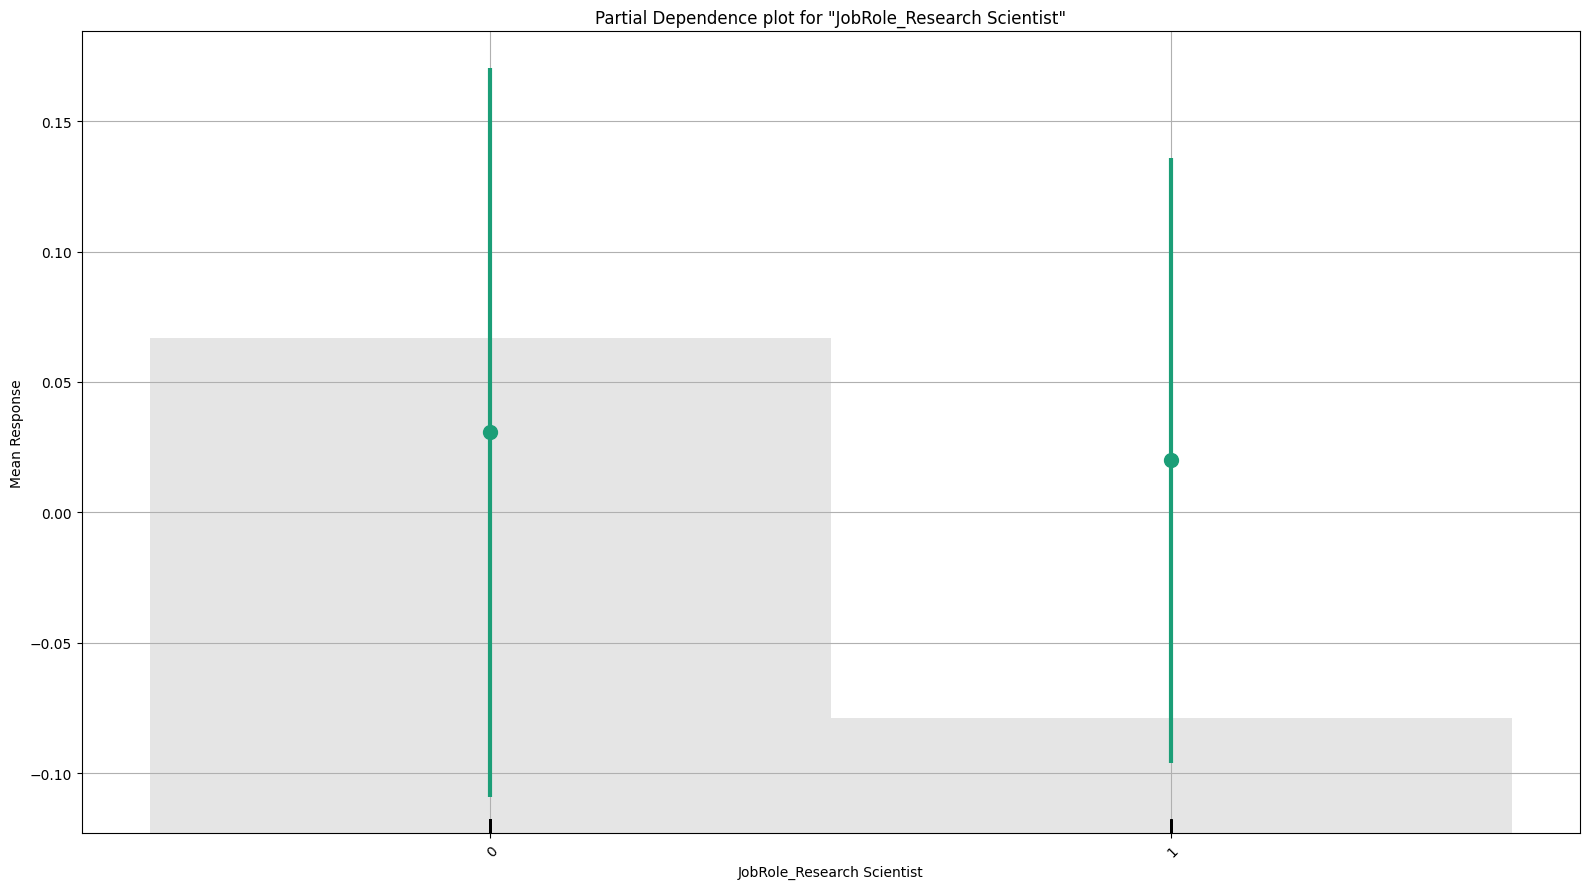

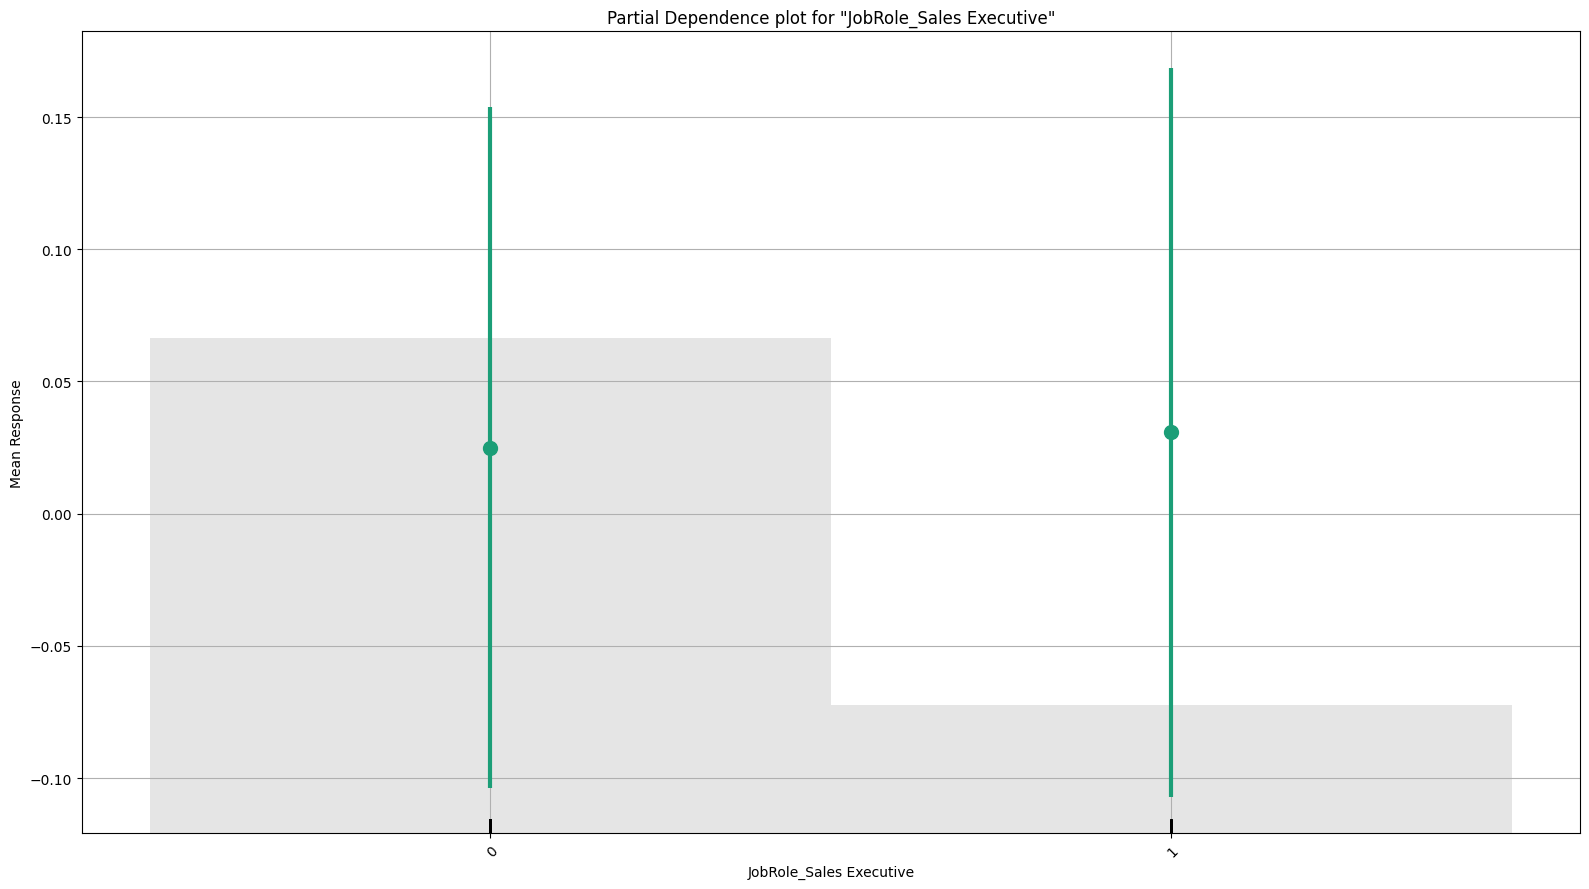

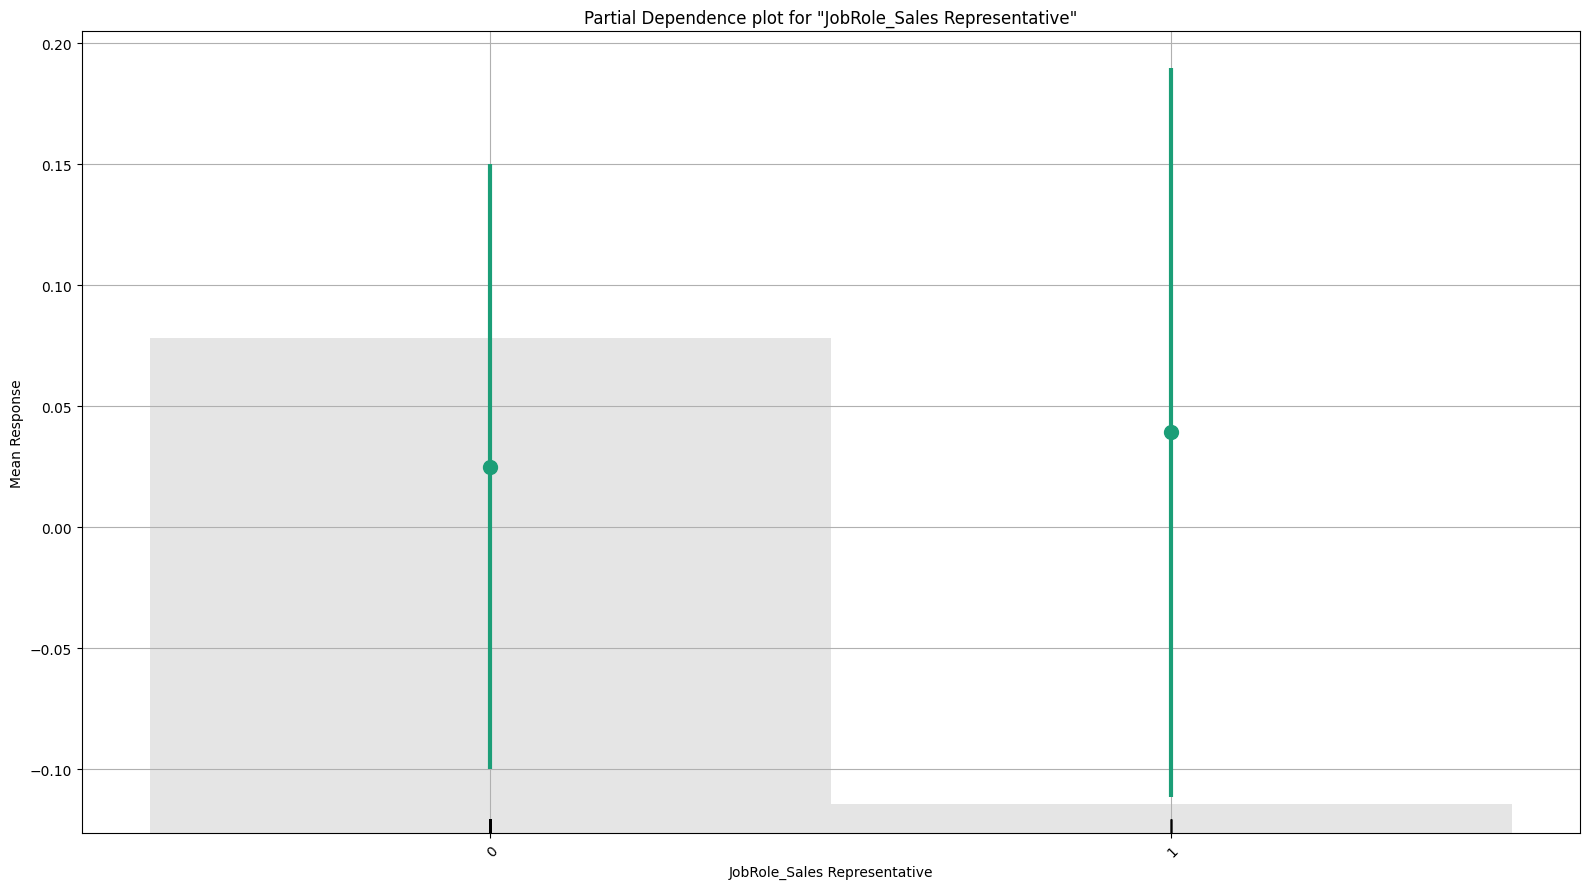

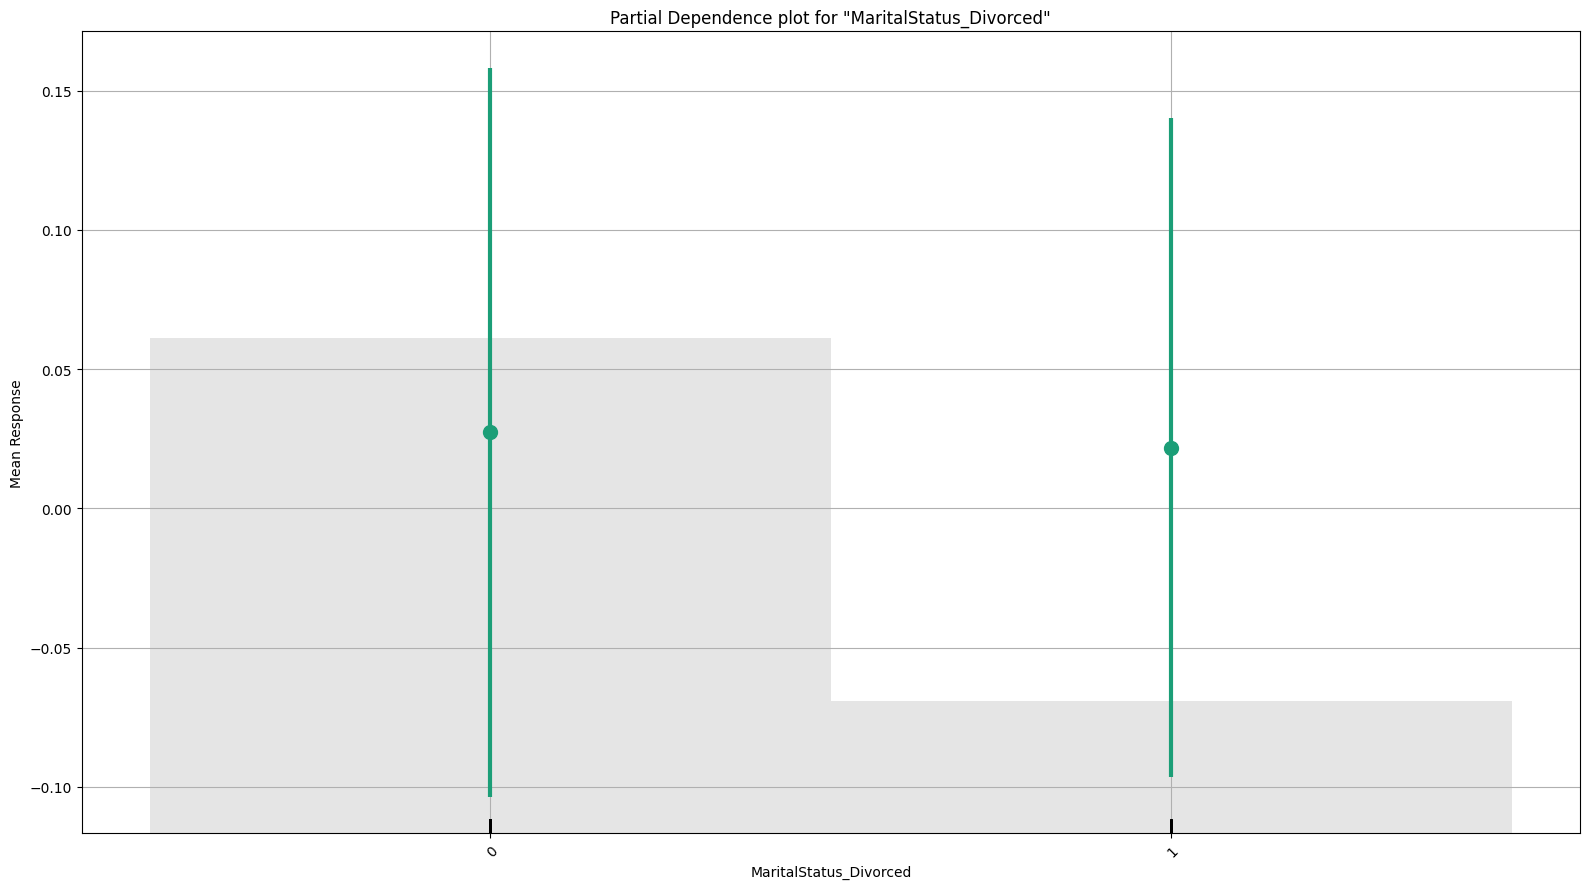

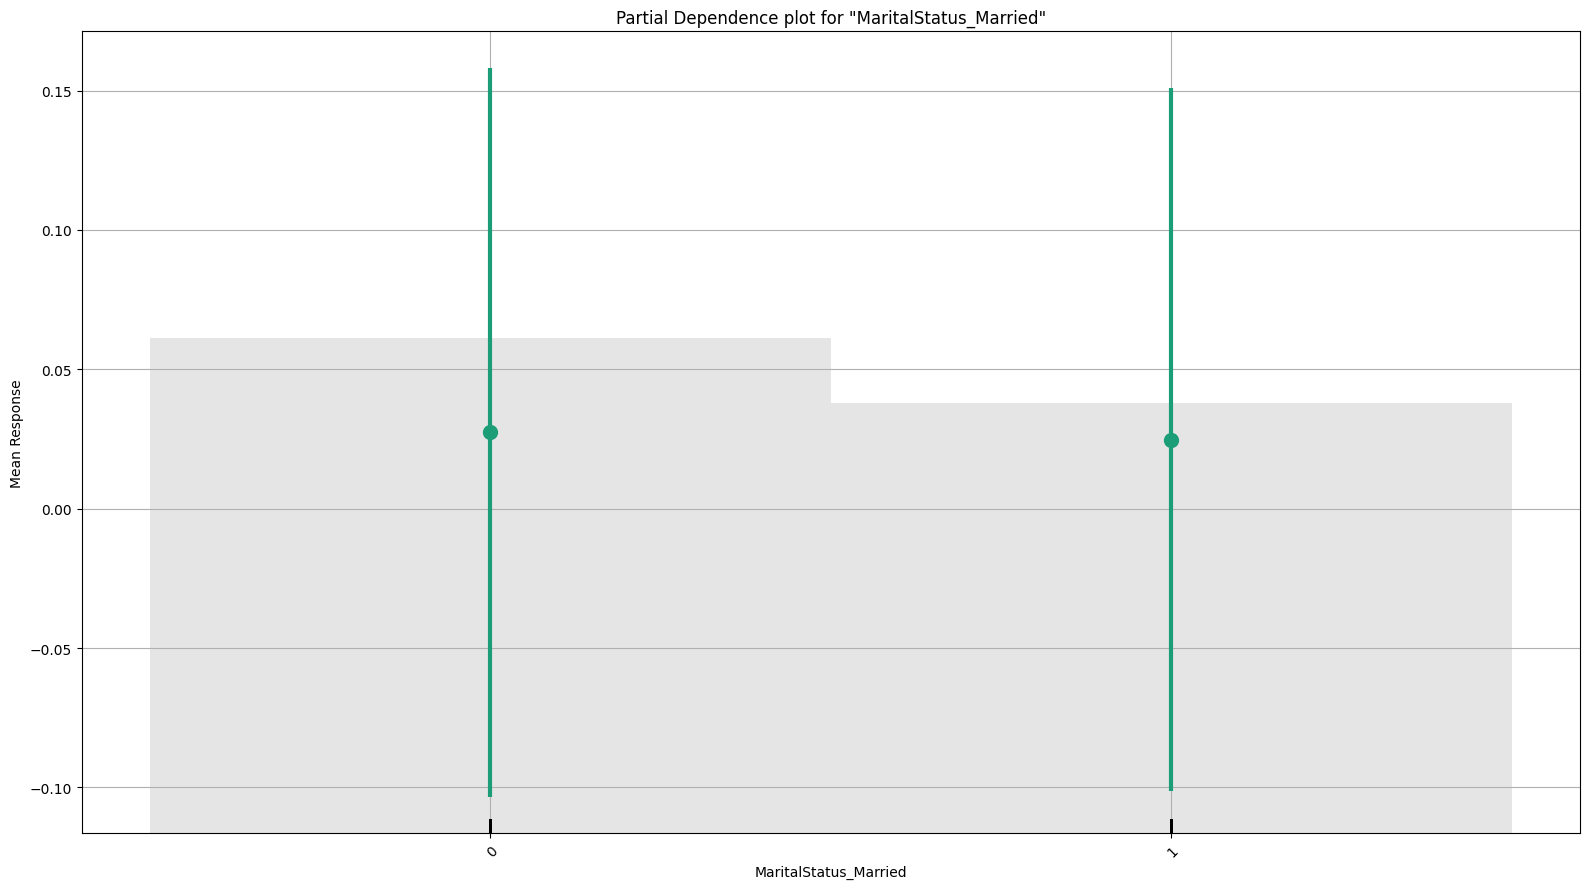

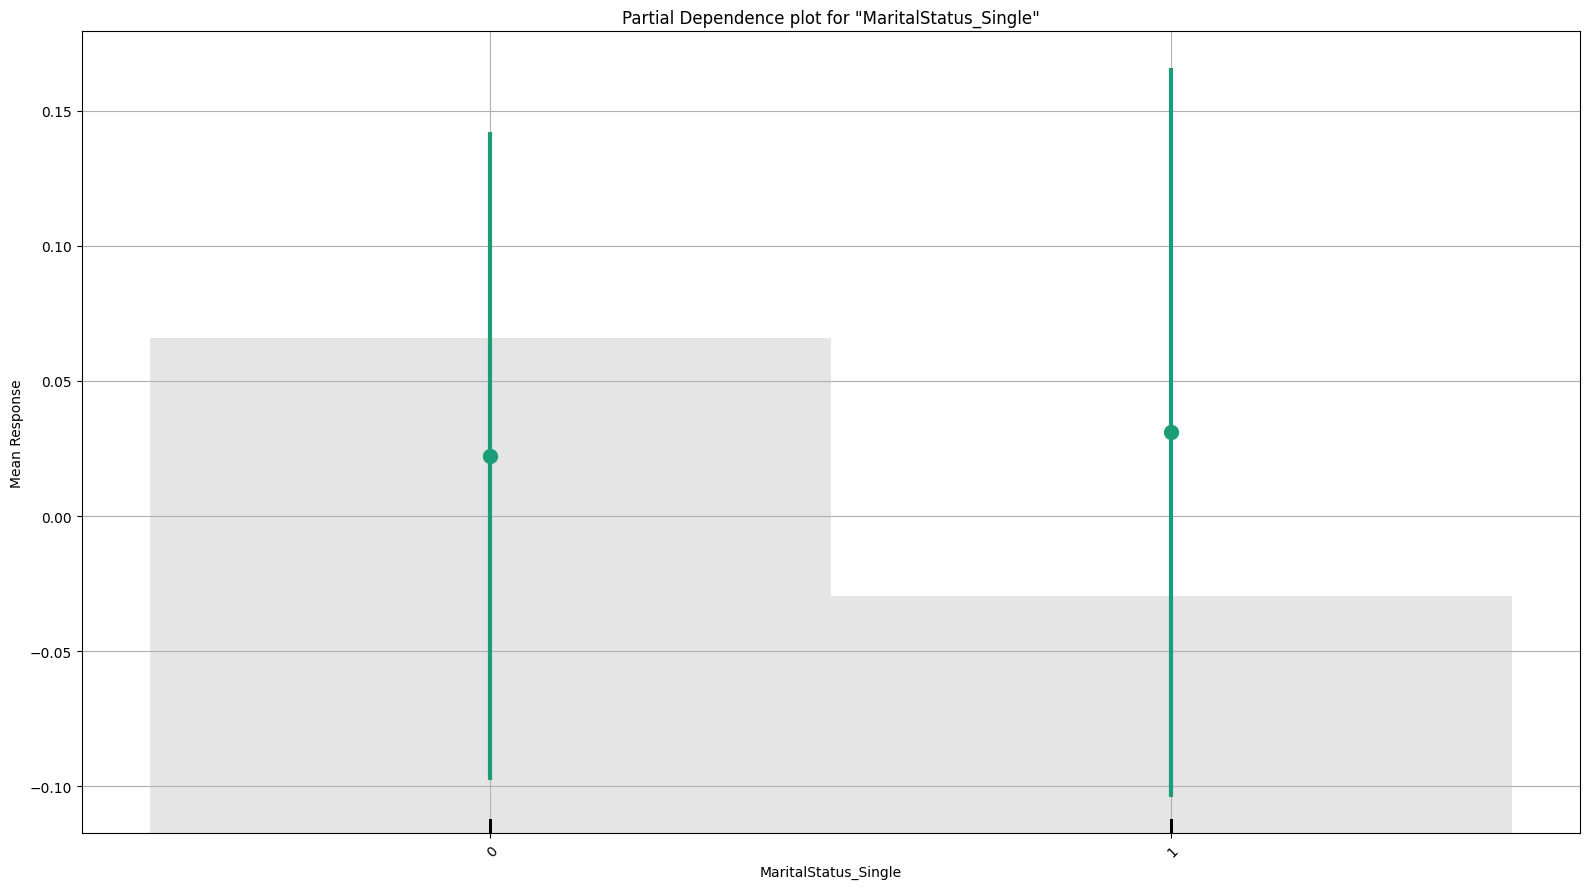

In [13]:
# Display test performance
cv_best_model.explain(test)

# Test Performance of other Models

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
----------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_1_20250317_191731_model_6           0.880437   0.336874  0.708845                0.198876  0.323251  0.104491                 1210                   0.018223  GBM
GLM_1_AutoML_1_20250317_191731                        0.874132   0.4528    0.661594                0.180373  0.388384  0.150842                  515                   0.009777  GLM
GBM_grid_1_AutoML_1_20250317_191731_model_19          0.870591   0.307094  0.658786                0.226494  0.305359  0.093244                 1494                   0.021378  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_14          0.869655   0.30061   0.693296                0.20991   0.300705  0.0904234                1554                   0.023657  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_15          0.861659   0.515226  0.587368                0.270354  0.308903  0.0954211                2432                   0.025226  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_4           0.86118    0.291393  0.634294                0.22293   0.27254   0.0742779                2250                   0.02022   GBM
GBM_grid_1_AutoML_1_20250317_191731_model_23          0.860974   0.363443  0.62677                 0.229441  0.283614  0.0804371                2044                   0.021182  GBM
GBM_1_AutoML_1_20250317_191731                        0.858347   0.276211  0.657432                0.238829  0.278512  0.0775689                3805                   0.027219  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_3           0.857113   0.286496  0.634832                0.231702  0.27416   0.0751636                1725                   0.023601  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_16          0.855286   0.283692  0.666762                0.244655  0.286792  0.0822497                1928                   0.023257  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_1           0.852088   0.397386  0.562591                0.200932  0.299188  0.0895136                2323                   0.022544  GBM
StackedEnsemble_AllModels_1_AutoML_1_20250317_191731  0.851791   0.540472  0.6163                  0.248904  0.305313  0.093216                 9941                   0.097943  StackedEnsemble
GBM_grid_1_AutoML_1_20250317_191731_model_5           0.850694   0.366088  0.58926                 0.26028   0.288723  0.0833612                2463                   0.022514  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_25          0.849666   0.326631  0.578928                0.261582  0.285267  0.0813771                2672                   0.020643  GBM
DeepLearning_grid_2_AutoML_1_20250317_191731_model_9  0.847999   1.33238   0.534943                0.232662  0.334948  0.11219                  5206                   0.023535  DeepLearning
GBM_3_AutoML_1_20250317_191731                        0.847725   0.361391  0.594474                0.238829  0.288223  0.0830722                2833                   0.022985  GBM
DRF_1_AutoML_1_20250317_191731                        0.847542   0.325132  0.530695                0.248629  0.305593  0.0933869                 646                   0.01047   DRF
GBM_4_AutoML_1_20250317_191731                        0.846651   0.377602  0.583545                0.231086  0.29094   0.0846459                3196                   0.018665  GBM
DeepLearning_1_AutoML_1_20250317_191731               0.846468   0.325215  0.576836                0.205729  0.292657  0.0856481                 245                   0.011264  DeepLearning
GBM_grid_1_AutoML_1_20250317_191731_model_9           0.845829   0.290843  0.616593                0.263843  0.276369  0.0763796                1920        

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004770391628635588
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      353  31   0.0807   (31.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  374  67   0.1179   (52.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

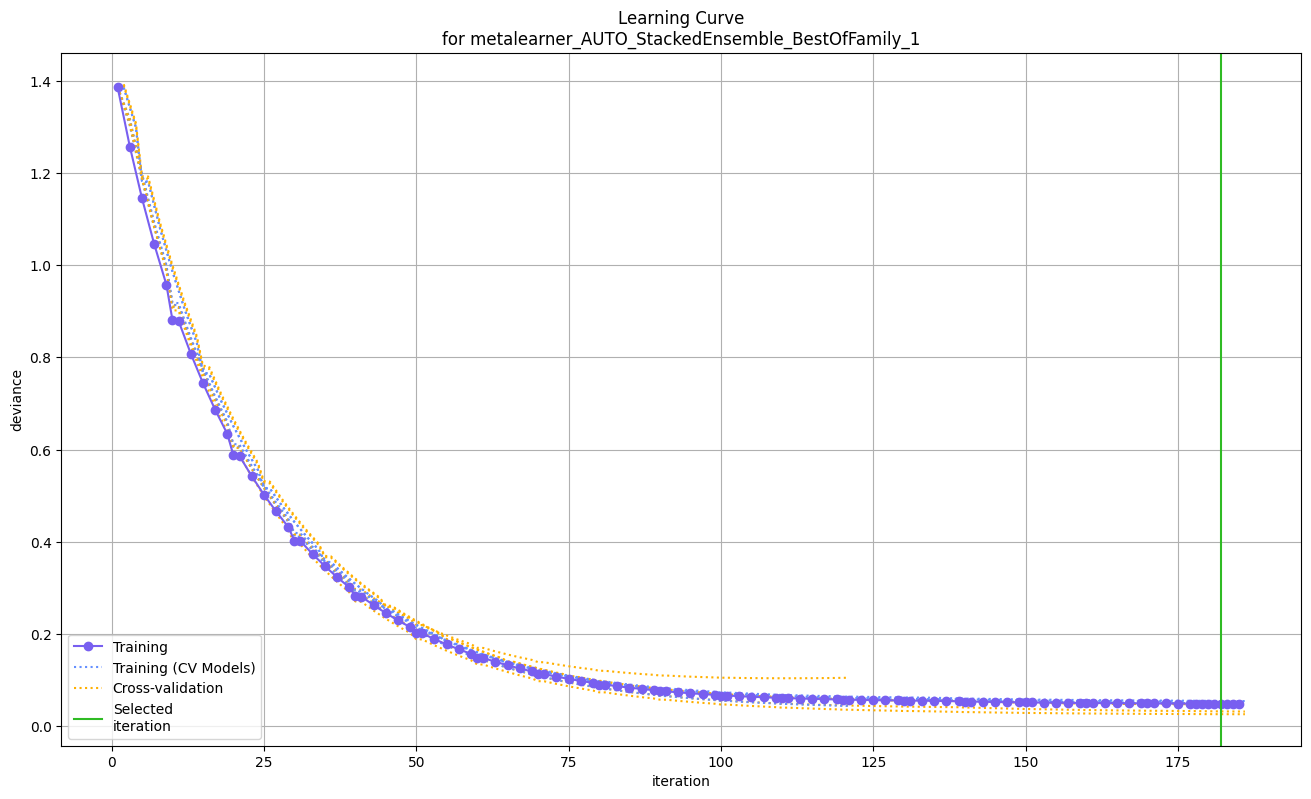

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

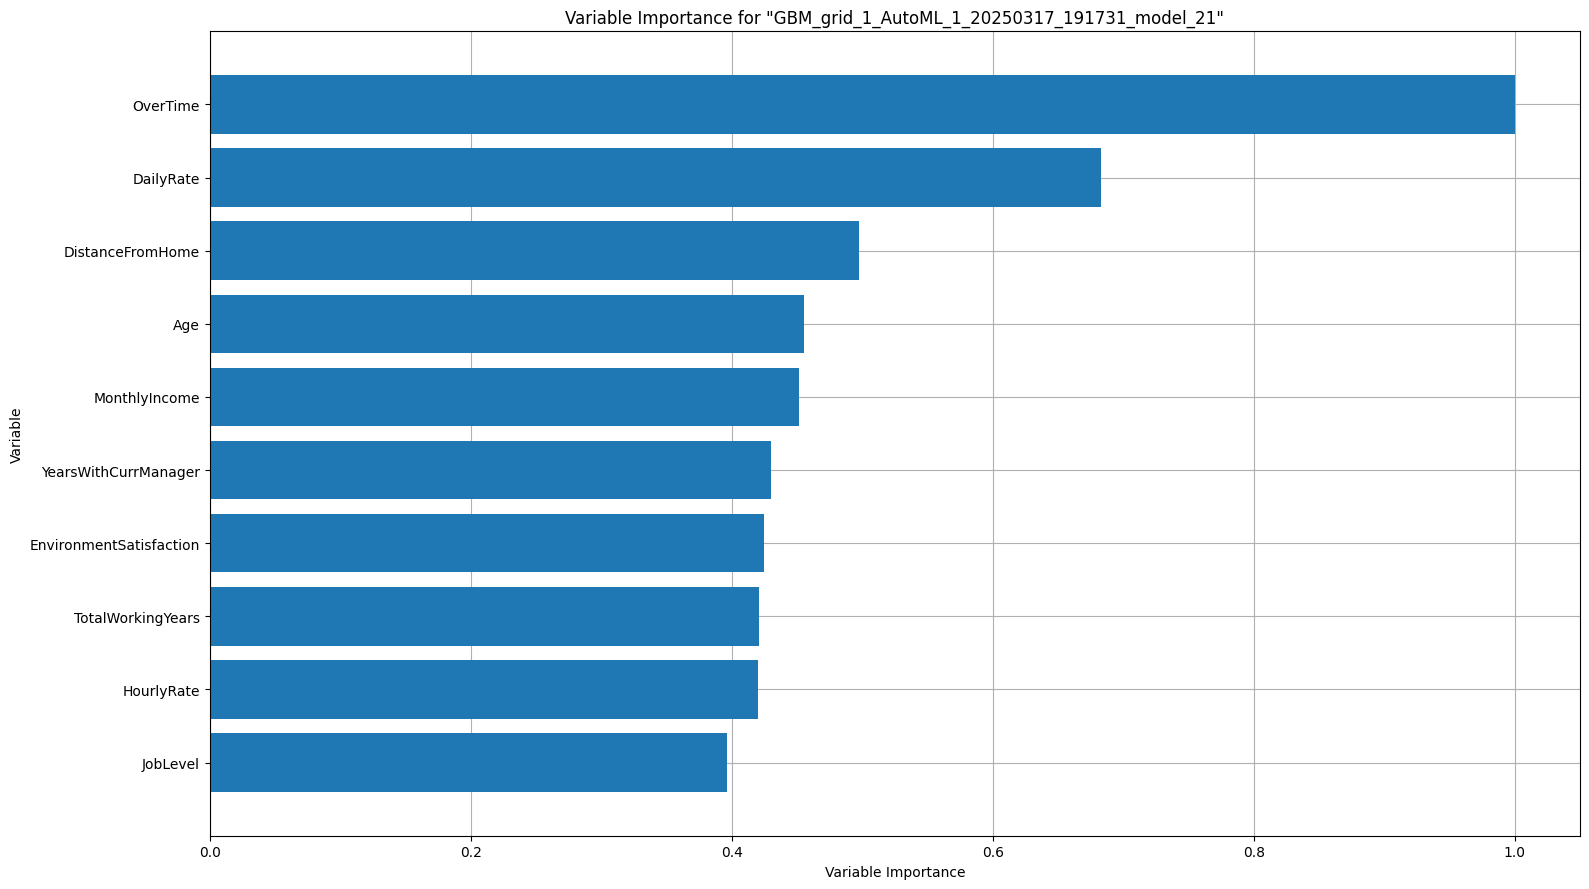

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

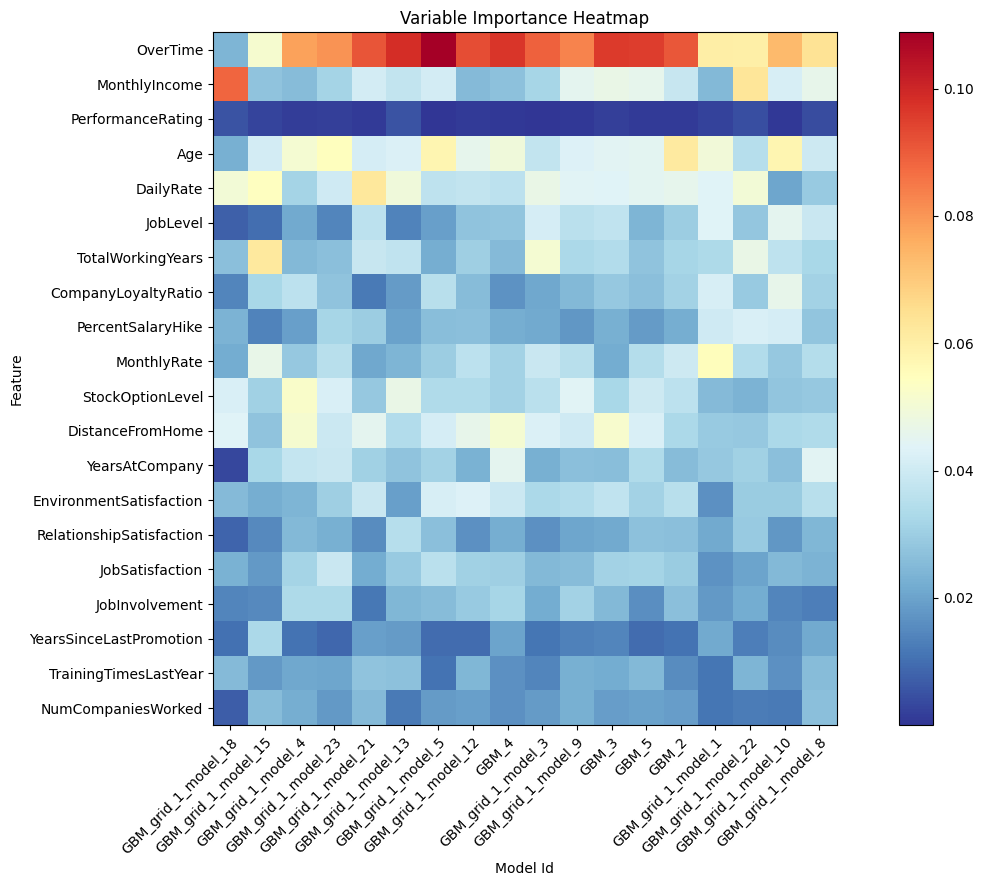

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

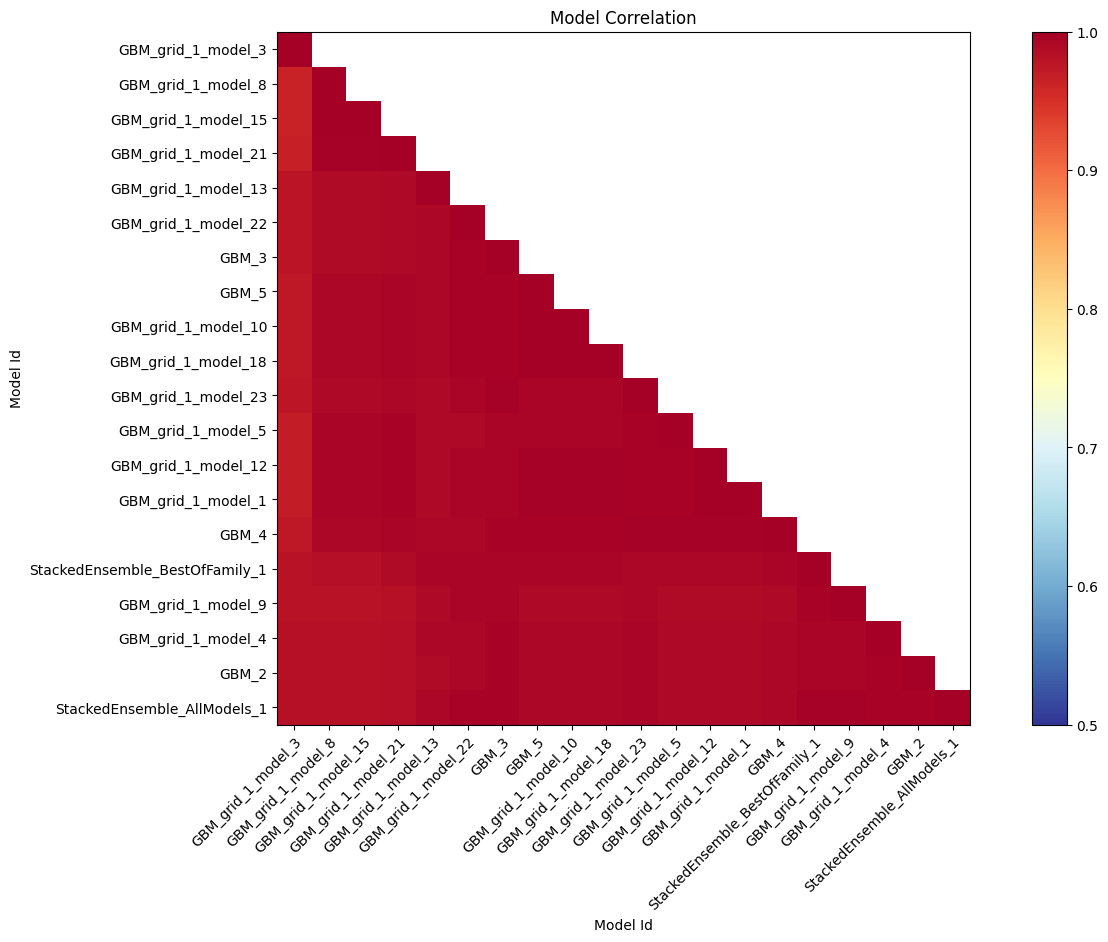

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

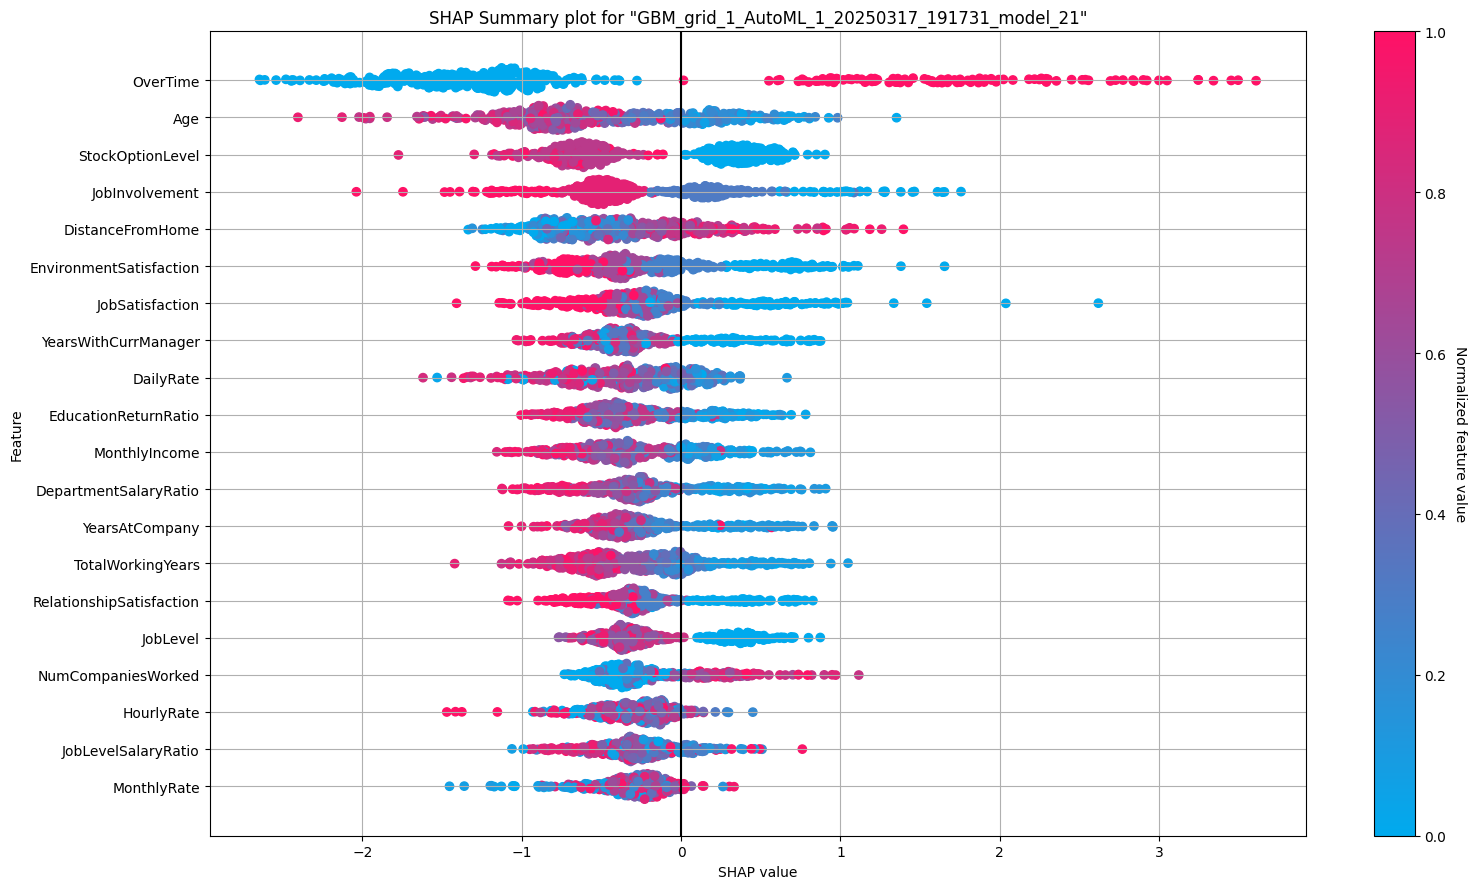

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

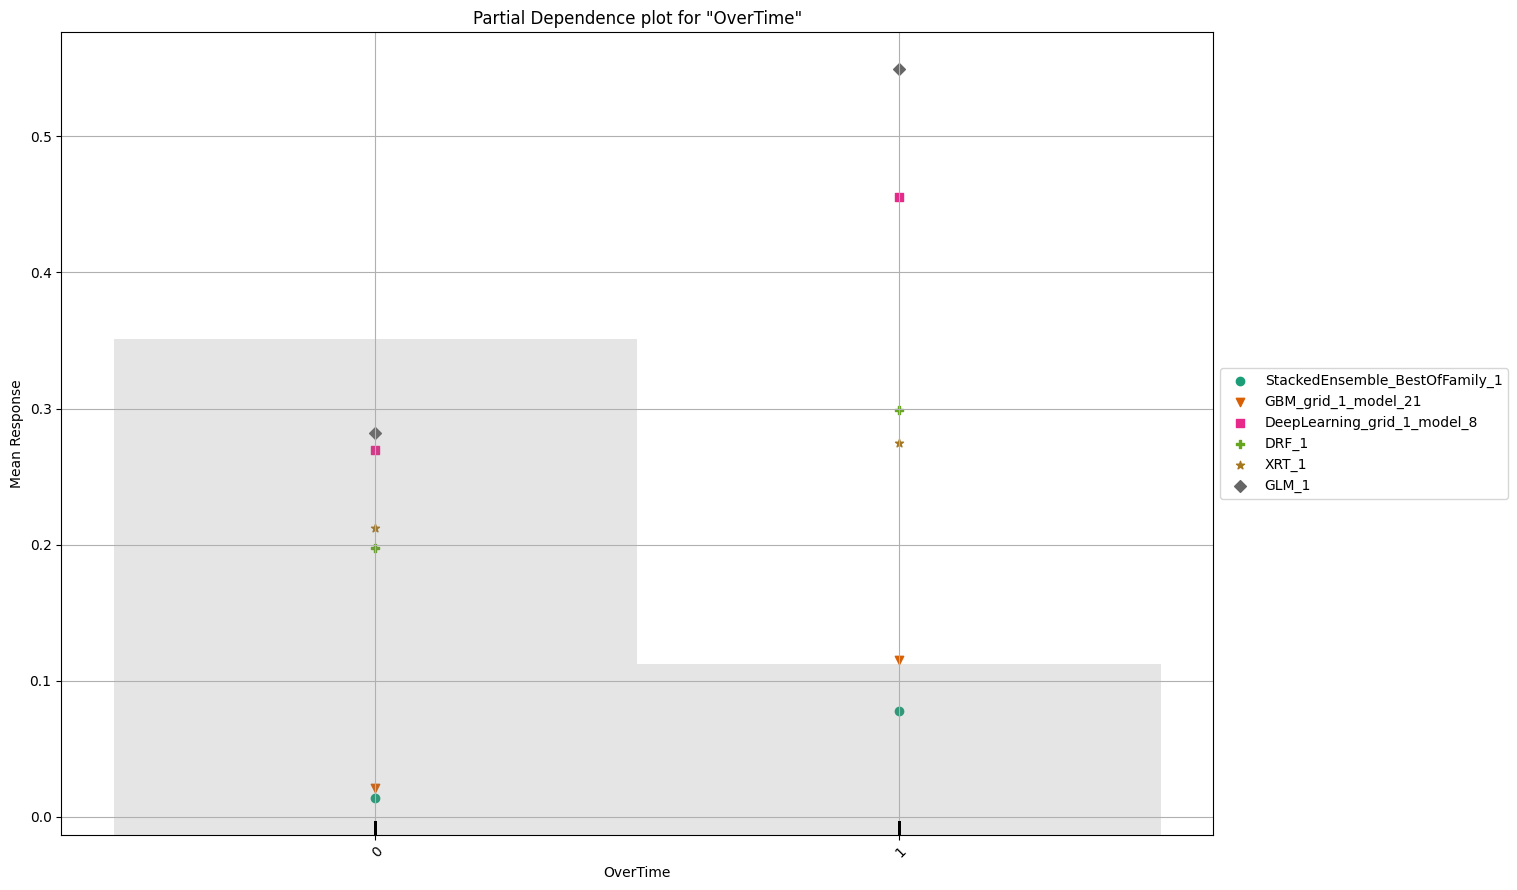

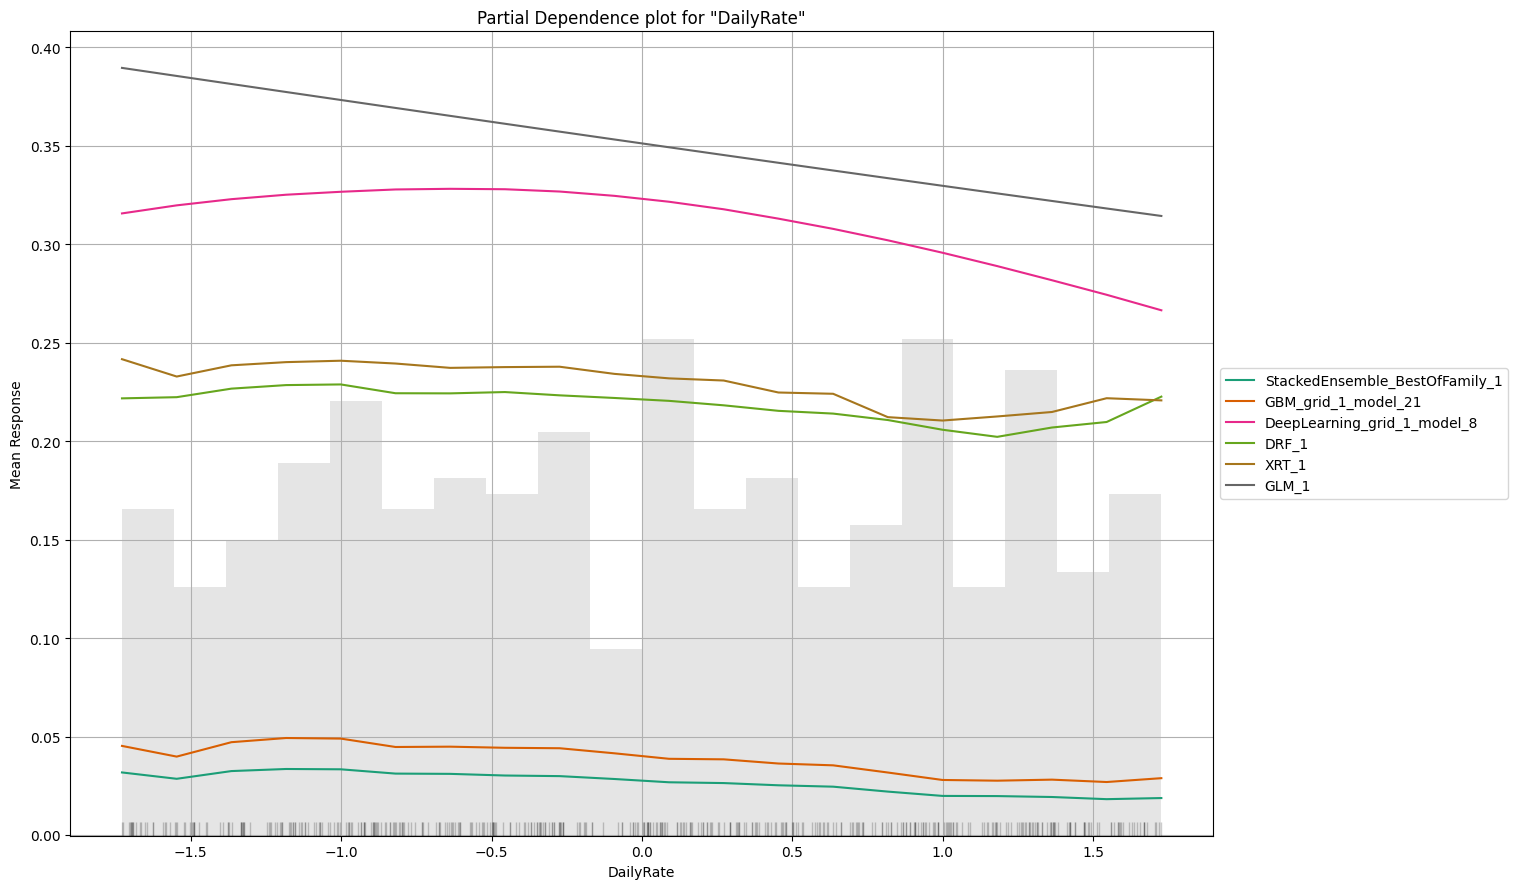

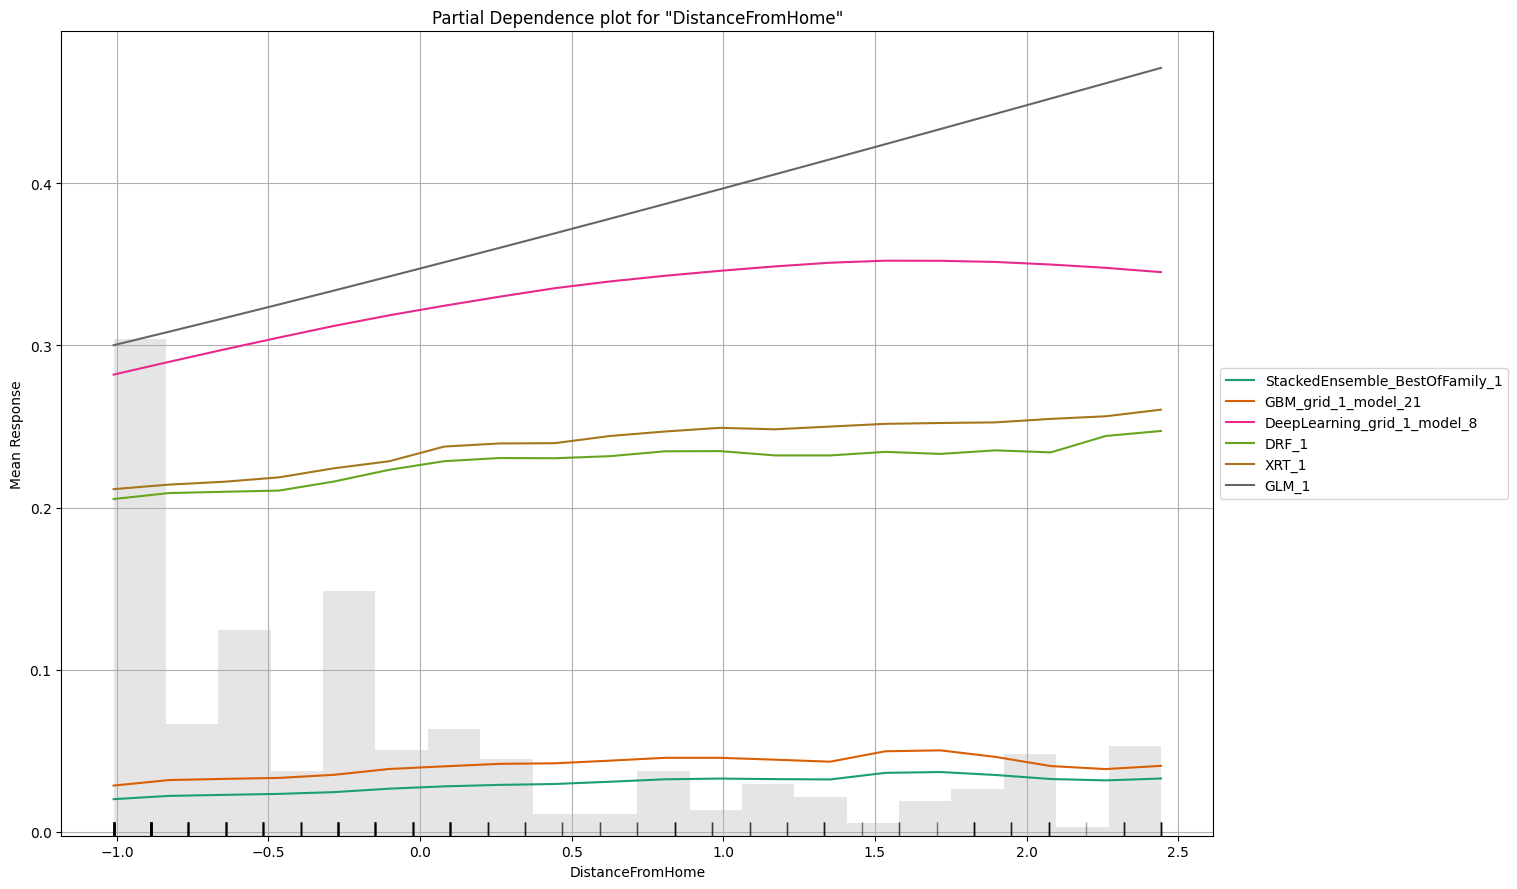

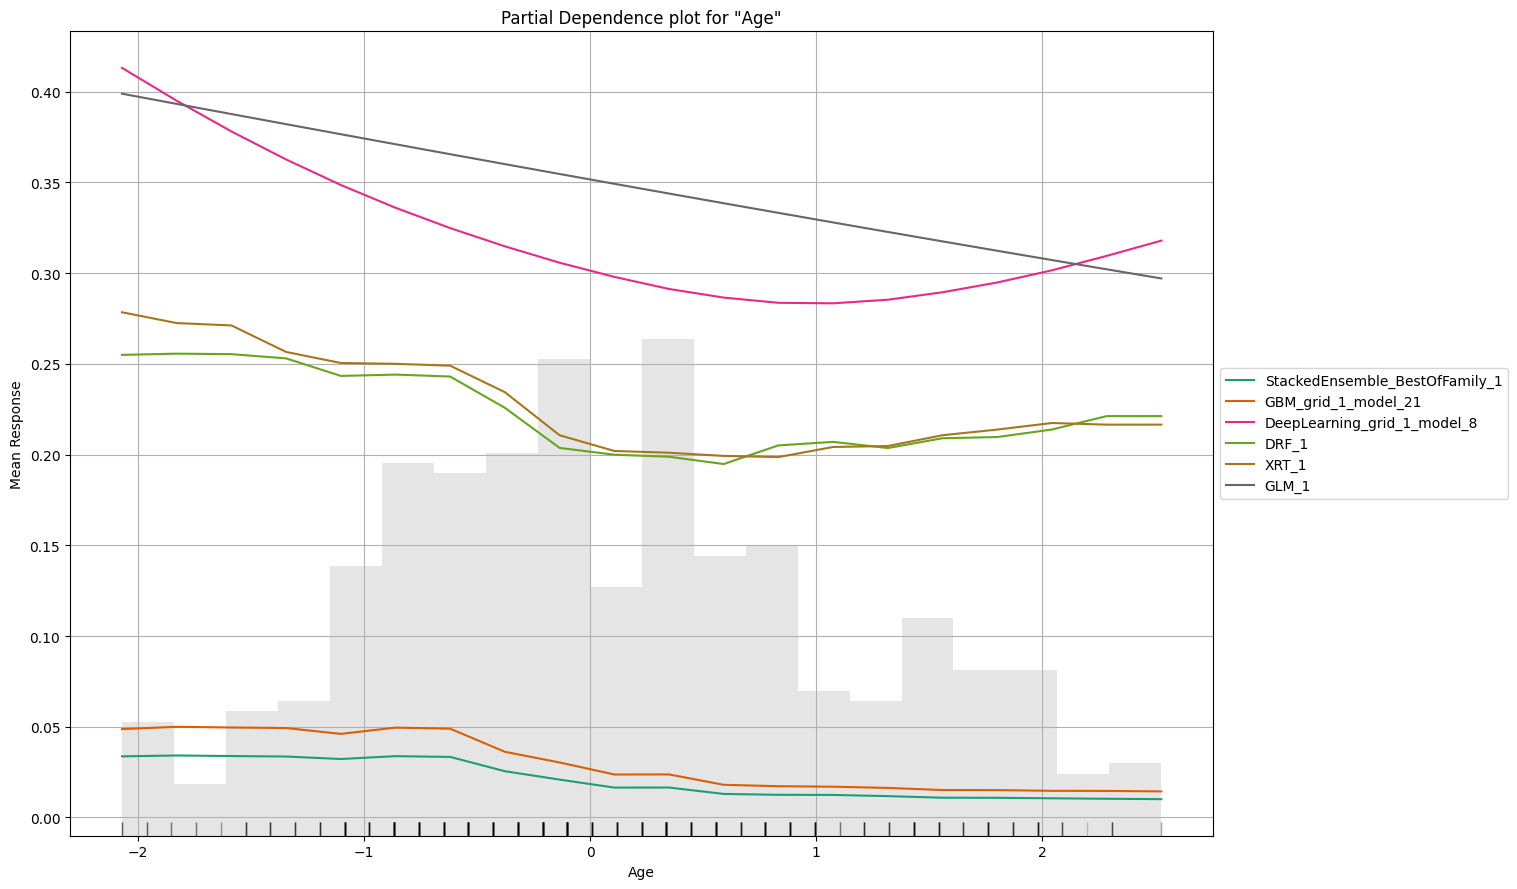

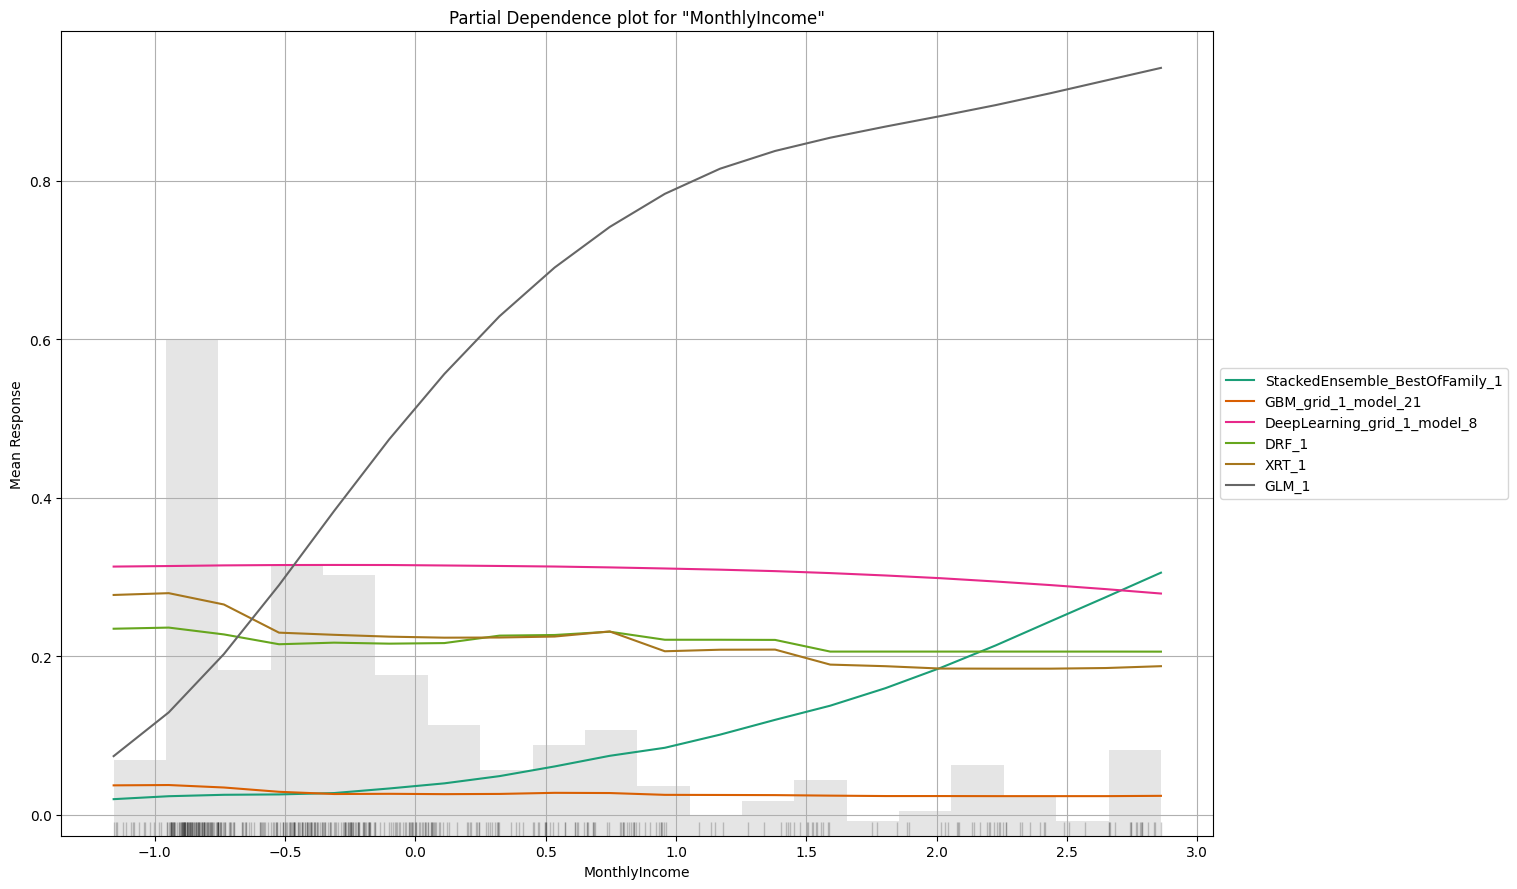

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
----------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_1_20250317_191731_model_6           0.880437   0.336874  0.708845                0.198876  0.323251  0.104491                 1210                   0.018223  GBM
GLM_1_AutoML_1_20250317_191731                        0.874132   0.4528    0.661594                0.180373  0.388384  0.150842                  515                   0.009777  GLM
GBM_grid_1_AutoML_1_20250317_191731_model_19          0.870591   0.307094  0.658786                0.226494  0.305359  0.093244                 1494                   0.021378  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_14          0.869655   0.30061   0.693296                0.20991   0.300705  0.0904234                1554                   0.023657  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_15          0.861659   0.515226  0.587368                0.270354  0.308903  0.0954211                2432                   0.025226  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_4           0.86118    0.291393  0.634294                0.22293   0.27254   0.0742779                2250                   0.02022   GBM
GBM_grid_1_AutoML_1_20250317_191731_model_23          0.860974   0.363443  0.62677                 0.229441  0.283614  0.0804371                2044                   0.021182  GBM
GBM_1_AutoML_1_20250317_191731                        0.858347   0.276211  0.657432                0.238829  0.278512  0.0775689                3805                   0.027219  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_3           0.857113   0.286496  0.634832                0.231702  0.27416   0.0751636                1725                   0.023601  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_16          0.855286   0.283692  0.666762                0.244655  0.286792  0.0822497                1928                   0.023257  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_1           0.852088   0.397386  0.562591                0.200932  0.299188  0.0895136                2323                   0.022544  GBM
StackedEnsemble_AllModels_1_AutoML_1_20250317_191731  0.851791   0.540472  0.6163                  0.248904  0.305313  0.093216                 9941                   0.097943  StackedEnsemble
GBM_grid_1_AutoML_1_20250317_191731_model_5           0.850694   0.366088  0.58926                 0.26028   0.288723  0.0833612                2463                   0.022514  GBM
GBM_grid_1_AutoML_1_20250317_191731_model_25          0.849666   0.326631  0.578928                0.261582  0.285267  0.0813771                2672                   0.020643  GBM
DeepLearning_grid_2_AutoML_1_20250317_191731_model_9  0.847999   1.33238   0.534943                0.232662  0.334948  0.11219                  5206                   0.023535  DeepLearning
GBM_3_AutoML_1_20250317_191731                        0.847725   0.361391  0.594474                0.238829  0.288223  0.0830722                2833                   0.022985  GBM
DRF_1_AutoML_1_20250317_191731                        0.847542   0.325132  0.530695                0.248629  0.305593  0.0933869                 646                   0.01047   DRF
GBM_4_AutoML_1_20250317_191731                        0.846651   0.377602  0.583545                0.231086  0.29094   0.0846459                3196                   0.018665  GBM
DeepLearning_1_AutoML_1_20250317_191731               0.846468   0.325215  0.576836                0.205729  0.292657  0.0856481                 245                   0.011264  DeepLearning
GBM_grid_1_AutoML_1_20250317_191731_model_9           0.845829   0.290843  0.616593                0.263843  0.276369  0.0763796                1920        

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004770391628635588
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      353  31   0.0807   (31.0/384.0)
1      21   36   0.3684   (21.0/57.0)
Total  374  67   0.1179   (52.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

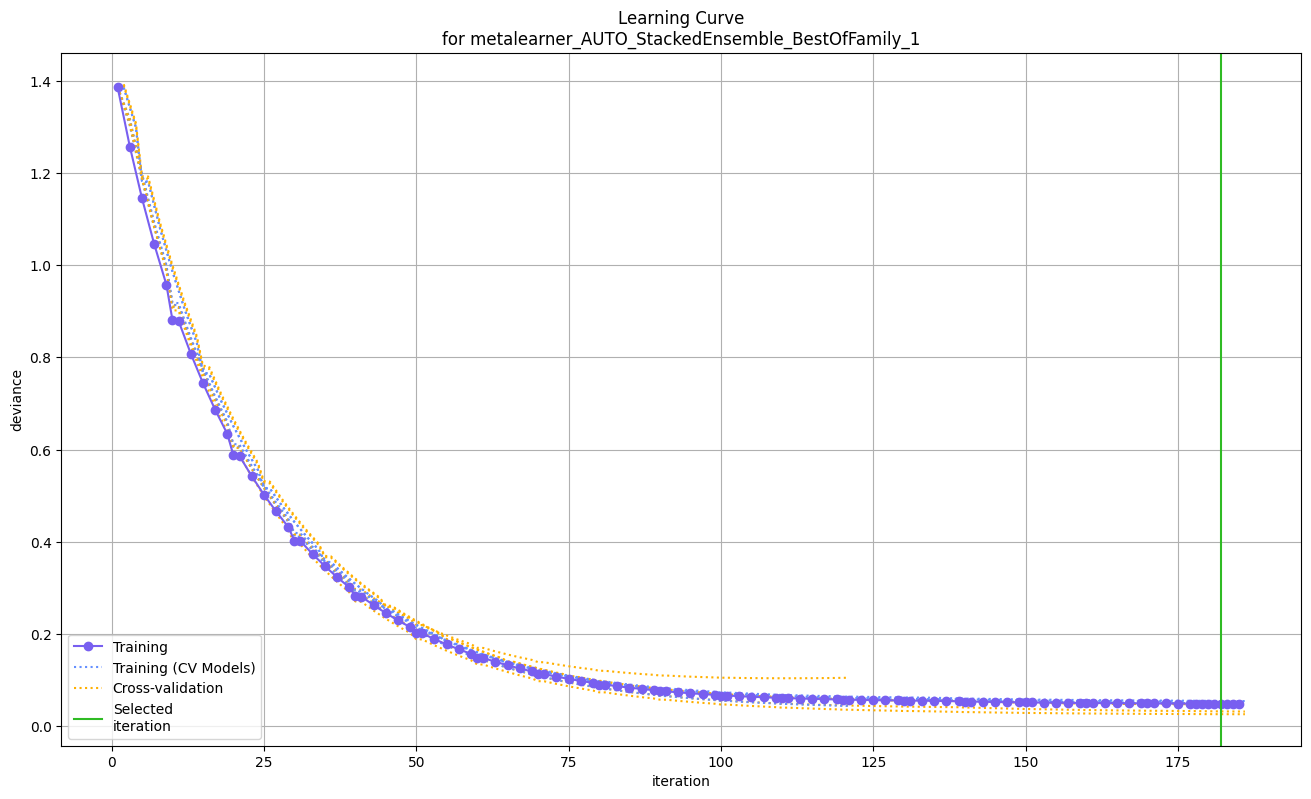

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

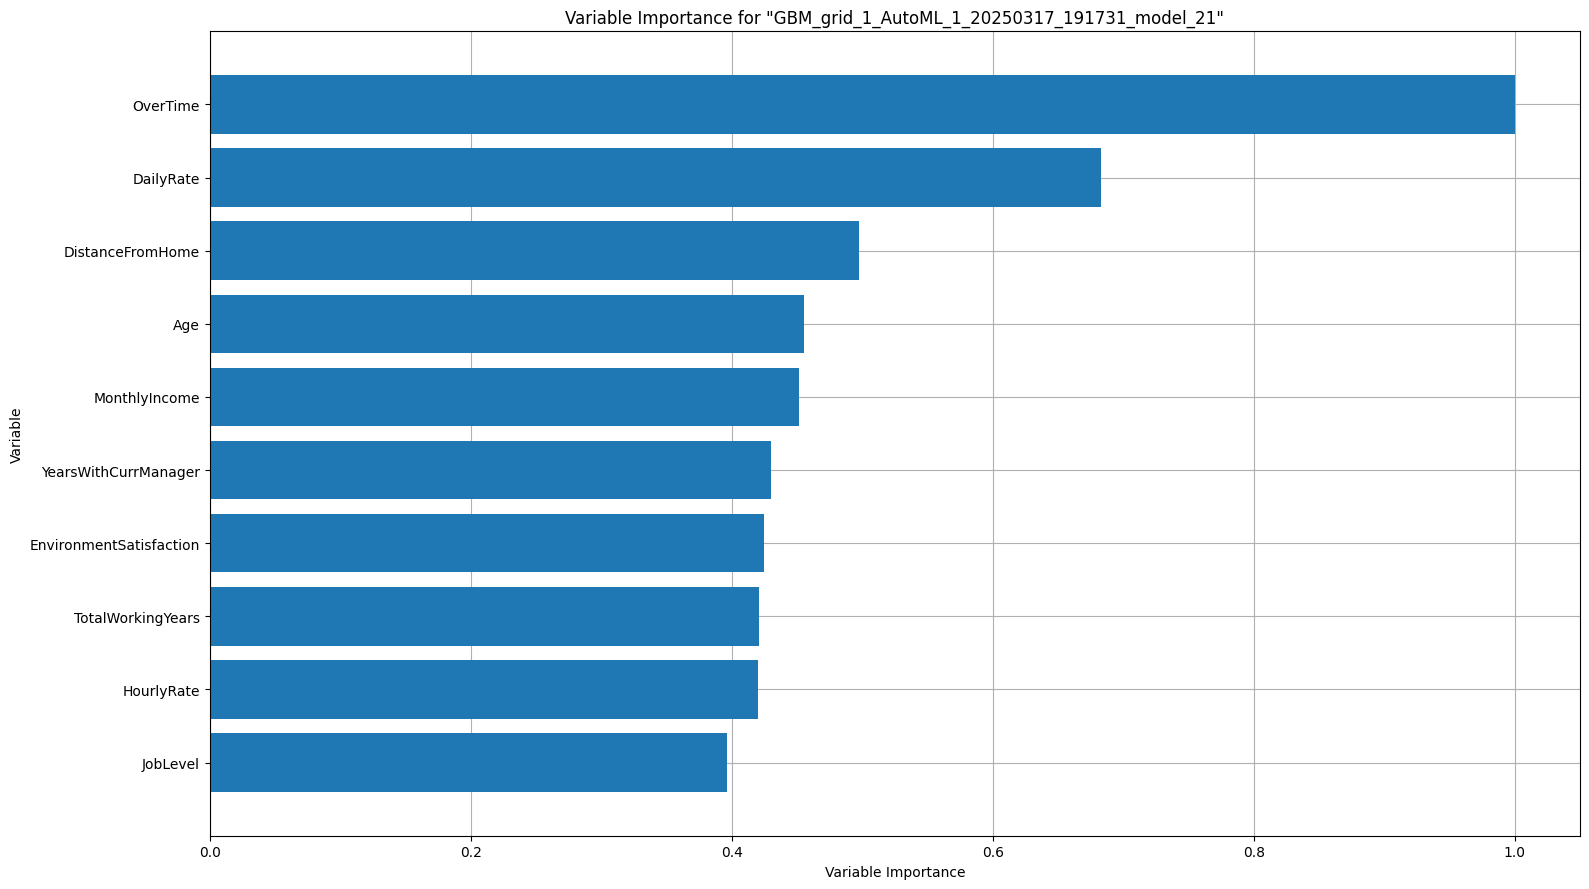

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

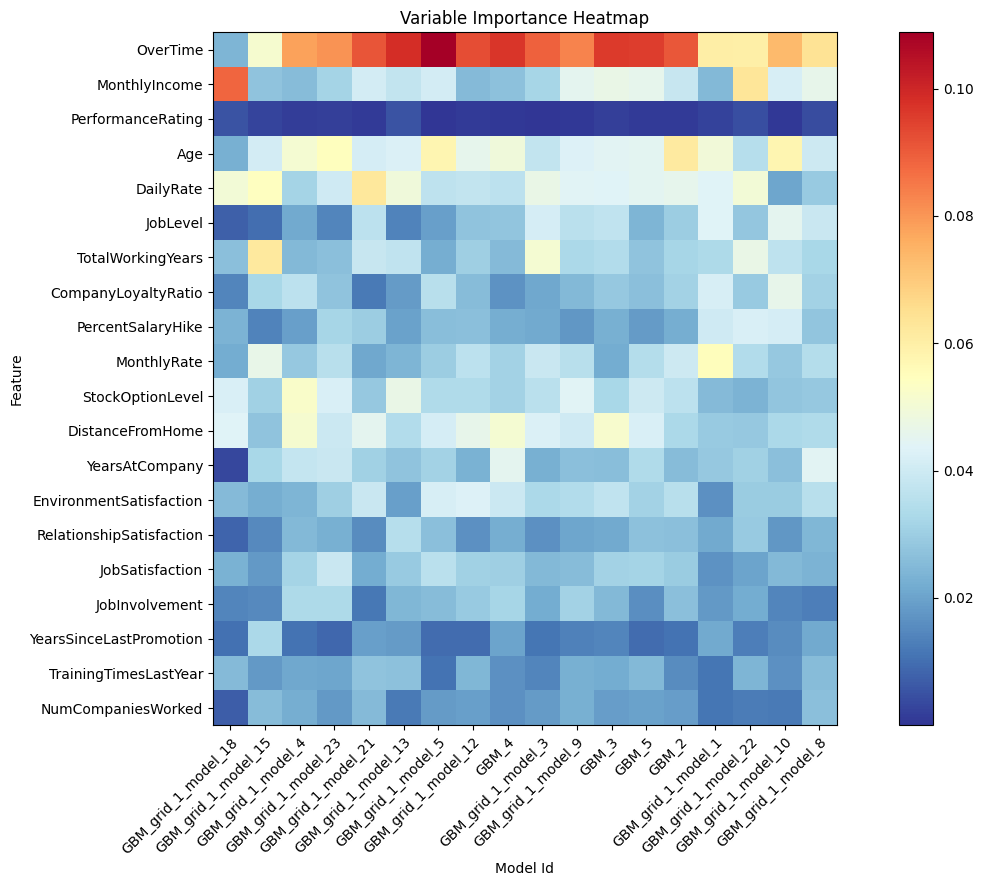

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

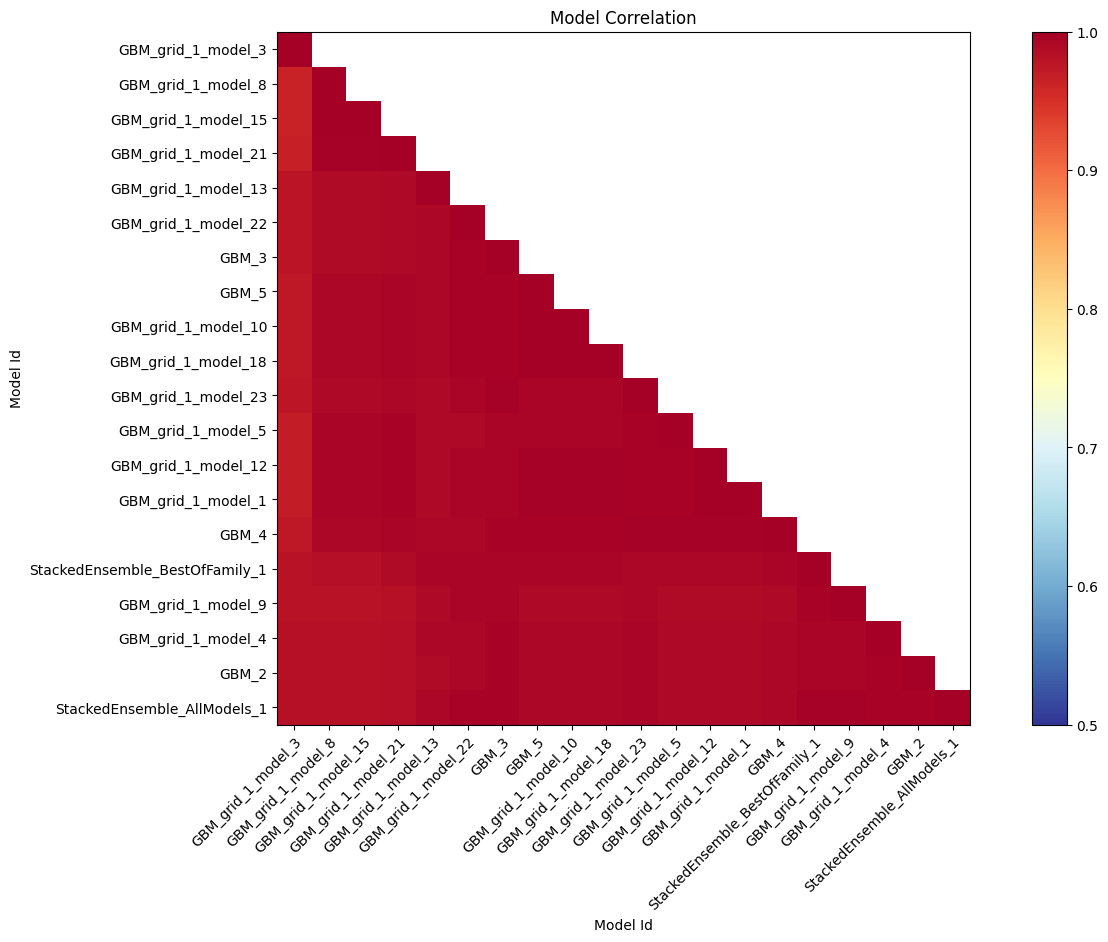

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

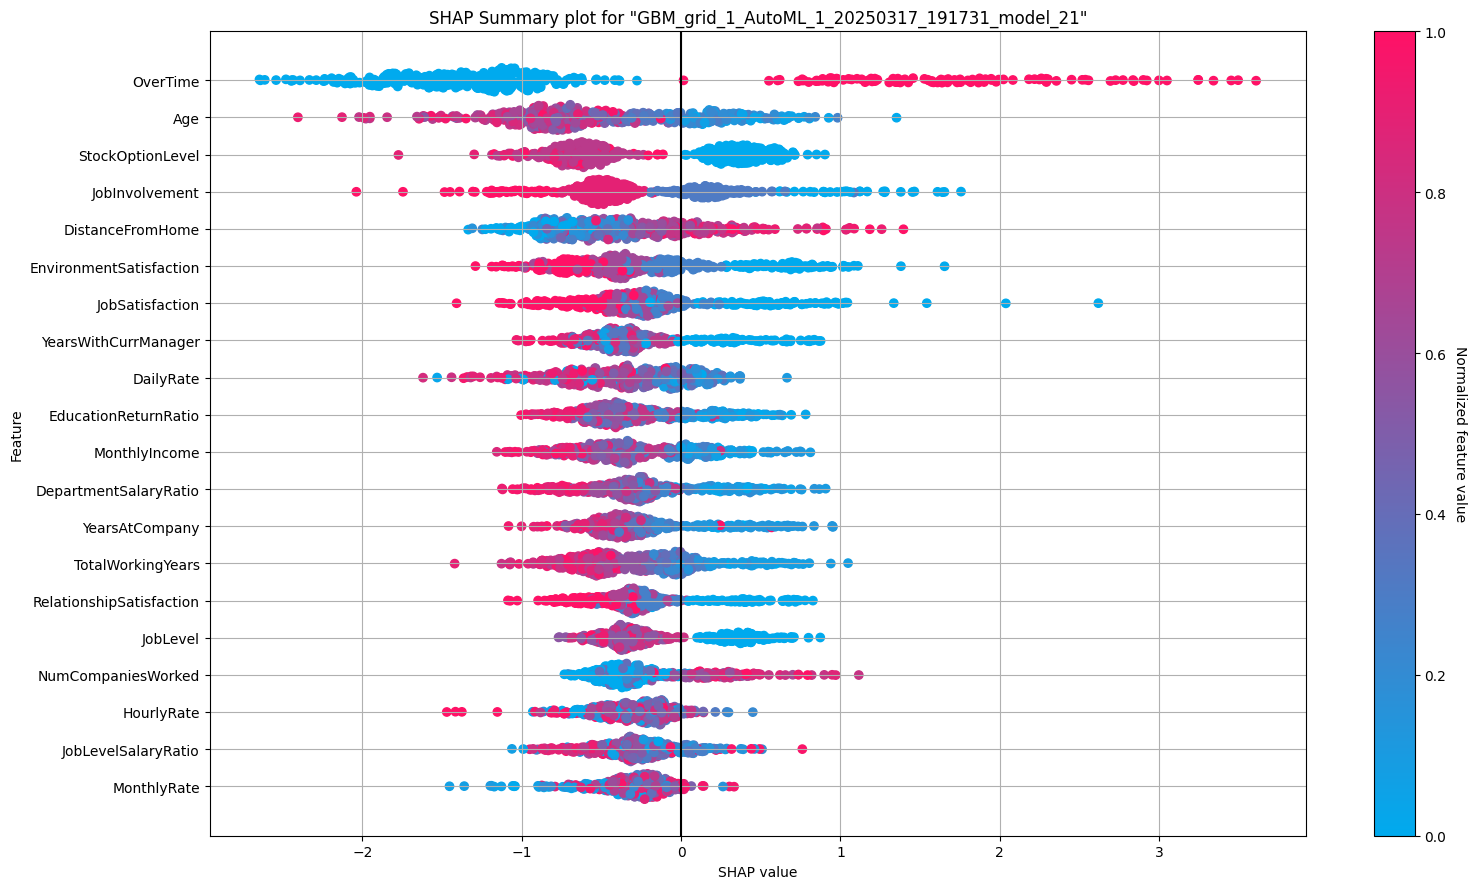

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

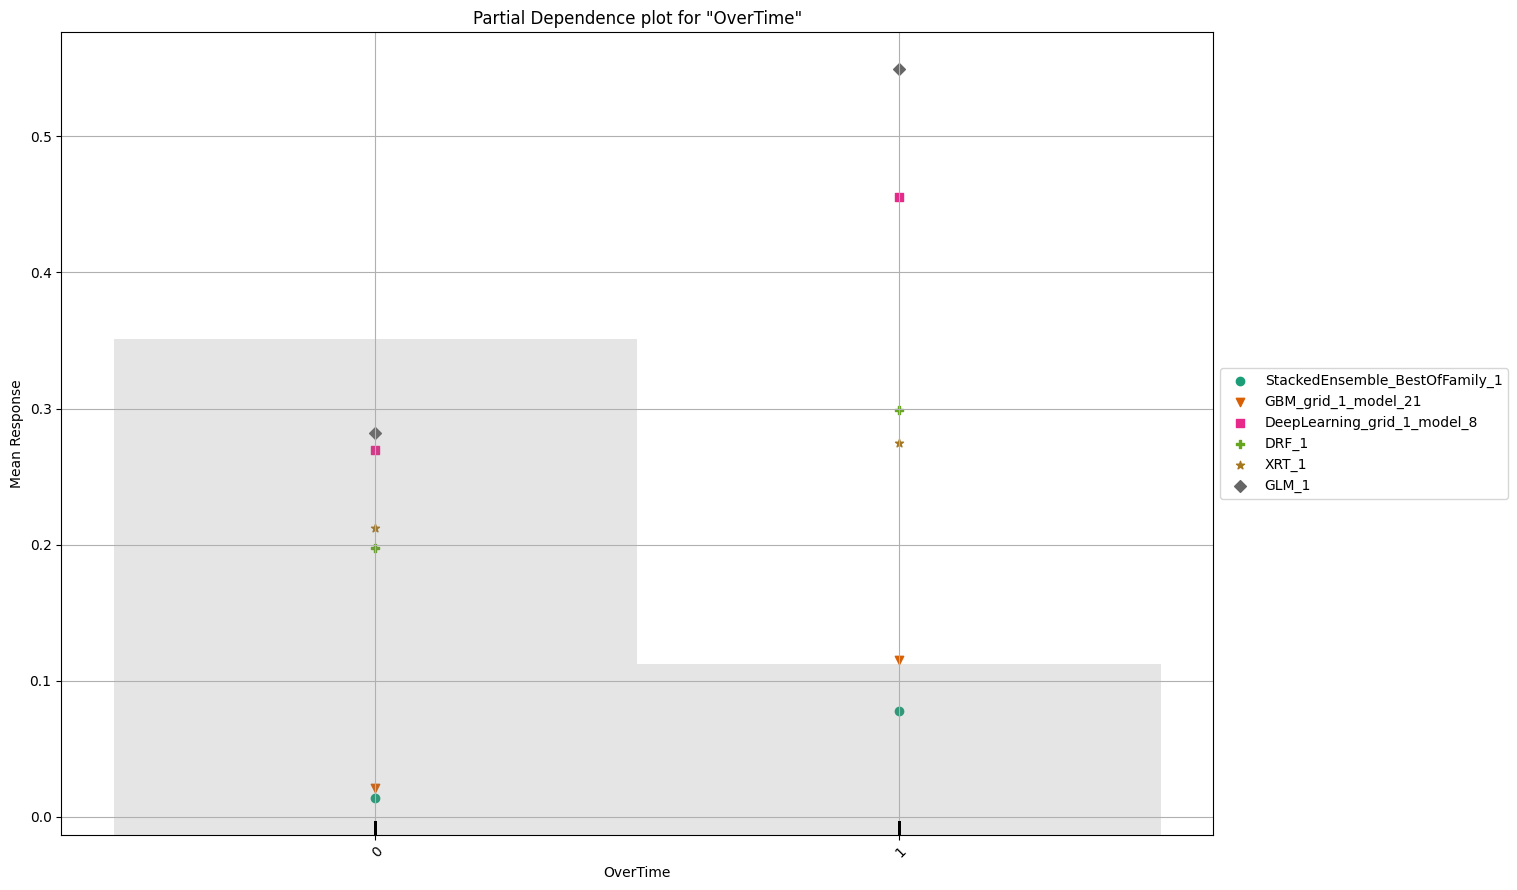

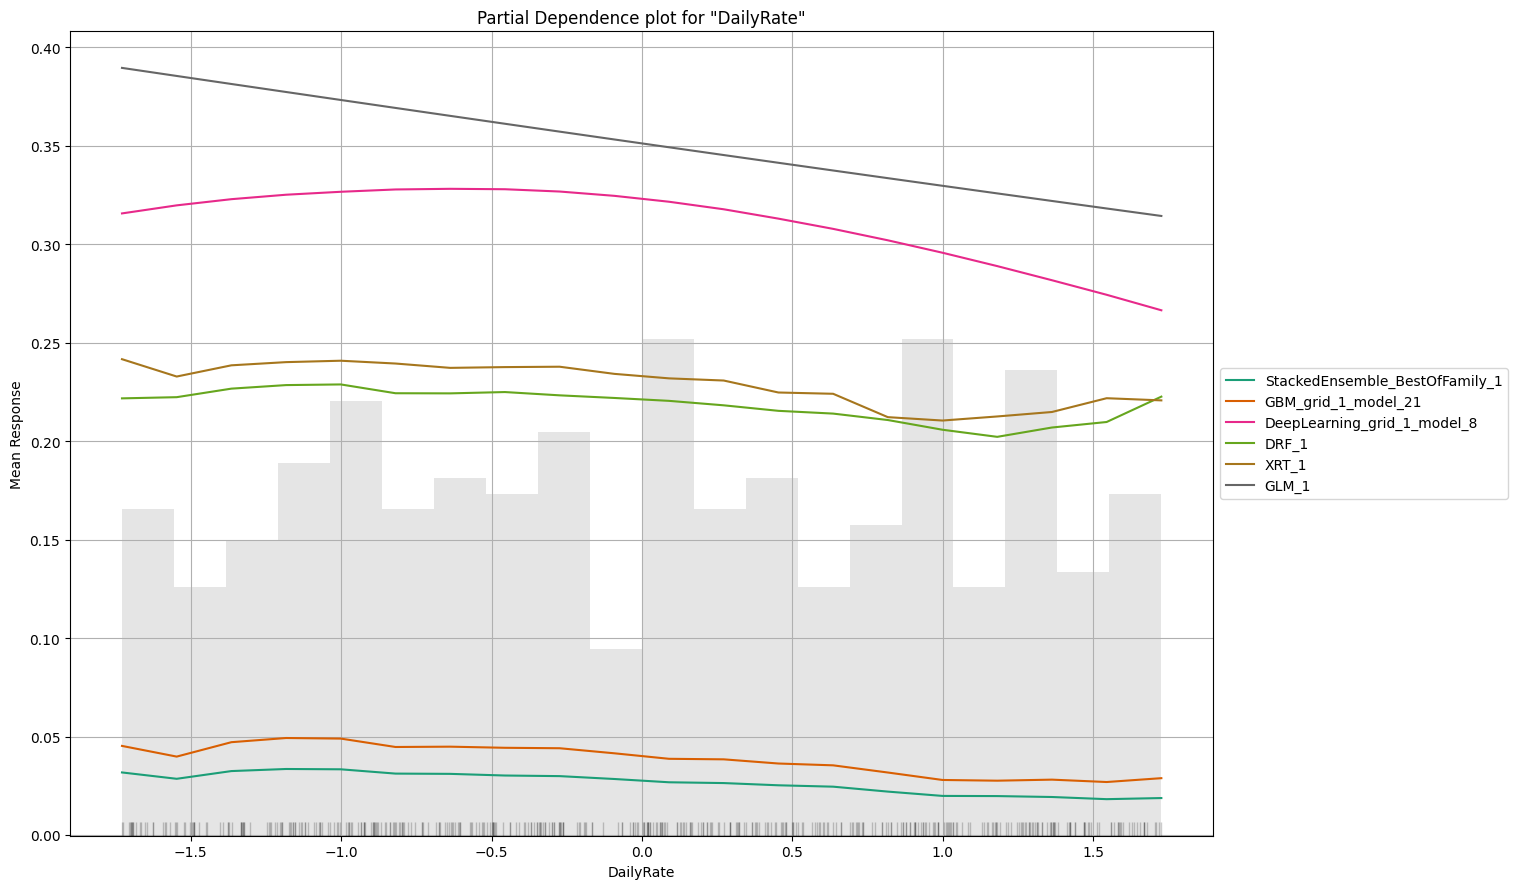

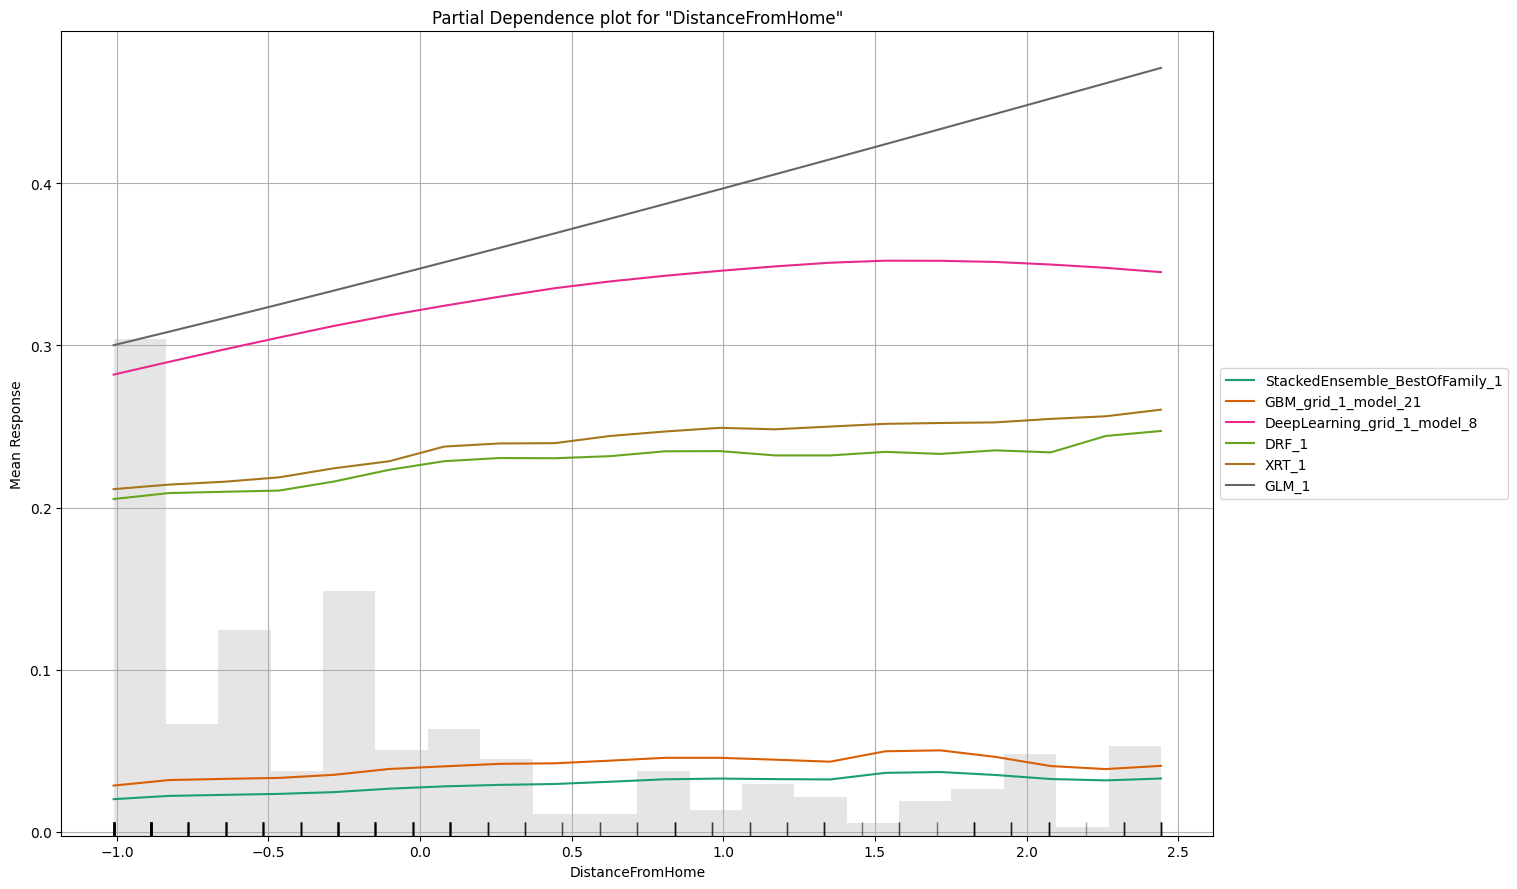

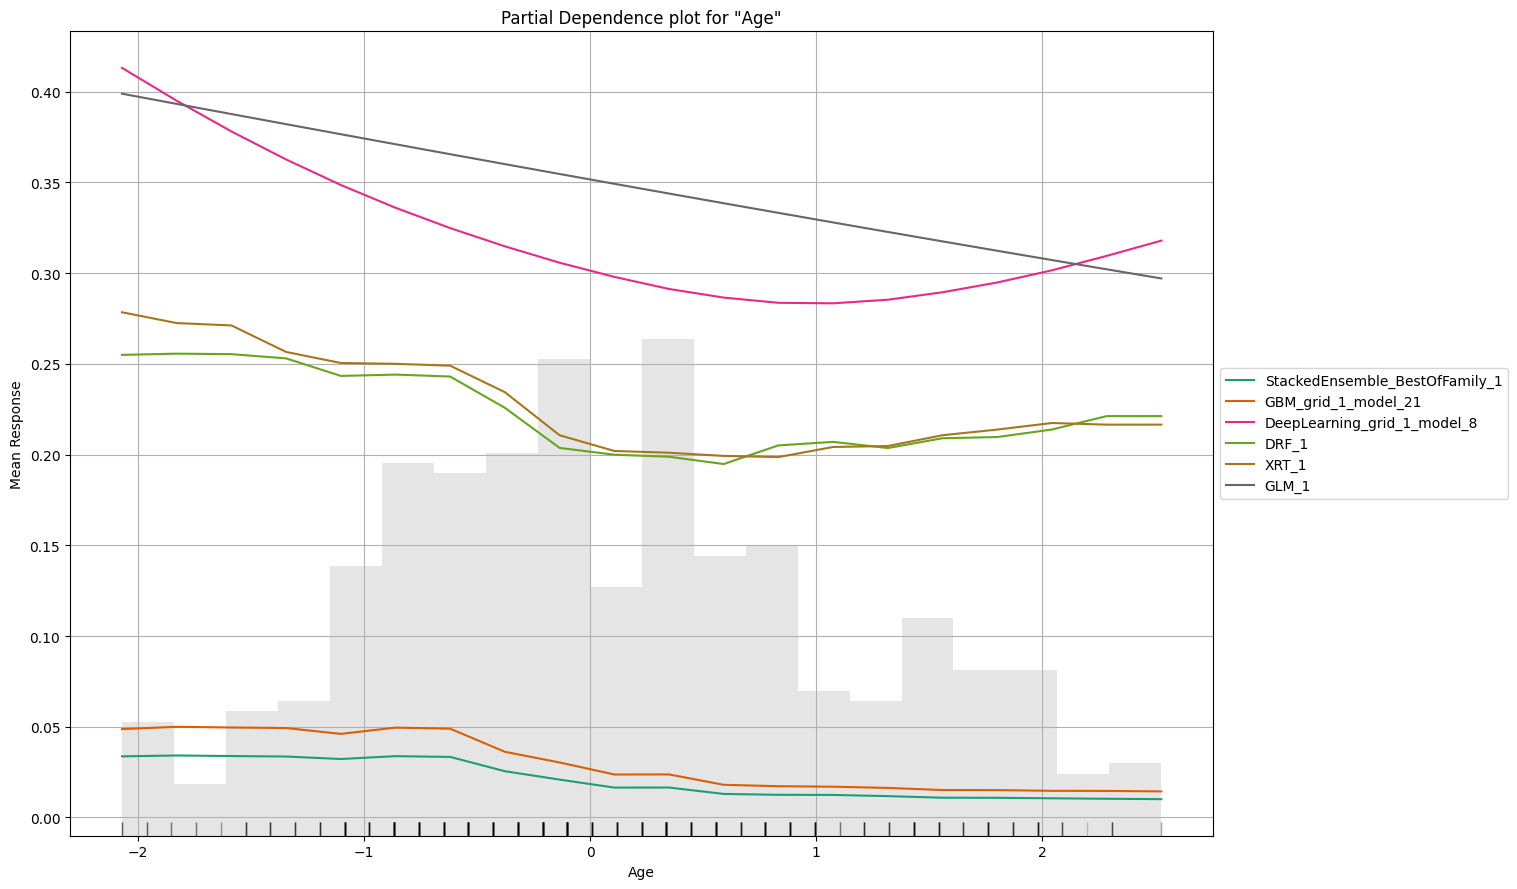

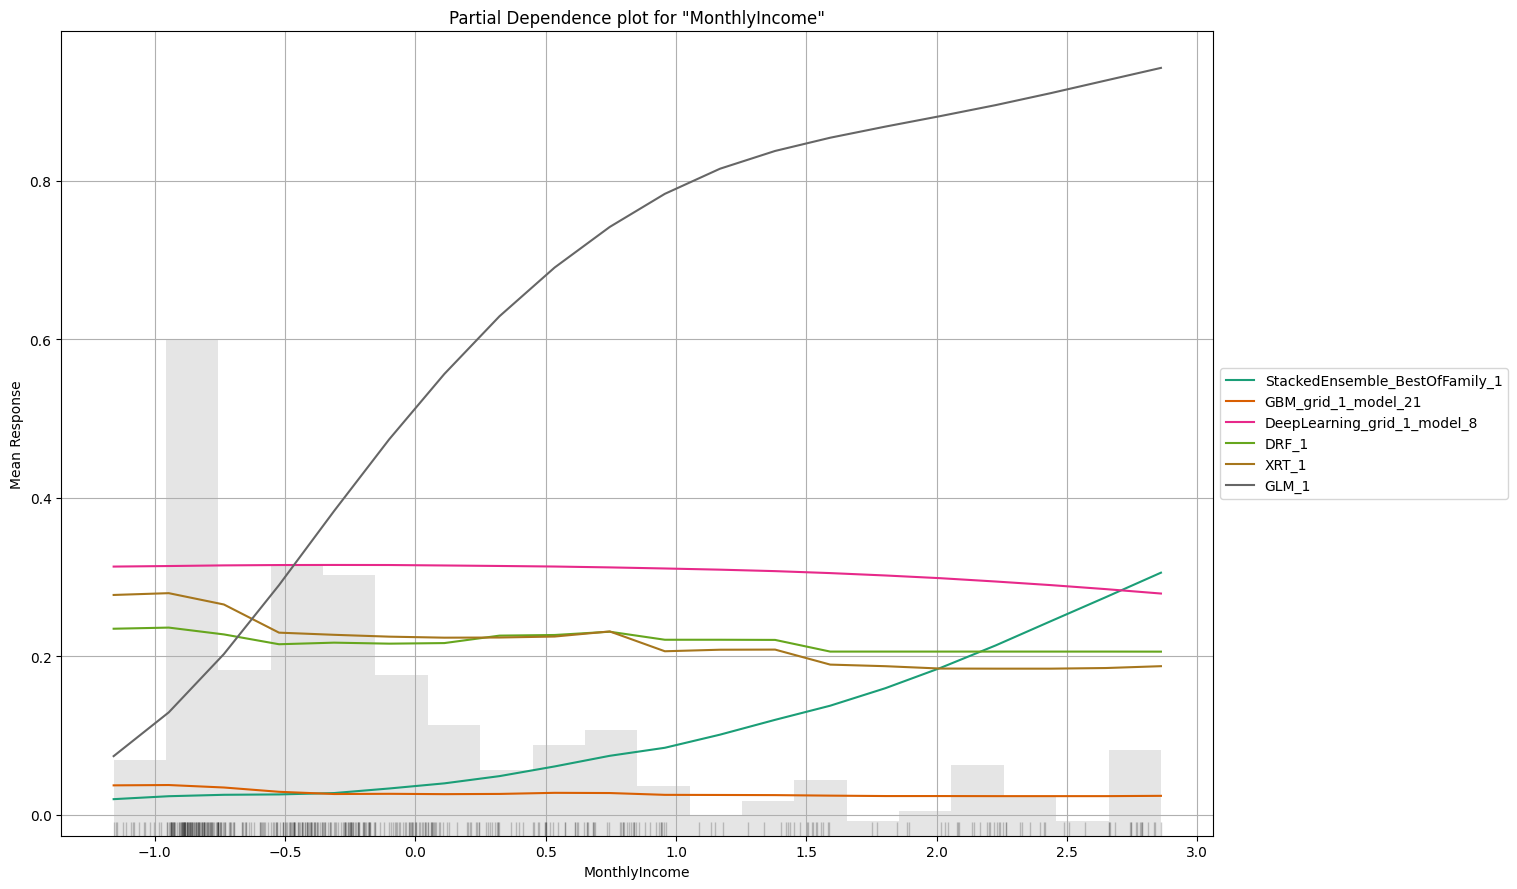

In [14]:
# Leaderboard based on Test results & comparison of models
aml.explain(test)

In [15]:
# Leaderboard for test performance
test_lb = h2o.make_leaderboard(aml, test, sort_metric="logloss")
test_lb.head(rows=test_lb.nrows)  # Print all rows instead of default (10 rows)

model_id                                                   logloss       auc     aucpr    mean_per_class_error      rmse        mse
-------------------------------------------------------  ---------  --------  --------  ----------------------  --------  ---------
GBM_1_AutoML_1_20250317_191731                            0.276211  0.858347  0.657432                0.238829  0.278512  0.0775689
GBM_grid_1_AutoML_1_20250317_191731_model_11              0.277028  0.843796  0.634817                0.206689  0.272973  0.0745144
GBM_grid_1_AutoML_1_20250317_191731_model_16              0.283692  0.855286  0.666762                0.244655  0.286792  0.0822497
GBM_grid_1_AutoML_1_20250317_191731_model_3               0.286496  0.857113  0.634832                0.231702  0.27416   0.0751636
GBM_grid_1_AutoML_1_20250317_191731_model_20              0.288926  0.834247  0.61426                 0.231702  0.279909  0.0783491
GBM_grid_1_AutoML_1_20250317_191731_model_9               0.290843  0.845829  0.616593                0.263843  0.276369  0.0763796
GBM_grid_1_AutoML_1_20250317_191731_model_4               0.291393  0.86118   0.634294                0.22293   0.27254   0.0742779
GBM_grid_1_AutoML_1_20250317_191731_model_7               0.291975  0.842562  0.59668                 0.27426   0.295047  0.0870528
GBM_grid_1_AutoML_1_20250317_191731_model_24              0.295471  0.833836  0.58877                 0.251508  0.286197  0.081909
GBM_grid_1_AutoML_1_20250317_191731_model_17              0.297956  0.82166   0.58607                 0.285293  0.28504   0.0812476
GBM_grid_1_AutoML_1_20250317_191731_model_14              0.30061   0.869655  0.693296                0.20991   0.300705  0.0904234
GBM_grid_1_AutoML_1_20250317_191731_model_2               0.307034  0.824447  0.570827                0.258361  0.290203  0.0842177
GBM_grid_1_AutoML_1_20250317_191731_model_19              0.307094  0.870591  0.658786                0.226494  0.305359  0.093244
DRF_1_AutoML_1_20250317_191731                            0.325132  0.847542  0.530695                0.248629  0.305593  0.0933869
DeepLearning_1_AutoML_1_20250317_191731                   0.325215  0.846468  0.576836                0.205729  0.292657  0.0856481
GBM_grid_1_AutoML_1_20250317_191731_model_25              0.326631  0.849666  0.578928                0.261582  0.285267  0.0813771
GBM_grid_1_AutoML_1_20250317_191731_model_22              0.334125  0.840757  0.600311                0.256373  0.283509  0.0803775
GBM_grid_1_AutoML_1_20250317_191731_model_6               0.336874  0.880437  0.708845                0.198876  0.323251  0.104491
GBM_2_AutoML_1_20250317_191731                            0.340021  0.83708   0.574374                0.258361  0.290773  0.0845488
XRT_1_AutoML_1_20250317_191731                            0.346119  0.813711  0.419662                0.293517  0.320476  0.102705
GBM_grid_1_AutoML_1_20250317_191731_model_12              0.3578    0.836326  0.559808                0.261924  0.296395  0.0878503
GBM_3_AutoML_1_20250317_191731                            0.361391  0.847725  0.594474                0.238829  0.288223  0.0830722
GBM_grid_1_AutoML_1_20250317_191731_model_23              0.363443  0.860974  0.62677                 0.229441  0.283614  0.0804371
GBM_5_AutoML_1_20250317_191731                            0.366014  0.834795  0.533981                0.279468  0.299111  0.0894675
GBM_grid_1_AutoML_1_20250317_191731_model_5               0.366088  0.850694  0.58926                 0.26028   0.288723  0.0833612
GBM_4_AutoML_1_20250317_191731                            0.377602  0.846651  0.583545                0.231086  0.29094   0.0846459
GBM_grid_1_AutoML_1_20250317_191731_model_1               0.397386  0.852088  0.562591                0.200932  0.299188  0.0895136
GBM_grid_1_AutoML_1_20250317_191731_model_13              0.409931  0.830615  0.517256                0.267749  0.308463  0.0951497
GBM_grid_1_AutoML_1_20250317_191731_model_10

In [16]:
# Getting best model for test
test_best_model_ID = test_lb[0, 0]
test_best_model = h2o.get_model(test_best_model_ID)

# Display Training and CV performance
test_best_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20250317_191731


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    302                302                         56946                  4            9            6.10265       9             12            10.3212

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0042413395647366665
RMSE: 0.06512556767304732
LogLoss: 0.046351586135635926
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6057512807174248
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      849  0    0        (0.0/849.0)
1      0    849  0        (0.0/849.0)
Total  849  849  0        (0.0/1698.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.605751     1         129
max f2                       0.605751     1         129
max f0point5                 0.605751     1         129
max accuracy                 0.605751     1         129
max precision                0.999799     1         0
max recall                   0.605751     1         129
max specificity              0.999799     1         0
max absolute_mcc             0.605751     1         129
max min_per_class_accuracy   0.605751     1         129
max mean_per_class_accuracy  0.605751     1         129
max tns                      0.999799     849       0
max fns                      0.999799     842       0
max fps                      0.000178175  849       399
max tps                      0.605751     849       129
max tnr                      0.999799     1         0
max fnr                      0.999799     0.991755  0
max fpr                      0.000178175  1         399
max tpr                      0.605751     1         129

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.02 %
group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------  --------------------
1        0.0106007                   0.999313           2       2                  1                0.99956     1                           0.99956             0.0212014       0.0212014                  100     100                0.0212014
2        0.0200236                   0.994232           2       2                  1                0.99597     1                           0.99787             0.0188457       0.0400471                  100     100                0.0400471
3        0.0300353                   0.993031           2       2                  1                0.993482    1                           0.996408            0.0200236       0.0600707                  100     100                0.0600707
4        0.041225                    0.990363           2       2                  1                0.991155    1                           0.994982            0.0223793       0.0824499                  100     100                0.0824499
5        0.0518257                   0.988866           2       2                  1                0.989433    1                           0.993847            0.0212014       0.103651                   100     100                0.103651


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20250317_191731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5386318018400824
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      369  15   0.0391   (15.0/384.0)
1      25   32   0.4386   (25.0/57.0)
Total  394  47   0.0907   (40.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

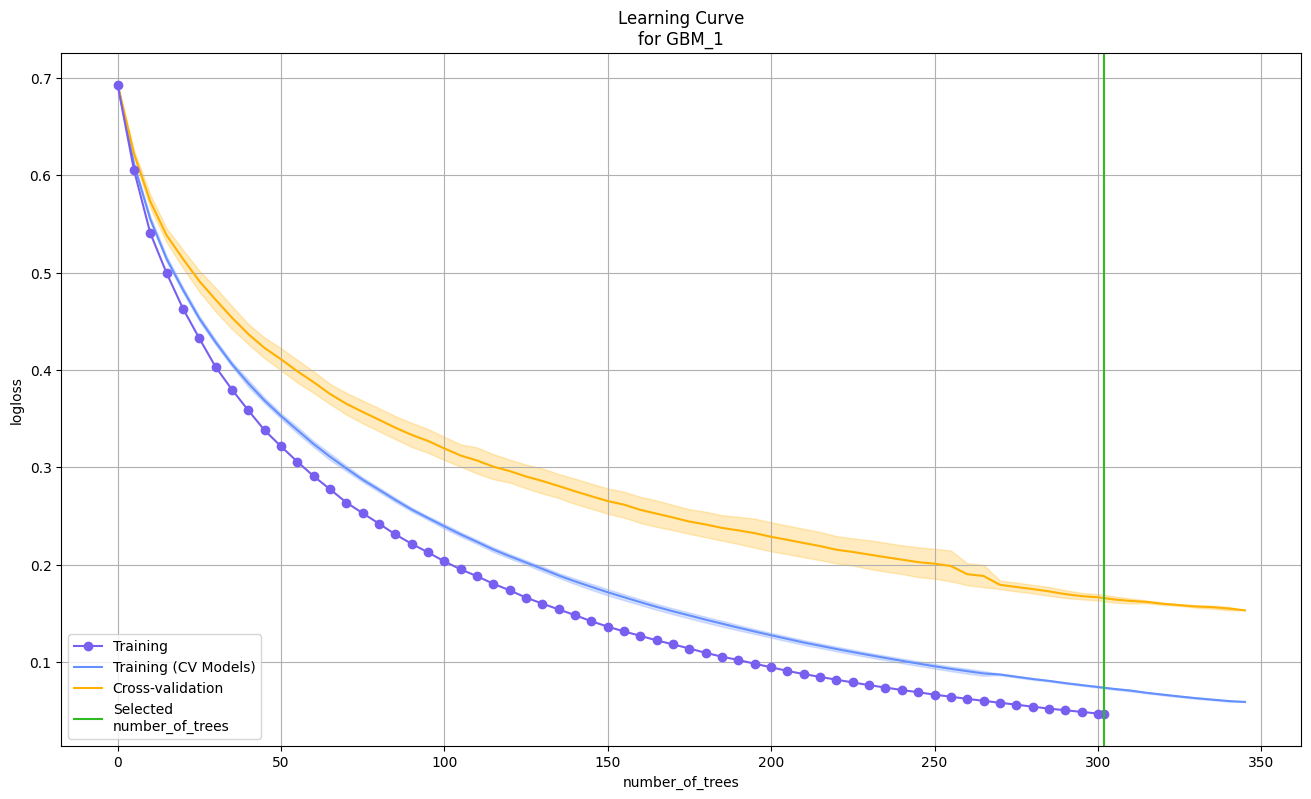

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

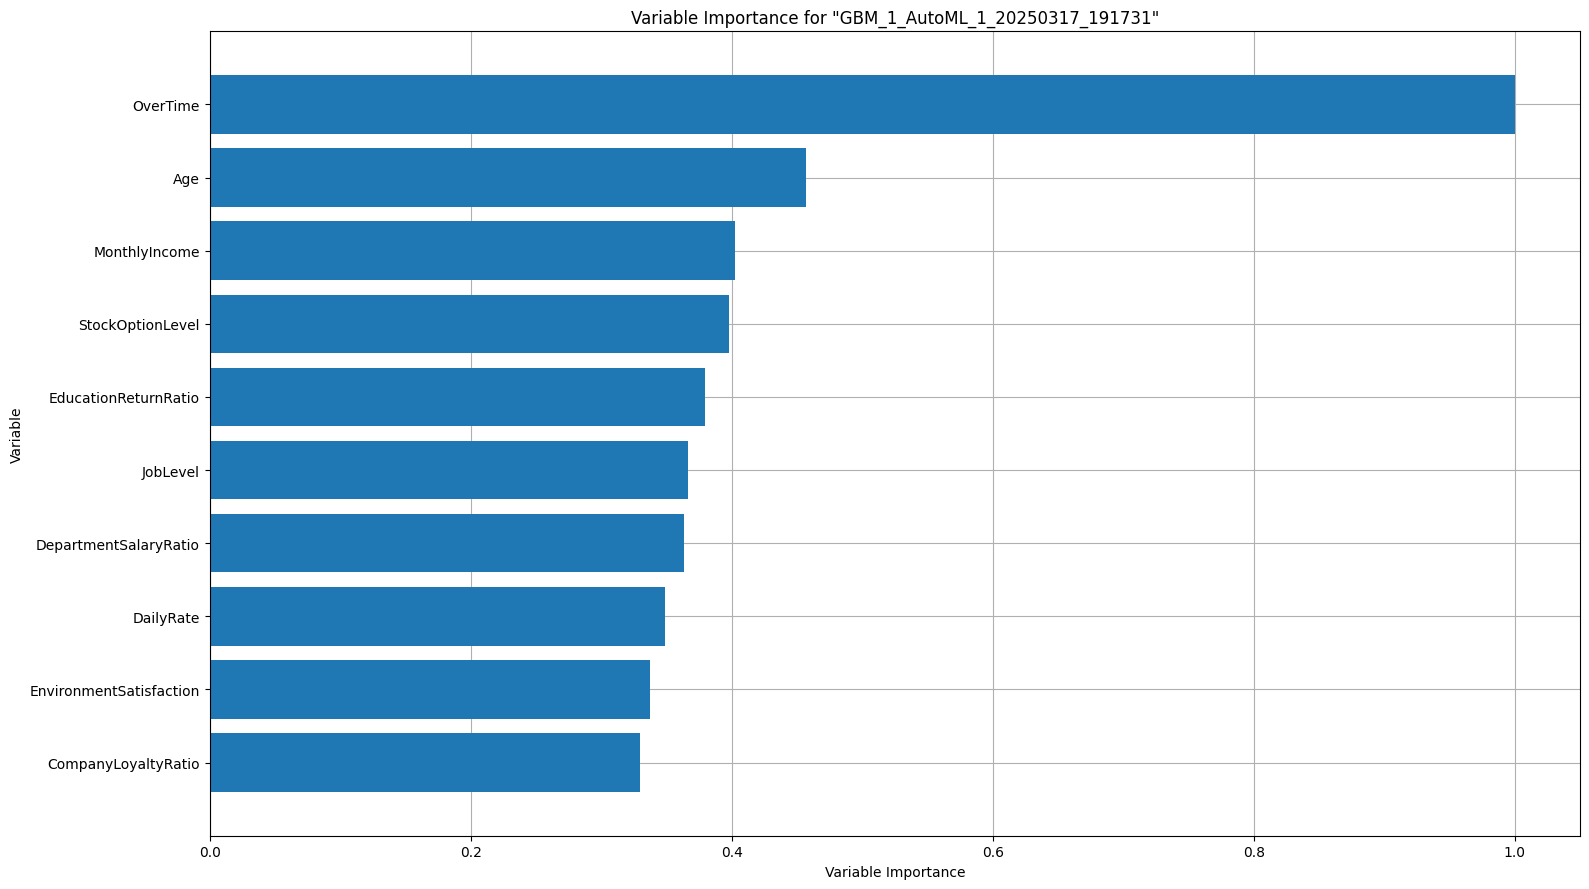

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

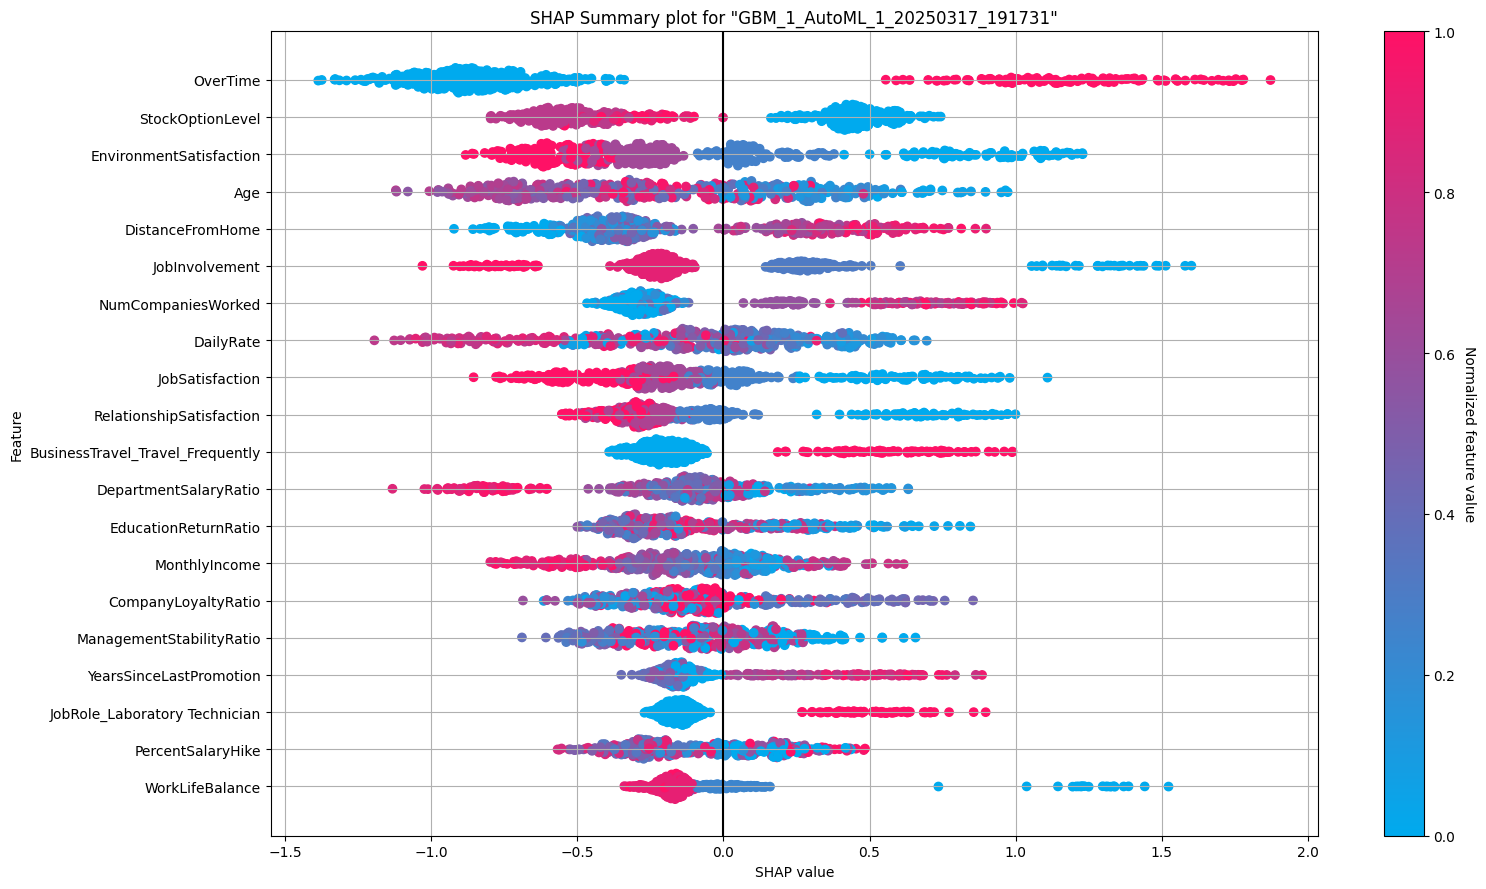

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

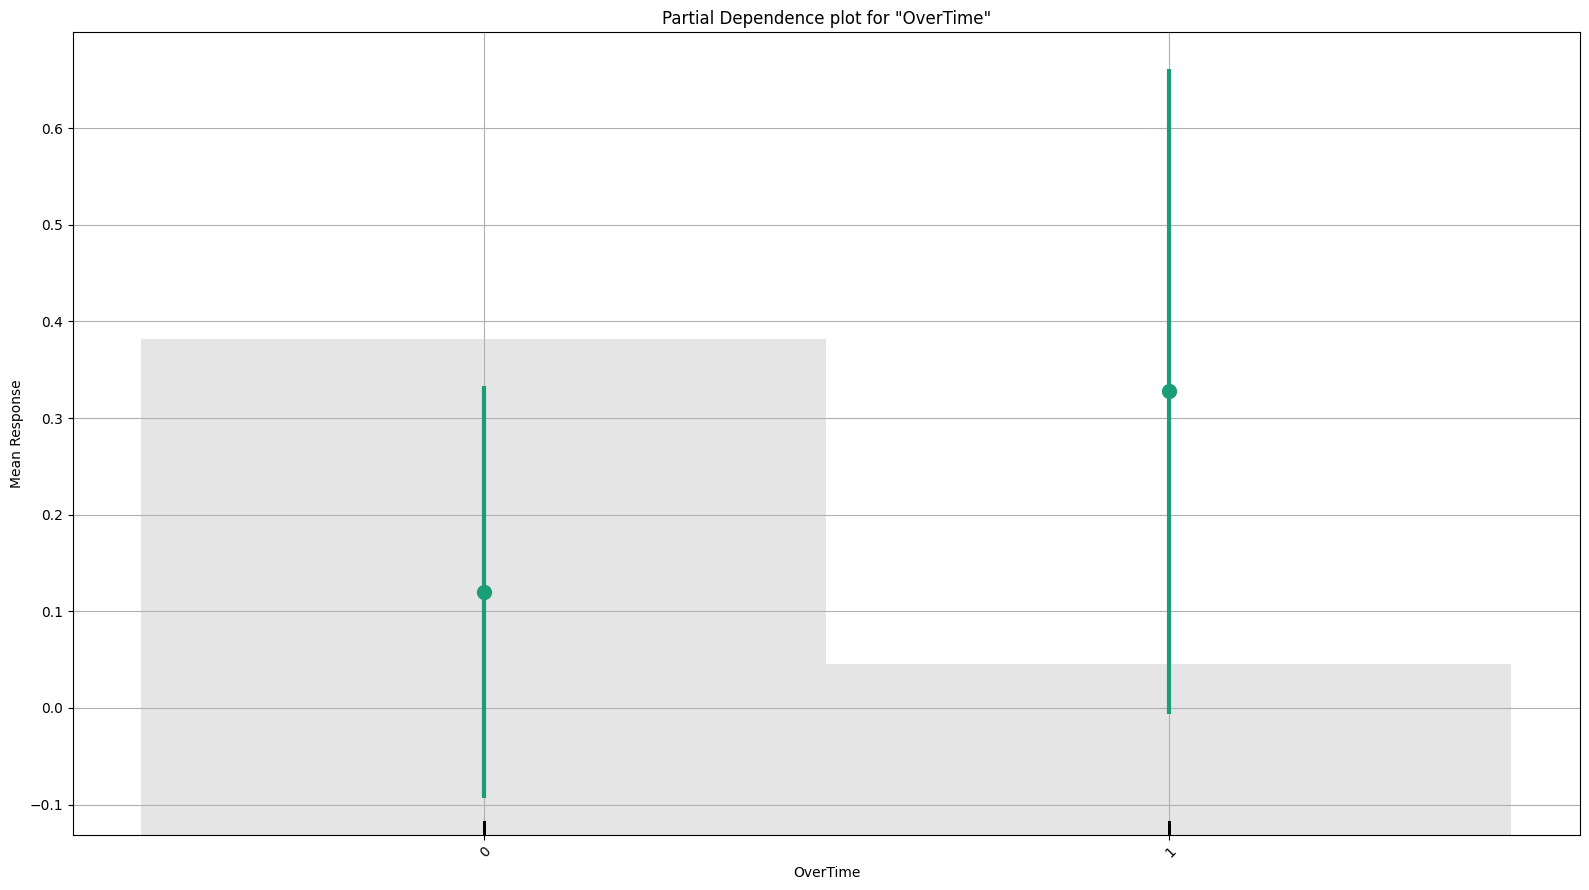

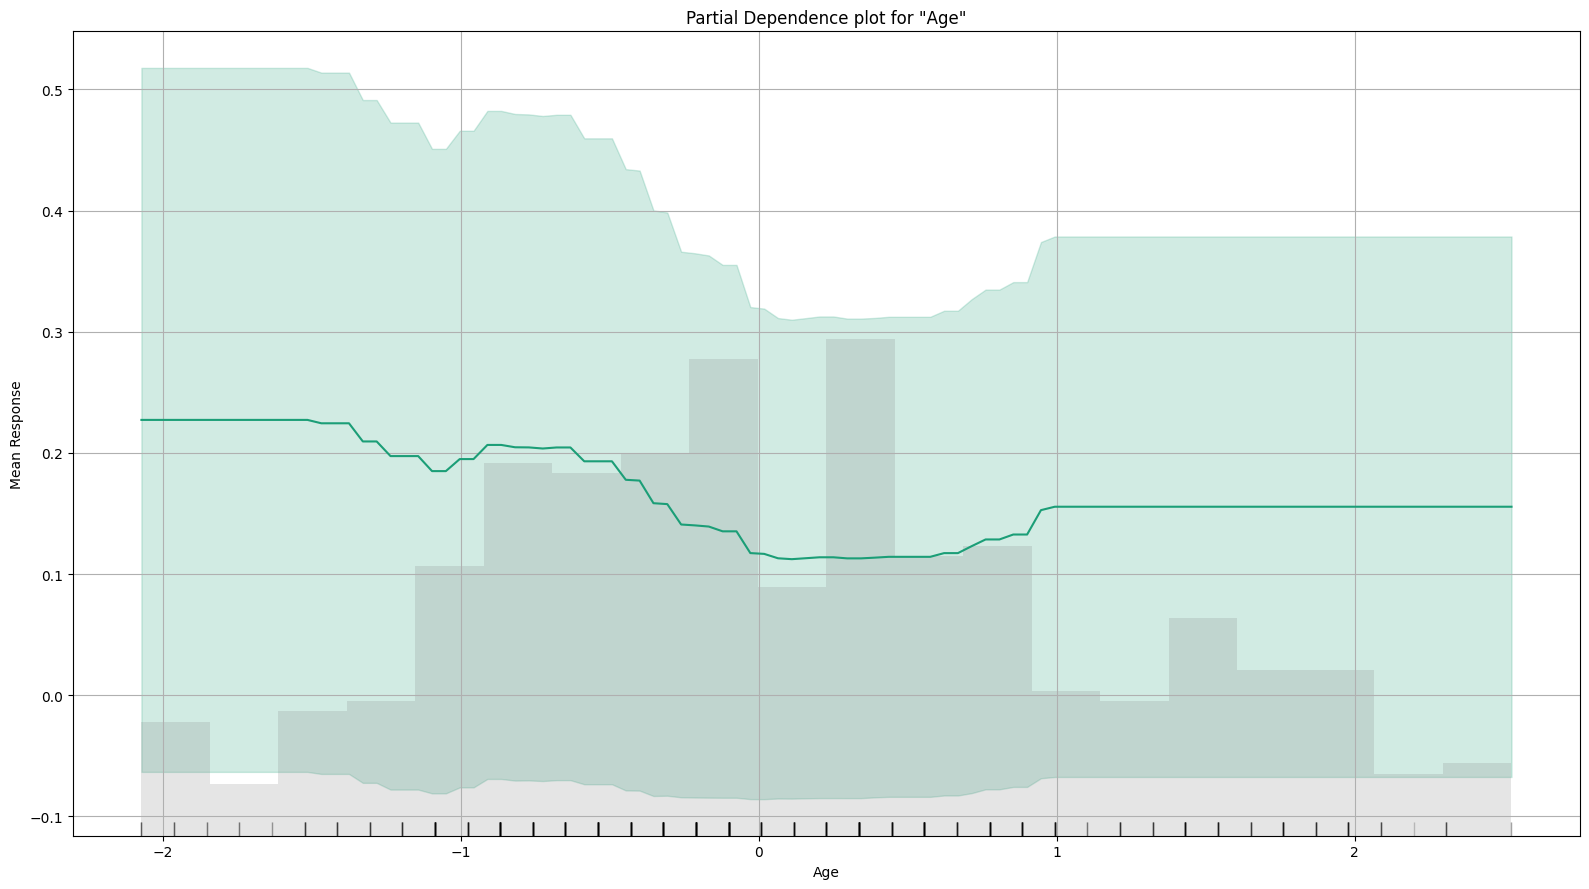

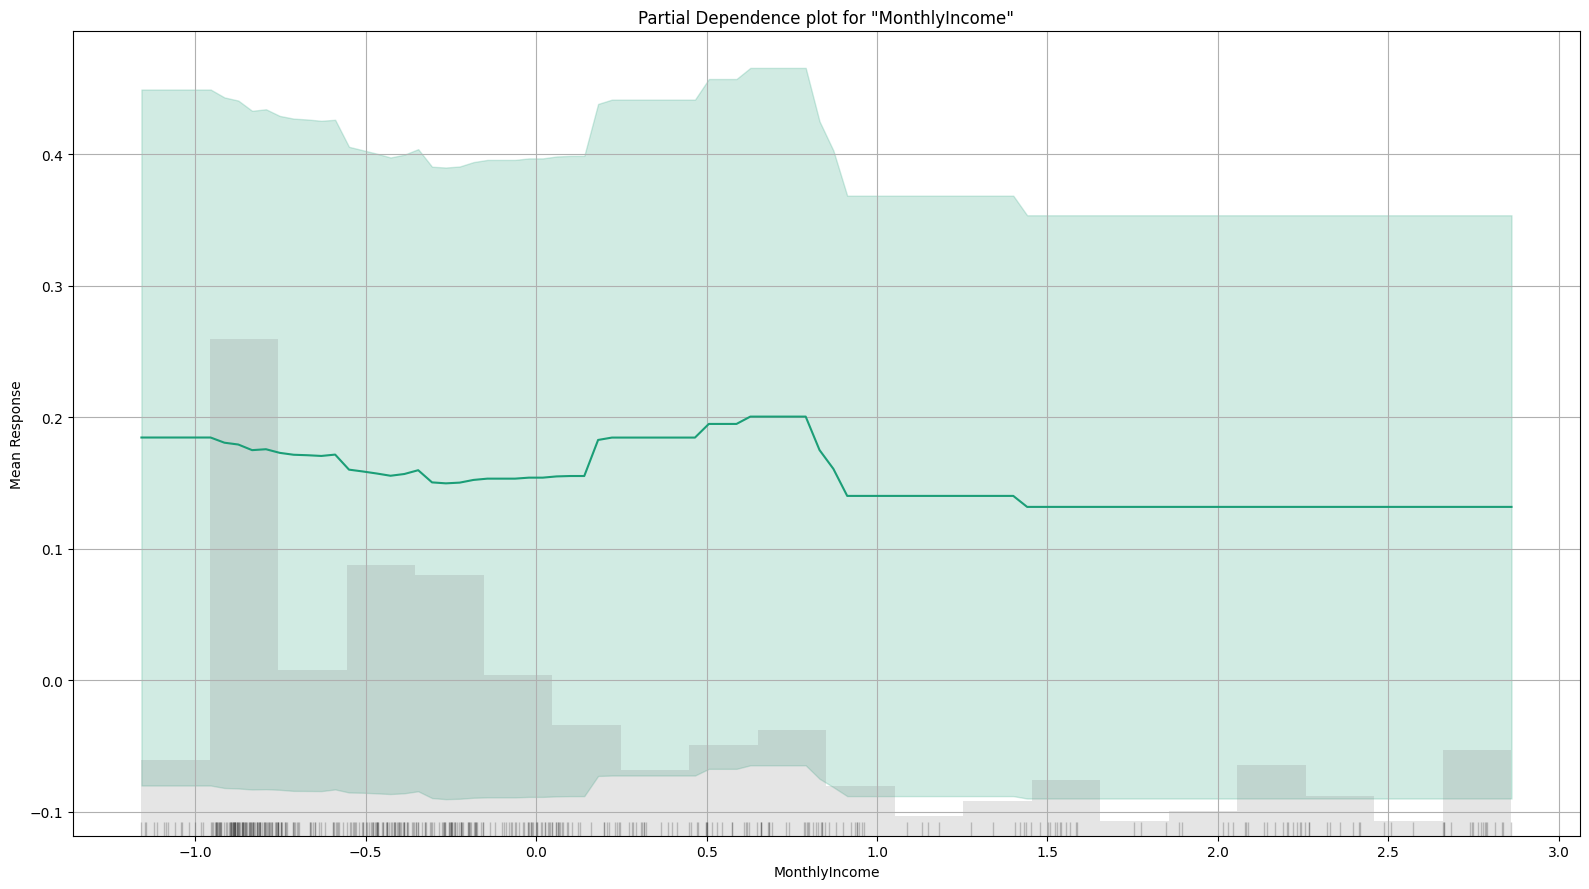

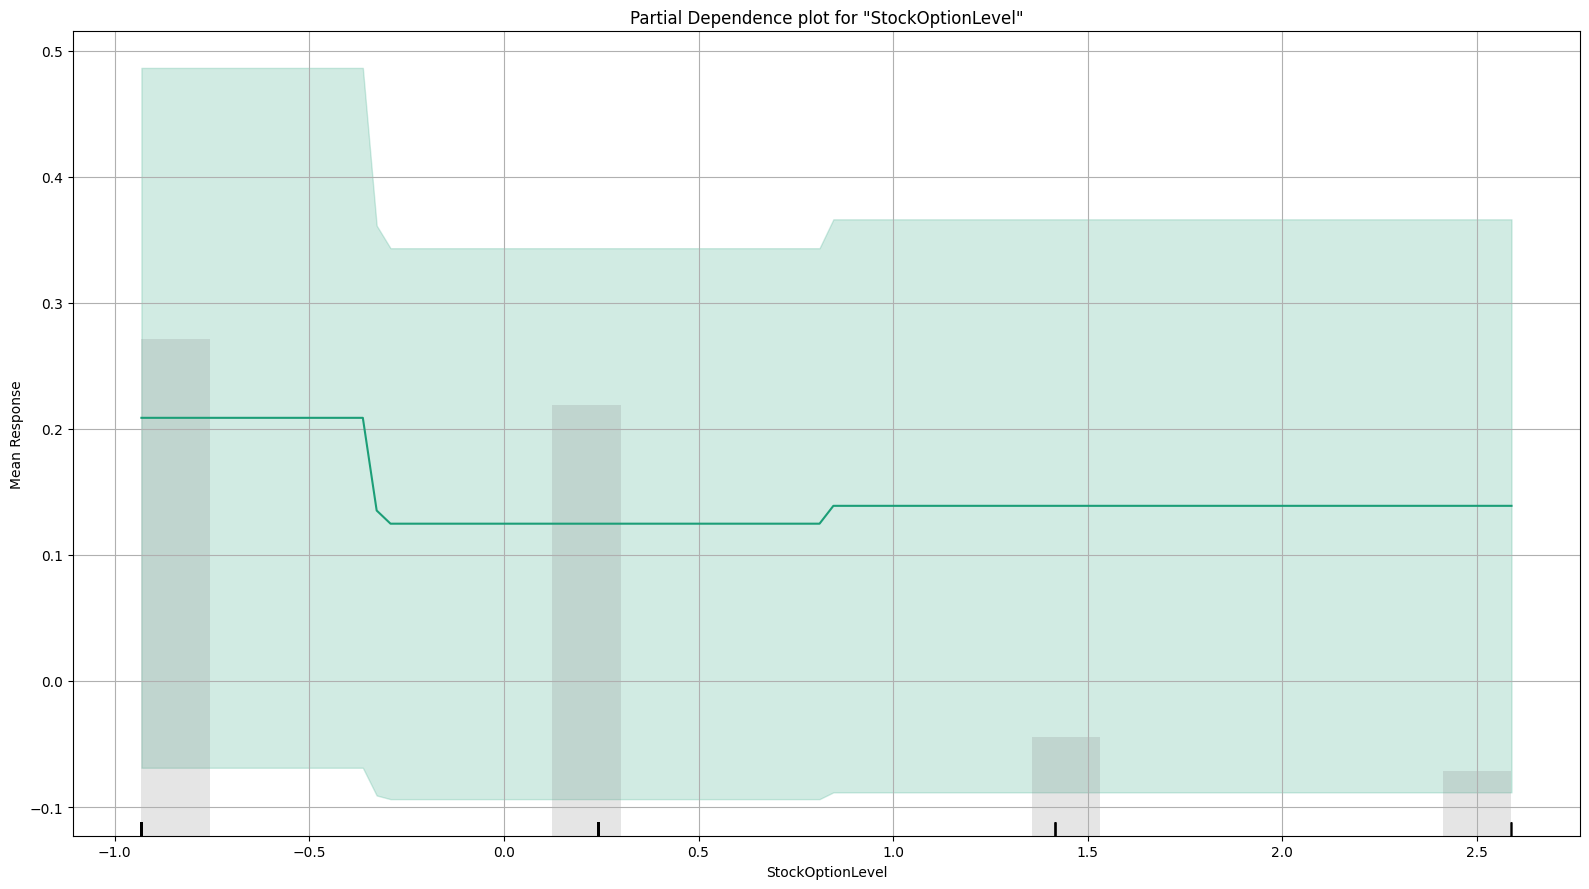

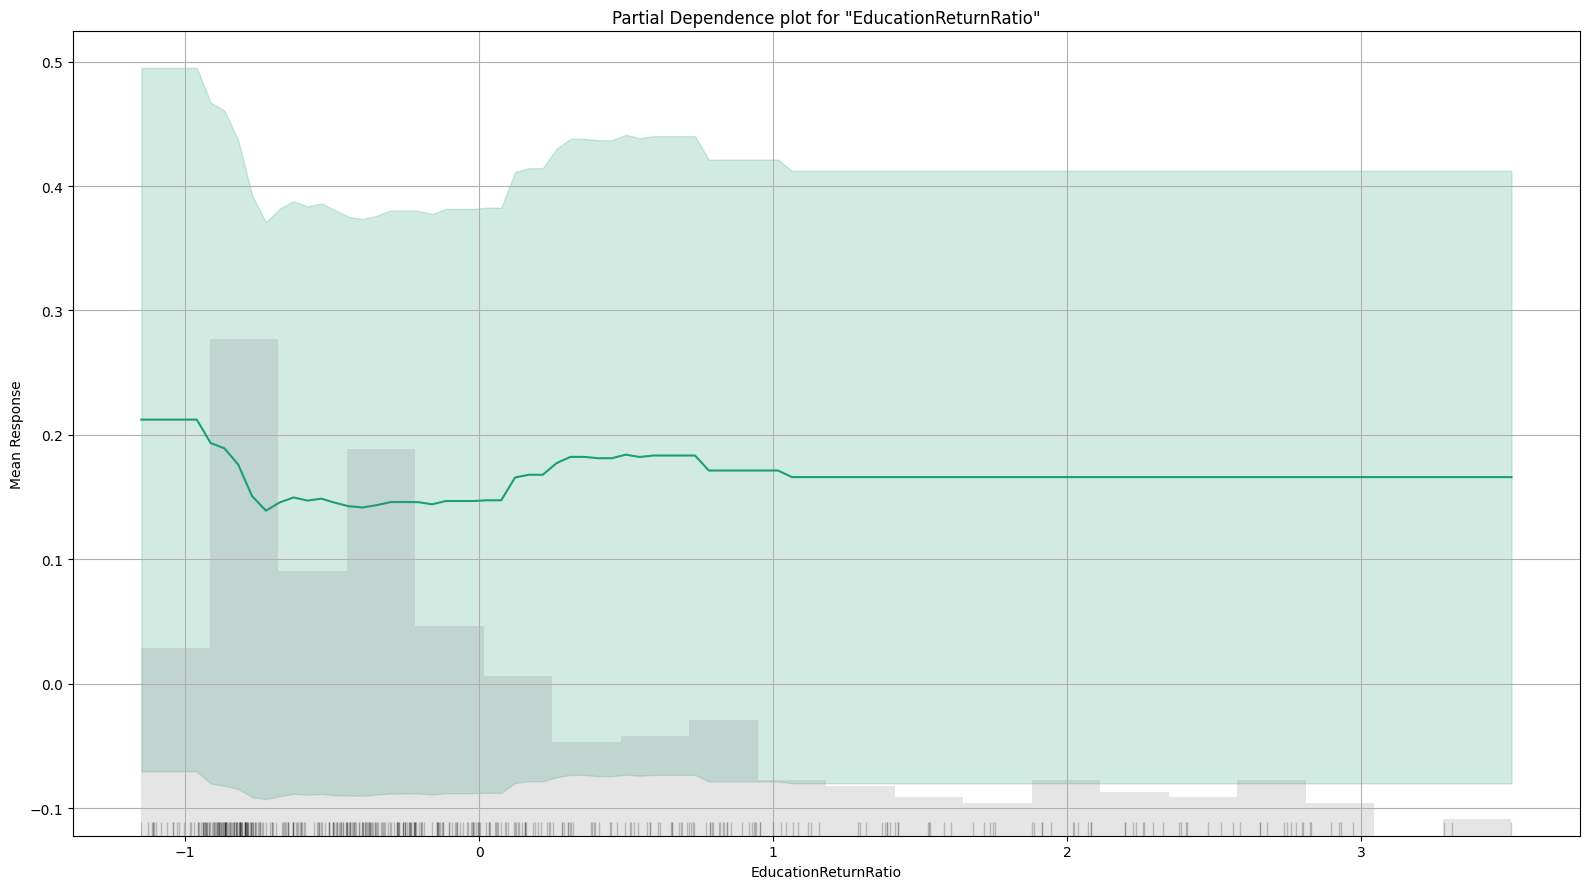

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20250317_191731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5386318018400824
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      369  15   0.0391   (15.0/384.0)
1      25   32   0.4386   (25.0/57.0)
Total  394  47   0.0907   (40.0/441.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

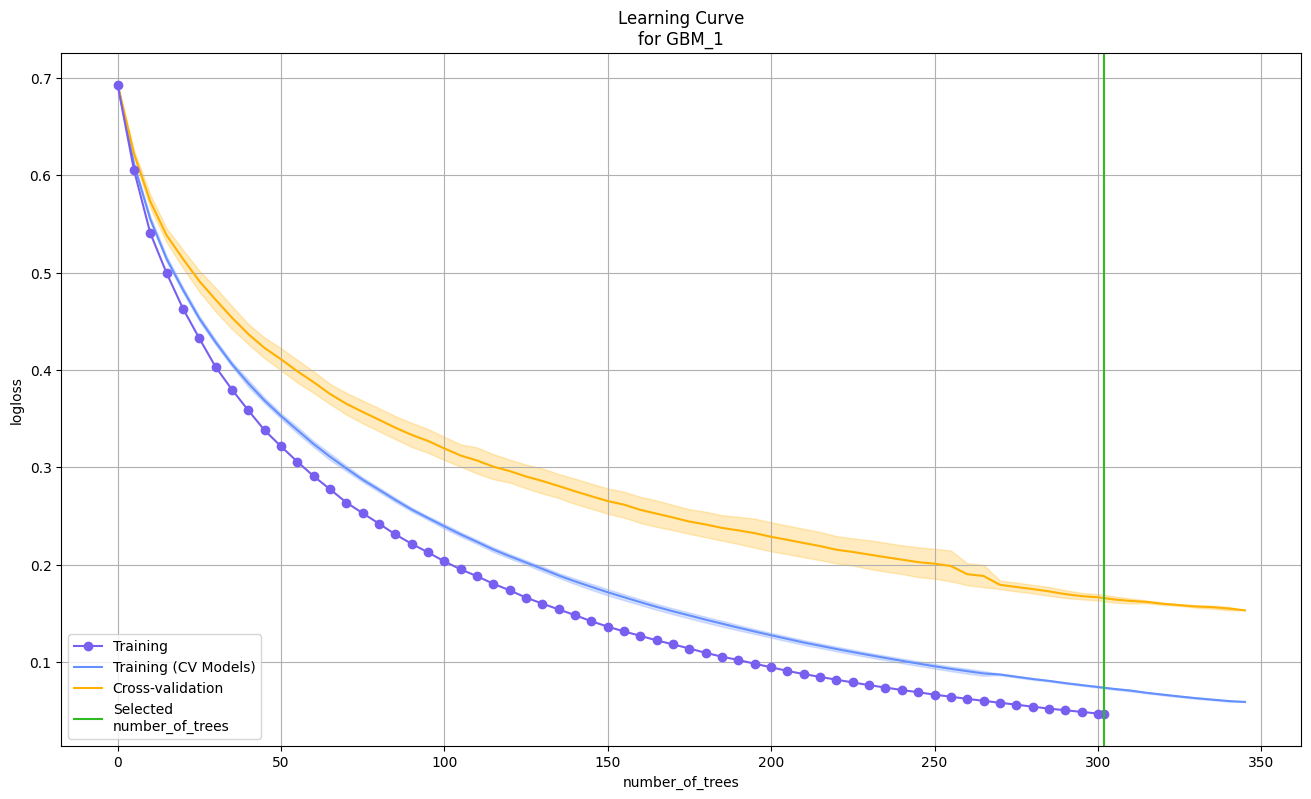

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

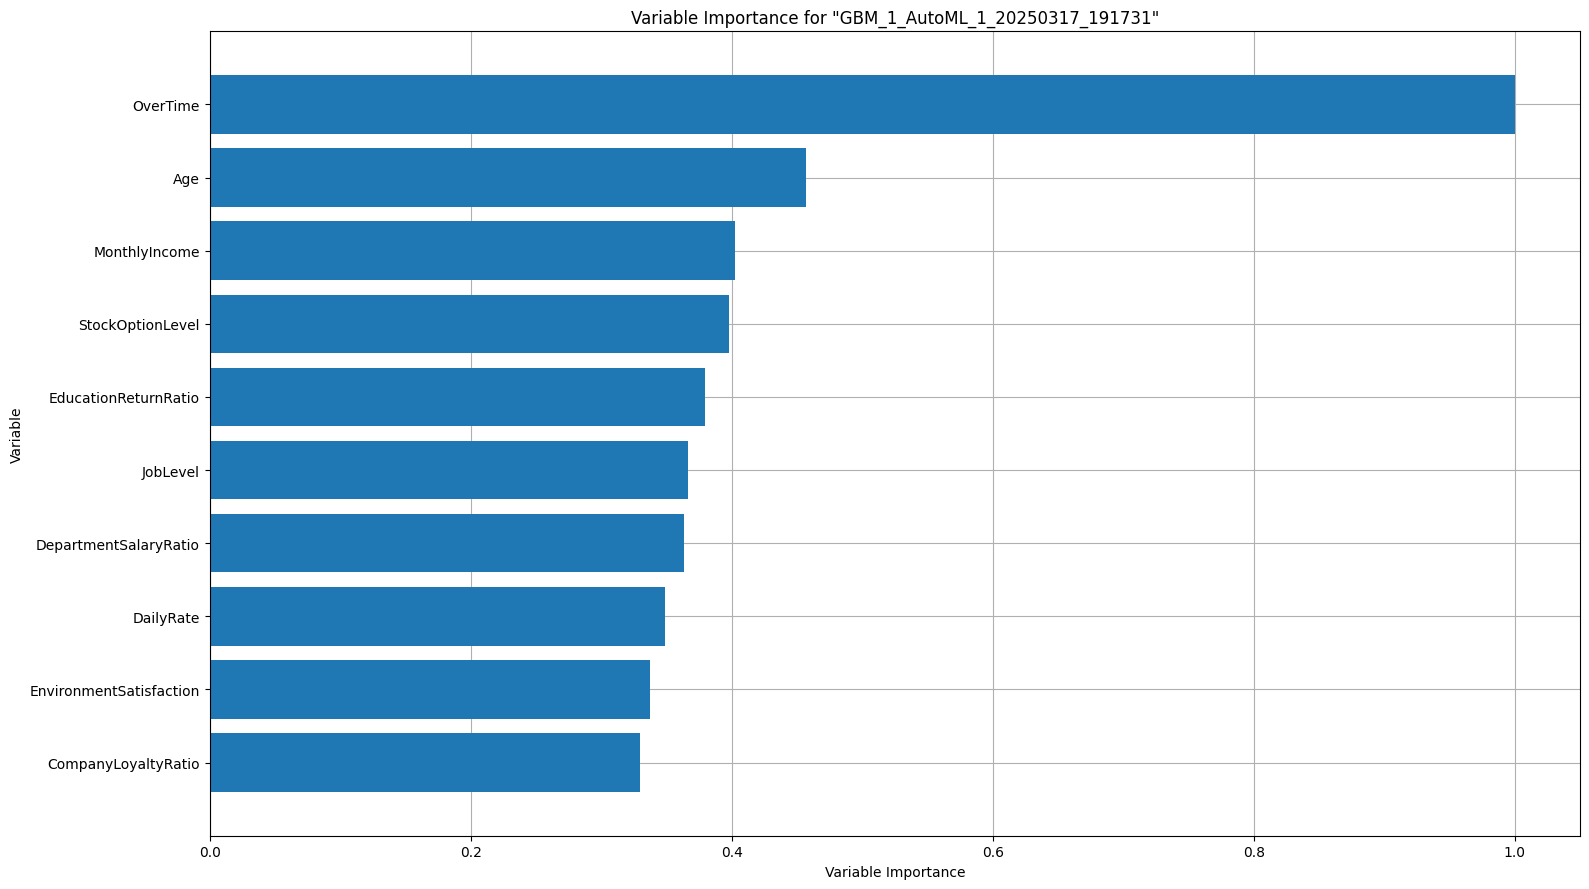

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

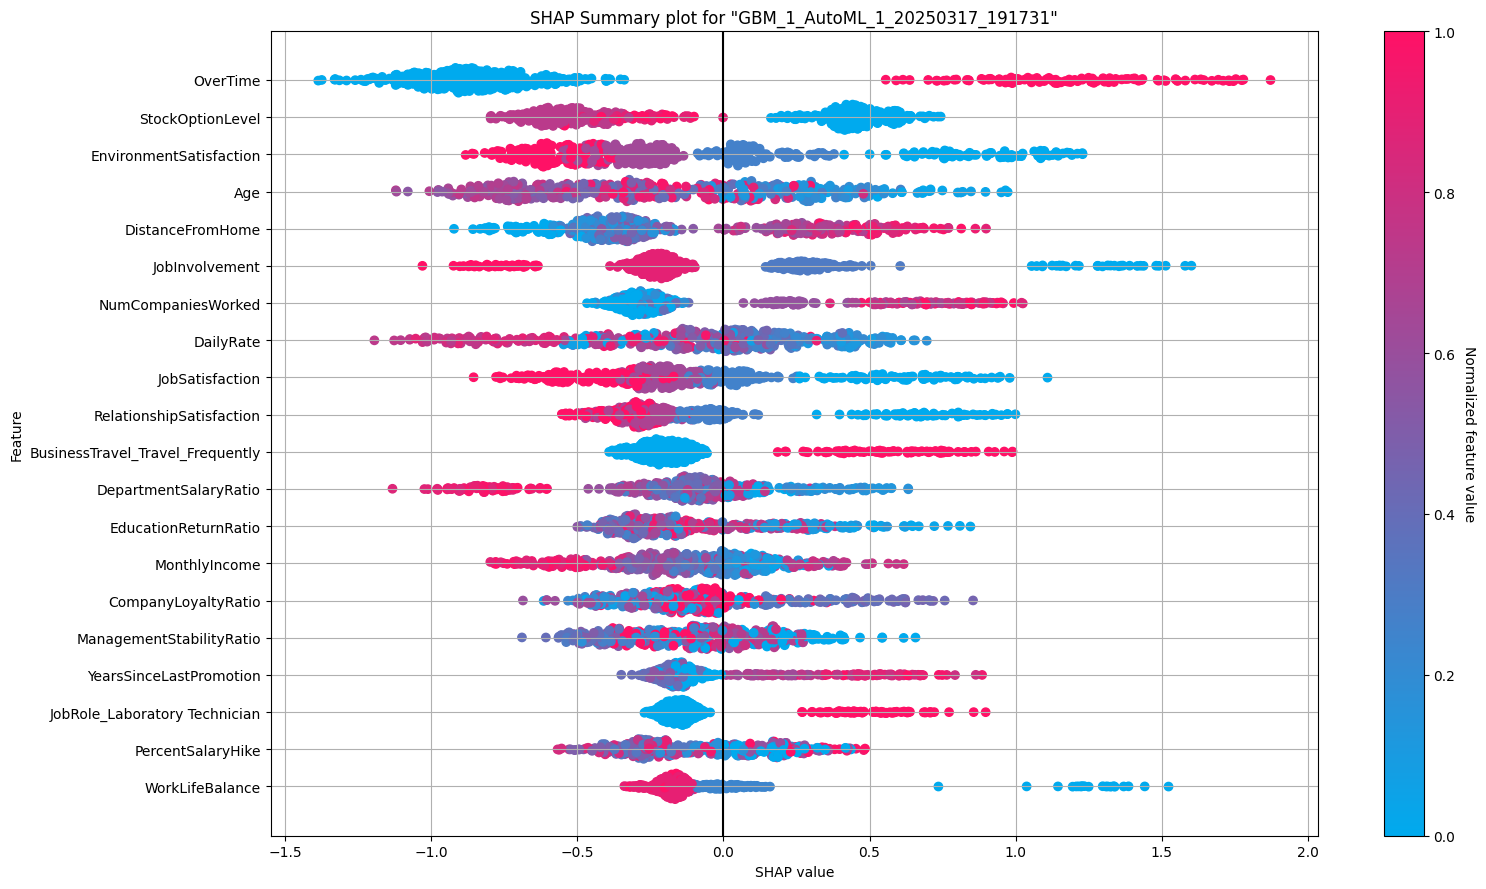

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

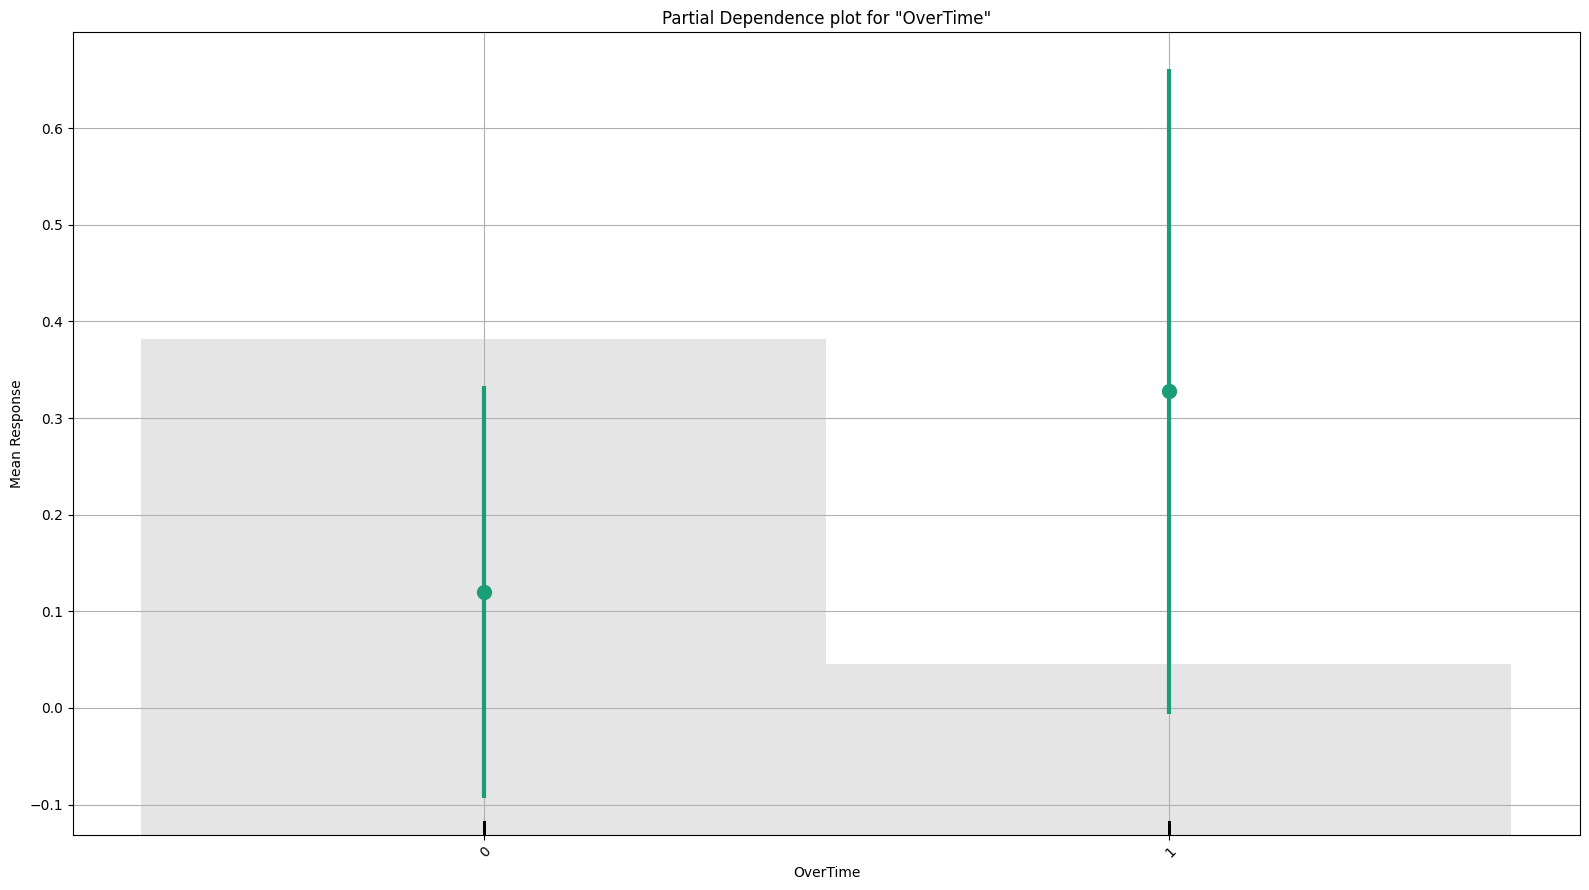

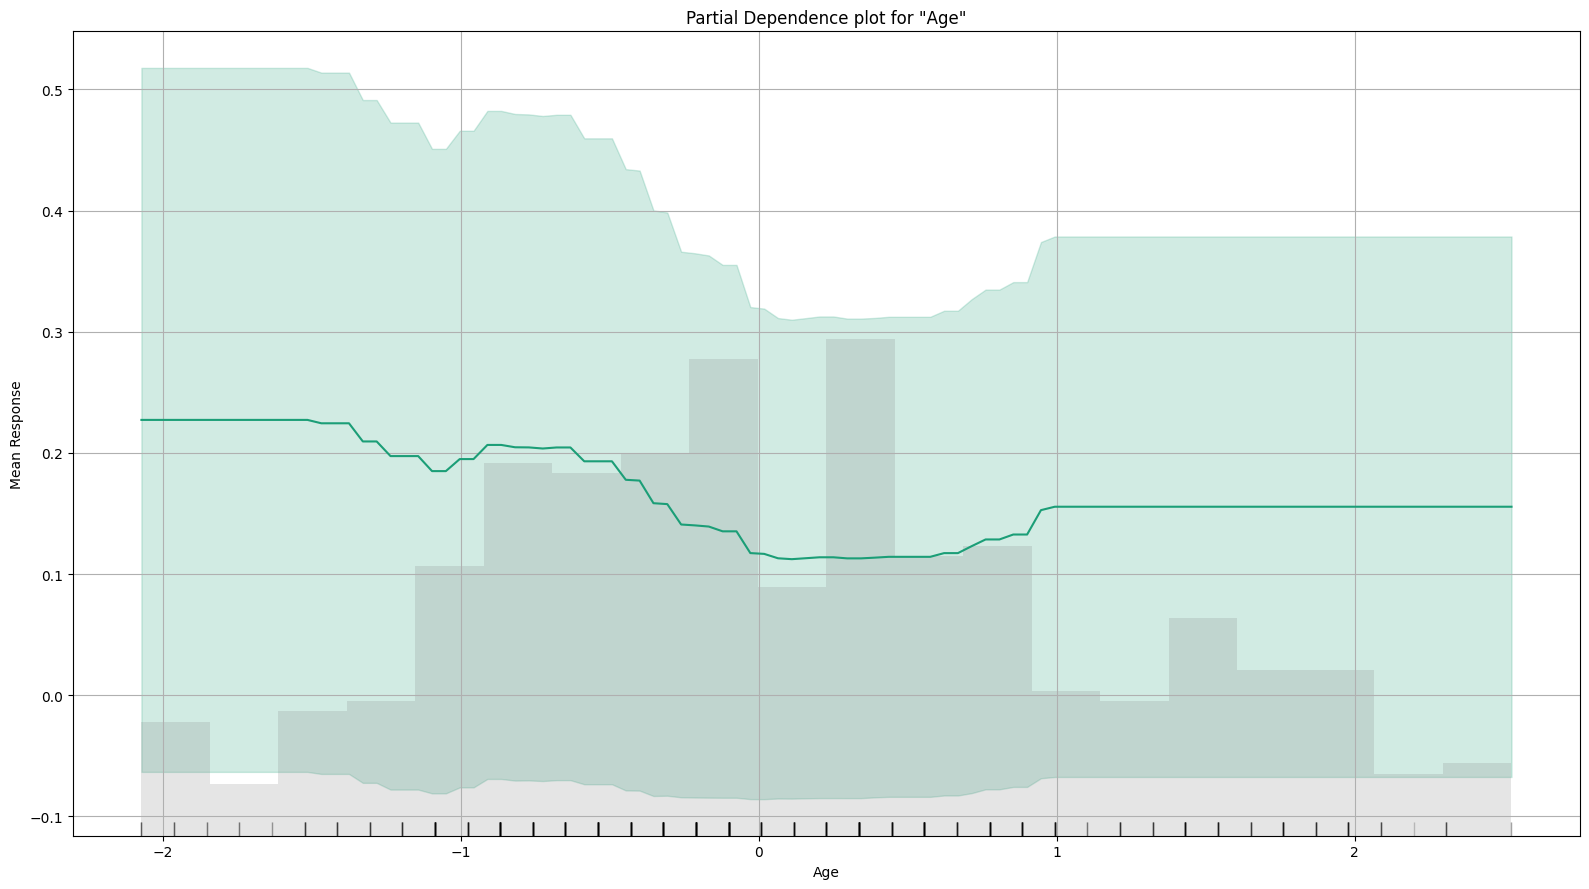

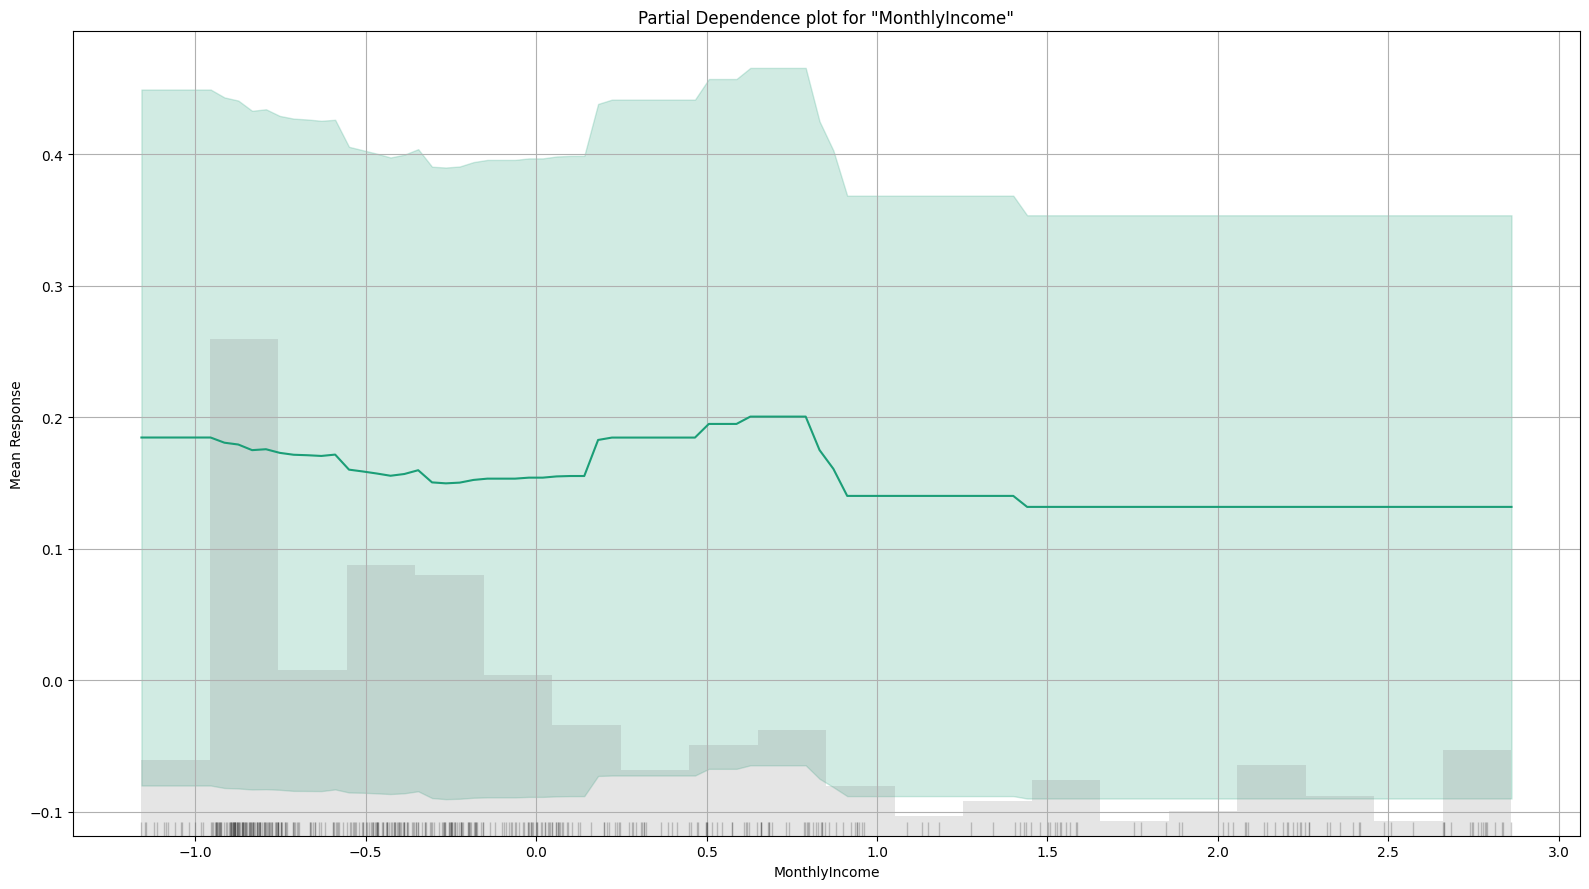

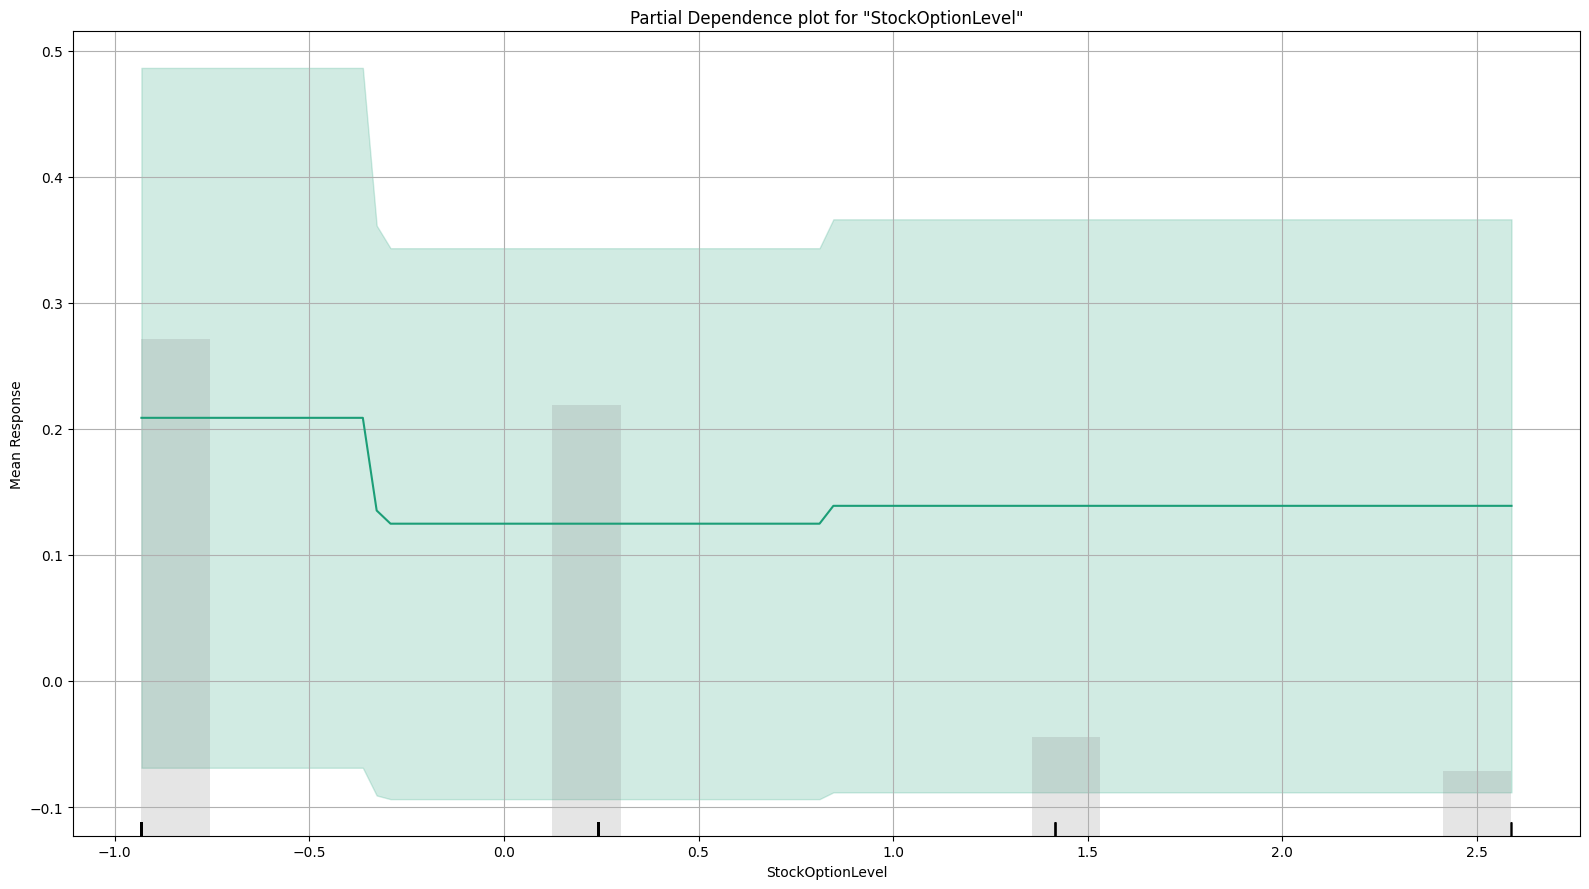

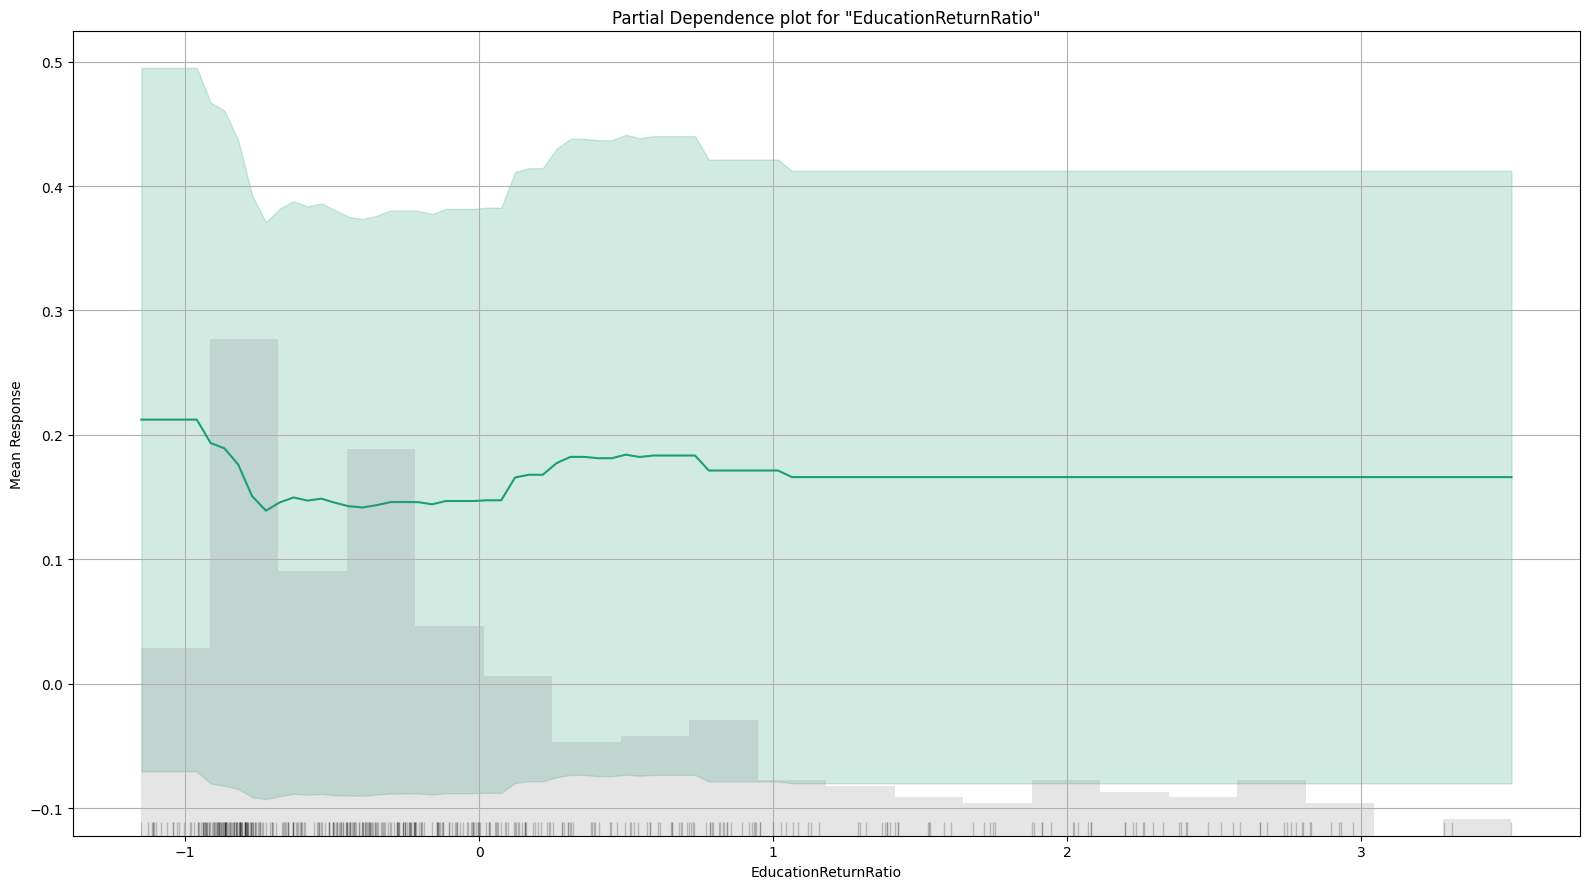

In [17]:
# Display test performance
test_best_model.explain(test)

# Saving Models

In [21]:
# Save models into folder

# Create a folder in the root directory
!mkdir -p "../models/oversampling"

# Get current time
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

cv_model_path = "../models/oversampling/"+current_time+"/cv"
test_model_path = "../models/oversampling/"+current_time+"/test"
cv_lb_path = "../models/oversampling/"+current_time+"/cv_lb.csv"
test_lb_path = "../models/oversampling/"+current_time+"/test_lb.csv"

cv_leader_model_path = h2o.save_model(model=cv_best_model, path=cv_model_path, force=True)
test_leader_model_path = h2o.save_model(model=test_best_model, path=test_model_path, force=True)
h2o.export_file(lb, path=cv_lb_path, force = True)
h2o.export_file(test_lb, path=test_lb_path, force = True)

print(current_time)
print(cv_leader_model_path)

# Documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html

Export File progress: |

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file ../models/oversampling already exists.
Error occurred while processing: ../models/oversampling.


██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
2025-03-17_20-56-34
D:\OneDrive\Repos\demo-project\models\oversampling\2025-03-17_20-56-34\cv\StackedEnsemble_BestOfFamily_1_AutoML_1_20250317_191731
